This script plots the counts from fit and calculate flux, flux ratio 

In [1]:
import numpy as np
import numpy as np
from tools.graphs import MGraph, slice_graph, plot_graph, slice_graph_by_value, concatenate_graphs, scale_graph
from tools.plottools import plot1dhist, plot2dhist, plot1d_errorbar_v2, savefig_tofile, setplot_defaultstyle, FIGSIZE_BIG, FIGSIZE_SQUARE, FIGSIZE_MID, FIGSIZE_WID, FONTSIZE, FONTSIZE_MID, plot1d_errorbar, plot1d_step, set_plot_defaultstyle
import pickle
from tools.constants import NUCLEI_CHARGE, ANALYSIS_RANGE_EKIN, ISOTOPES_MASS, ISOTOPES_COLOR, ISO_LABELS
from tools.constants import DETECTOR_COLOR, ISOTOPES
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines 
import matplotlib
from tools.MassFunction import expo_func
from scipy.interpolate import UnivariateSpline
import pickle
from scipy.optimize import curve_fit
from tools.massfit_tools import get_fitpdf_witherr, get_fitpdferrorband
from tools.functions import poly, upoly
import uncertainties
from tools.binnings_collection import fbinning_energy_rebin, get_bin_center, fbinning_energy_Li, kinetic_energy_neculeon_binning
from tools.calculator import calc_rig_from_ekin, calc_ratio_and_err
from tools.constants import ISOTOPES_MASS, ISOTOPES_CHARGE,DETECTOR_LABEL 
from tools.plottools import xaxistitle, xaxis_binning
from tools.histograms import Histogram, WeightedHistogram, plot_histogram_1d, plot_histogram_2d 
import os
from tools.binnings import Binning 
import pandas as pd
from tools.constants import ISOTOPES_MASS, NUCLEI_CHARGE, NUCLEIS, ISOTOPES, ISO_LABELS
import uproot
from tools.utilities import get_spline_from_graph, save_spline_to_file, get_graph_from_spline, get_spline_from_file
from tools.MassFunction_V2 import expo_func                                                                                                                                                                                                       
from tools.massfunction_TofGBLV2 import TofInverseMassFunctionFit                                                                                                                                                                                 
from tools.massfunction_NaFGBLV2 import NaFInverseMassFunctionFit                                                                                                                                                                                 
from tools.massfunction_AglGBLV2 import AglInverseMassFunctionFit 

from tools.jupytertools import *

/home/manbing/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Reading data from files and setting constant variables

In [2]:
datadirP8 = '/home/manbing/Documents/Data/data_LiP8/'
resultsdir = '/home/manbing/Documents/Data/data_LiP8/results'
nuclei = 'Li'

#countsdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitDataB1236_finebin'
#file_counts = '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitDataB1308_finebin_ShiftToF_CutToFEdge_10May/graph_massfit_counts.npz'
file_counts = '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitDataB1308_finebin_untuned_TofV3/graph_massfit_counts.npz'
#file_counts = '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitDataB1236_finebin/graph_massfit_counts.npz'
#file_acc = datadirP8 + 'acceptance/LiMC_dict_graph_rawacc_EkinP8.npz'
file_acc = datadirP8 + 'acceptance/LiMC_dict_graph_rawacc_EkinP8_CutToFEdge.npz'
plotdir = f'/home/manbing/Documents/lithiumanalysis/slides/plots/{nuclei}P8/fitDataB1308_finebin_meanfree'
os.makedirs(plotdir, exist_ok=True)

file_expotime = datadirP8 + 'expotime/LiExpotime_P8finebin.root'

#file_effcor = datadirP7 + 'graph_total_effcor.npz'
file_effcor = datadirP8 + 'efficiency/spline_effcor/graph_total_effcor.npz'



detectors = ["Tof", "NaF", "Agl"]
isotopes = ISOTOPES[nuclei]
isotopes_alias = {'Be7': 'be7', 'Be9': 'be9', 'Be10': 'be10', 'Li6': 'li6', 'Li7':'li7'}
detectors_alias = {"Tof":"tof", "NaF":"naf", "Agl": "agl"} 
OptimizedDataSample = [iso for iso in ISOTOPES[nuclei]] 
variable = 'Ekin'
fig_suffix = 'P8'
slicevalue ={'Tof':[0.4185, 1.5473], 'NaF':[1.0, 6.0], 'Agl':[4.0029, 12.13]}
isrebin = False
if isrebin:
    xbinning = Binning(fbinning_energy_rebin())
else:
    xbinning = Binning(fbinning_energy_Li())
FIGNAME = 'B1308_finebin'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(22, 16)
Tof Opt: Li6 2366782.0
Tof Opt: Li7 2845567.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(22, 16)
NaF Opt: Li6 343246.0
NaF Opt: Li7 417316.0
(22, 16)
Agl Opt: Li6 1468762.0
Agl Opt: Li7 1661237.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Tof Opt: Li6 1951668.0
NaF Opt: Li6 316813.0
Agl Opt: Li6 1265518.0
/home/manbing/Documents/lithiumanalysis/slides/plots/LiP8/fitDataB1308_finebin_meanfree
Tof Opt: Li7 2416237.0
NaF Opt: Li7 390878.0
Agl Opt: Li7 1457955.0
/home/manbing/Documents/lithiumanalysis/slides/plots/LiP8/fitDataB1308_finebin_meanfree


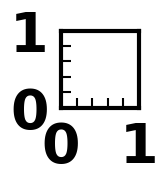

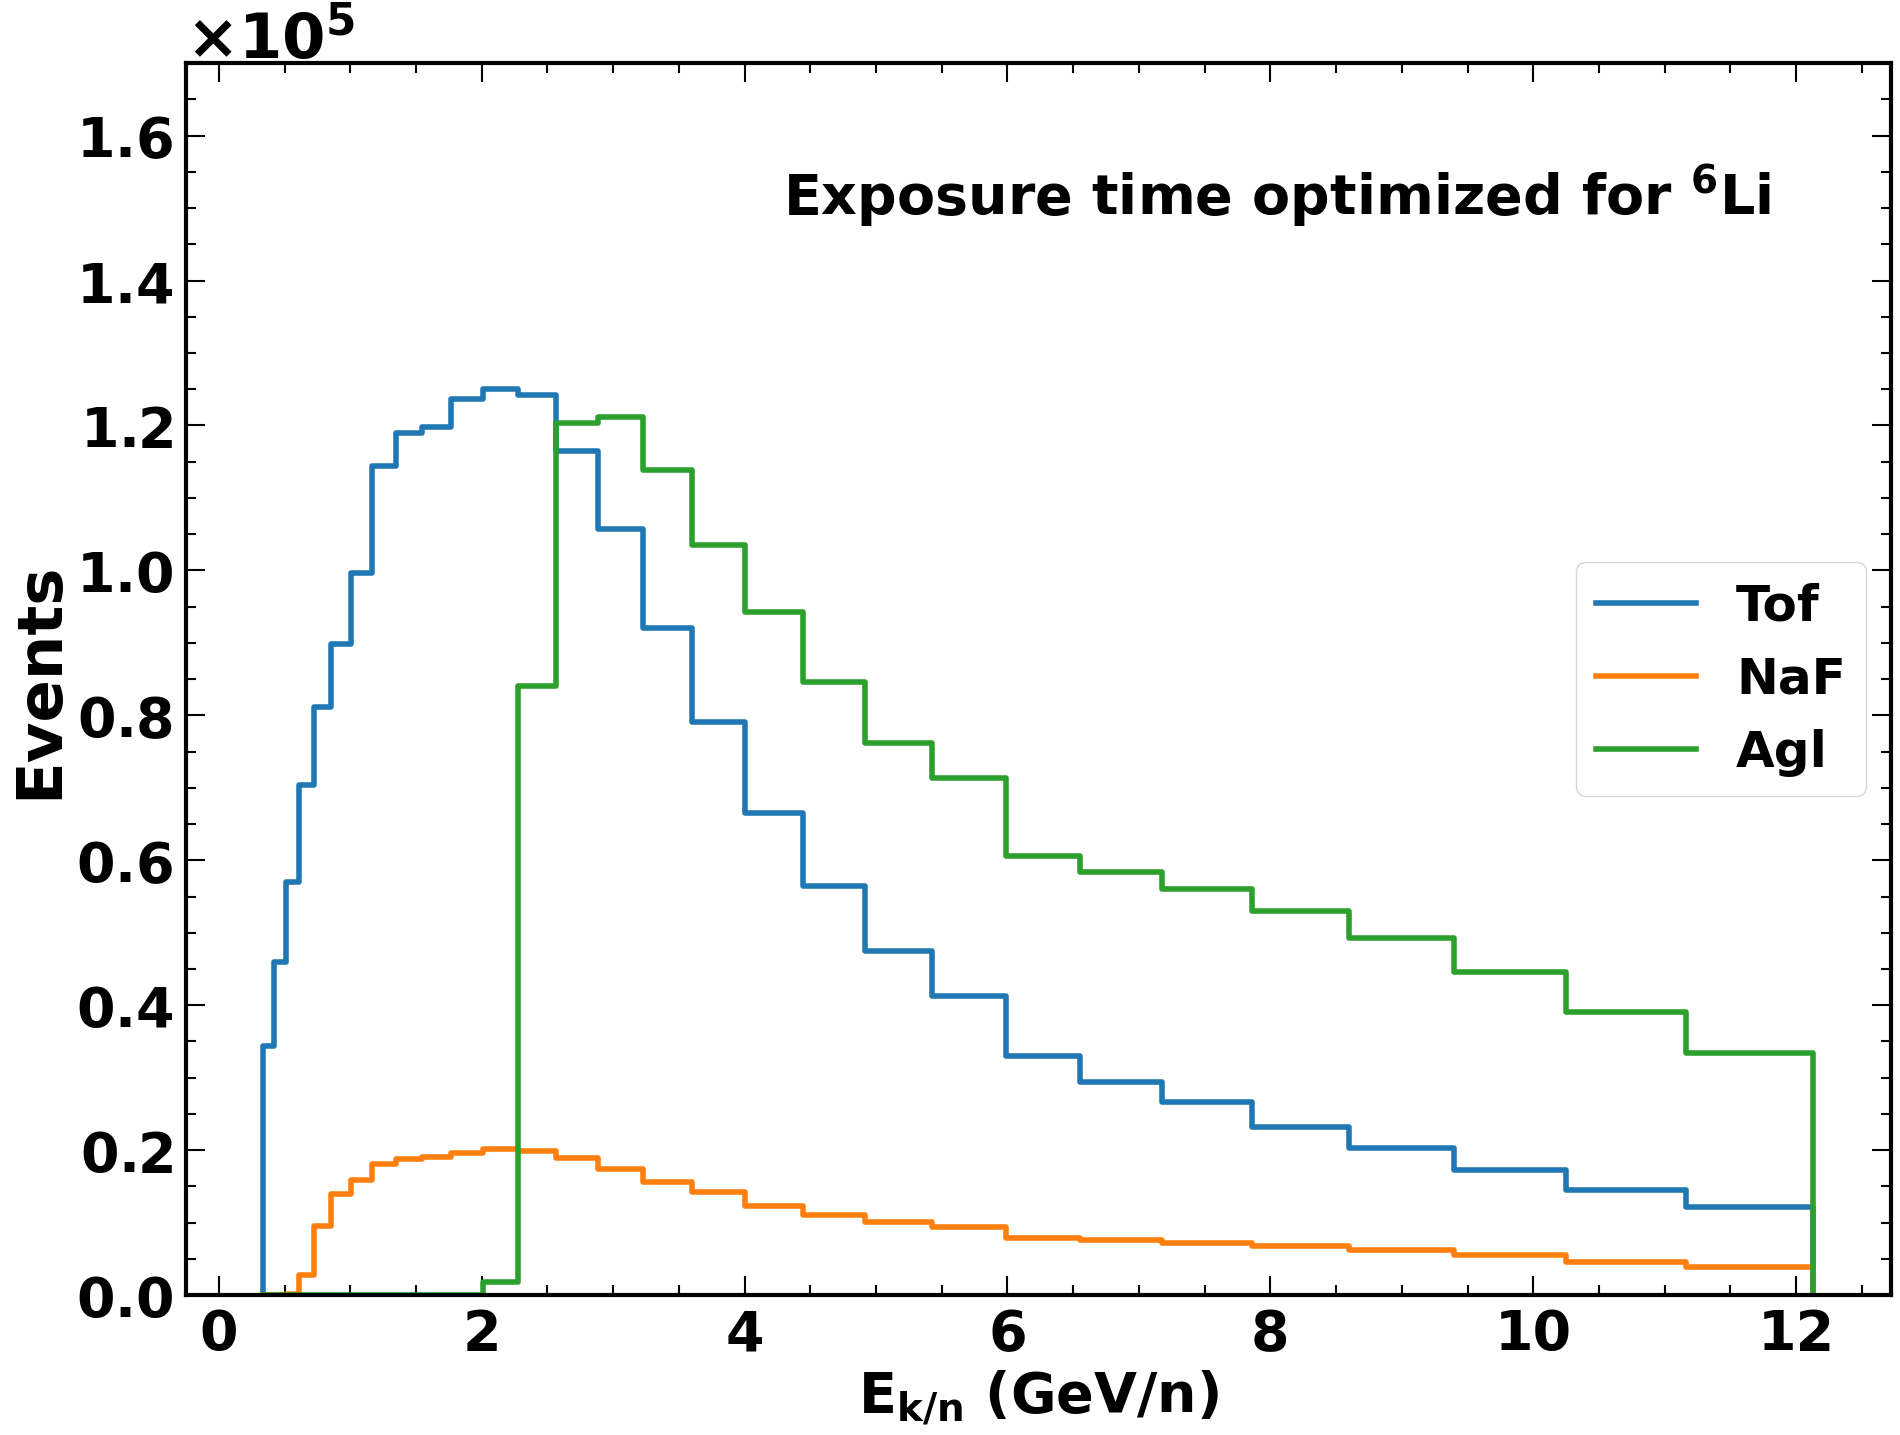

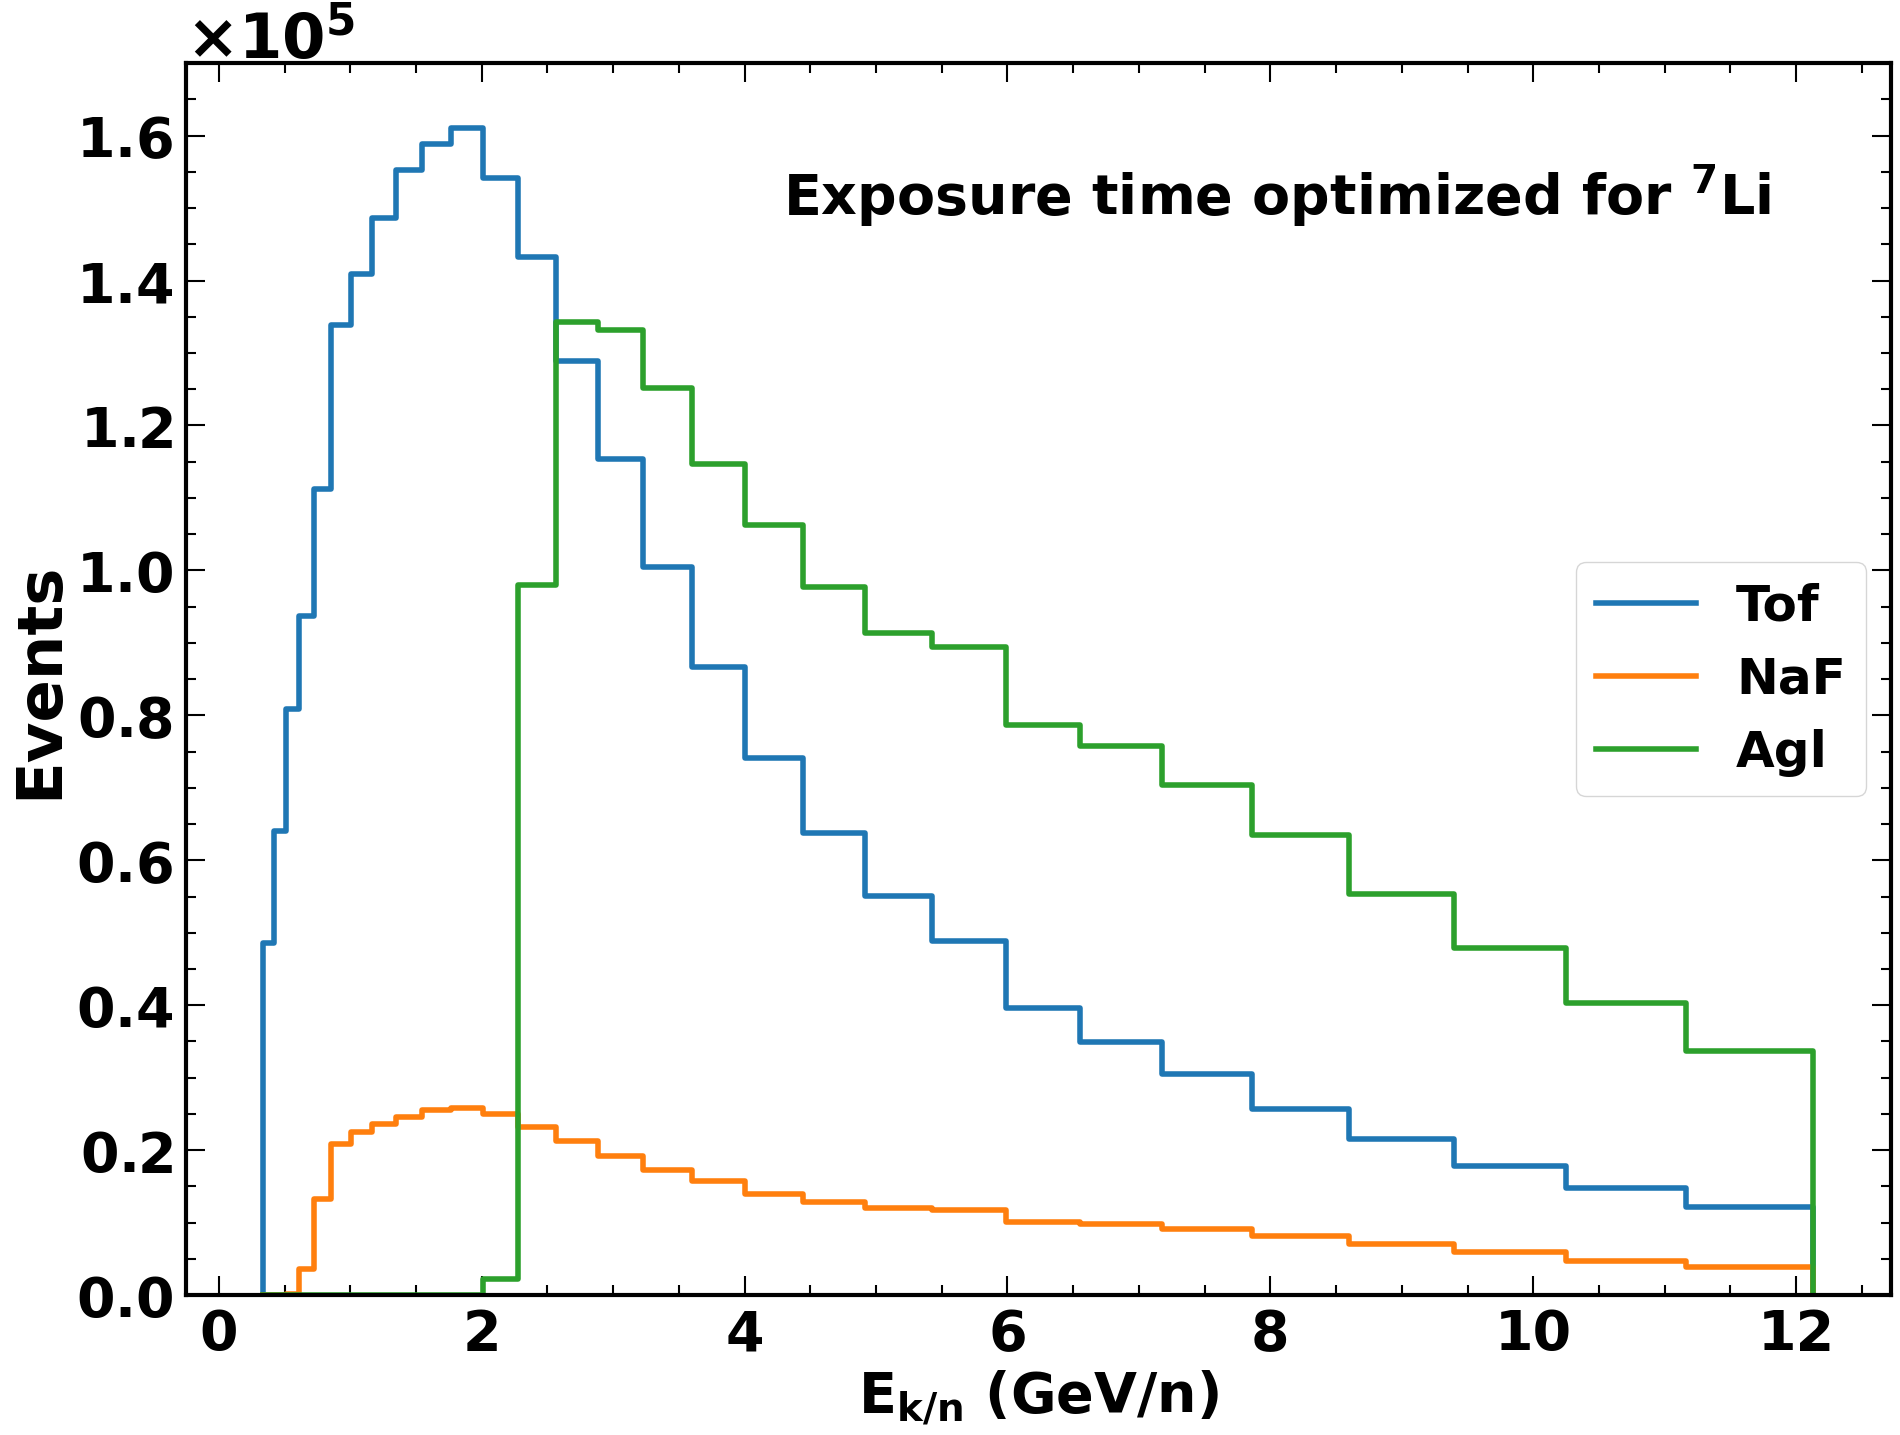

In [7]:
#file_histmass_data = '/home/manbing/Documents/Data/data_LiP8/Hist2D/LiISS_masshist_EkinP8GBL_Rebin.npz'
file_histmass_data = '/home/manbing/Documents/Data/data_LiP8/Hist2D/LiISS_Ekin_P8GBL_FineBin_NoTofEdge.npz'
dfc = np.load(f'{file_histmass_data}')
hist_counts = {dec: {} for dec in detectors}

for dec in detectors:
    figure, ax1 = plt.subplots(1, 1, figsize=FIGSIZE3)
    print(FIGSIZE3)
    for iso in isotopes:
        hist_counts[dec][iso] = Histogram.from_file(dfc, f'hist_{nuclei}_{dec}Opt{iso}_counts')   
        plot_histogram_1d(ax1, hist_counts[dec][iso], style="mc", color=ISOTOPES_COLOR[iso], label=f'Optimized {iso}', scale=None, gamma=None, xlog=False, ylog=False, shade_errors=False, setscilabely=True, show_overflow=False)
        print(dec, 'Opt:', iso, np.sum(hist_counts[dec][iso].values))
    ax1.legend(fontsize=23)
    ax1.text(0.5, 0.95, f'{dec}', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black')
    #ax1.set_ylim([0, 1.1*max(hist_counts[dec]['Be7'].values)])
    ax1.set_xlim([0.5, 12.0])
    savefig_tofile(figure, plotdir, f"data_stat_{dec}_{fig_suffix}", show=False)
    
    
fig, ax1 = plt.subplots(1, 1, figsize=(1,1))
set_plot_style(ax1)
for iso in isotopes:
    figure, ax1 = plt.subplots(1, 1, figsize=FIGSIZE3)
    for dec in detectors:
    #figure, ax1 = plt.subplots(1, 1, figsize=FIGSIZE3)    
        hist_counts[dec][iso] = Histogram.from_file(dfc, f'hist_{nuclei}_{dec}Opt{iso}_counts')   
        plot_histogram_1d(ax1, hist_counts[dec][iso], style="mc", color=DETECTOR_COLOR[dec], label=f'{dec}', scale=None, gamma=None, xlog=False, ylog=False, shade_errors=False, setscilabely=True, show_overflow=False, linewidth=4)
        print(dec, 'Opt:', iso, np.sum(hist_counts[dec][iso].values[2:-1]))
    ax1.legend(loc='center right')
    ax1.text(0.35, 0.92, f"Exposure time optimized for {ISO_LABELS[iso]}", fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")              
    #ax1.text(0.5, 0.95, f'{dec}', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black')
    ax1.set_ylim([0, 1.7*10**5])
    set_plot_style(ax1)
    ax1.set_xlabel(r"$\mathrm{E_{k/n} \ (GeV/n)}$", fontsize=40) 
                          
    print(plotdir)
    savefig_tofile(figure, plotdir, f"{nuclei}data_stat_alldec_Opt{iso}", show=True)


/home/manbing/Documents/lithiumanalysis/slides/plots/LiP8/fitDataB1308_finebin_meanfree
/home/manbing/Documents/lithiumanalysis/slides/plots/LiP8/fitDataB1308_finebin_meanfree
/home/manbing/Documents/lithiumanalysis/slides/plots/LiP8/fitDataB1308_finebin_meanfree
/home/manbing/Documents/lithiumanalysis/slides/plots/LiP8/fitDataB1308_finebin_meanfree
/home/manbing/Documents/lithiumanalysis/slides/plots/LiP8/fitDataB1308_finebin_meanfree
/home/manbing/Documents/lithiumanalysis/slides/plots/LiP8/fitDataB1308_finebin_meanfree

xvalues			yvalues			yerrs
0.44778			1.0163559427737248			0.09450691270341935
0.538415			1.0140529065417858			0.07416119227801773
0.64103			1.046086314776107			0.07581628995022616
0.7578670000000001			1.0318257875161527			0.06294461925492591
0.8890595			1.089016682789516			0.04543665743563793


xvalues			yvalues			yerrs
0.8890595			1.0420860439228066			0.03780525731016062
1.0347455			0.9728673064521849			0.027630677295619133
1.197125			0.9936080141630692			0.023082739

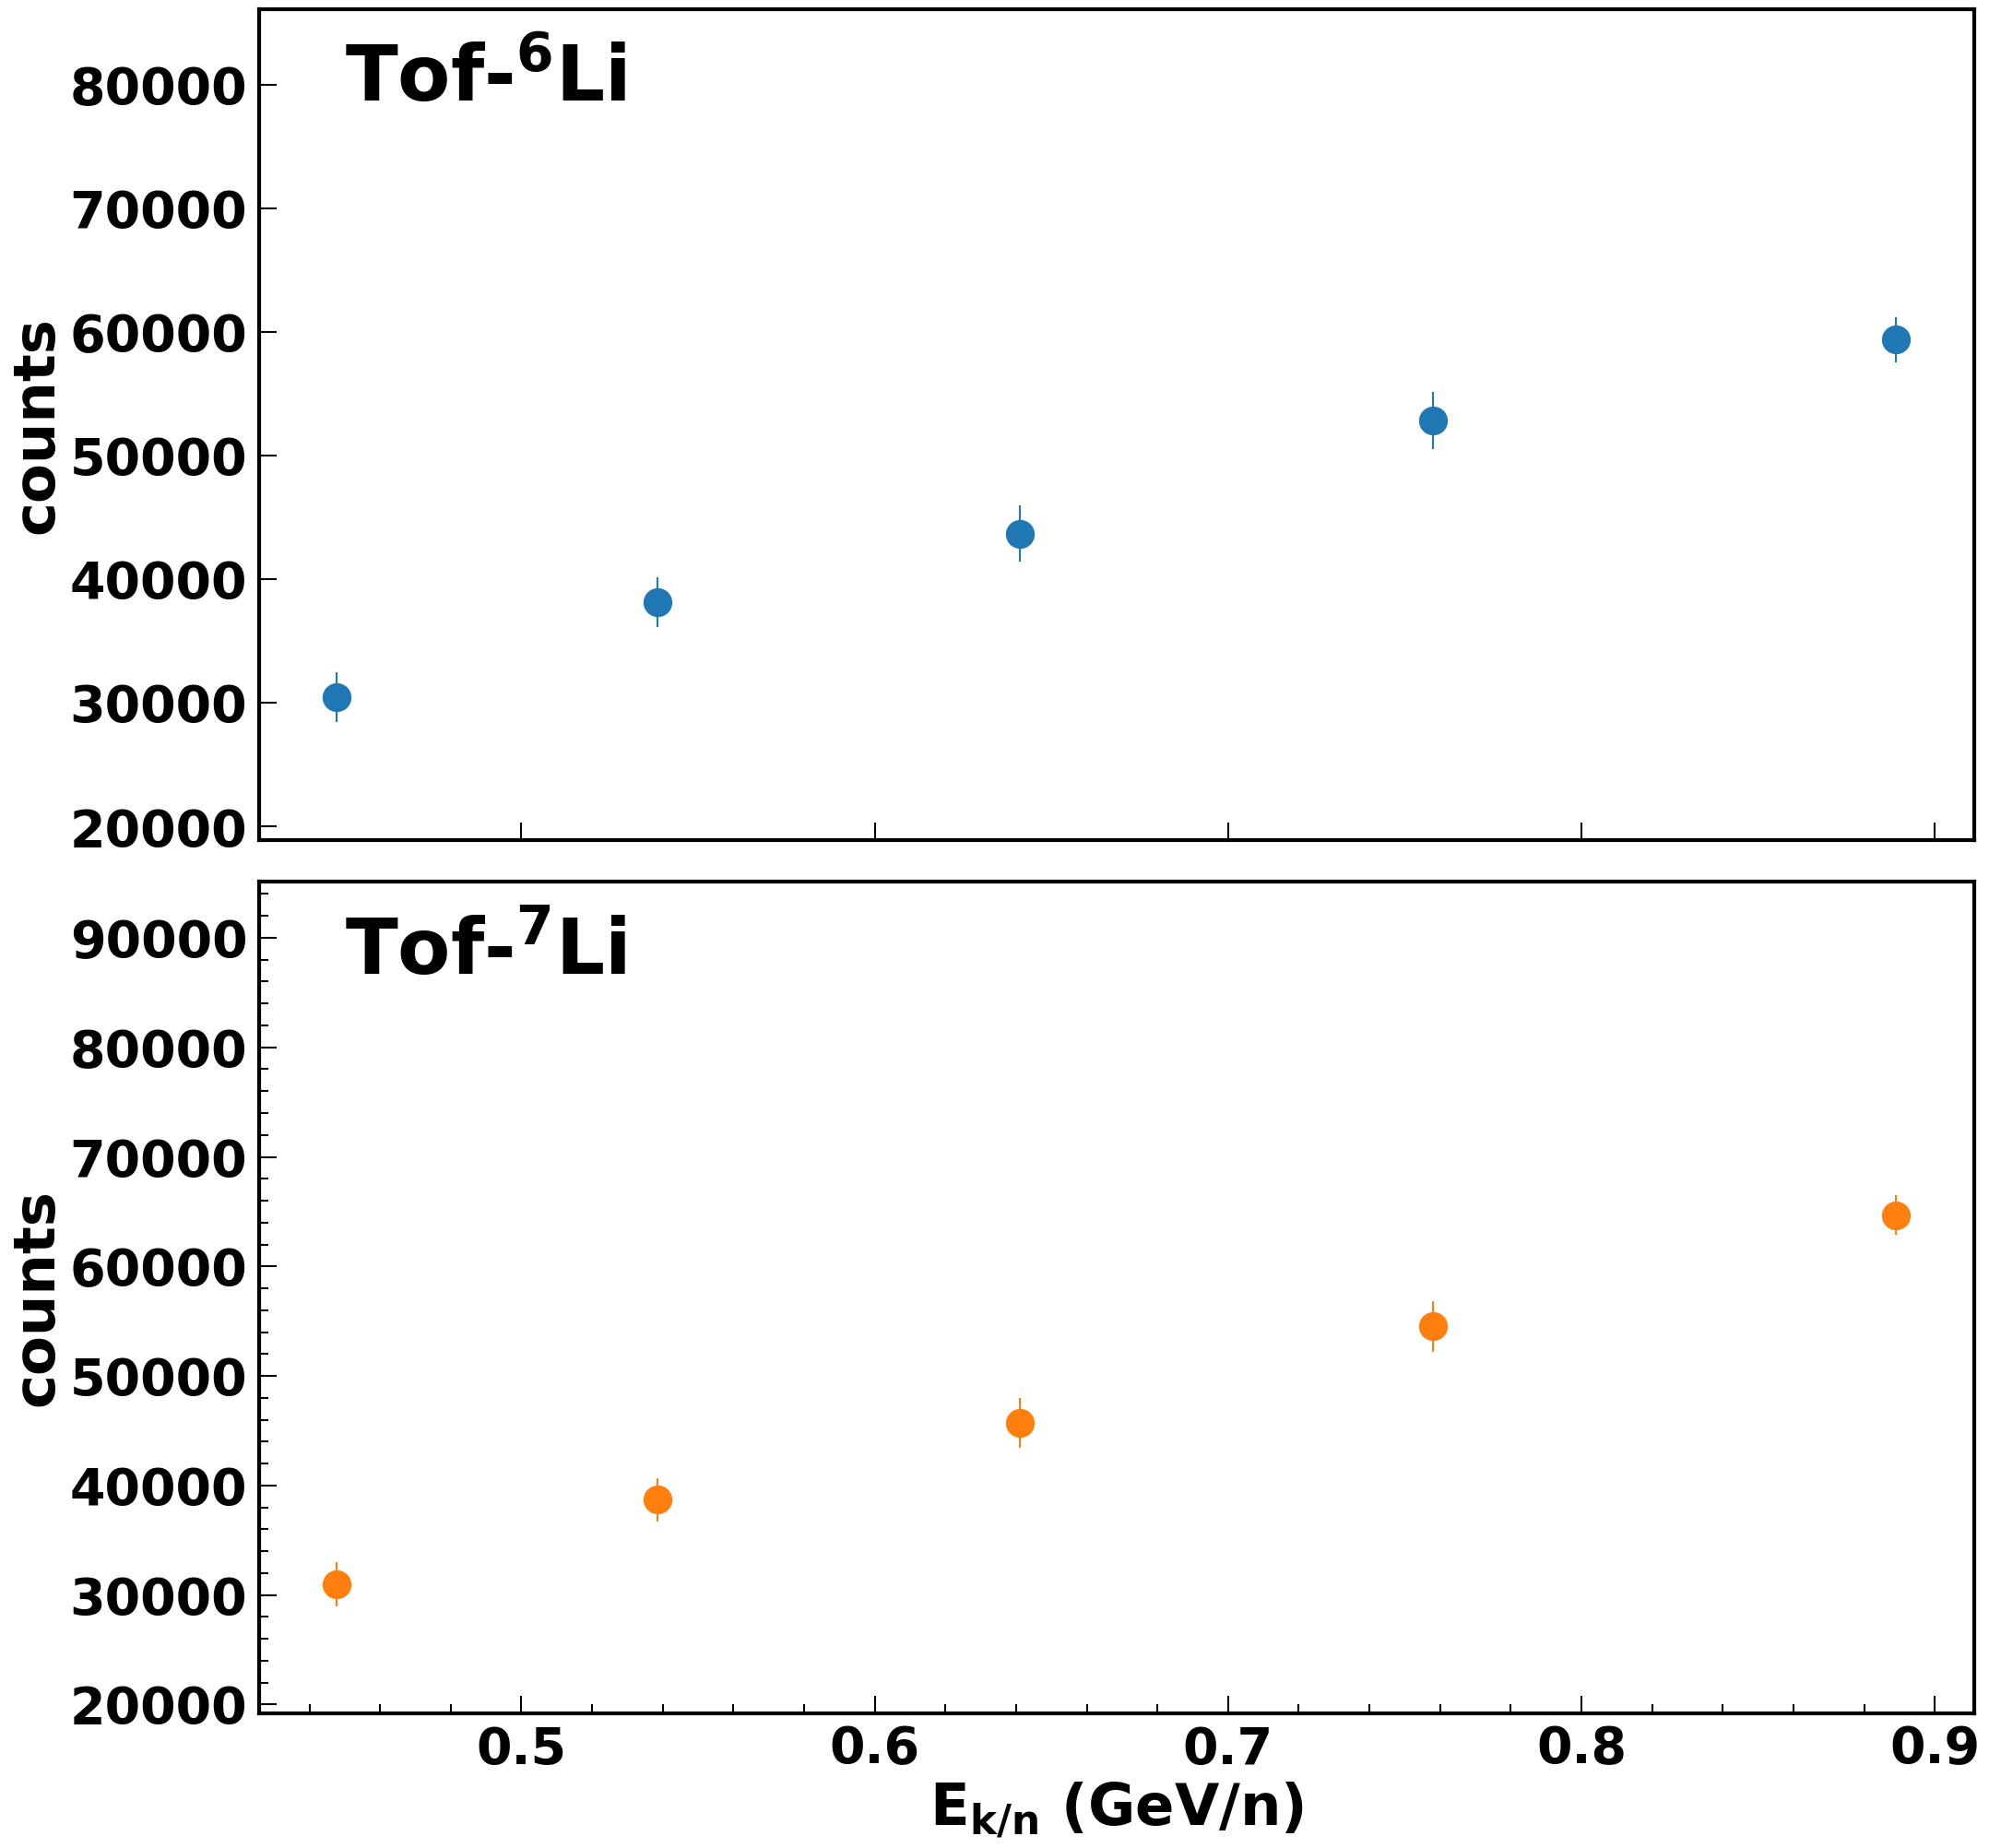

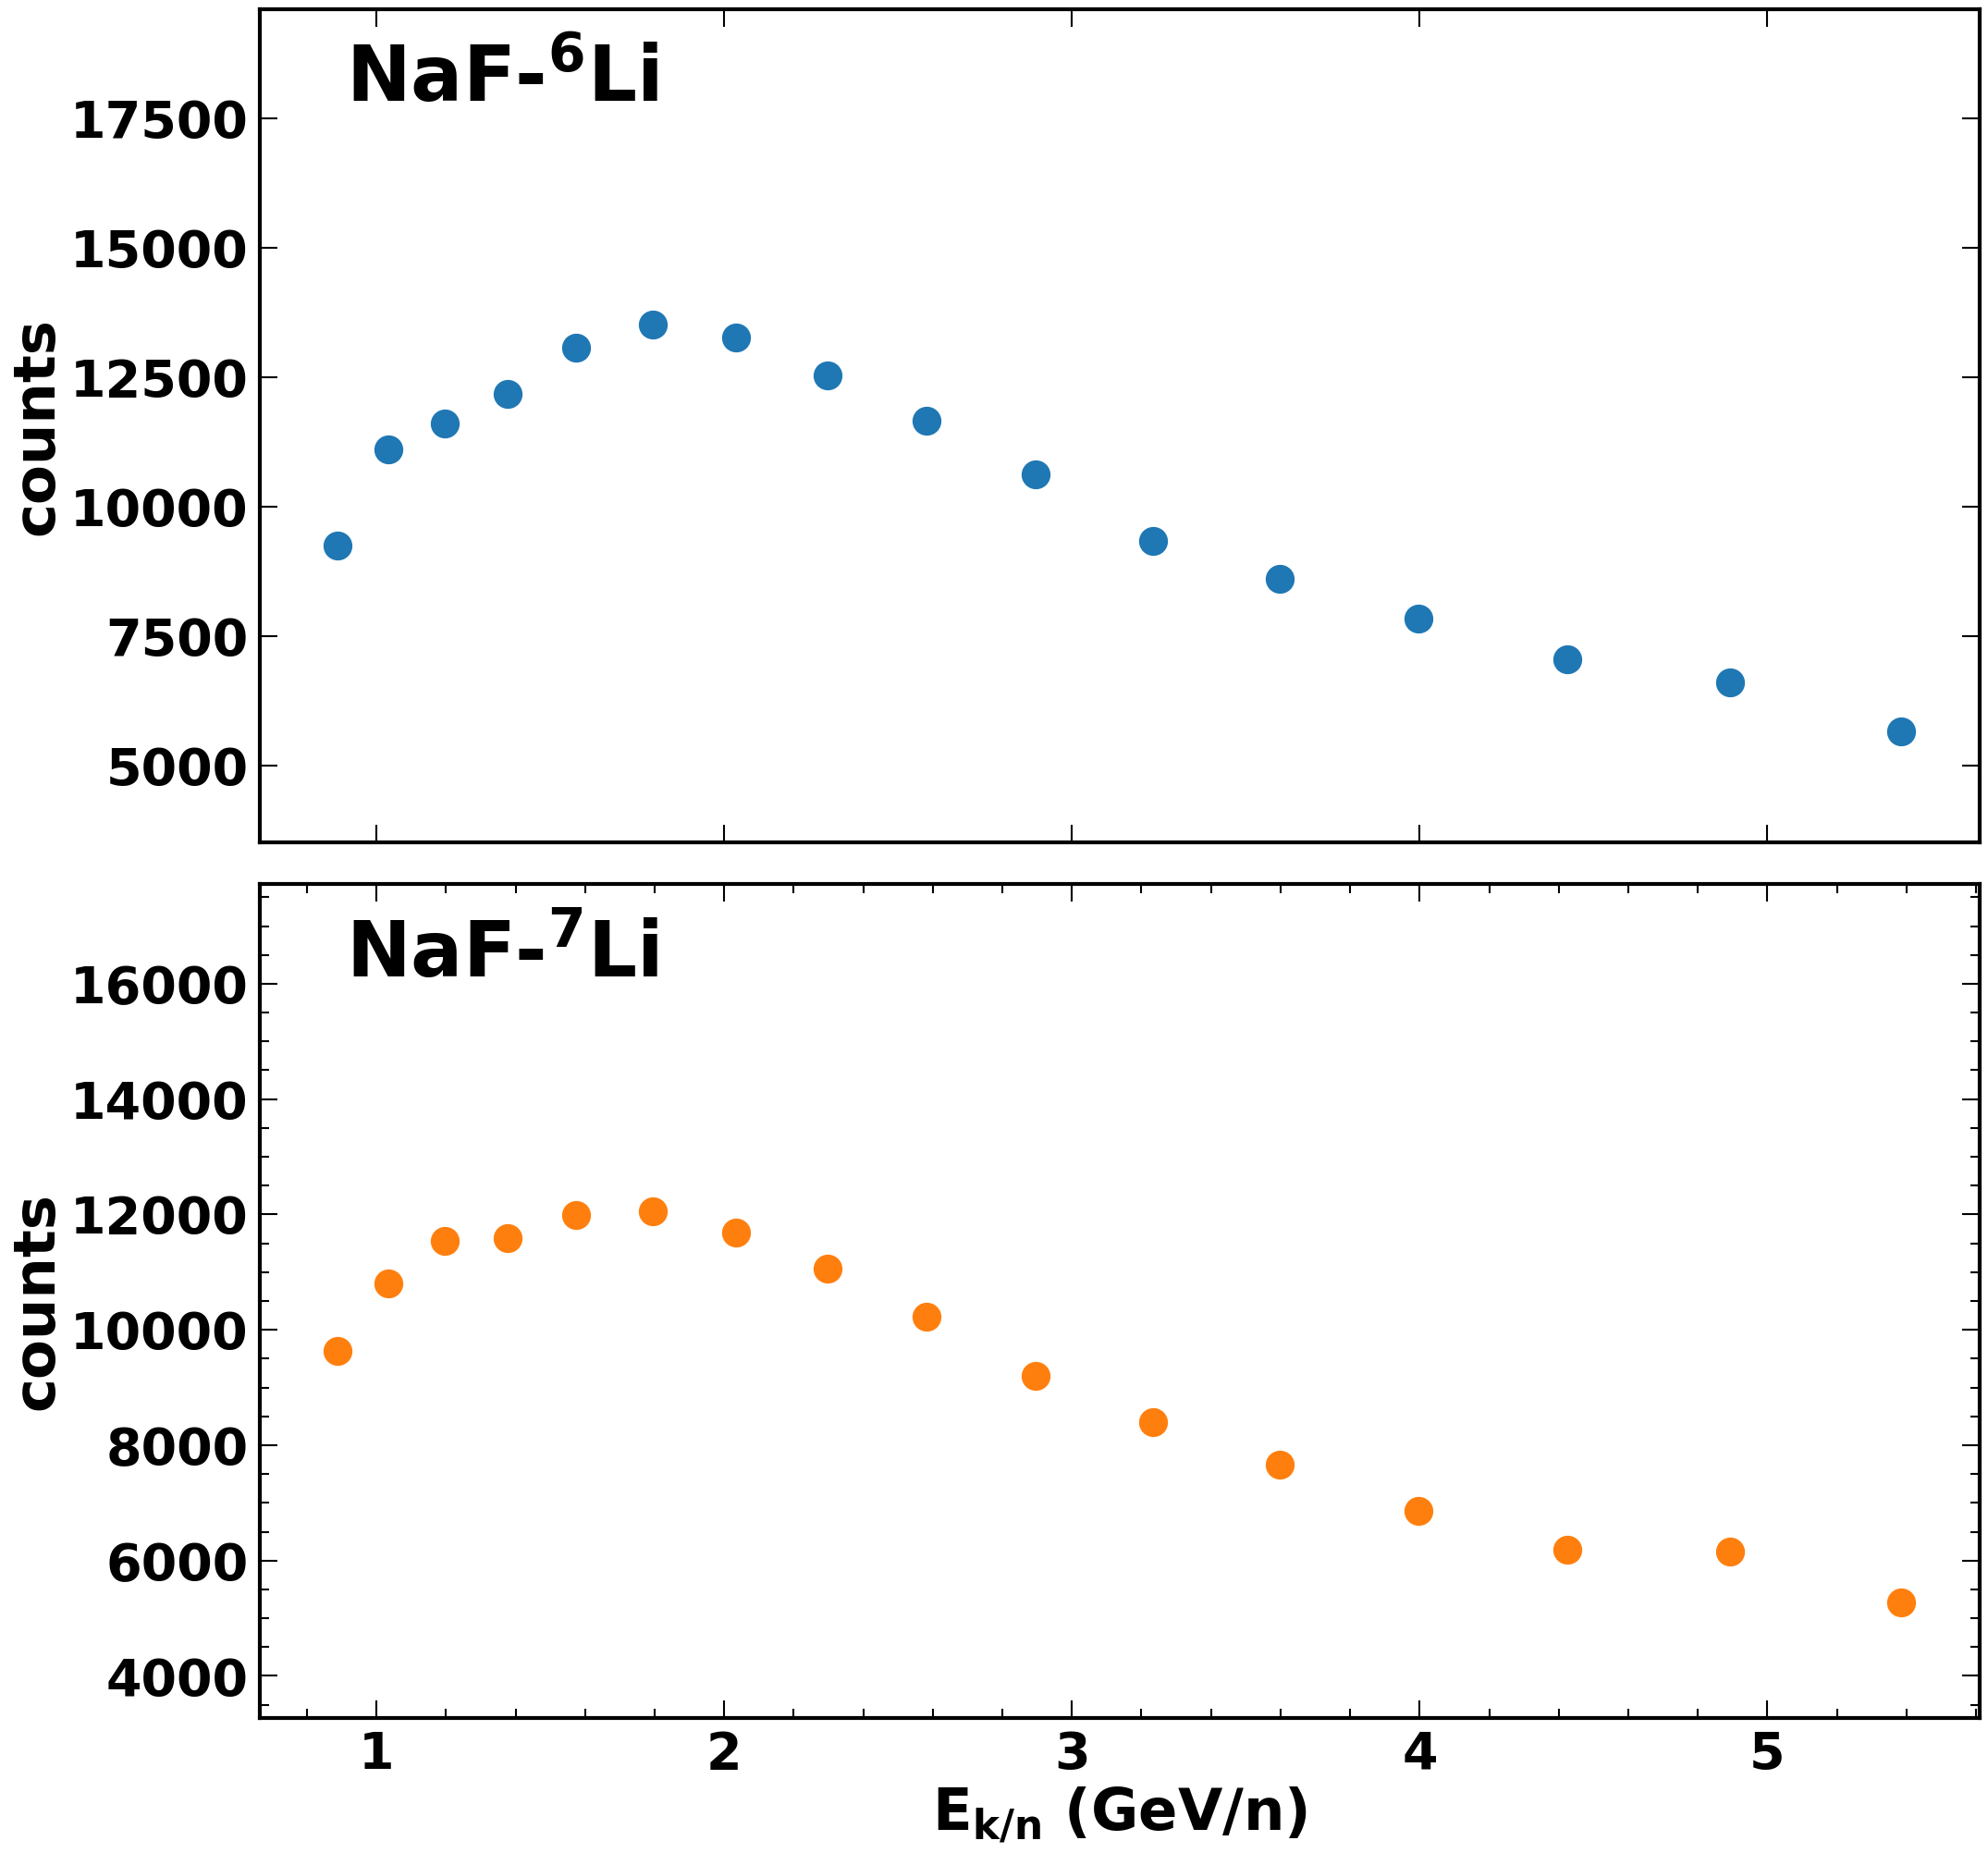

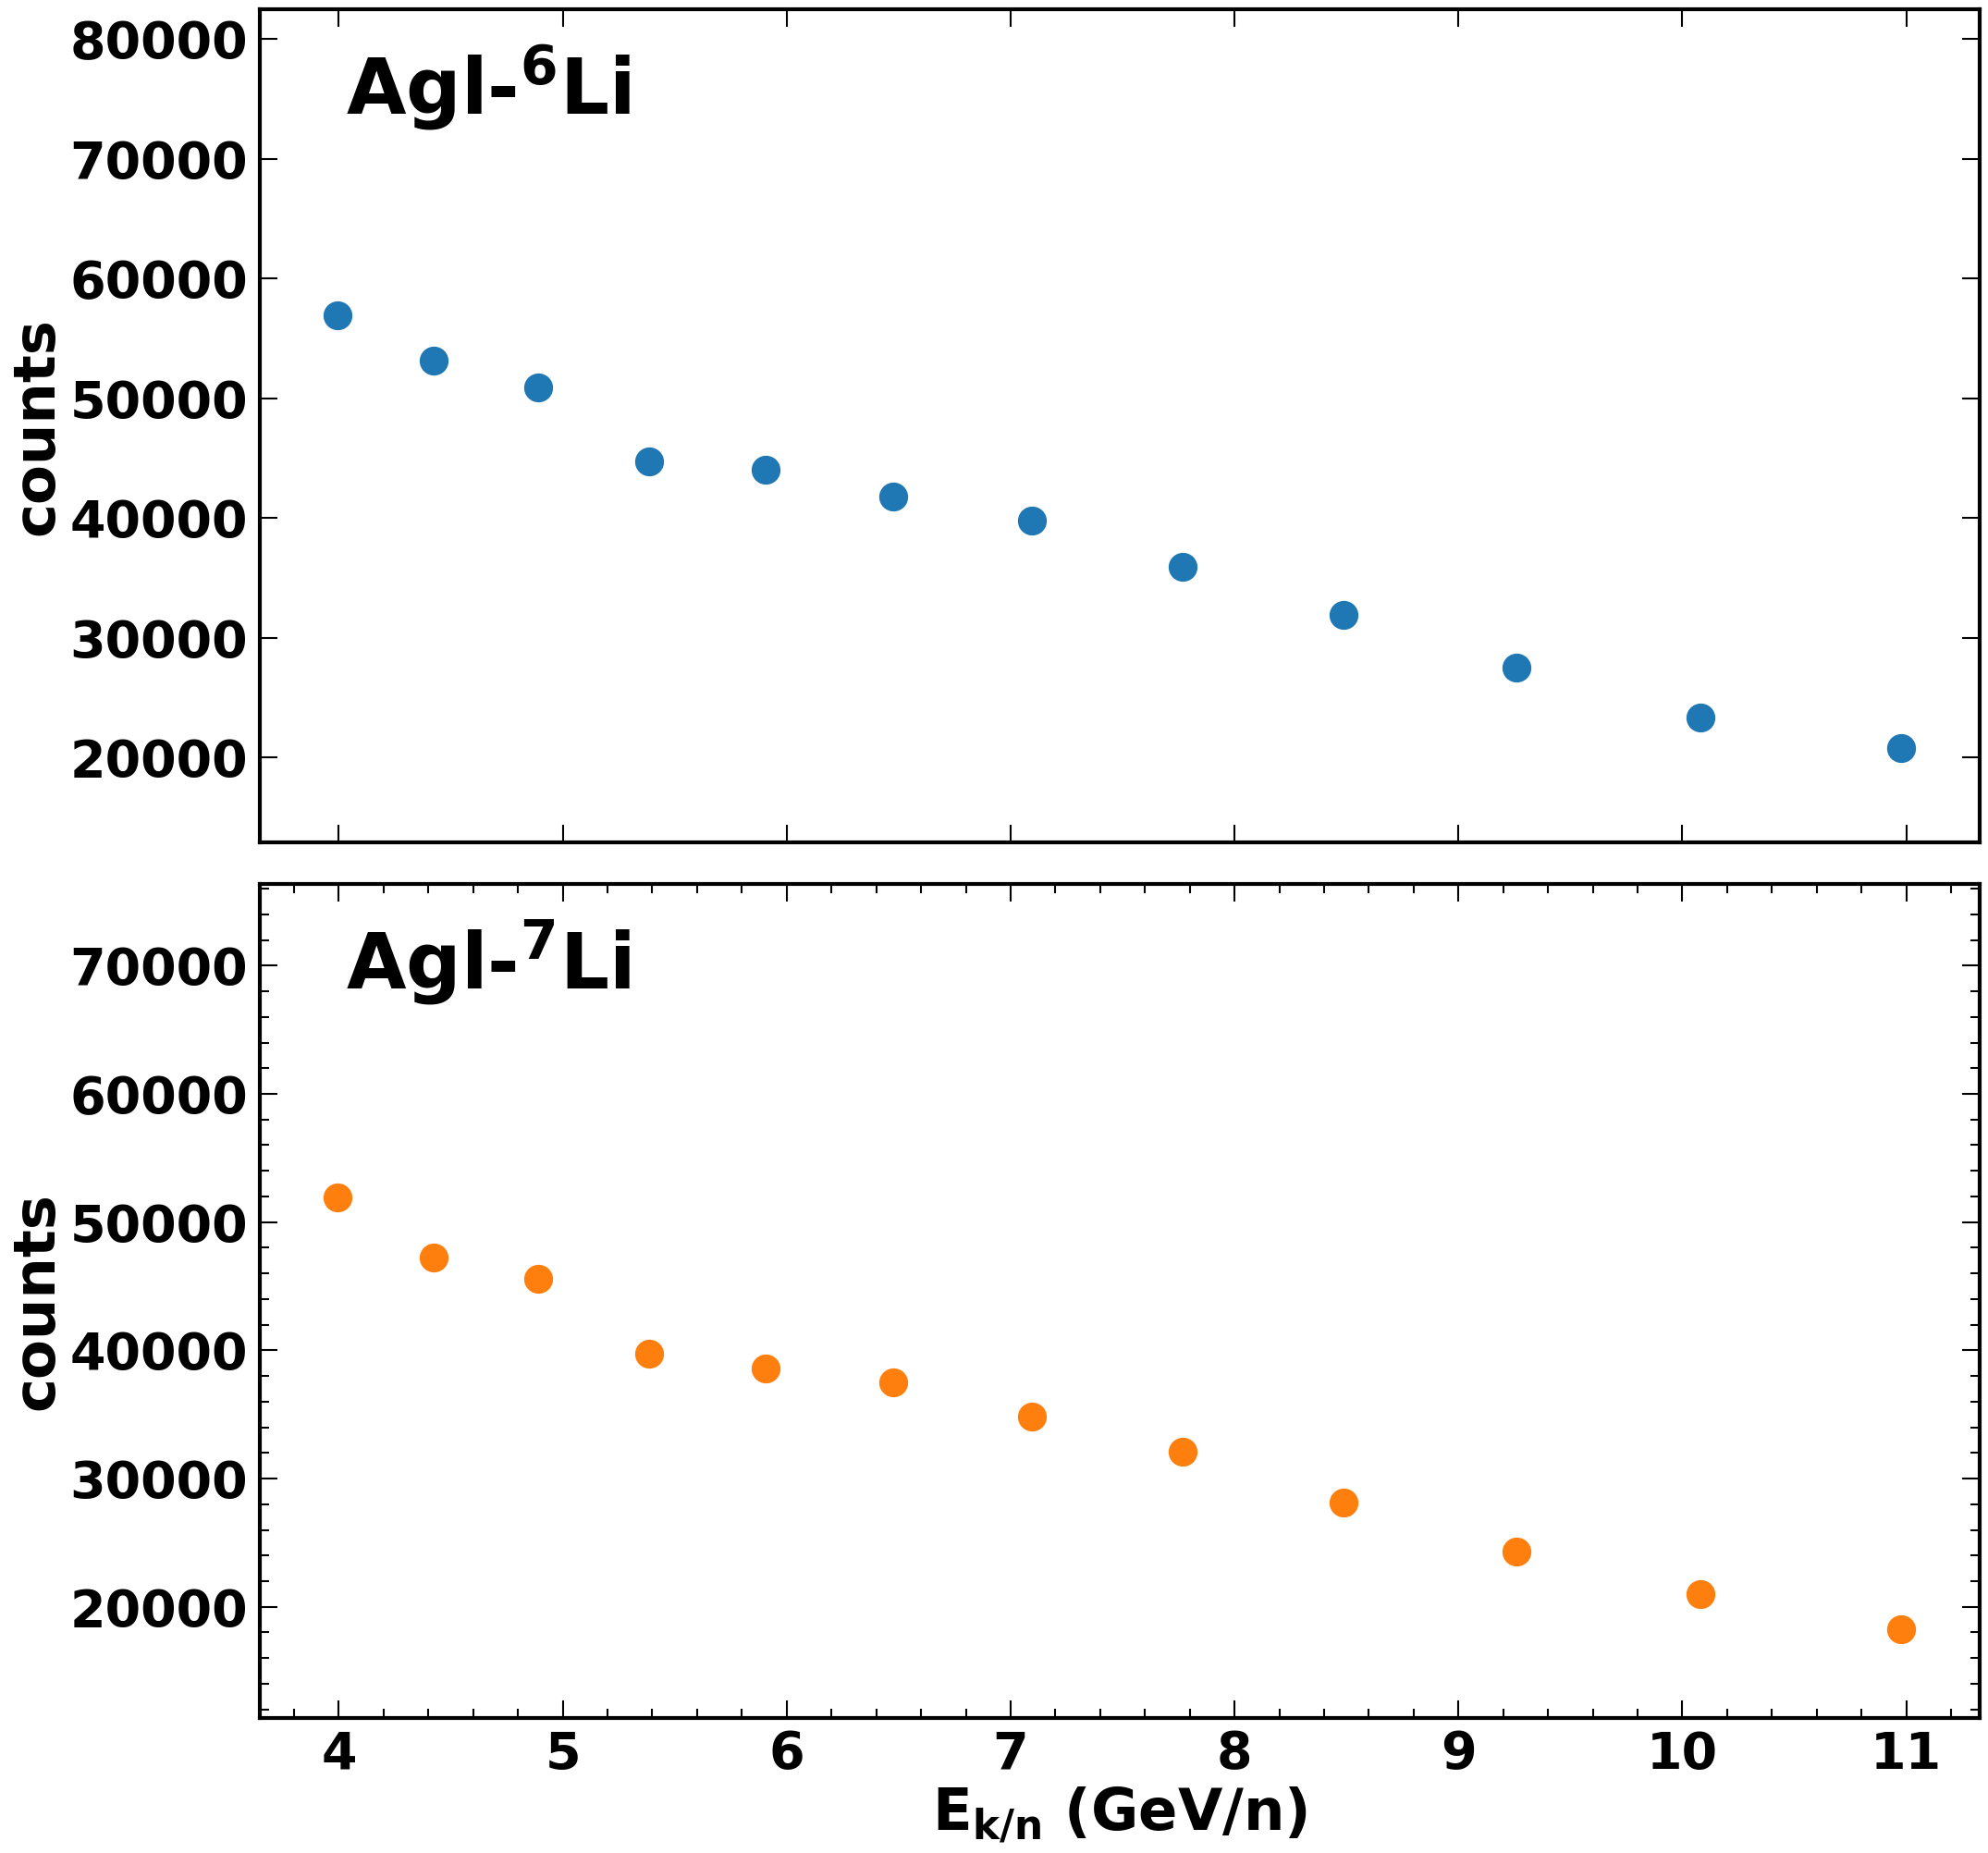

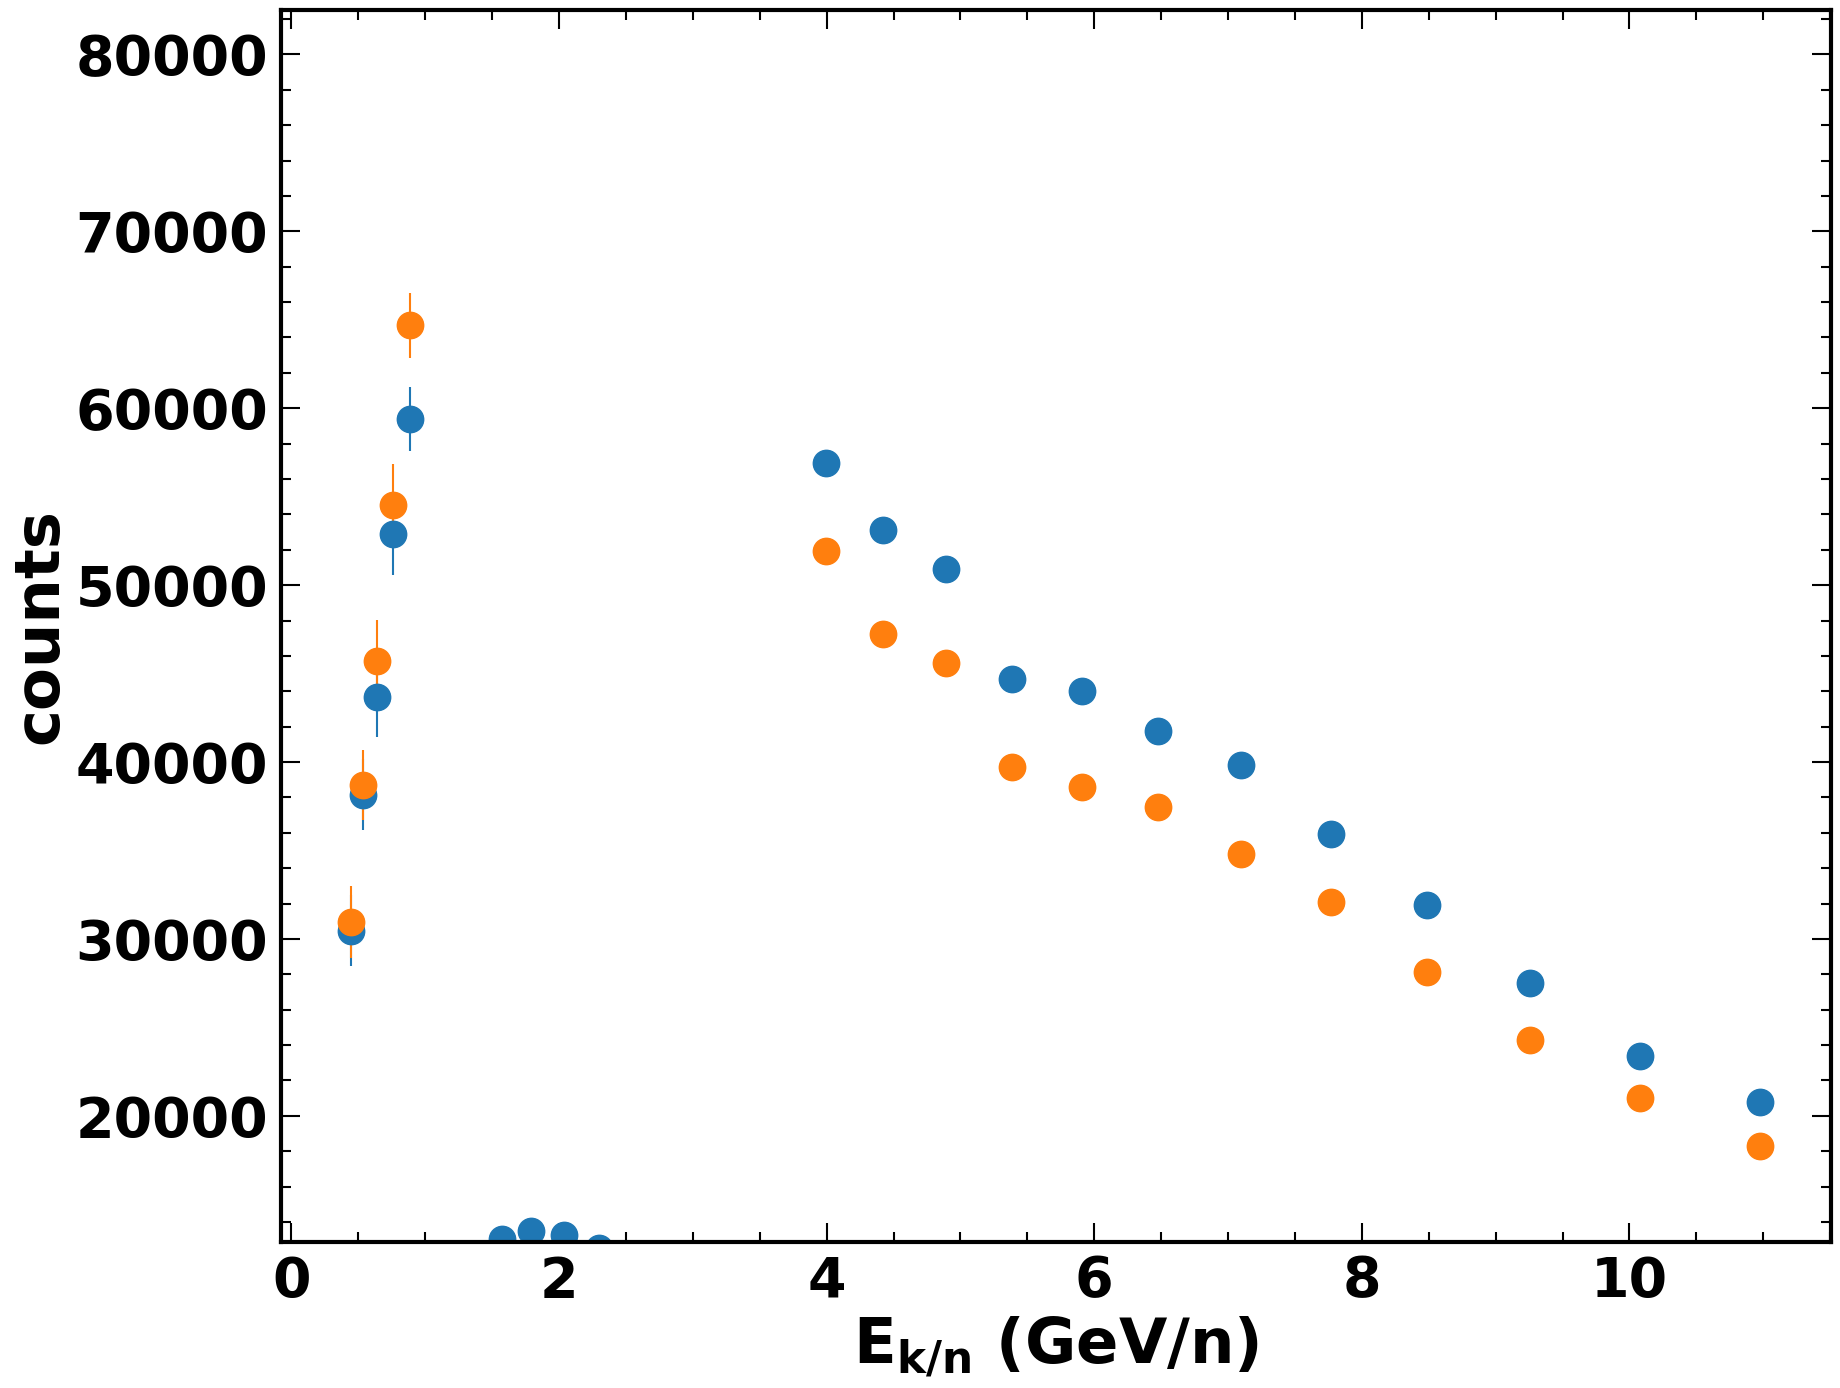

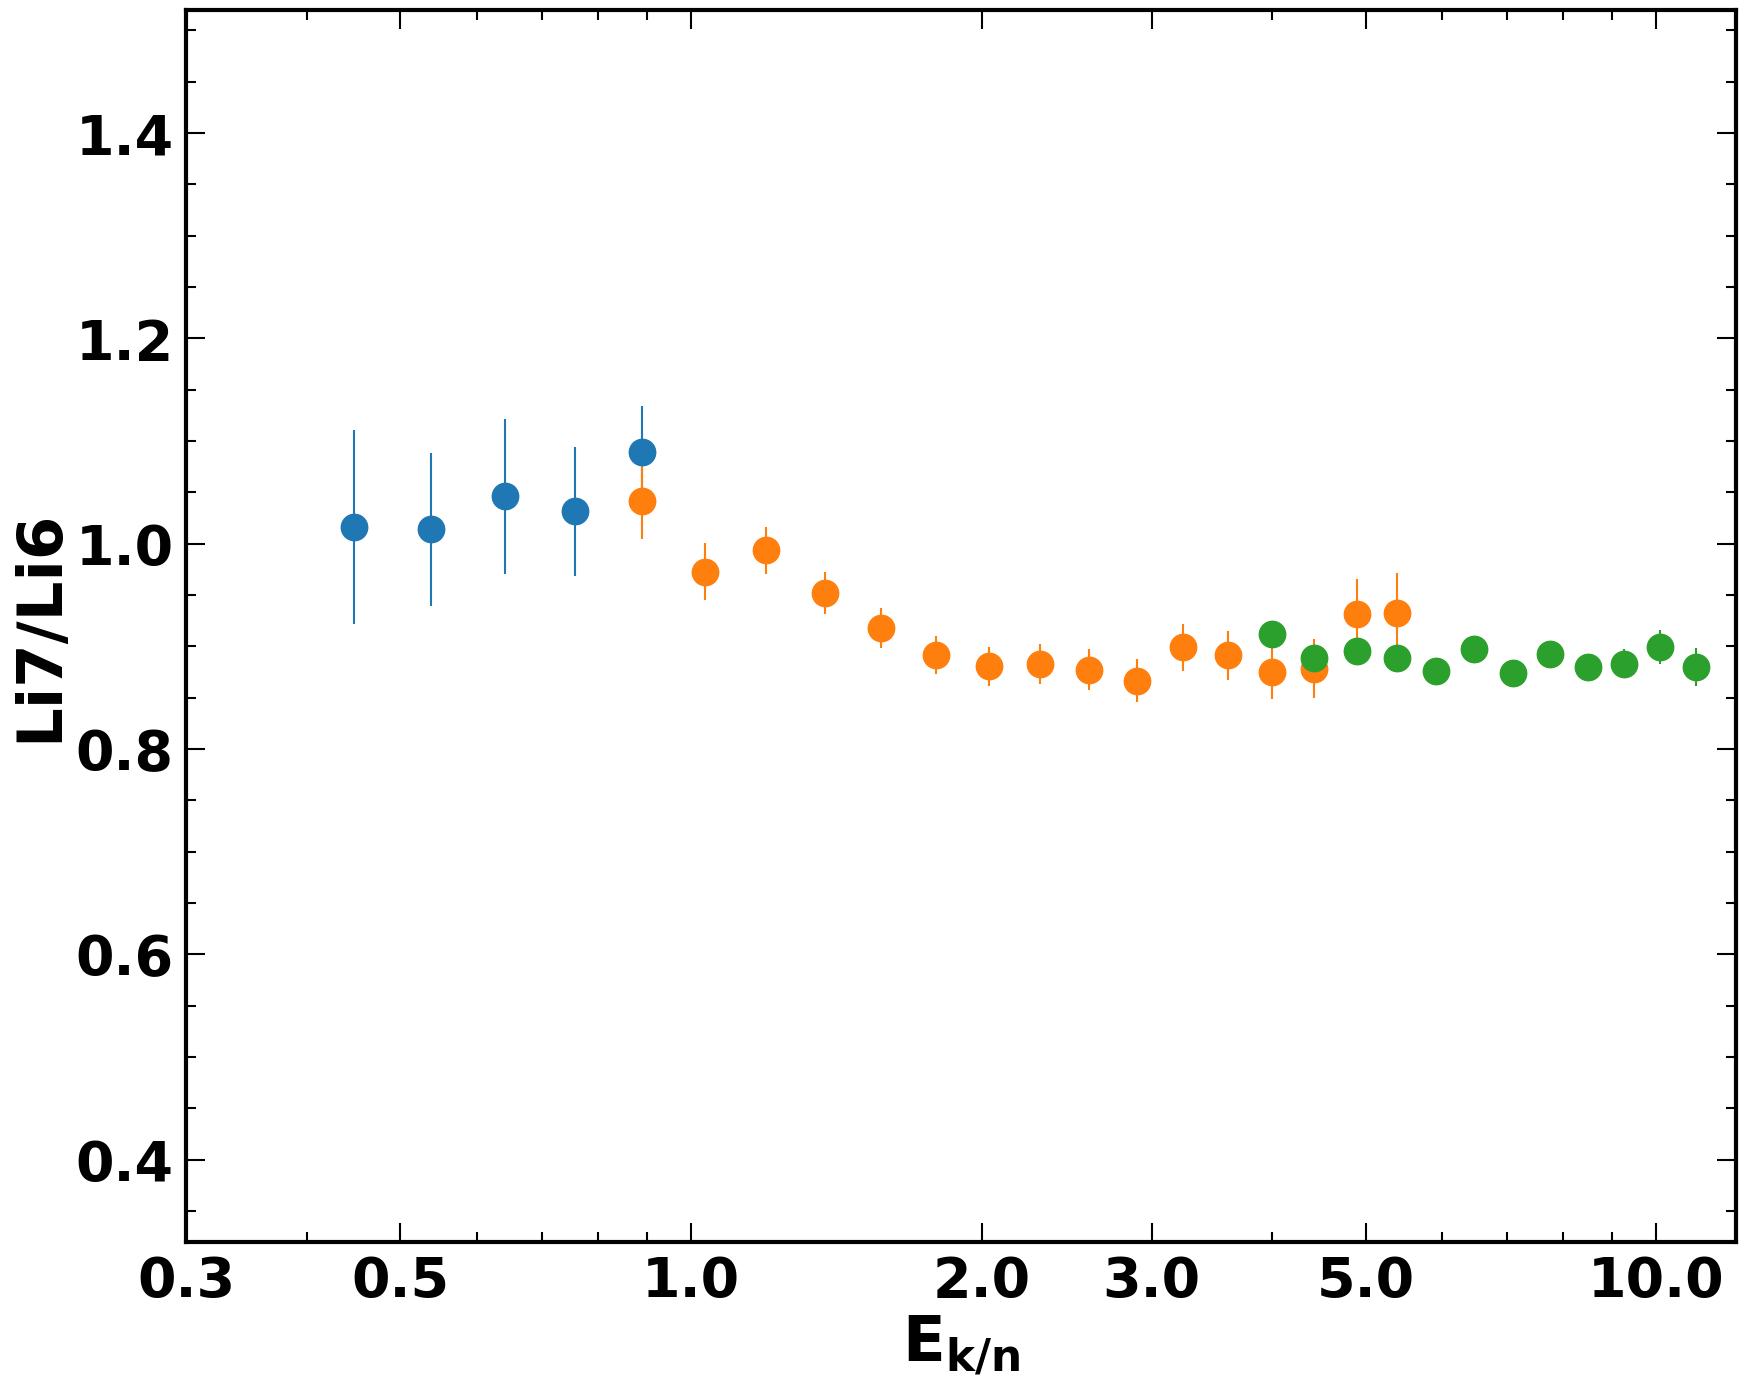

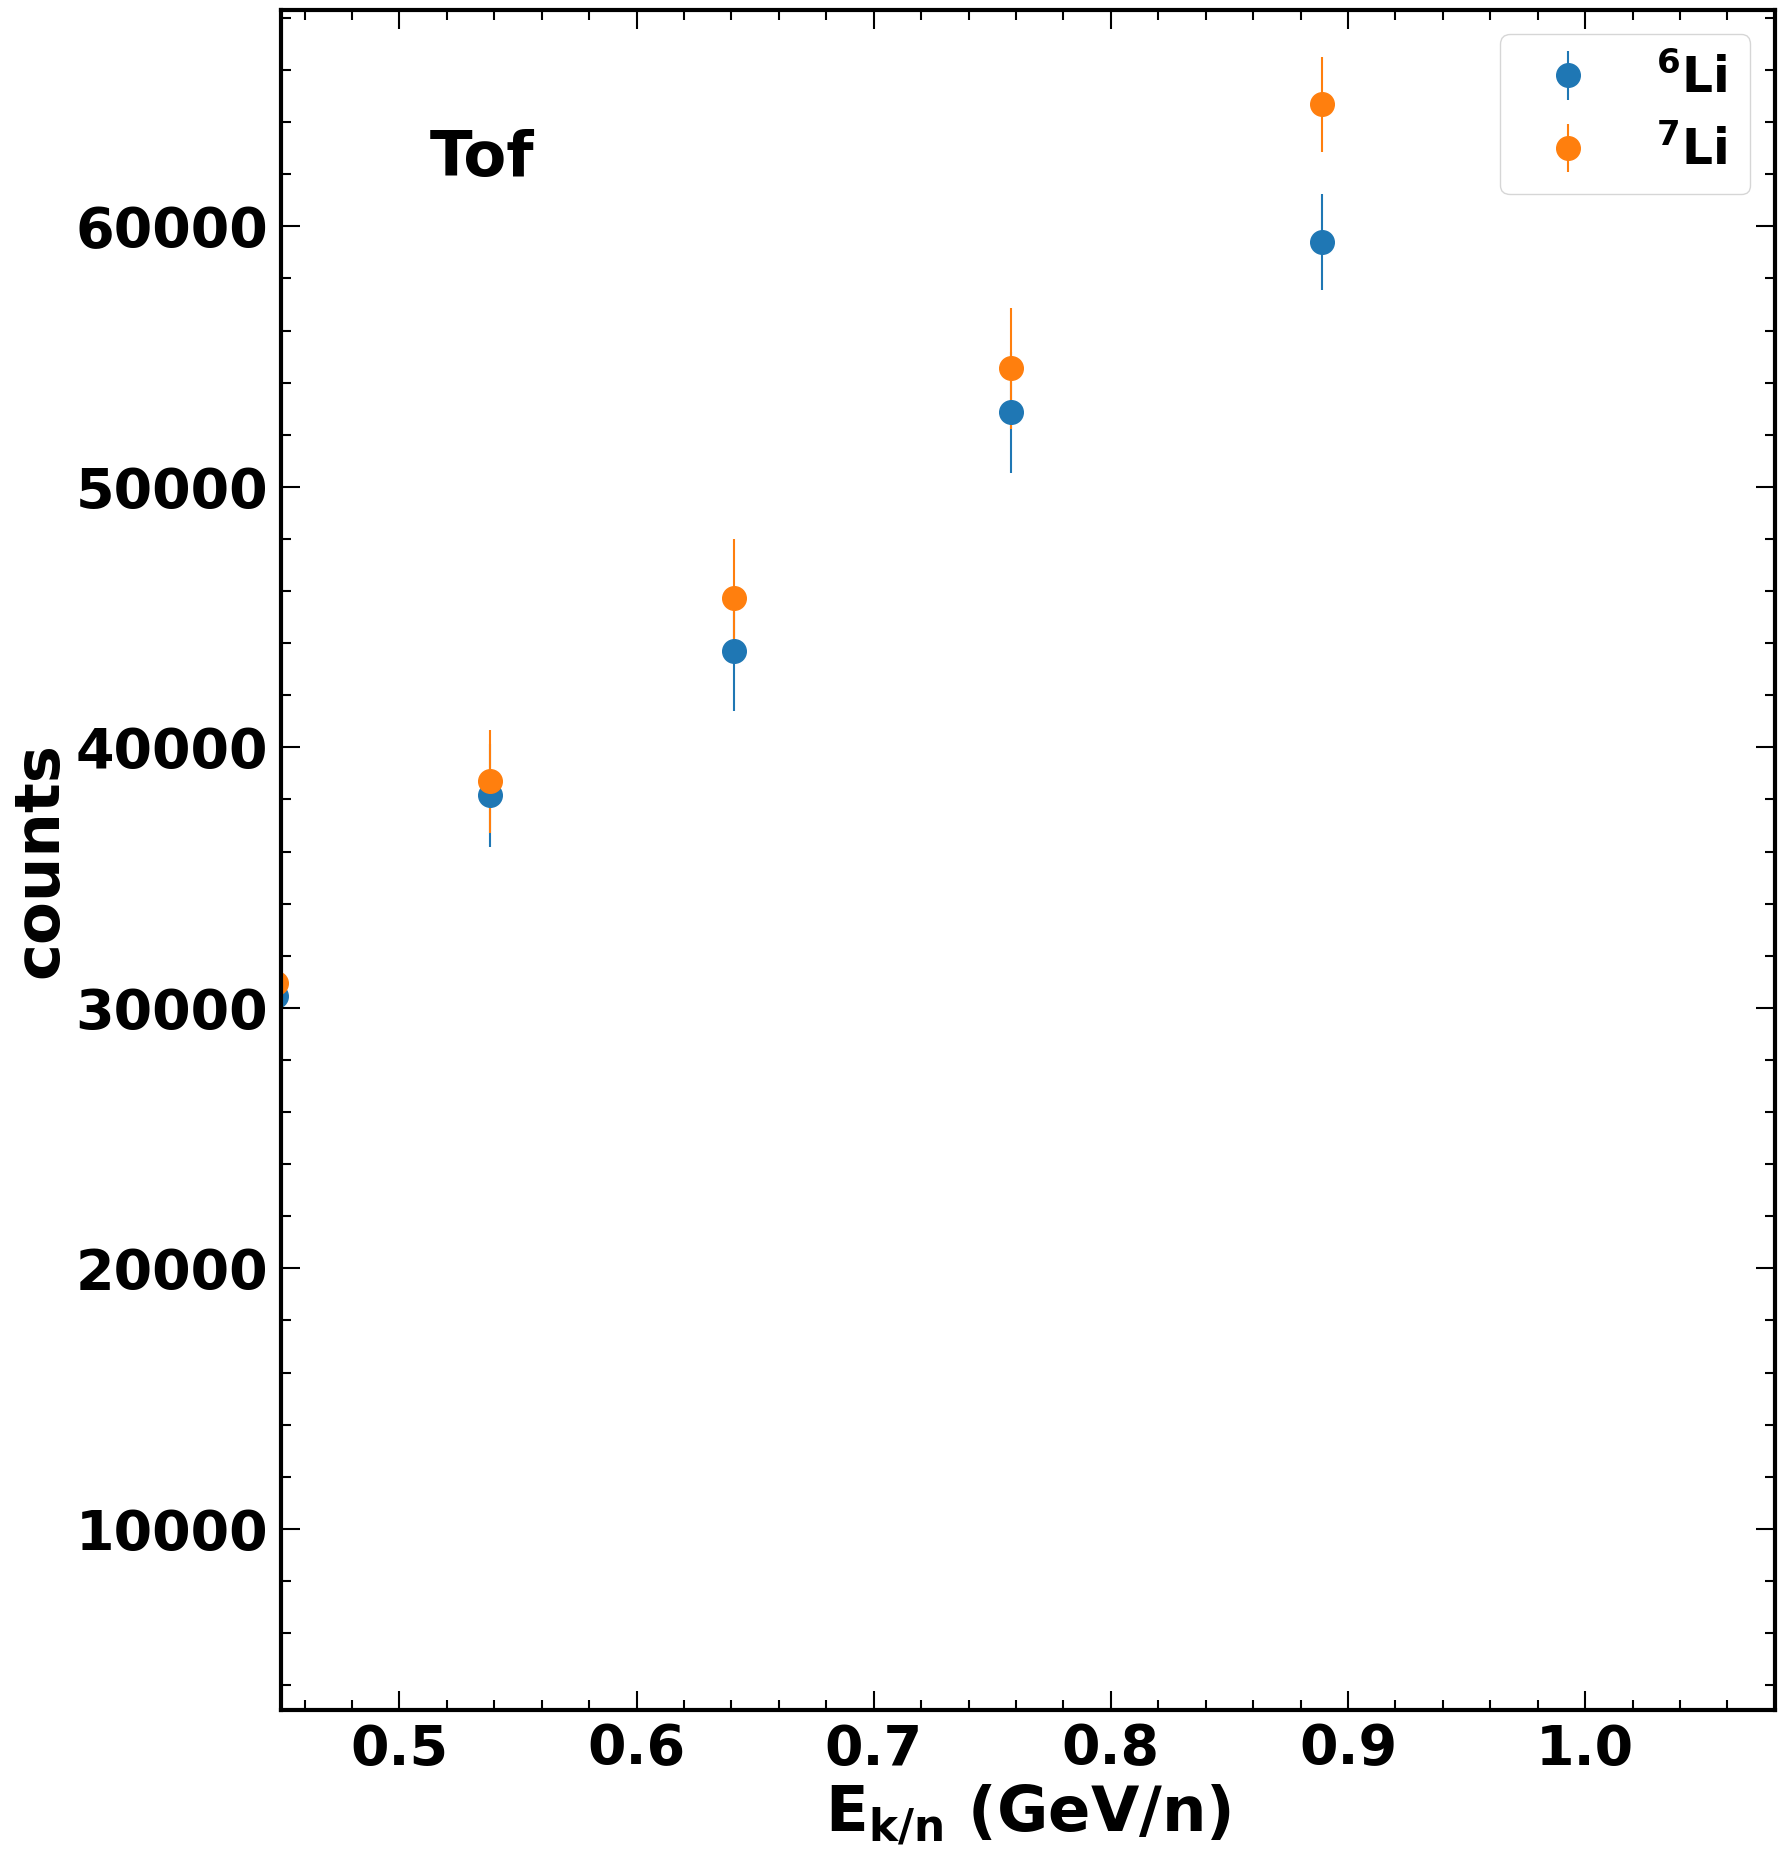

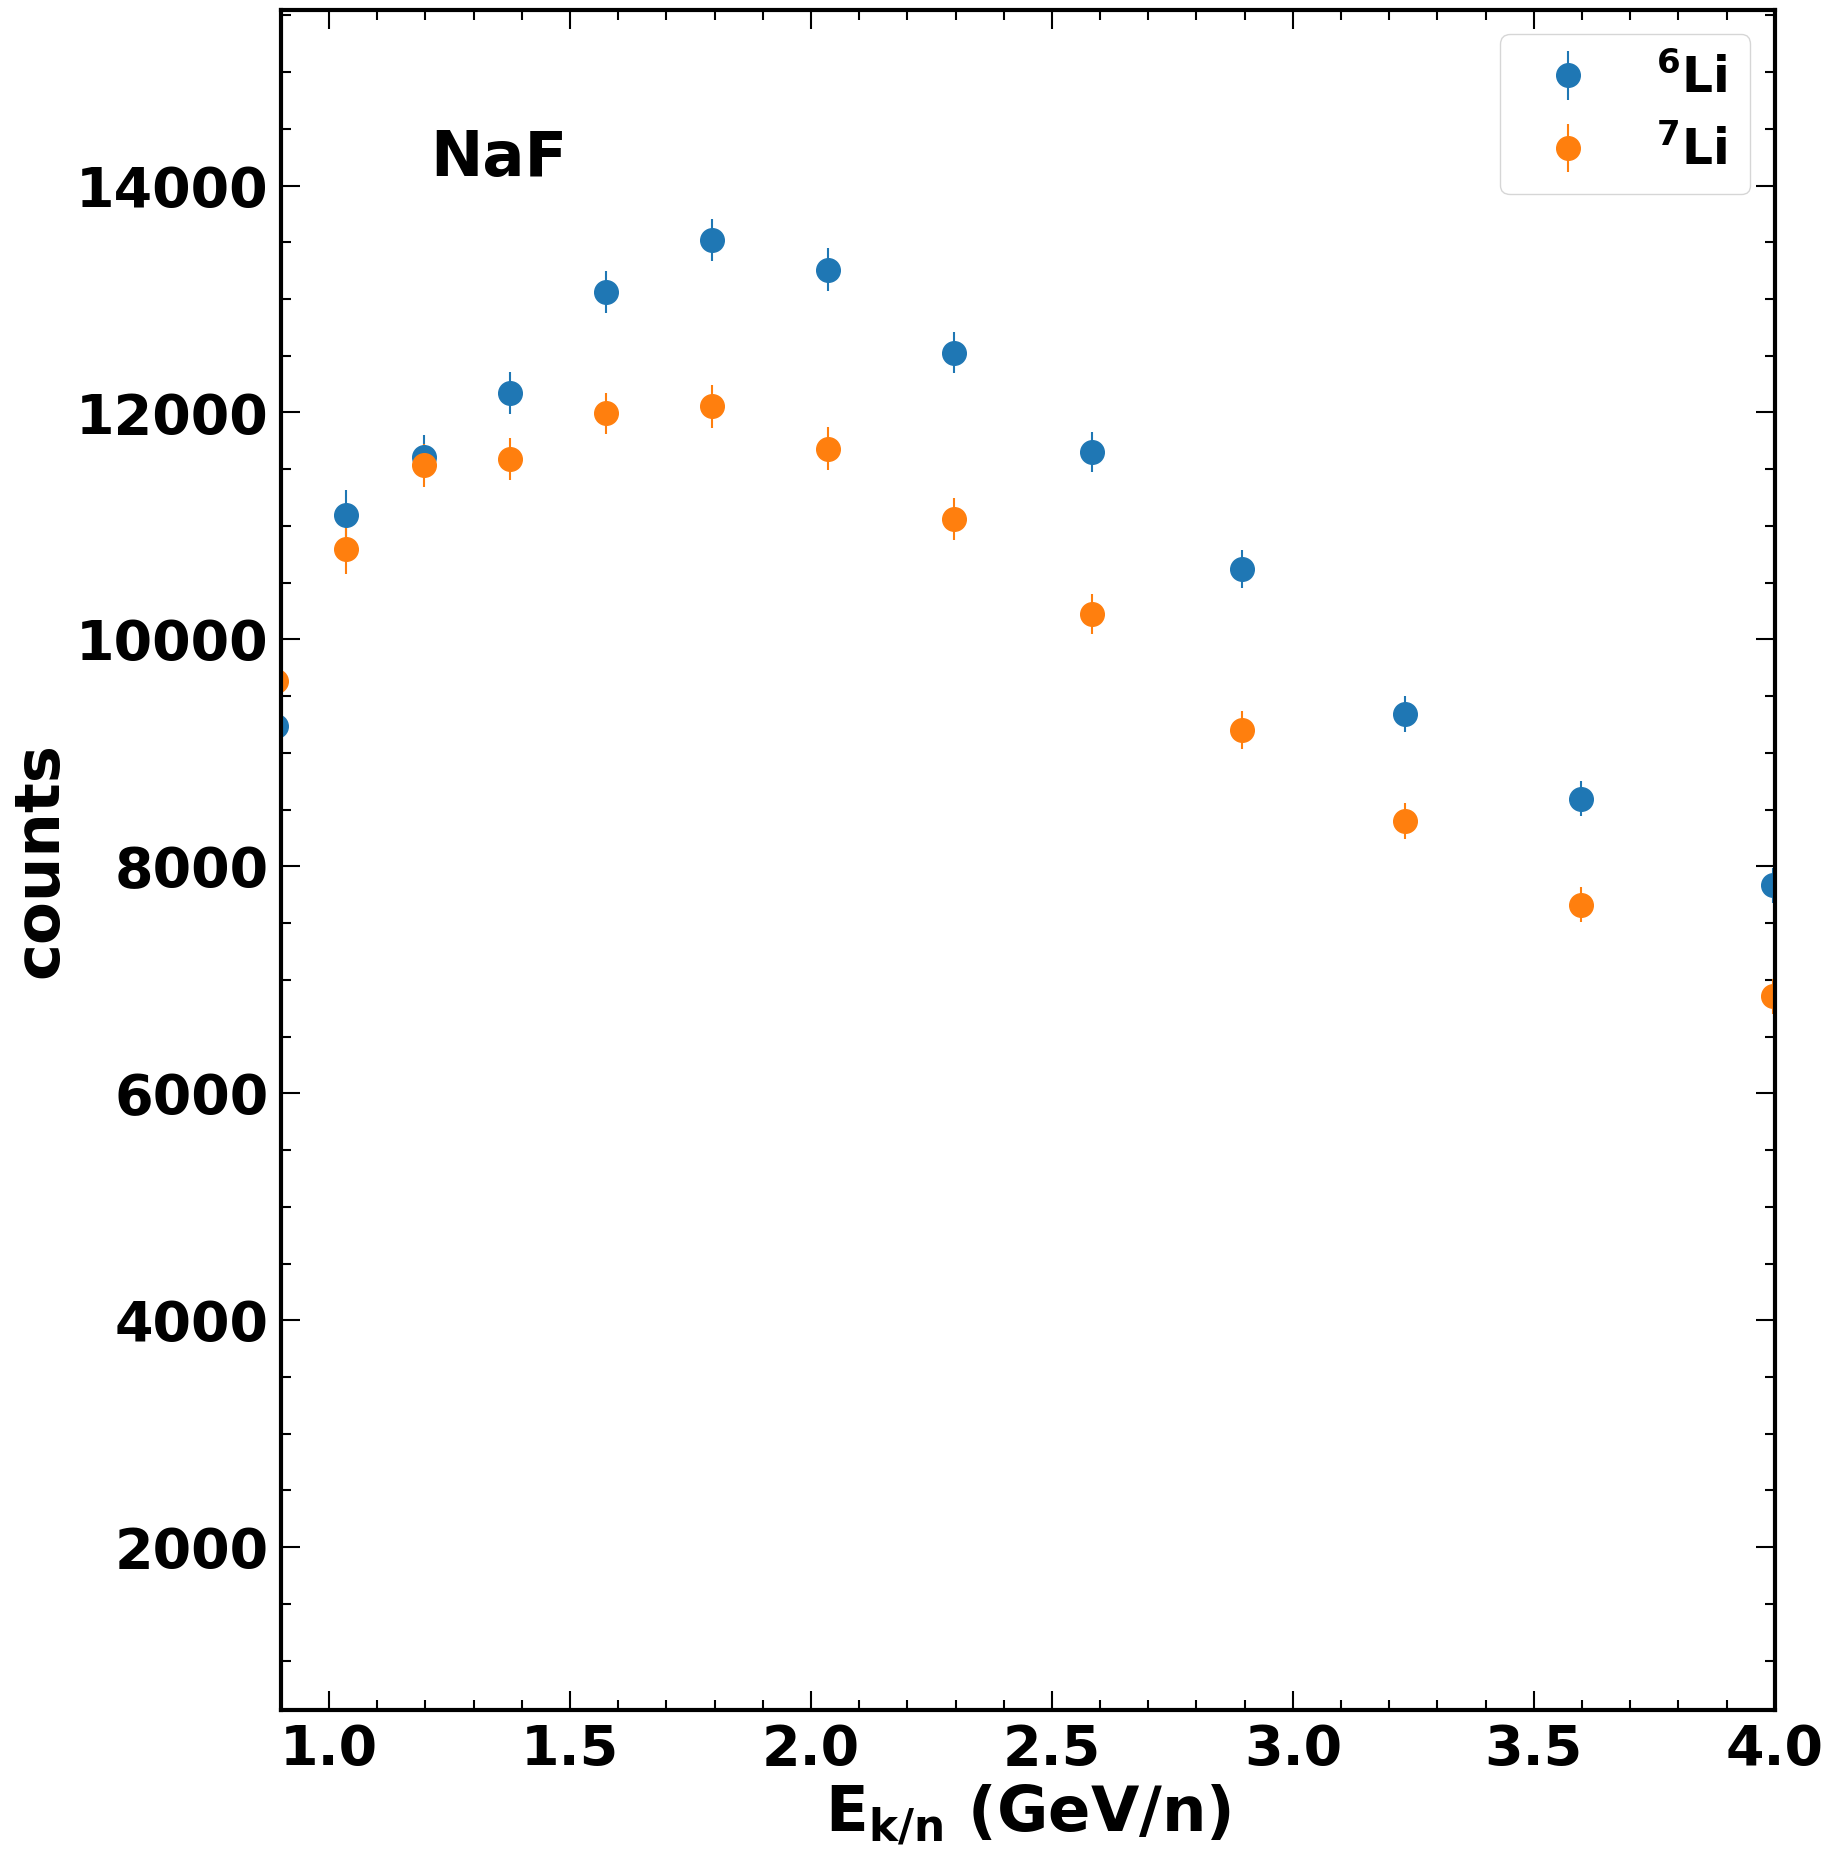

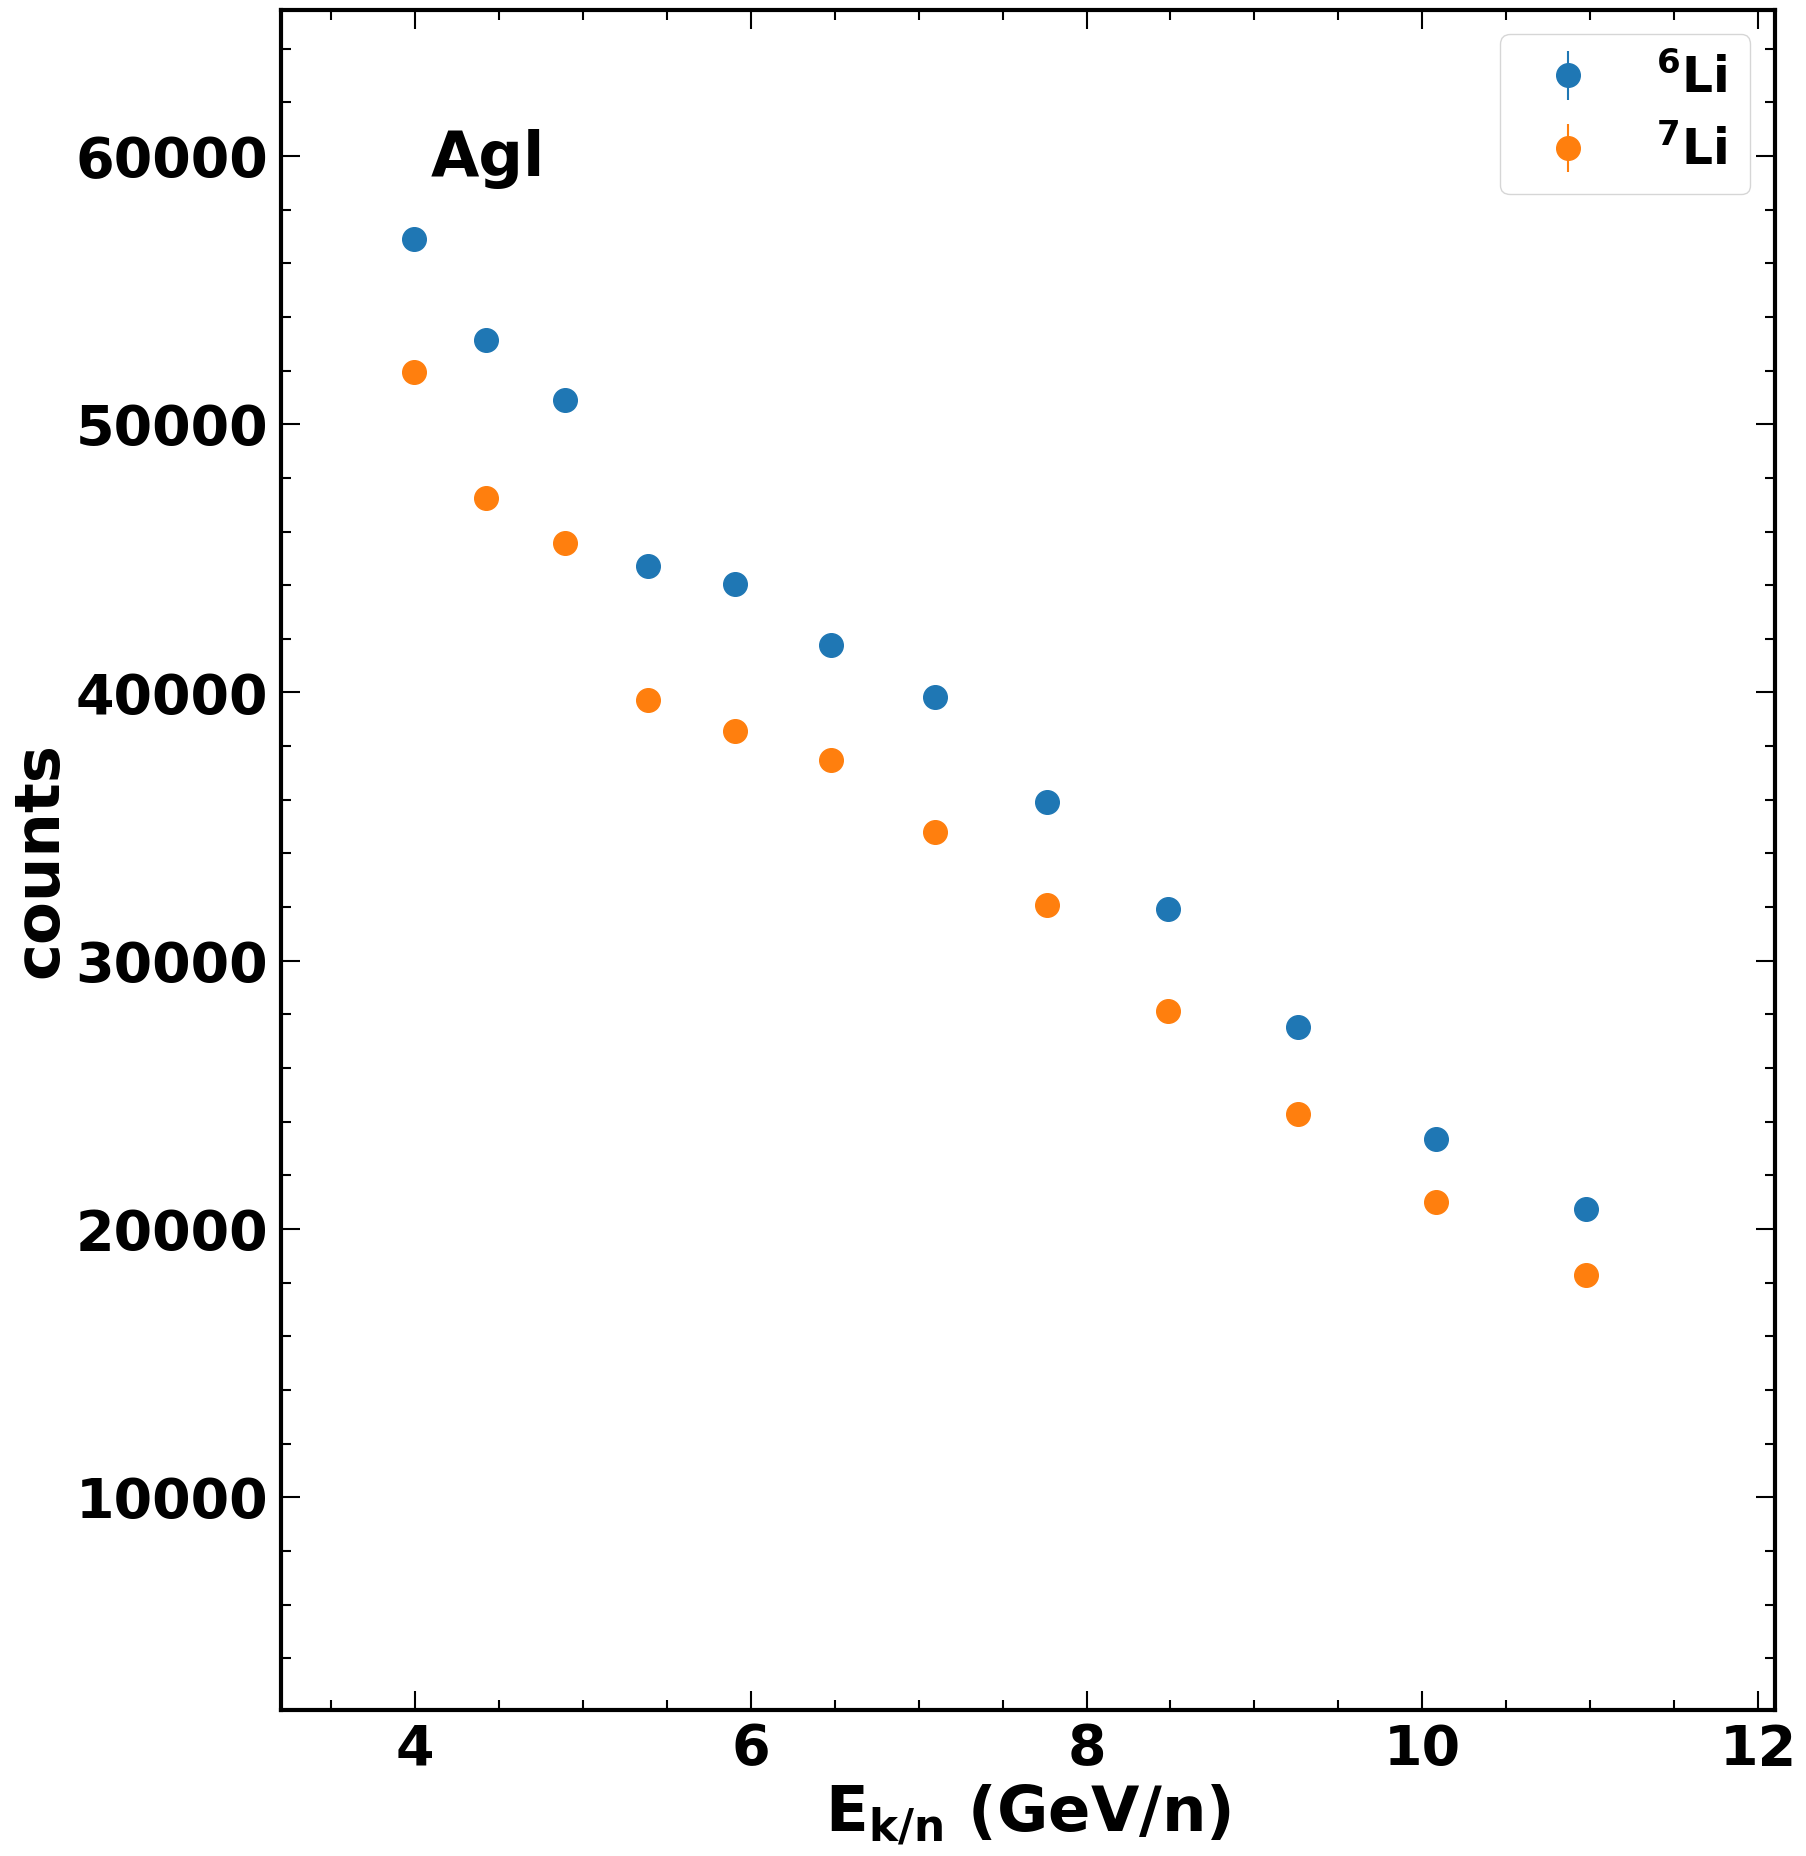

In [9]:
figsize1 = (21, 25)
fontsize1 = 45
fontsize2 = 55
mksize = 38
#filename_compare = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitDataGBL_Rebin/graph_massfit_counts.npz'
#filename_init = '/home/manbing/Documents/Data/data_mc/dfile/BeMC_dict_hist_mass_ekin.npz'
file_counts = {'Tof': '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiTest/fitDataB1308_finebin_ToFShiftCutoff_CutToFEdge_16May_Final/graph_massfit_counts.npz',
               'NaF': '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiTest/fitDataB1308_finebin_ToFShiftCutoff_CutToFEdge_16May_Final/graph_massfit_counts.npz',
               'Agl': '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitDataB1308_finebin_ShiftToF_CutToFEdge_11May_NotConstraintNTotal_NoMeanConstraint/graph_massfit_counts.npz'}
detectors = ['Tof', 'NaF', 'Agl']
df_counts = {dec: np.load(f'{file_counts[dec]}') for dec in detectors}
#df_counts = np.load(f'{file_counts}')

figSize = (22, 15)
graph_counts_fromfit = {dec: {} for dec in detectors}
graph_counts_sum = dict()
graph_counts_compare = {dec: {} for dec in detectors}
graph_counts_sum_compare = dict()
hist_mass2d = {dec: {} for dec in detectors}
slicevalue = {'Tof': [0.44, 1.2], 'NaF': [0.9, 5.6], 'Agl':[4.0, 12.0]}
ax2ylinemin = {'Li6': 0.97, 'Li7': 0.95, 'Be10':0.9}
ax2ylinemax = {'Li6': 1.03, 'Li7': 1.05, 'Be10':1.1}

for dec in detectors:
    for iso in isotopes:
        graph_counts_fromfit[dec][iso] = MGraph.from_file(df_counts[dec], f"graph_counts_{dec}OptLi7_{iso}")
        #graph_counts_compare[dec][iso] = MGraph.from_file(df_counts_compare, f"graph_counts_{dec}OptLi6_{iso}")
        graph_counts_fromfit[dec][iso] = slice_graph_by_value(graph_counts_fromfit[dec][iso], slicevalue[dec])
        xstart = graph_counts_fromfit[dec][iso].xvalues[0]
        xend = graph_counts_fromfit[dec][iso].xvalues[-1]
        #graph_counts_compare[dec][iso] = slice_graph_by_value(graph_counts_compare[dec][iso] , np.array([xstart, xend]))
        if iso == "Li6":
            graph_counts_sum[dec] = graph_counts_fromfit[dec][iso]
            #graph_counts_sum_compare[dec] = graph_counts_compare[dec][iso]
        else:
            graph_counts_sum[dec] = graph_counts_sum[dec] + graph_counts_fromfit[dec][iso]
            #graph_counts_sum_compare[dec] = graph_counts_sum_compare[dec] + graph_counts_compare[dec][iso]

            
            
            
###########################################
#plot counts 

for dec in detectors:
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=(24, 24))                                                                                                            
    plot_graph(fig, ax1, graph_counts_fromfit[dec]['Li6'], color=ISOTOPES_COLOR['Li6'],  style="EP", xlog=False, ylog=False, scale=None, markersize=mksize+5, label=f'{ISO_LABELS["Li6"]}')  
    plot_graph(fig, ax2, graph_counts_fromfit[dec]['Li7'], color=ISOTOPES_COLOR['Li7'],  style="EP", xlog=False, ylog=False, scale=None, markersize=mksize+5, label=f'{ISO_LABELS["Li7"]}')  
    
    set_plot_style(ax1)
    set_plot_style(ax2)
    ax1.text(0.05, 0.96, f"{dec}-{ISO_LABELS['Li6']}", fontsize=fontsize2+5, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')    
    ax2.text(0.05, 0.96, f"{dec}-{ISO_LABELS['Li7']}", fontsize=fontsize2+5, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')    
    
    ax2.set_xlabel(r'$\mathrm{E_{k/n} \ (GeV/n)}$', fontsize=fontsize1) 
    #ax1.legend(loc="upper right", fontsize=fontsize1) 
    ax1.set_xticklabels([])
    plt.subplots_adjust(hspace=.05)   
        #ax1.get_yticklabels()[0].set_visible(False)
    ax1.set_ylabel('counts', fontsize=fontsize1)
    ax2.set_ylabel('counts', fontsize=fontsize1)
    
    
    #ax1.legend(fontsize=fontsize1) 
    #ax2.legend(fontsize=fontsize1) 
    #ax3.legend(fontsize=fontsize1) 
    ax1.set_ylim([0.62* min(graph_counts_fromfit[dec]['Li6'].yvalues), 1.45* max(graph_counts_fromfit[dec]['Li6'].yvalues)])
    ax2.set_ylim([0.62* min(graph_counts_fromfit[dec]['Li7'].yvalues), 1.47* max(graph_counts_fromfit[dec]['Li7'].yvalues)])
    print(plotdir)
    savefig_tofile(fig, plotdir, f"counts_fromfit_TLiAN_{dec}", show=True)

###########################################



################## #########################
#plot counts in one plot 

fig, ax1 =  plt.subplots(figsize=(20, 16))                                                                                                          
for dec in detectors:
    
    plot_graph(fig, ax1, graph_counts_fromfit[dec]['Li6'], color=ISOTOPES_COLOR['Li6'],  style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label=f'{ISO_LABELS["Li6"]}')  
    plot_graph(fig, ax1, graph_counts_fromfit[dec]['Li7'], color=ISOTOPES_COLOR['Li7'],  style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label=f'{ISO_LABELS["Li7"]}')  
    
    set_plot_style(ax1)
    #set_plot_style(ax2)
    #ax1.text(0.05, 0.96, f"{dec}-{ISO_LABELS['Li6']}, analysis optimized for {ISO_LABELS['Li6']} ", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')    
    #ax2.text(0.05, 0.96, f"{dec}-{ISO_LABELS['Li7']}, analysis optimized for {ISO_LABELS['Li7']} ", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')    
    
    ax1.set_xlabel(r'$\mathrm{E_{k/n} \ (GeV/n)}$', fontsize=fontsize1) 
    #ax1.legend(loc="upper right", fontsize=fontsize1) 
    #ax1.set_xticklabels([])
    #plt.subplots_adjust(hspace=.05)   
    #ax1.get_yticklabels()[0].set_visible(False)
    ax1.set_ylabel('counts', fontsize=fontsize1)
    #ax2.set_ylabel('counts', fontsize=fontsize1)
    
    
    #ax1.legend(fontsize=fontsize1) 
    #ax2.legend(fontsize=fontsize1) 
    #ax3.legend(fontsize=fontsize1) 
    ax1.set_ylim([0.62* min(graph_counts_fromfit[dec]['Li6'].yvalues), 1.45* max(graph_counts_fromfit[dec]['Li6'].yvalues)])
    #ax1.set_ylim([0.62* min(graph_counts_fromfit[dec]['Li7'].yvalues), 1.47* max(graph_counts_fromfit[dec]['Li7'].yvalues)])
    print(plotdir)
savefig_tofile(fig, plotdir, f"counts_fromfit_TLiAN_Alldec", show=True)

###########################################


graph_counts_ratio_may = {}
graph_counts_ratio = {}
fig, ax1 =  plt.subplots(figsize=(20, 16))  
for dec in detectors:
    graph_counts_ratio_may[dec] = graph_counts_fromfit[dec][ISOTOPES[nuclei][1]]/graph_counts_fromfit[dec][ISOTOPES[nuclei][0]]
    #graph_counts_ratio_may[dec] = slice_graph_by_value(MGraph.from_file(df_counts[dec], f"graph_ratio_{dec}OptLi7"), slicevalue[dec])
    print(graph_counts_ratio_may[dec])
    plot_graph(fig, ax1, graph_counts_ratio_may[dec], color=DETECTOR_COLOR[dec],  style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label=f'{dec}')  
    #plot_graph(fig, ax1, graph_counts_ratio[dec], color='black',  style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label=f'{dec}', markerfacecolor='none')  
    ax1.set_ylim([0.32, 1.52])
    ax1.set_xlim([0.3, 12.1])
    ax1.set_xscale('log')
    ax1.set_xlabel(r'$\mathrm{E_{k/n}}$')
    ax1.set_ylabel('Li7/Li6')
    ax1.set_xticks([0.3, 0.5, 1, 2, 3, 5, 10]) 
    set_plot_style(ax1)
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())  
    
#############################################################
plotvalue = {'Tof':[0.45, 1.08], 'NaF':[0.9, 4.0], 'Agl':[3.2, 12.1]}
suma = 0
for dec in detectors:
       
    fig, ax1 = plt.subplots(figsize=(18, 20))                                                                                                            
    fig.subplots_adjust(left= 0.14, right=0.97, bottom=0.1, top=0.95) 
    for iso in isotopes: 
        plot_graph(fig, ax1, graph_counts_fromfit[dec][iso], color=ISOTOPES_COLOR[iso],  style="EP", xlog=False, ylog=False, scale=None, markersize=34, label=f'{ISO_LABELS[iso]} ')  
        suma += np.sum(graph_counts_fromfit[dec][iso].yvalues)
    ax1.set_xlabel(r'$\mathrm{E_{k/n} \ (GeV/n)}$') 
    ax1.legend(loc="upper right", fontsize=30) 
    ax1.set_ylabel('counts')

    ax1.legend( fontsize=35) 

        
    #ax1.set_xscale('log')
    
    ax1.set_xlim(plotvalue[dec])
    set_plot_style(ax1)
    ax1.set_ylim([0.1* min(graph_counts_fromfit[dec]['Li6'].yvalues), 1.15* max(graph_counts_fromfit[dec]['Li6'].yvalues)])
    
    #ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #ax2.set_xticks(np.array([2, 4, 10]))
    ax1.text(0.1, 0.93, f'{dec}', fontsize=45, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black')
    savefig_tofile(fig, plotdir, f"counts_fromfit_{dec}", show=True)
    print(plotdir)
print(suma)

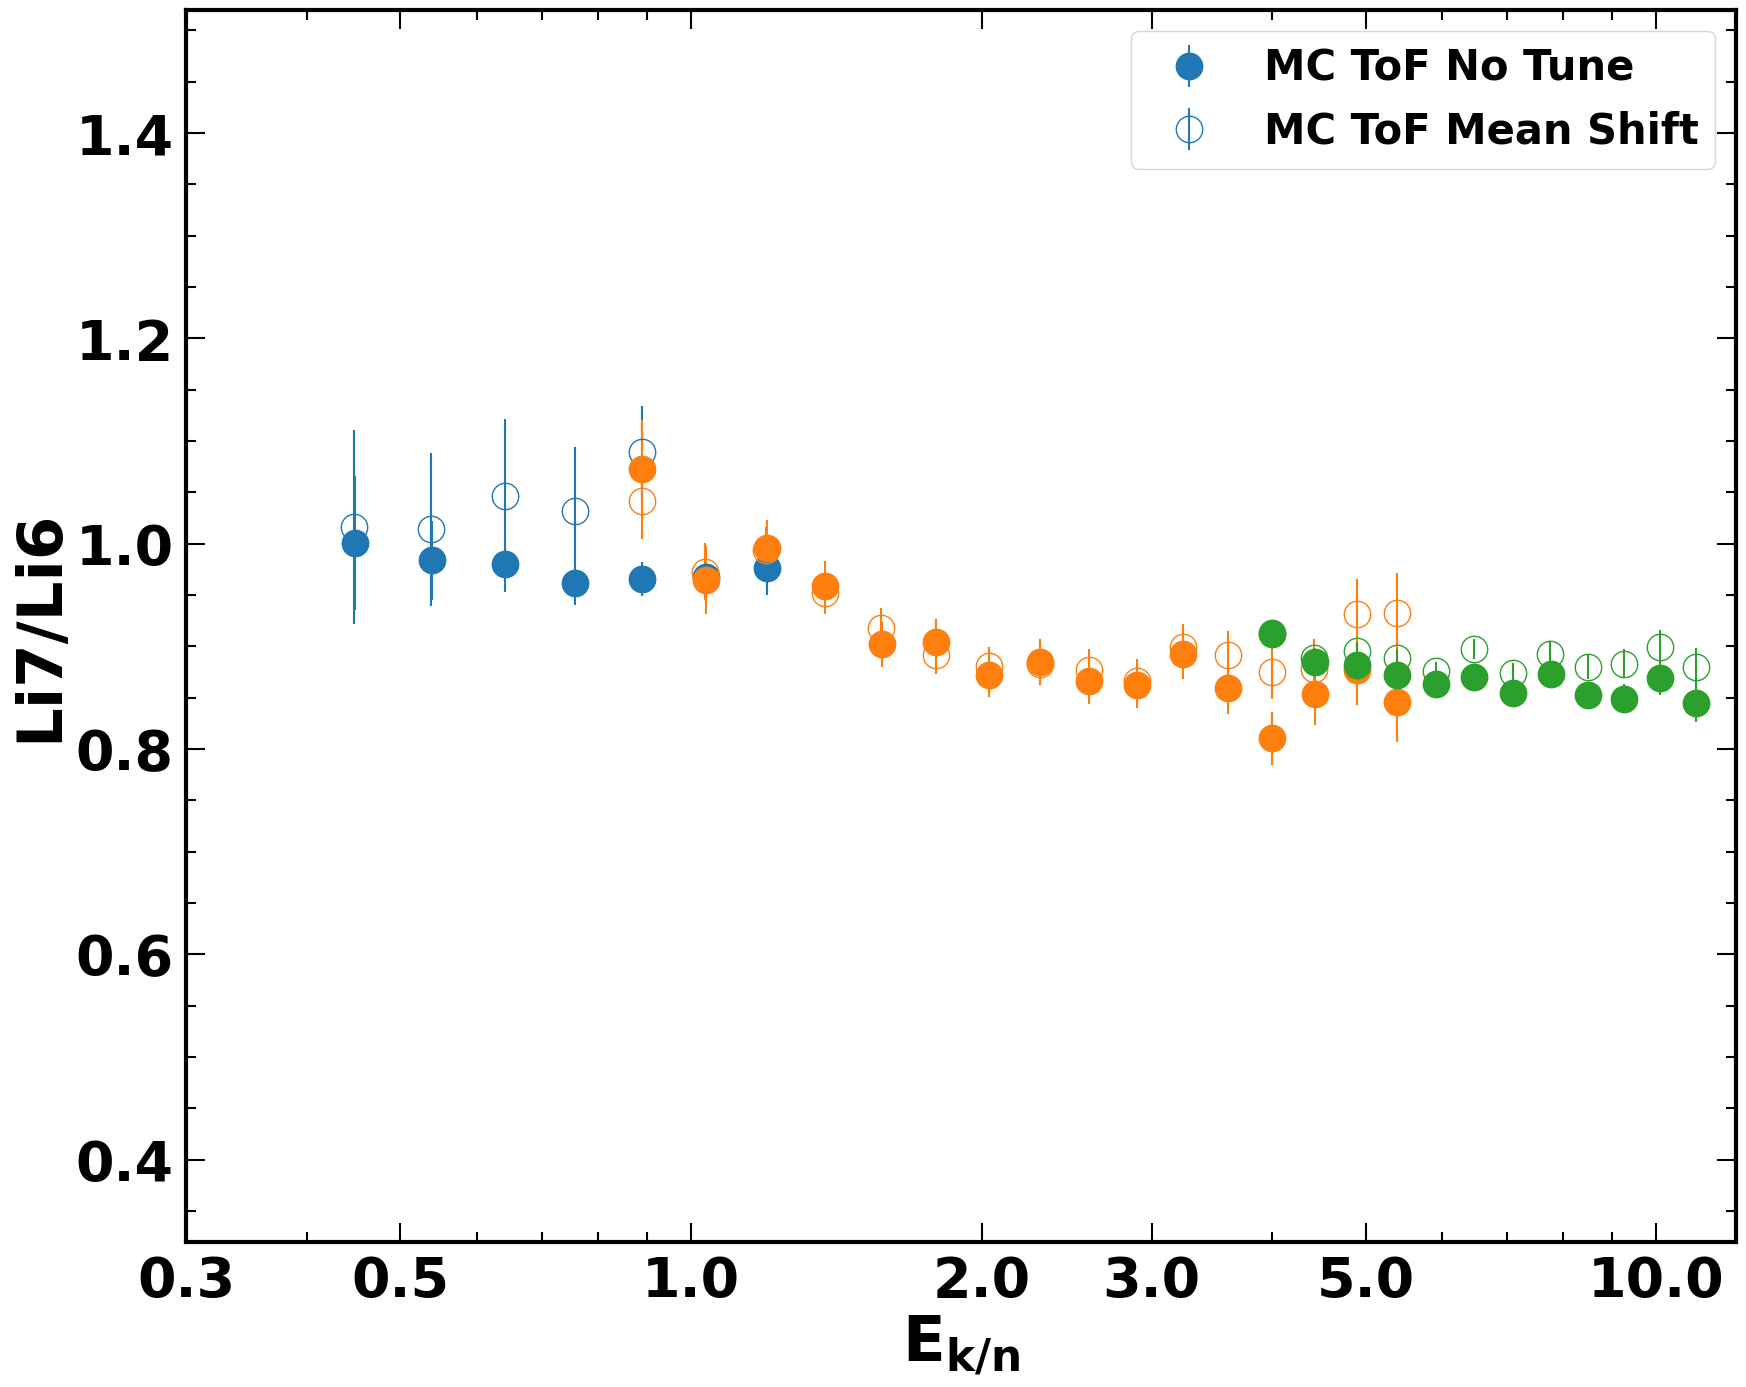

In [5]:
figsize1 = (21, 25)
fontsize1 = 45
fontsize2 = 55
mksize = 38
#filename_compare = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitDataGBL_Rebin/graph_massfit_counts.npz'
#filename_init = '/home/manbing/Documents/Data/data_mc/dfile/BeMC_dict_hist_mass_ekin.npz'
file_counts = {'Tof': '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitDataB1308_finebin_untuned_24Apr/graph_massfit_counts.npz',
               'NaF': '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitDataB1308_finebin_untuned_24Apr/graph_massfit_counts.npz',
               'Agl': '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitDataB1308_finebin_untuned_24Apr/graph_massfit_counts.npz'}
#file_counts = {'Tof': '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiTest/fitDataB1308_finebin_ToFShiftCutoff_CutToFEdge_16May_Final/graph_massfit_counts.npz',
#               'NaF': '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiTest/fitDataB1308_finebin_ToFShiftCutoff_CutToFEdge_16May_Final/graph_massfit_counts.npz',
#               'Agl': '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiTest/fitDataB1308_finebin_ToFShiftCutoff_CutToFEdge_16May_Final/graph_massfit_counts.npz'}


detectors = ['Tof', 'NaF', 'Agl']
df_counts = {dec: np.load(f'{file_counts[dec]}') for dec in detectors}
#df_counts = np.load(f'{file_counts}')

figSize = (22, 15)
graph_counts_fromfit_Apr = {dec: {} for dec in detectors}
graph_counts_sum = dict()
graph_counts_compare = {dec: {} for dec in detectors}
graph_counts_sum_compare = dict()
hist_mass2d = {dec: {} for dec in detectors}
slicevalue = {'Tof': [0.44, 1.2], 'NaF': [0.9, 5.6], 'Agl':[4.0, 12.0]}
ax2ylinemin = {'Be7': 0.97, 'Be9': 0.95, 'Be10':0.9}
ax2ylinemax = {'Be7': 1.03, 'Be9': 1.05, 'Be10':1.1}

for dec in detectors:
    for iso in isotopes:
        graph_counts_fromfit_Apr[dec][iso] = MGraph.from_file(df_counts[dec], f"graph_counts_{dec}OptLi6_{iso}")
        #graph_counts_compare[dec][iso] = MGraph.from_file(df_counts_compare, f"graph_counts_{dec}OptBe7_{iso}")
        graph_counts_fromfit_Apr[dec][iso] = slice_graph_by_value(graph_counts_fromfit_Apr[dec][iso], slicevalue[dec])
        
        #hist_mass2d[dec][iso] = WeightedHistogram.from_file(df_counts_compare, f"{iso}MC_{dec}_mass")
        #graph_counts_compare[dec][iso] = MGraph(xbinning.bin_centers[1:-1], np.sum(hist_mass2d[dec][iso].values[1:-1, 1:-1], axis=1), np.sqrt(np.sum(hist_mass2d[dec][iso].values[1:-1, 1:-1], axis=1)))
        #graph_counts_compare[dec][iso] = MGraph.from_file(df_counts_compare, f'{dec}_{iso}MC_counts')
        xstart = graph_counts_fromfit_Apr[dec][iso].xvalues[0]
        xend = graph_counts_fromfit_Apr[dec][iso].xvalues[-1]
        #graph_counts_compare[dec][iso] = slice_graph_by_value(graph_counts_compare[dec][iso] , np.array([xstart, xend]))
        if iso == "Li6":
            graph_counts_sum[dec] = graph_counts_fromfit_Apr[dec][iso]
            #graph_counts_sum_compare[dec] = graph_counts_compare[dec][iso]
        else:
            graph_counts_sum[dec] = graph_counts_sum[dec] + graph_counts_fromfit_Apr[dec][iso]
            #graph_counts_sum_compare[dec] = graph_counts_sum_compare[dec] + graph_counts_compare[dec][iso]

graph_counts_ratio_Apr = {}
fig, ax1 =  plt.subplots(figsize=(20, 16))

for dec in detectors:
    graph_counts_ratio_Apr[dec] = graph_counts_fromfit_Apr[dec][ISOTOPES[nuclei][1]]/graph_counts_fromfit_Apr[dec][ISOTOPES[nuclei][0]]
    
    plot_graph(fig, ax1, graph_counts_ratio_Apr[dec], color=DETECTOR_COLOR[dec],  style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label=f'MC ToF No Tune ' if dec == 'Tof' else None)  
   
    plot_graph(fig, ax1, graph_counts_ratio_may[dec], color=DETECTOR_COLOR[dec],  style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label=f'MC ToF Mean Shift' if dec == 'Tof' else None, markerfacecolor='none')  
         #plot_graph(fig, ax1, graph_counts_ratio_may_noshift[dec], color='black',  style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label=f'MC ToF No Mean Shift, fix sigma' if dec == 'Tof' else None, markerfacecolor='none')  
    
    ax1.set_ylim([0.32, 1.52])
    ax1.set_xlim([0.3, 12.1])
    ax1.set_xscale('log')
    ax1.set_xlabel(r'$\mathrm{E_{k/n}}$')
    ax1.set_ylabel('Li7/Li6')
    ax1.set_xticks([0.3, 0.5, 1, 2, 3, 5, 10]) 
    set_plot_style(ax1)
    ax1.legend(fontsize=30)
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())  
    


/home/manbing/Documents/lithiumanalysis/scripts/tools/graphs.py:284: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  result = plot.errorbar(values_x, values_y, (errors_y_low, errors_y_high), fmt='.', color=color, label=label, **kwargs)


/home/manbing/Documents/lithiumanalysis/slides/plots/LiP8/fitDataB1308_finebin_meanfree
[1.01445679 1.01512511 1.01489323 1.01445833 1.01418912]
[1.00607439 1.01313911 1.01698024 1.01933829 1.02084677 1.02178202
 1.0222997  1.02252655 1.02257278 1.02252821 1.02246399 1.02243177
 1.02246731 1.02259441 1.02283422 1.0231905 ]
[1.01823361 1.0171735  1.01600998 1.01533671 1.01553743 1.01686362
 1.01941231 1.02304367 1.0273633  1.03169225 1.03502198 1.03596882]


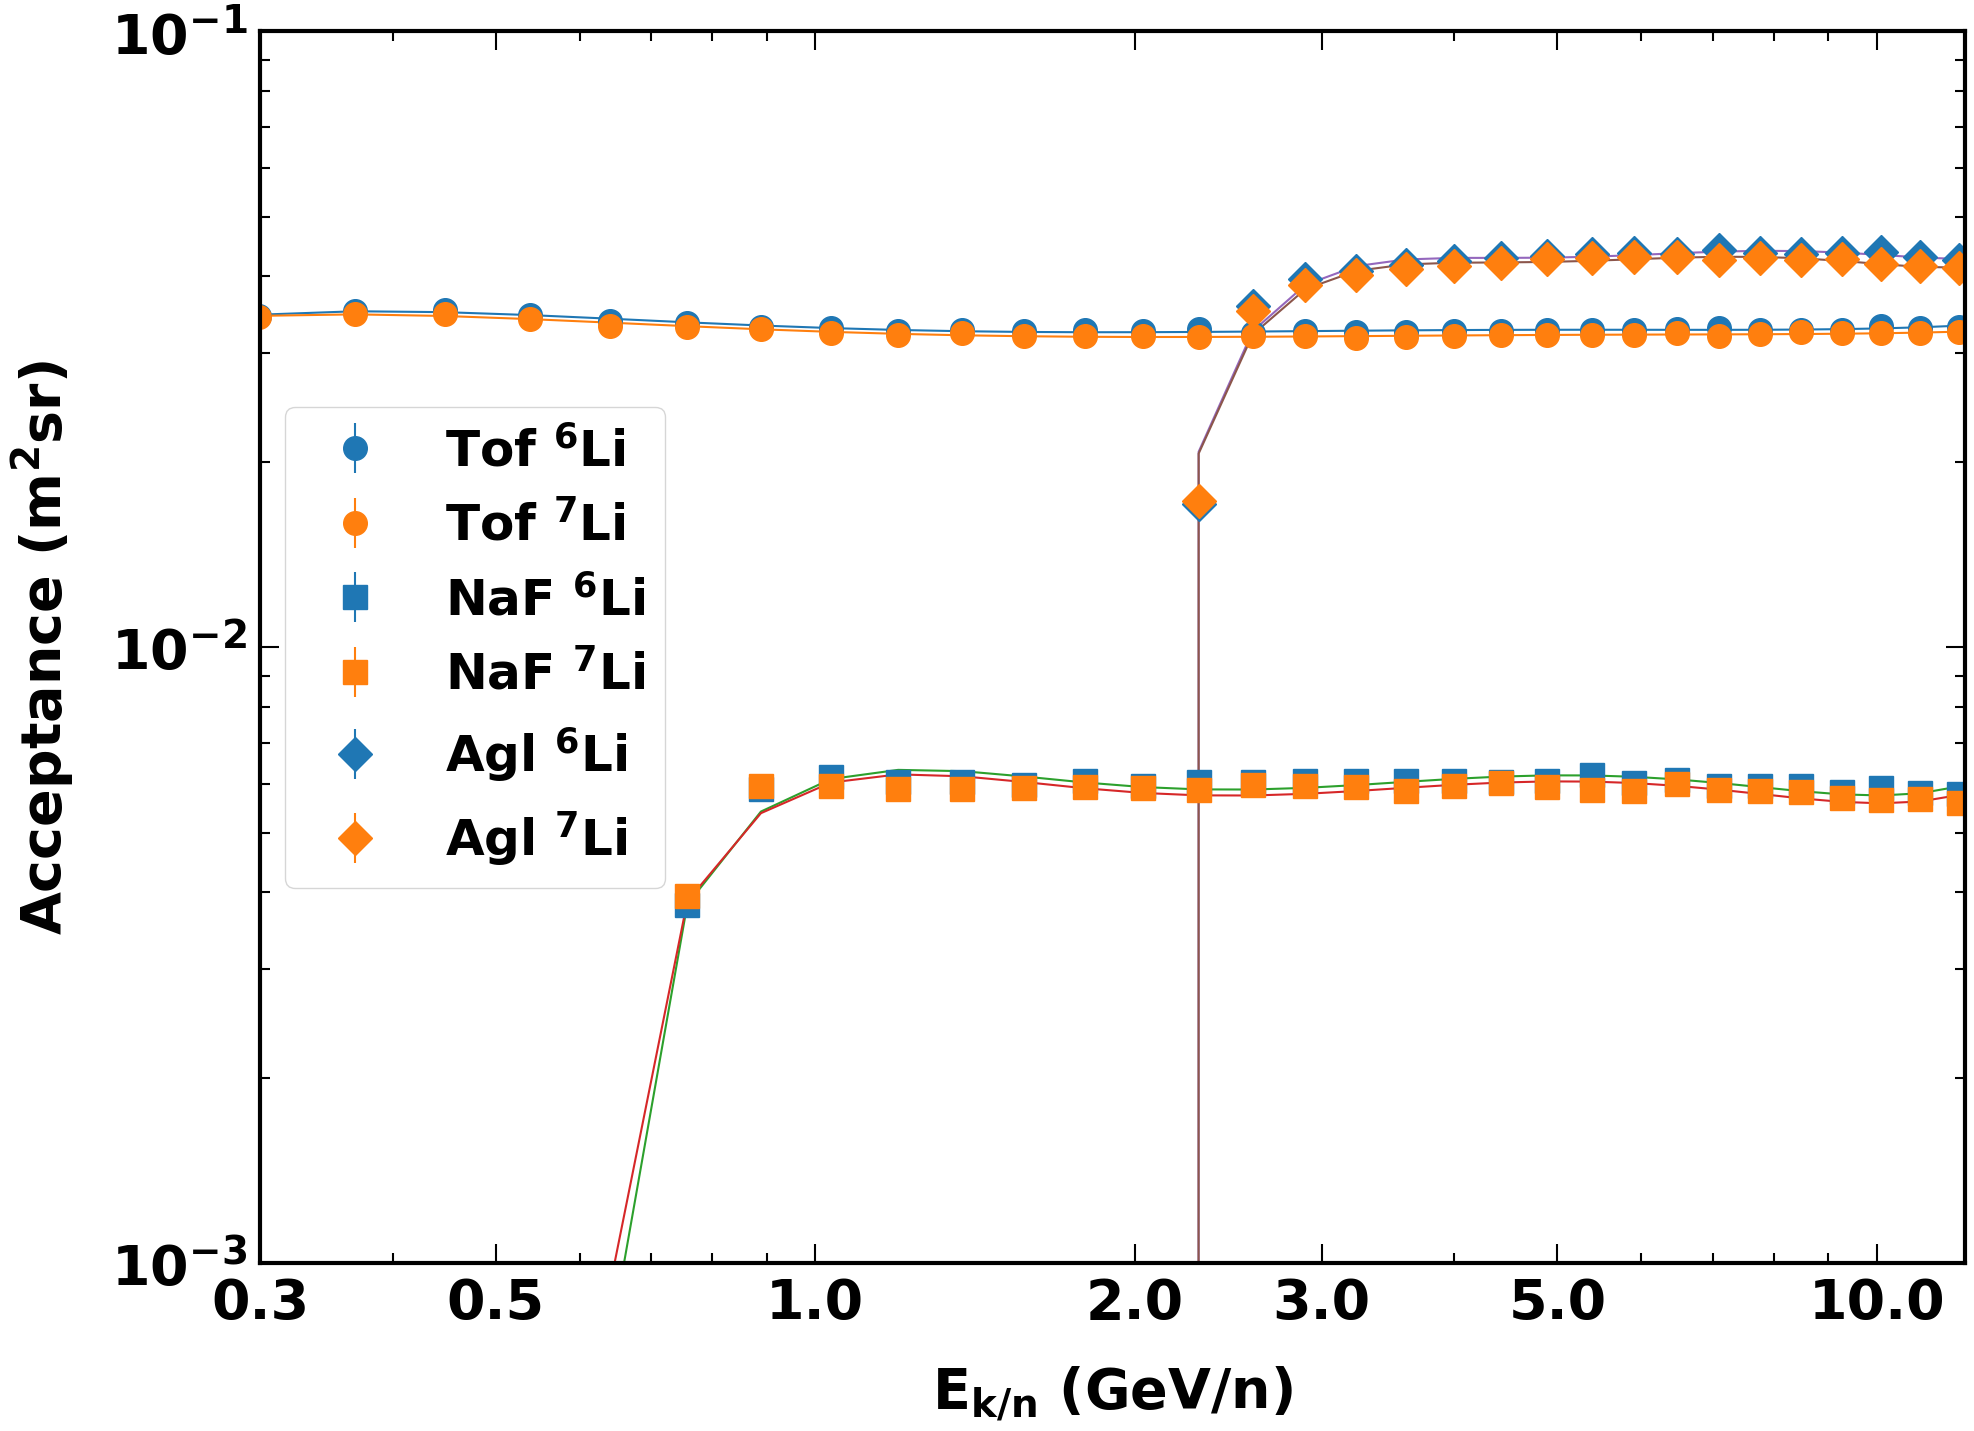

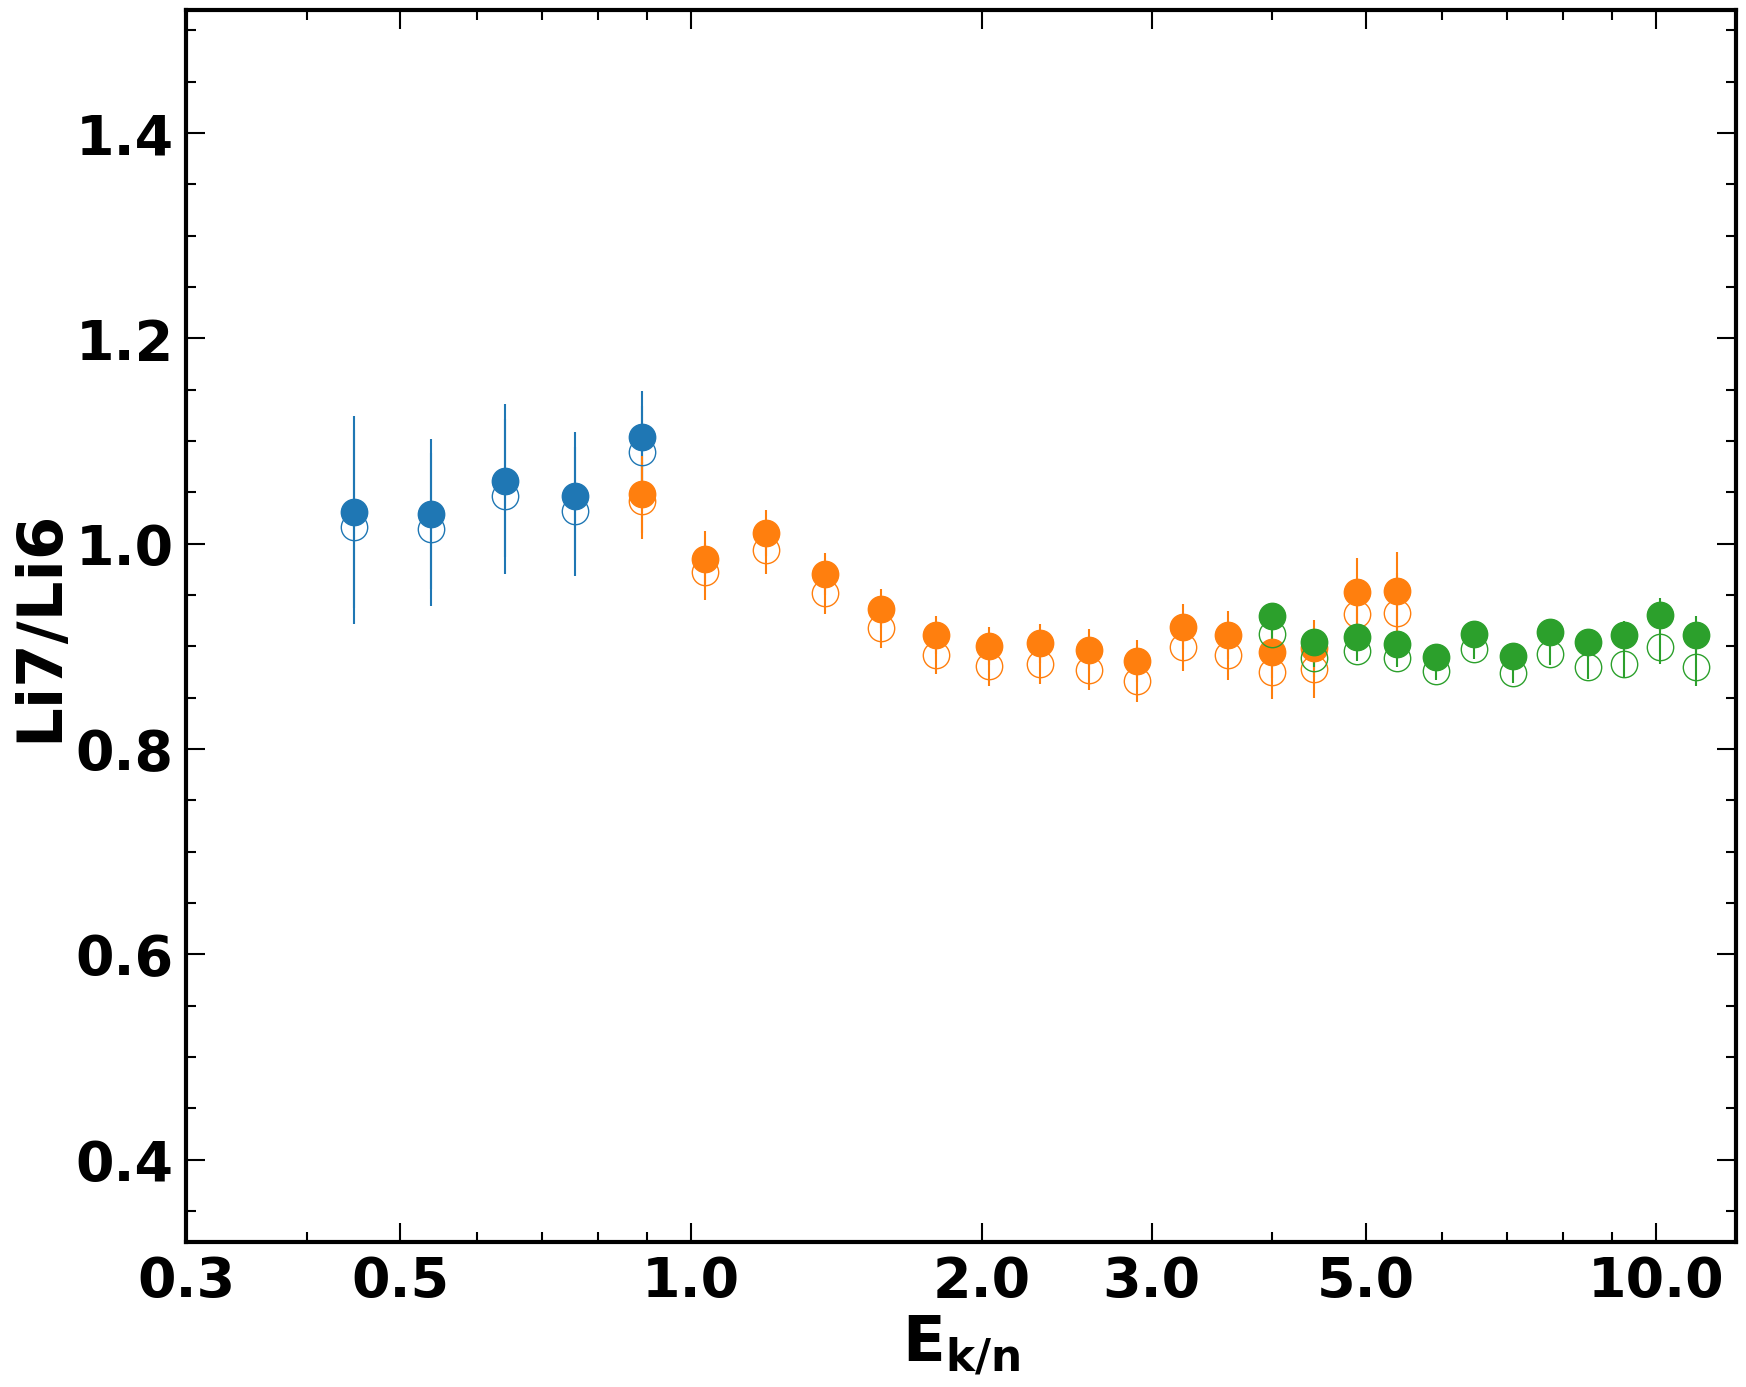

In [6]:
df_acc = np.load(f'{file_acc}')                                                                                                             
graph_acc = {dec: {iso: MGraph.from_file(df_acc, f"raw_acc_{dec}_{iso}") for iso in ISOTOPES[nuclei]} for dec in detectors}                                                                              
    
ylim_range = {'Tof': [0.02, 0.08], "NaF": [0.003, 0.008], "Agl": [0.02, 0.05]}
xlim_range = {'Tof': [0.2, 12], 'NaF':[0.6, 12], "Agl":[2, 12]}
subgraph_acc =  {dec: {} for dec in detectors}
spline_subgraph_acc =  {dec: {} for dec in detectors}
graph_acc_fromspline = {dec: {} for dec in detectors}
markerstyle ={'Tof': 'o', 'NaF':'s', 'Agl':'D'}
xdectext = {'Tof': 0.3, 'NaF': 0.4, 'Agl': 0.7}
ydectext = {'Tof': 0.9, 'NaF': 0.33, 'Agl': 0.75}
figure, ax1 = plt.subplots(1, 1, figsize= FIGSIZE3)
graph_acc_from_spline = {}

for dec in detectors:                                                                                                                                                                                                                                                                                    
    for i, iso in enumerate(ISOTOPES[nuclei]): 
        subgraph_acc[dec][iso] = slice_graph_by_value(graph_acc[dec][iso], xlim_range[dec])
        x_values = subgraph_acc[dec][iso].xvalues
        #spline_subgraph_acc[dec][iso] = UnivariateSpline(np.log(subgraph_acc[dec][iso].xvalues),subgraph_acc[dec][iso].yvalues, w=1/subgraph_acc[dec][iso].yerrs, k=5, s=5)  
        spline_subgraph_acc[dec][iso] = UnivariateSpline(np.log(subgraph_acc[dec][iso].xvalues),subgraph_acc[dec][iso].yvalues, k=5, s=10)  
        ax1.plot(x_values, spline_subgraph_acc[dec][iso](np.log(x_values)))                                                                                                                                                                                                                                                      
        #plot_graph(figure, ax1, graph_acc[dec][iso], color=ISOTOPES_COLOR[iso], label=f"{ISO_LABELS[iso]}" if dec == 'Tof' else None, style="EP", xlog=True, ylog=False, marker=markerstyle[dec], markersize=17)                                                                            
        plot_graph(figure, ax1, graph_acc[dec][iso], color=ISOTOPES_COLOR[iso], label=f"{dec} {ISO_LABELS[iso]}", style="EP", xlog=True, ylog=False, marker=markerstyle[dec], markersize=17)                                                                            
        #plot_graph(figure, ax1, graph_corrected_acc[dec][iso], color=ISOTOPES_COLOR[iso], label=f"{iso}", style="EP", xlog=True, ylog=False, markersize=20)                                                    
        
        SetAx1Axis(ax1, r'$\mathrm{E_{k/n} \ (GeV/n)}$', r"$\mathrm{Acceptance \ (m^{2} sr)}$", 
                   TEXTSIZE, xlimrange=[0.2, 12], ylimrange=[0.001, 0.1], custom_ticks=None, 
                   custom_tickslabels=None, gridx=False, gridy=False, setylog=True, setxlog=True)
        ax1.legend(loc='center left')
        ax1.set_xticks([0.3, 0.5, 1, 2, 3, 5, 10]) 
        ax1.set_xlim([0.3, 12.1])
        set_plot_style(ax1)
        ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())  
        #ax1.text(xdectext[dec], ydectext[dec], f"{dec}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                                                                                                                                                                                           
print(plotdir)
savefig_tofile(figure, plotdir, f"Acc{nuclei}_{variable}_P8B1236_NoTofEdge", 1)                                                                                          
    
graph_ratio_derive_acc = {}    
for dec in detectors:
    x_values = graph_counts_ratio_may[dec].xvalues
    print(spline_subgraph_acc[dec]['Li6'](np.log(x_values))/spline_subgraph_acc[dec]['Li7'](np.log(x_values)))
    graph_ratio_derive_acc[dec] = MGraph(x_values, graph_counts_ratio_may[dec].yvalues * spline_subgraph_acc[dec]['Li6'](np.log(x_values))/spline_subgraph_acc[dec]['Li7'](np.log(x_values)), graph_counts_ratio_may[dec].yerrs * spline_subgraph_acc[dec]['Li7'](np.log(x_values))/spline_subgraph_acc[dec]['Li6'](np.log(x_values)))
    resultsdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitDataB1308_finebin_ShiftToF_CutToFEdge_11May_NotConstraintNTotal_NoMeanConstraint'
    write_points_totxt_with_binedge(graph_ratio_derive_acc[dec], xbinning, resultsdir, f'Li7ToLi6Ratio_{dec}')
fig, ax1 =  plt.subplots(figsize=(20, 16))
#graph_ratio_derive_acc['Tof'].yvalues *= 0.985
for dec in detectors:
    plot_graph(fig, ax1, graph_ratio_derive_acc[dec], color=DETECTOR_COLOR[dec],  style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label=f'{dec}')  
    #plot_graph(fig, ax1, graph_counts_ratio[dec], color=DETECTOR_COLOR[dec],  style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label=f'{dec}')  
    plot_graph(fig, ax1, graph_counts_ratio_may[dec], color=DETECTOR_COLOR[dec],  style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label=f'{dec}', markerfacecolor='none')
    ax1.set_ylim([0.32, 1.52])
    ax1.set_xlim([0.3, 12.1])
    ax1.set_xscale('log')
    ax1.set_xlabel(r'$\mathrm{E_{k/n}}$')
    ax1.set_ylabel('Li7/Li6')
    ax1.set_xticks([0.3, 0.5, 1, 2, 3, 5, 10]) 
    set_plot_style(ax1)
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())  
    


[    -inf  0.261    0.338    0.40615  0.49094  0.58761  0.69636  0.82148
  0.95893  1.113    1.2839   1.4714   1.6803   1.9105   2.1621   2.4349
  2.7338   3.0588   3.4096   3.7913   4.2037   4.6468   5.1404   5.6349
  6.1798   6.775    7.4206   8.1166   8.8629   9.6595  10.506   11.454
      inf]

xvalues			yvalues			yerrs
0.37825			15251705.334617764			0.0
0.4631			18824231.468454063			0.0
0.5589999999999999			21827710.877723664			0.0
0.66835			26369938.34927091			0.0
0.79125			30756938.692497224			0.0
0.9302999999999999			34671855.56947562			0.0
1.08555			41111779.242702454			0.0
1.2570999999999999			50370204.63714787			0.0
1.44745			57087221.79833248			0.0
1.6566			63778918.08079907			0.0
1.8872			72267840.36625102			0.0
2.1419			82187531.15442392			0.0
2.42075			92436896.5844312			0.0
2.7237			100442206.47385505			0.0
3.0534			105936468.37114546			0.0
3.4126000000000003			110368811.30537638			0.0
3.8012500000000005			114586304.65891328			0.0
4.2221			119022942.69704655			0.0
4.677

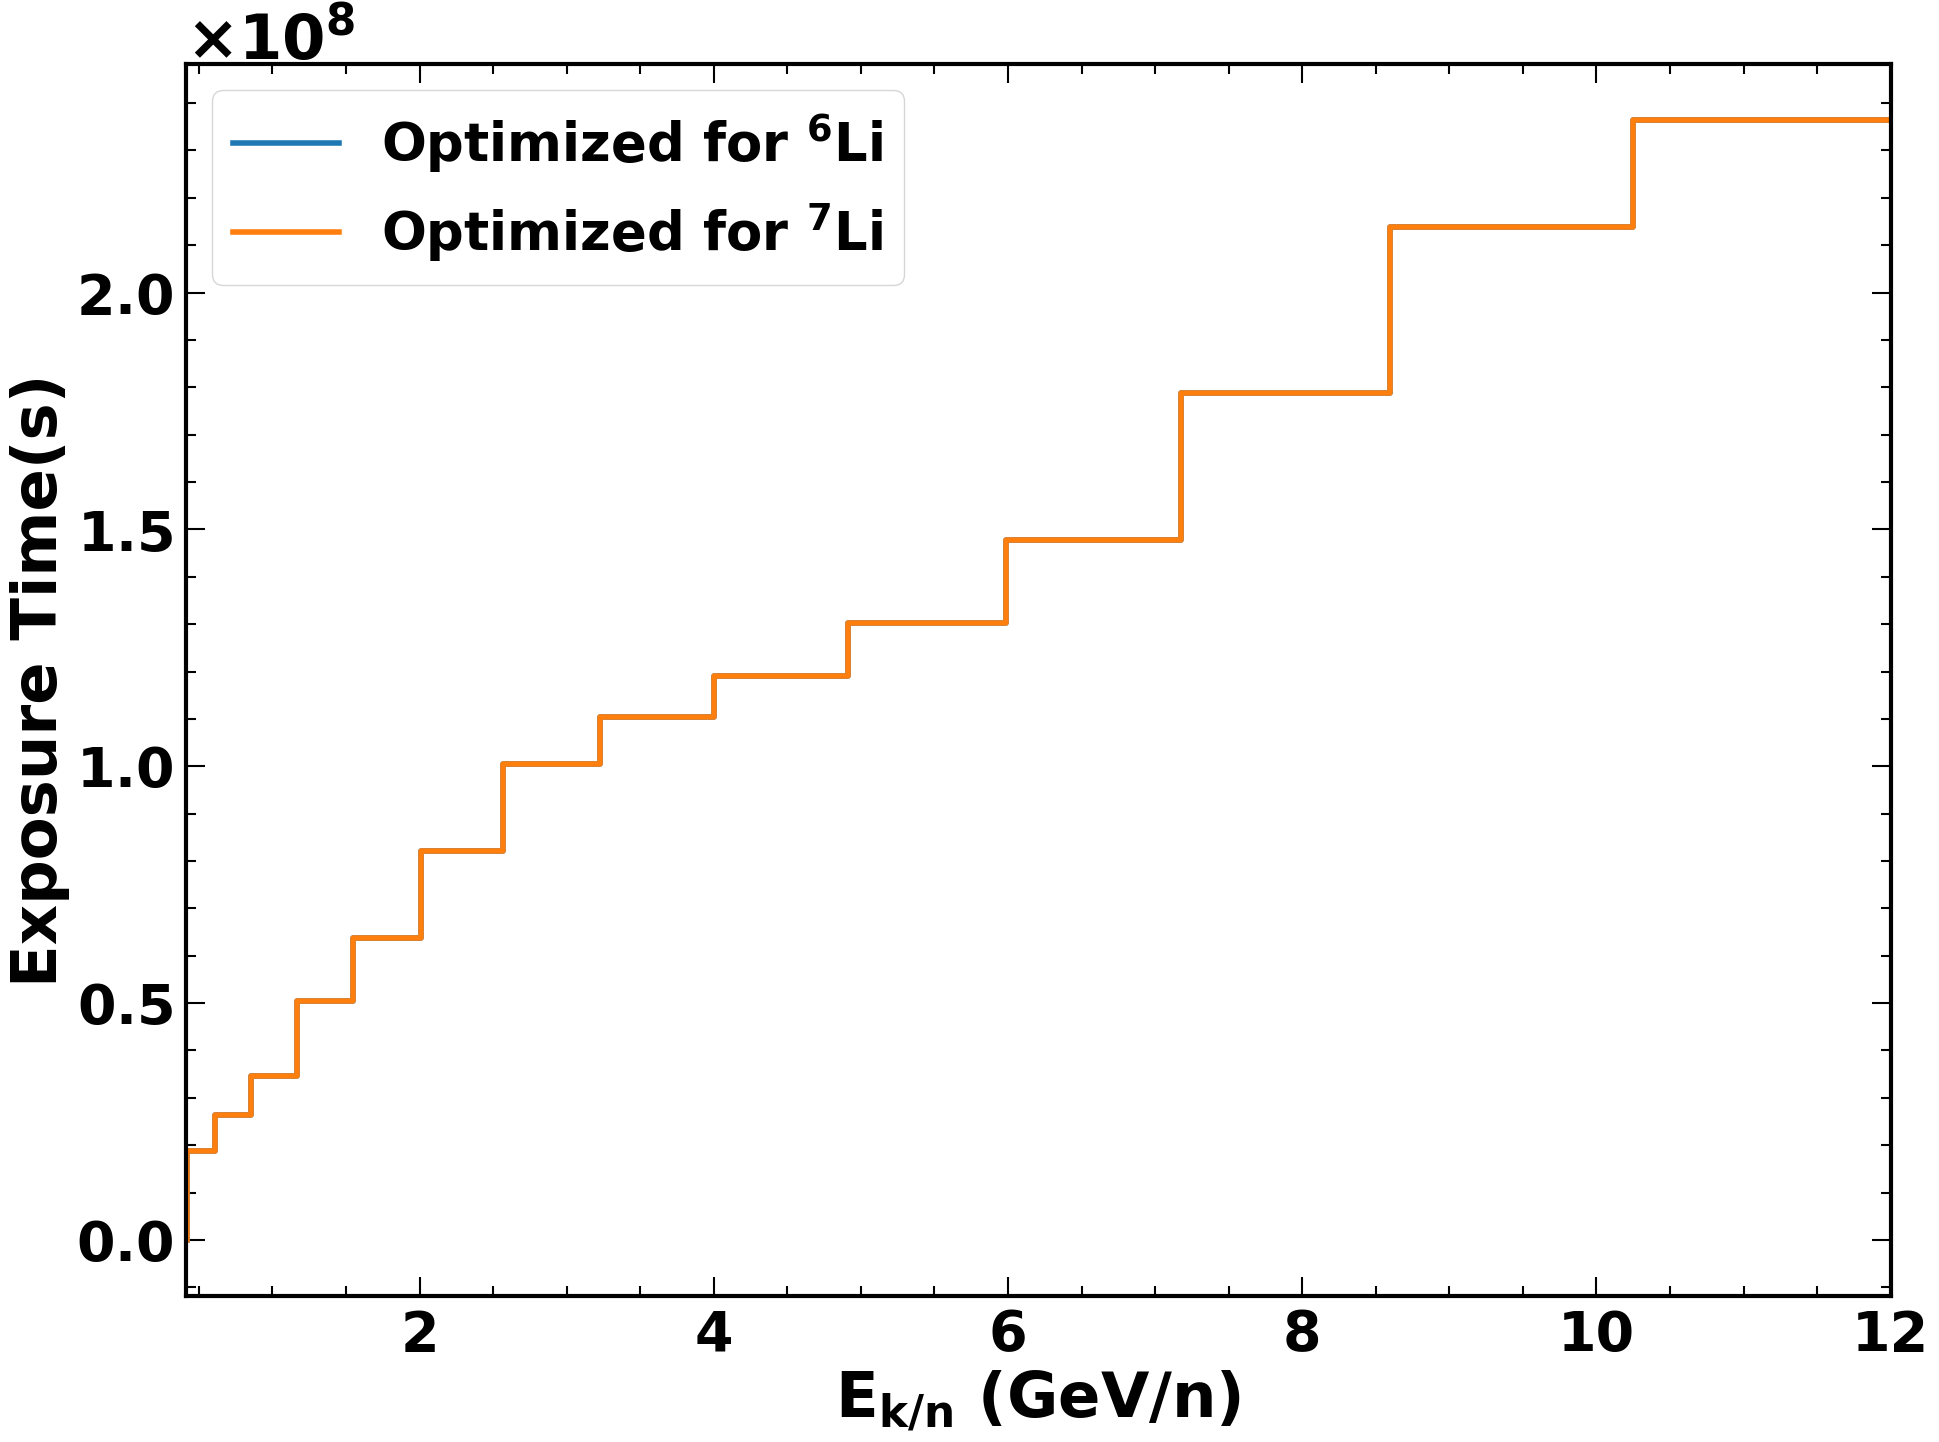

In [7]:
file_expotime_v0 = datadirP8 + 'expotime/LiExpotime_P8finebin.root'
hist_time_v0 = dict()
graph_measuretime_rebin = dict()
graph_measuretime = dict()
This_COLOR = {'Li6': 'tab:blue', 'Li7': 'tab:orange'}
print(xbinning.edges)
with uproot.open(file_expotime_v0) as filetime:  
    for iso in isotopes:
        hist_time_v0[iso] = filetime[f'h_expo_rig_1_Li6_finebin'] 
        yexpotime = hist_time_v0[iso].values()[1:-1:2]
        xvalue_time = hist_time_v0[iso].axes[0].edges()[1::2]
        graph_measuretime_rebin[iso] = MGraph(get_bin_center(xvalue_time), yexpotime, np.zeros_like(yexpotime)) 
        
        graph_measuretime[iso] = MGraph(get_bin_center(hist_time_v0[iso].axes[0].edges()), hist_time_v0[iso].values(), np.zeros_like(hist_time_v0[iso].values()))
        print(graph_measuretime[iso])
figure, ax1 = plt.subplots(1, 1, figsize=FIGSIZE3)
for i, iso in enumerate(['Li6', 'Li7']):                                                                                                                                                                                                                                                                                                                                                                    
    plot1d_step(figure, ax1, hist_time_v0[iso].axes[0].edges()[1::2], hist_time_v0[iso].values()[1:-1:2], err=None, label_x="Ekin/n (GeV/n)", label_y="counts",  legend=f'Optimized for {ISO_LABELS[iso]}', col=None, legendfontsize=18, setlogx=False, setlogy=False, setscilabelx=False, setscilabely=True, figsize=(12, 9),  tick_length=14, tick_width=1.5, color=This_COLOR[iso], linewidth=4)
    #plot1d_step(figure, ax1, hist_time_JH[iso].axes[0].edges(), hist_time[iso].values(), err=None, label_x="Ek/n(GeV/n)", label_y="counts",  legend=None, col=None, legendfontsize=18, setlogx=False, setlogy=False, setscilabelx=False, setscilabely=False, figsize=(12, 9),  tick_length=14, tick_width=1.5, color='black')
    ax1.set_xlim([0.41, 12])
    ax1.set_ylabel('Exposure Time(s)',fontsize=45)
    ax1.set_xlabel(r"$\mathrm{E_{k/n} \ (GeV/n)}$", fontsize=45)
    ax1.tick_params(axis='both', labelsize=40)
    ax1.legend(fontsize=38)
    print(plotdir)
    set_plot_style(ax1)
    savefig_tofile(figure, plotdir, f"Li_measuring_time_P811yr_v0", 1)   


[ 0.4061  0.4909  0.5876  0.6964  0.8215  0.9589  1.113   1.2839  1.4714
  1.6803  1.9105  2.1621  2.4349  2.7338  3.0588  3.4096  3.7913  4.2037
  4.6468  5.1404  5.6349  6.1798  6.775   7.4206  8.1166  8.8629  9.6596
 10.5065 11.4536 12.451 ] [2.17480954e+07 2.64434654e+07 3.11362379e+07 3.53498346e+07
 4.24255333e+07 5.19717033e+07 5.89233021e+07 6.64194070e+07
 7.58804300e+07 8.67114761e+07 9.70205828e+07 1.04454124e+08
 1.09792518e+08 1.14322119e+08 1.18818899e+08 1.23845535e+08
 1.29535722e+08 1.36961208e+08 1.45949538e+08 1.58743472e+08
 1.76326004e+08 1.94944627e+08 2.12491701e+08 2.28216958e+08
 2.37730832e+08 2.44269603e+08 2.47684350e+08 2.47774063e+08
 2.47784688e+08]
[ 0.4061  0.4909  0.5876  0.6964  0.8215  0.9589  1.113   1.2839  1.4714
  1.6803  1.9105  2.1621  2.4349  2.7338  3.0588  3.4096  3.7913  4.2037
  4.6468  5.1404  5.6349  6.1798  6.775   7.4206  8.1166  8.8629  9.6596
 10.5065 11.4536 12.451 ] [2.17480954e+07 2.64434654e+07 3.11362379e+07 3.53498346e+07
 4.24

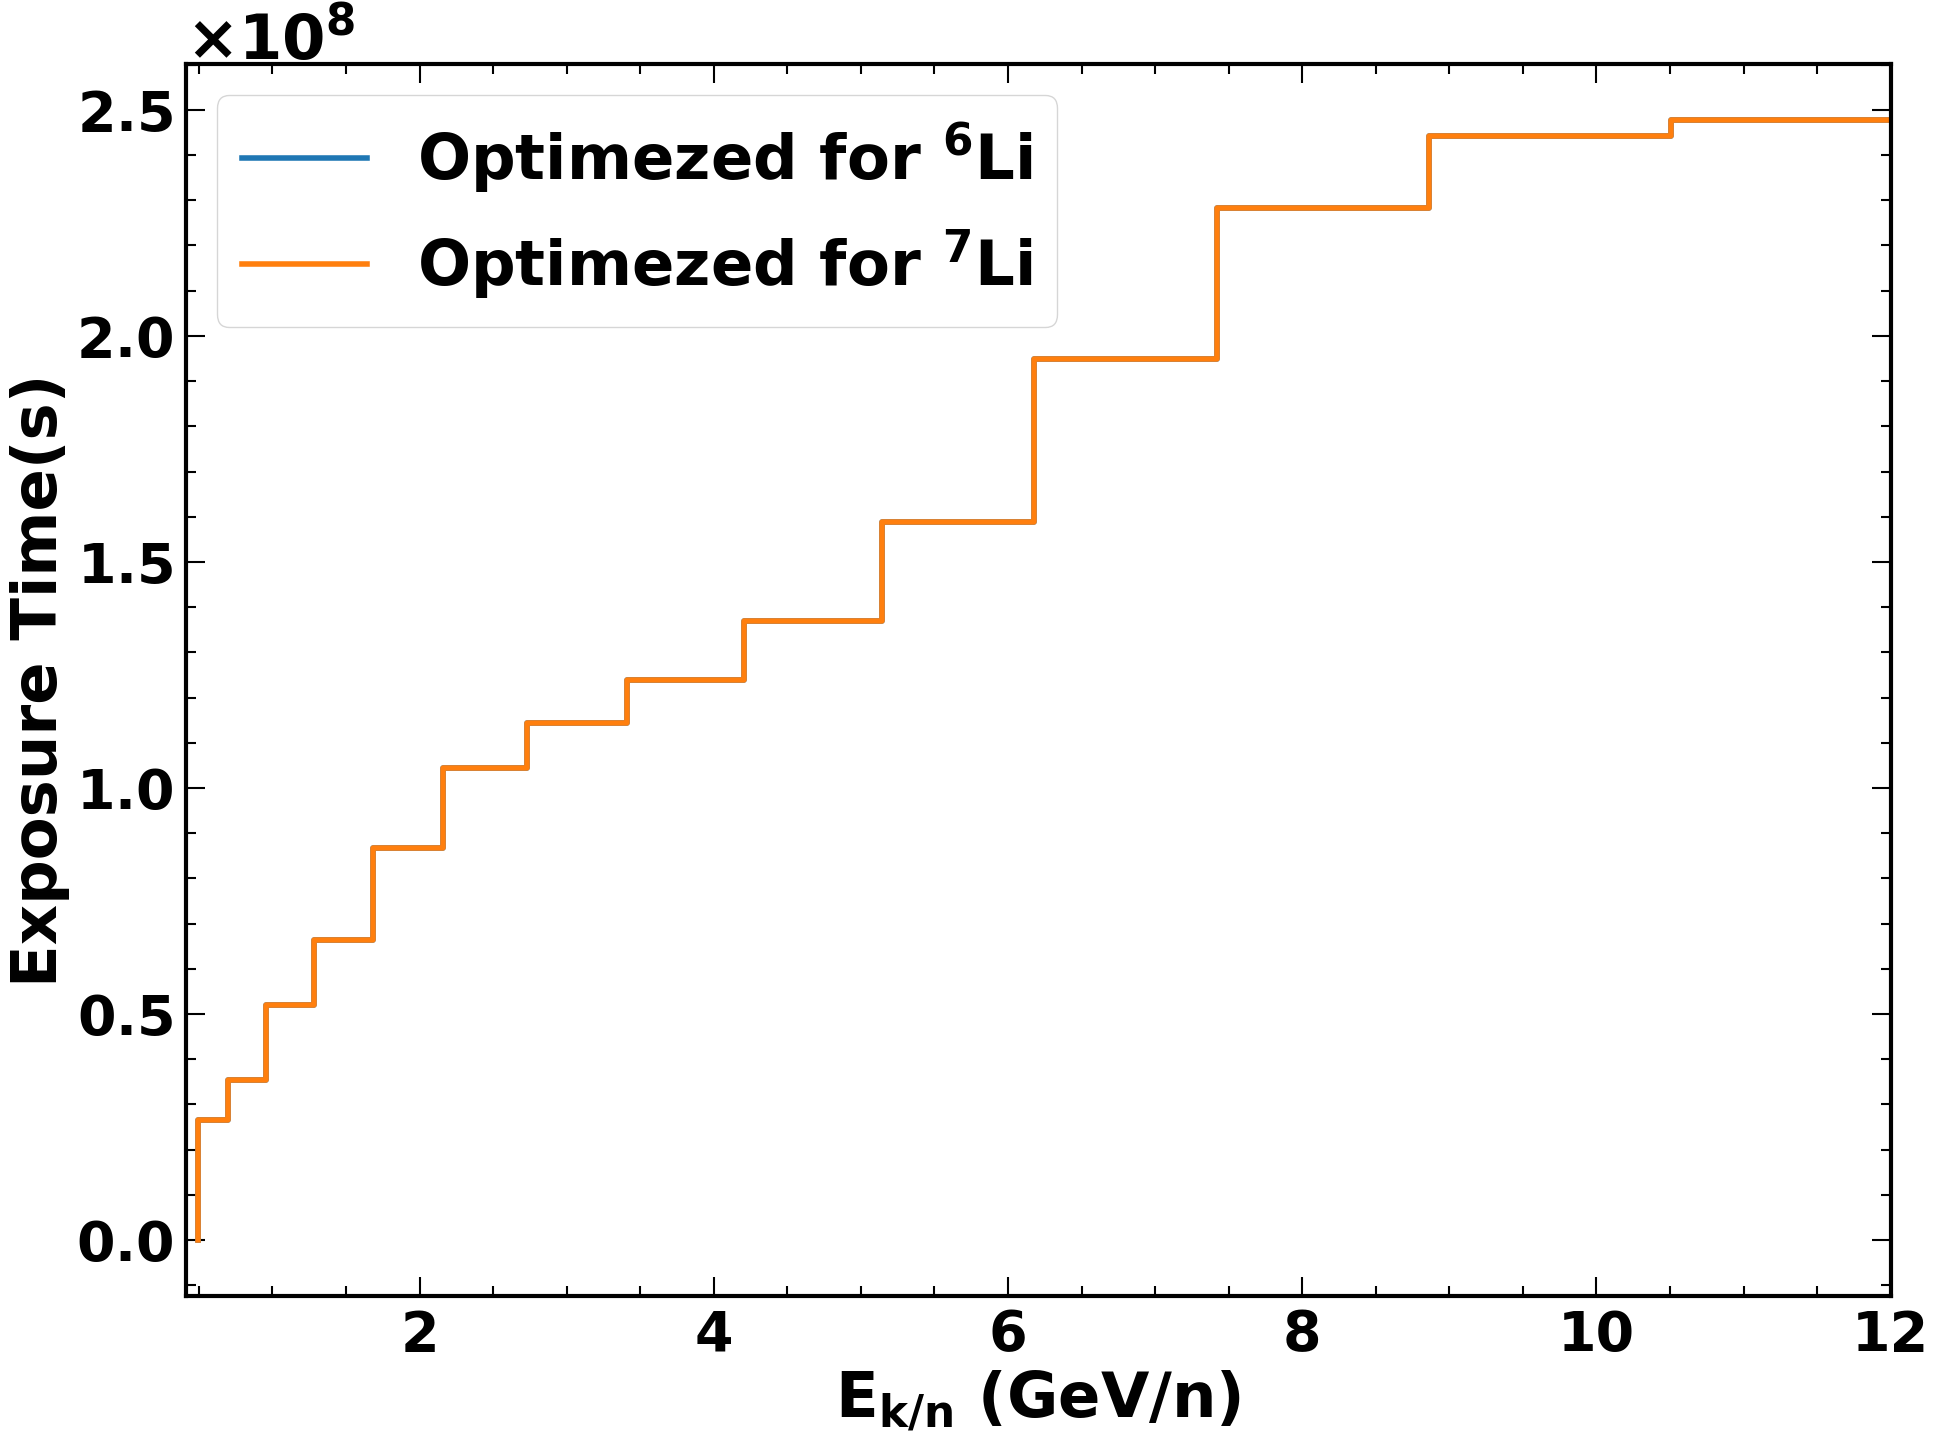

In [8]:
file_expotime = '/home/manbing/Documents/Data/data_BeP8/Jiahui/expo_time_sf_finebin_pass8_LiBeB.root'
hist_time = dict()
graph_measuretime = dict()
This_COLOR = {'Li6': 'tab:blue', 'Li7': 'tab:orange'}
with uproot.open(file_expotime) as filetime:  
    for iso in isotopes:  
        hist_time[iso] = filetime[f'h_expo_rig_li_1_li7_bina6'] 
        yexpotime = hist_time[iso].values()
        xvalue_time = hist_time[iso].axes[0].edges()
        
        print(xvalue_time, yexpotime)
        graph_measuretime[iso] = MGraph(get_bin_center(xvalue_time), yexpotime, np.zeros_like(yexpotime)) 

figure, ax1 = plt.subplots(1, 1, figsize=FIGSIZE3)
for i, iso in enumerate(['Li6', 'Li7']):                                                                                                                                                                                                                                                                                                                                                                    
    plot1d_step(figure, ax1, hist_time[iso].axes[0].edges()[1::2], hist_time[iso].values()[1:-1:2], err=None, label_x="Ekin/n (GeV/n)", label_y="counts",  legend=f'Optimezed for {ISO_LABELS[iso]}', col=None, legendfontsize=18, setlogx=False, setlogy=False, setscilabelx=False, setscilabely=True, figsize=(12, 9),  tick_length=14, tick_width=1.5, color=This_COLOR[iso], linewidth=4)
    #plot1d_step(figure, ax1, hist_time_JH[iso].axes[0].edges(), hist_time[iso].values(), err=None, label_x="Ek/n(GeV/n)", label_y="counts",  legend=None, col=None, legendfontsize=18, setlogx=False, setlogy=False, setscilabelx=False, setscilabely=False, figsize=(12, 9),  tick_length=14, tick_width=1.5, color='black')
    ax1.set_xlim([0.41, 12])
    ax1.set_ylabel('Exposure Time(s)',fontsize=45)
    ax1.set_xlabel(r"$\mathrm{E_{k/n} \ (GeV/n)}$", fontsize=45)
    ax1.tick_params(axis='both', labelsize=40)
    ax1.legend()
    print(plotdir)
    set_plot_style(ax1)
  
    savefig_tofile(figure, plotdir, f"Li_measuring_time_P811yr_Two", 1)   


['graph_total_effcor_tof_xvalues', 'graph_total_effcor_tof_yvalues', 'graph_total_effcor_tof_yerrs', 'graph_total_effcor_tof_labels', 'graph_total_effcor_naf_xvalues', 'graph_total_effcor_naf_yvalues', 'graph_total_effcor_naf_yerrs', 'graph_total_effcor_naf_labels', 'graph_total_effcor_agl_xvalues', 'graph_total_effcor_agl_yvalues', 'graph_total_effcor_agl_yerrs', 'graph_total_effcor_agl_labels']


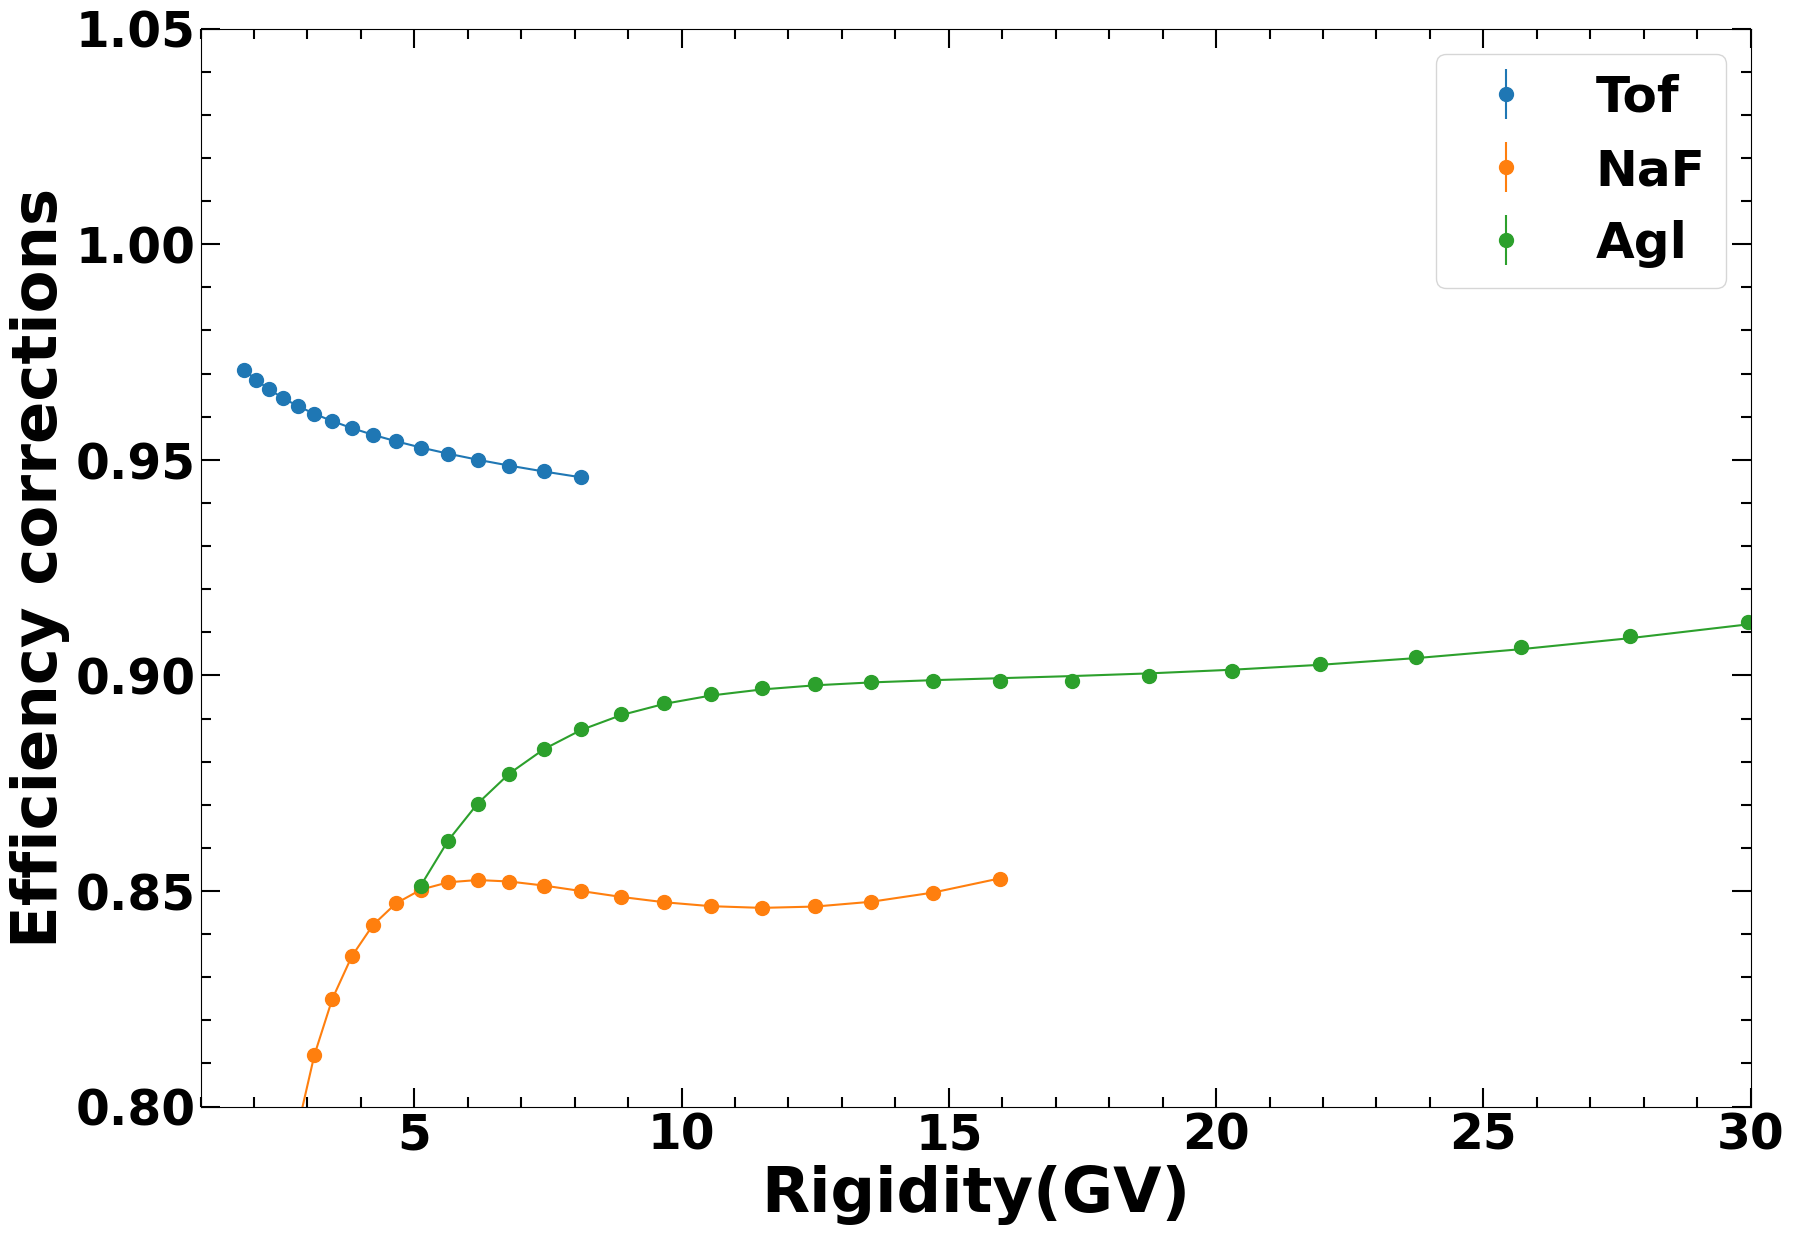

In [9]:
file_effcor = '/home/manbing/Documents/Data/data_LiP8/efficiency/spline_effcor/Ligraph_total_effcor.npz'
df_effcor = np.load(f'{file_effcor}')
print(list(df_effcor.keys()))
graph_total_effcor = dict()
spline_total_effcor = dict()
rigidity_range = {'Tof':[1.8, 8], 'NaF':[2.9, 16], 'Agl':[5, 40]}

for dec in detectors:
    graph_total_effcor[dec] = MGraph.from_file(df_effcor, f'graph_total_effcor_{detectors_alias[dec]}')
    graph_total_effcor[dec] = slice_graph_by_value(graph_total_effcor[dec], rigidity_range[dec])
    spline_total_effcor[dec] = UnivariateSpline(np.log(graph_total_effcor[dec].xvalues),graph_total_effcor[dec].yvalues, k=3, s=5)           

figure, ax1 = plt.subplots(1, 1, figsize=(20, 14))         
for dec in detectors:
    plot_graph(figure, ax1, graph_total_effcor[dec], color=DETECTOR_COLOR[dec], label=f"{dec}", style="EP", xlog=False, ylog=False, markersize=20)
    ax1.plot(graph_total_effcor[dec].xvalues, spline_total_effcor[dec](np.log(graph_total_effcor[dec].xvalues)), '-', color=DETECTOR_COLOR[dec])
    ax1.set_xlim([1, 30])
    ax1.legend()
    ax1.set_ylim([0.8, 1.05])
    ax1.set_xlabel('Rigidity(GV)')
    ax1.set_ylabel('Efficiency corrections')
    
savefig_tofile(figure, plotdir, f"effcor_{variable}_P7B1220_vsR", 1)   
    

Tof Li6 [ 1.61360942  1.82845082  2.04162612  2.2821205   2.54265313  2.82832866
  3.13896515  3.47469171  3.8405714   4.2365063   4.66752276  5.13864528
  5.64984695  6.2011141   6.79749471  7.4441636   8.14089036  8.89271849
  9.70474814 10.57685456 11.52925099 12.53172741 13.58436828 14.73725594
 15.99035553 17.3437685  18.79741811 20.35124254 22.00488639 23.80988768]
Tof Li7 [ 1.88210323  2.13269279  2.38133903  2.66185007  2.96573358  3.29894361
  3.66126793  4.05285715  4.47961676  4.94143258  5.44416729  5.99368144
  6.58994365  7.23293797  7.92855231  8.68282258  9.49548    10.3724073
 11.31955324 12.33677233 13.44764115 14.61692294 15.8447162  17.18943664
 18.65104361 20.22965544 21.92518261 23.73755303 25.66635213 27.77169355]
NaF Li6 [ 1.61360942  1.82845082  2.04162612  2.2821205   2.54265313  2.82832866
  3.13896515  3.47469171  3.8405714   4.2365063   4.66752276  5.13864528
  5.64984695  6.2011141   6.79749471  7.4441636   8.14089036  8.89271849
  9.70474814 10.57685456 1

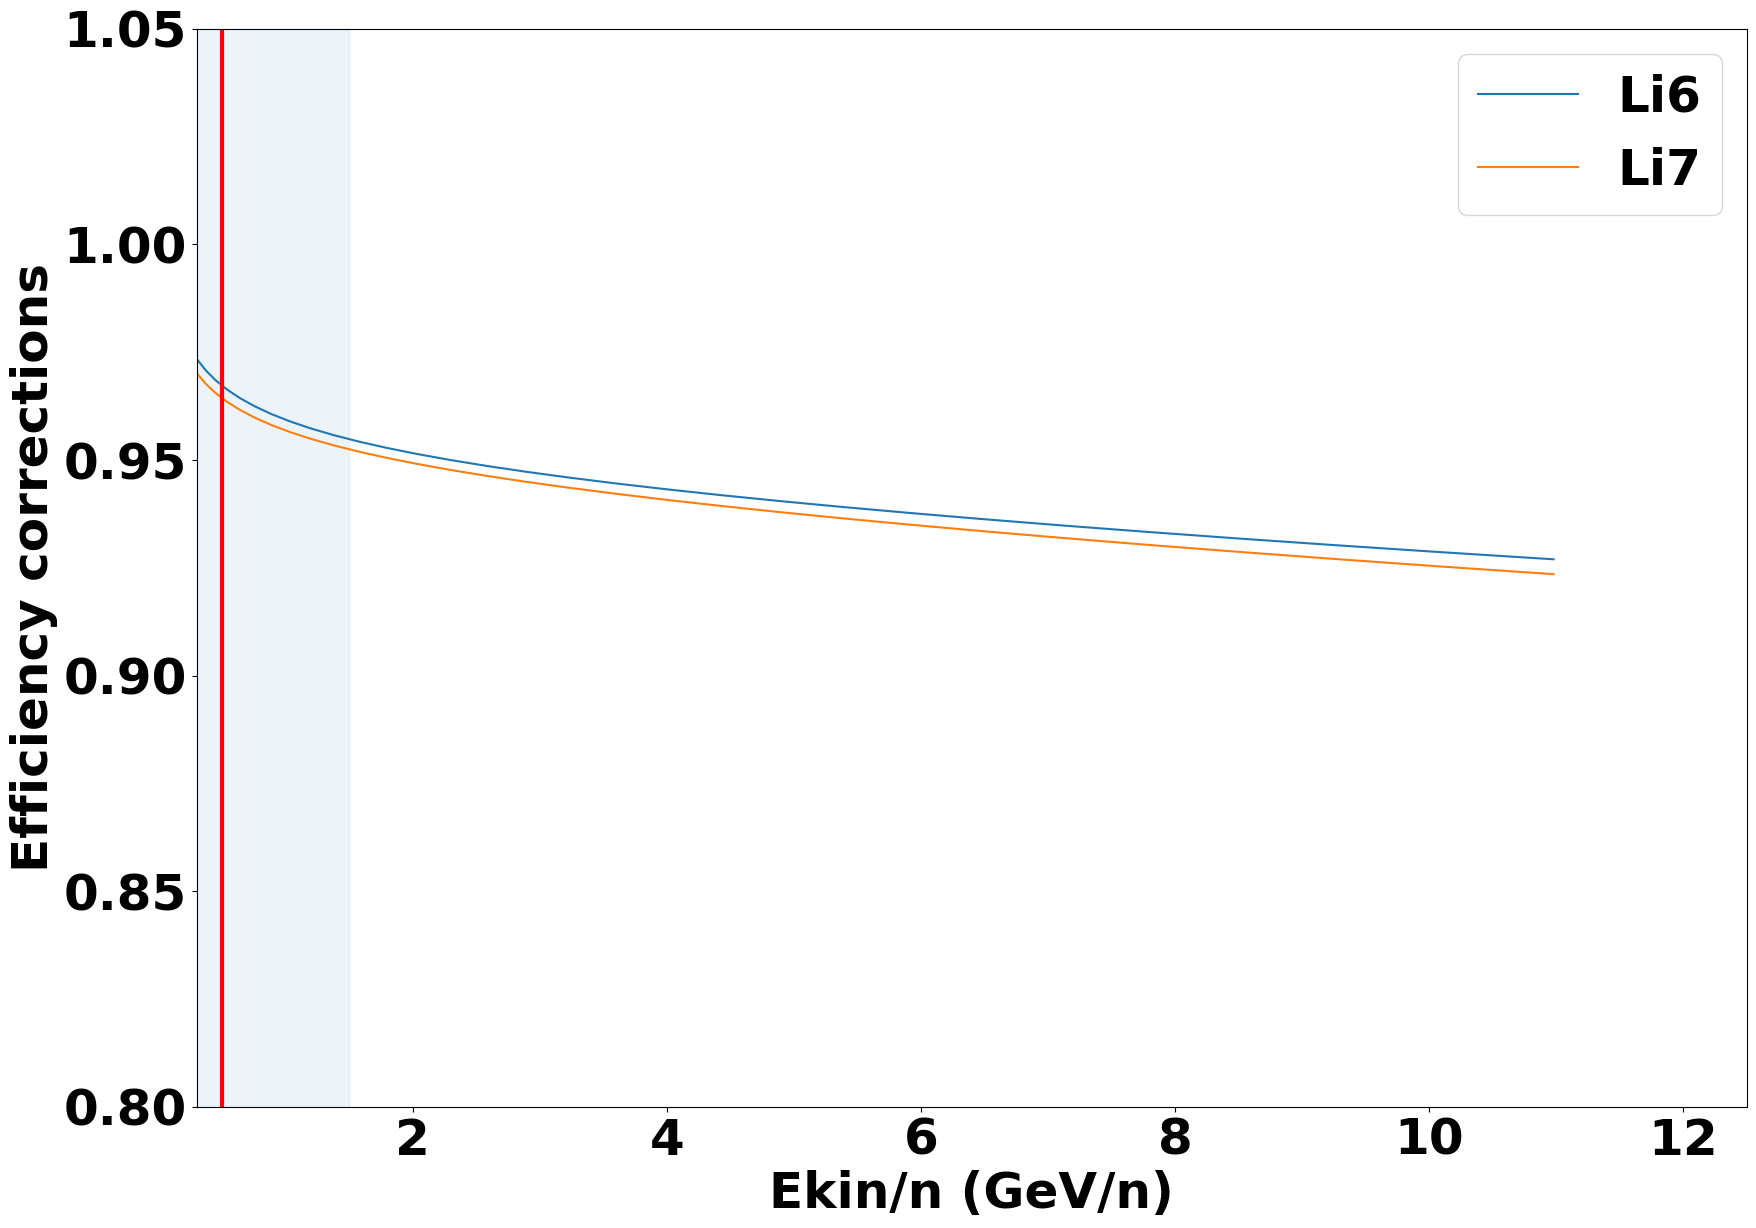

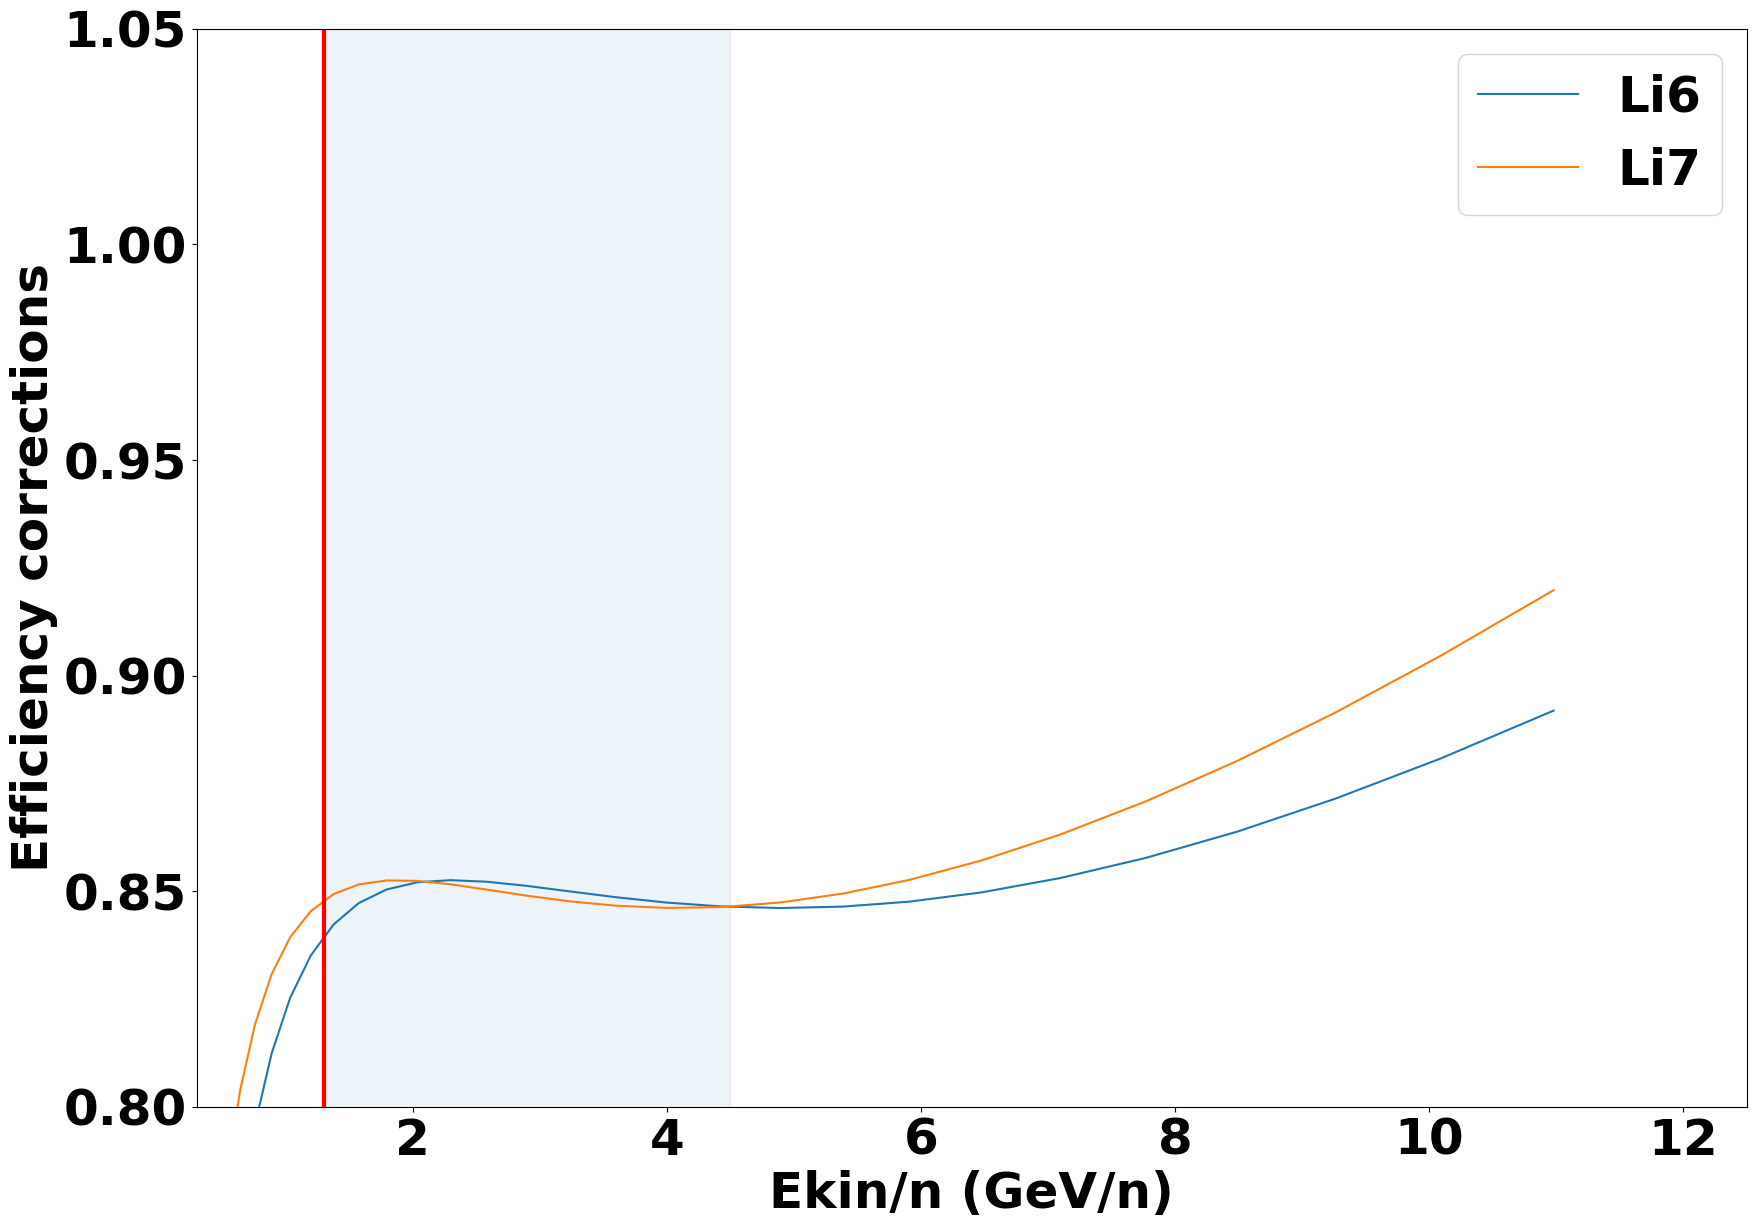

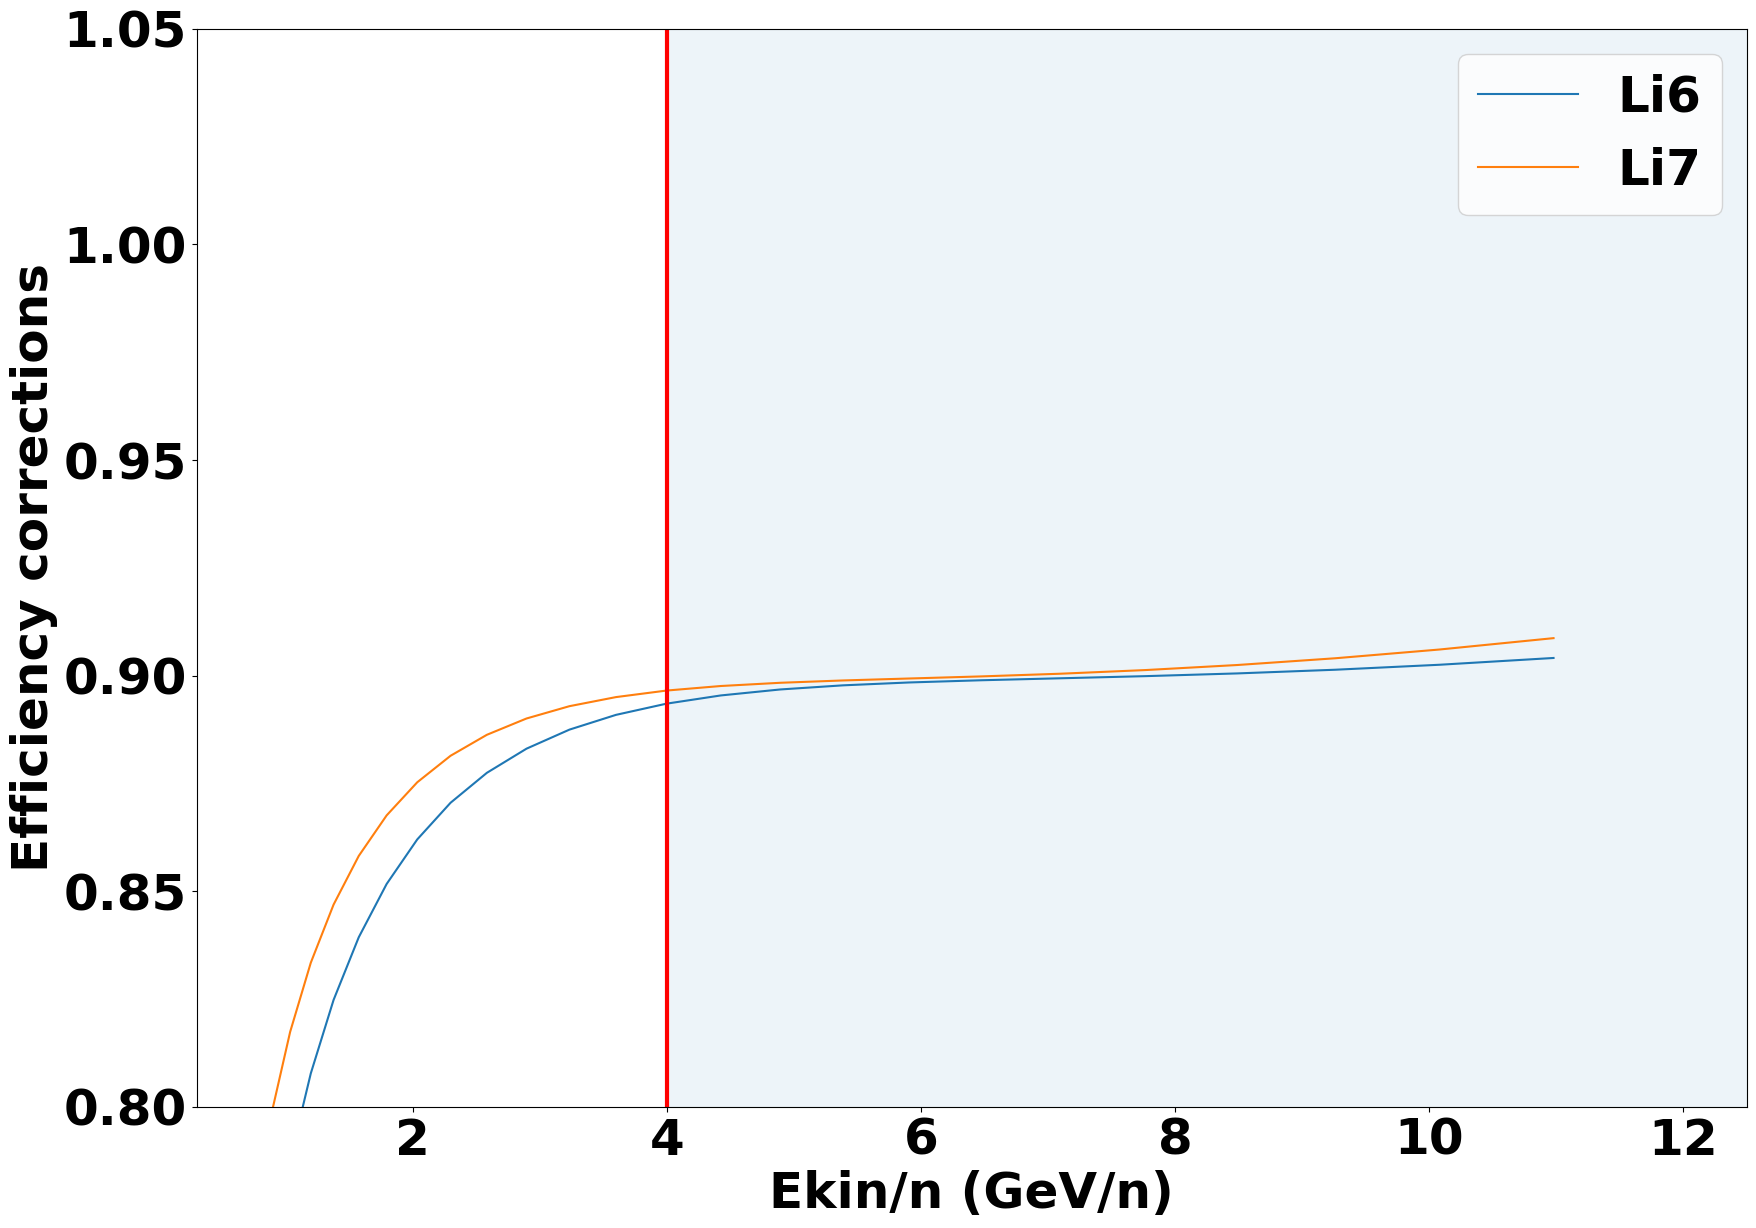

In [10]:
graph_total_effcor_ekin = {dec: dict() for dec in detectors} 

xrigidity_from_ekin = dict()     
eff_cor_ekin = dict()
dec_startekin = {'Tof': 0.5, 'NaF':1.3, 'Agl':4.0}
ekin_range = {'Tof':[0.2, 1.5], 'NaF':[1.3, 4.5], 'Agl': [4.0, 13]}
for dec in detectors:                                                                                                                                                                                          
    for iso in ISOTOPES[nuclei]:                                                                                                                                                                               
        xrigidity_from_ekin[iso] = calc_rig_from_ekin(xbinning.bin_centers[1:-1], ISOTOPES_MASS[iso], NUCLEI_CHARGE[nuclei])                                                                           
        eff_cor_ekin[dec] = spline_total_effcor[dec](np.log(xrigidity_from_ekin[iso]))  
        print(dec, iso, xrigidity_from_ekin[iso])
        graph_total_effcor_ekin[dec][iso] = MGraph(xbinning.bin_centers[1:-1], eff_cor_ekin[dec], np.zeros_like(eff_cor_ekin[dec]))  
        
for dec in detectors:
    figure, ax1 = plt.subplots(1, 1, figsize=(20, 14))   
    #plot_graph(figure, ax1, graph_total_effcor_ekin[dec], color=DETECTOR_COLOR[dec], label=f"{dec}", style="EP", xlog=False, ylog=False, markersize=20)
    for iso in isotopes:
        ax1.plot(graph_total_effcor_ekin[dec][iso].xvalues, graph_total_effcor_ekin[dec][iso].yvalues, '-', color=ISOTOPES_COLOR[iso], label=f'{iso}')
        #ax1.set_xlim(ekin_range[dec])
        ax1.legend()
        ax1.set_ylim([0.8, 1.05])
        ax1.set_xlabel('Ekin/n (GeV/n)')
        ax1.set_ylabel('Efficiency corrections')
        ax1.set_xlim([0.3, 12.5])
    ax1.axvline(x=dec_startekin[dec], color='r', linestyle='-', linewidth=3) 
    ax1.fill_betweenx(np.linspace(0.4, 1.1, 100), ekin_range[dec][0], ekin_range[dec][1], alpha=0.08, color="tab:blue") 

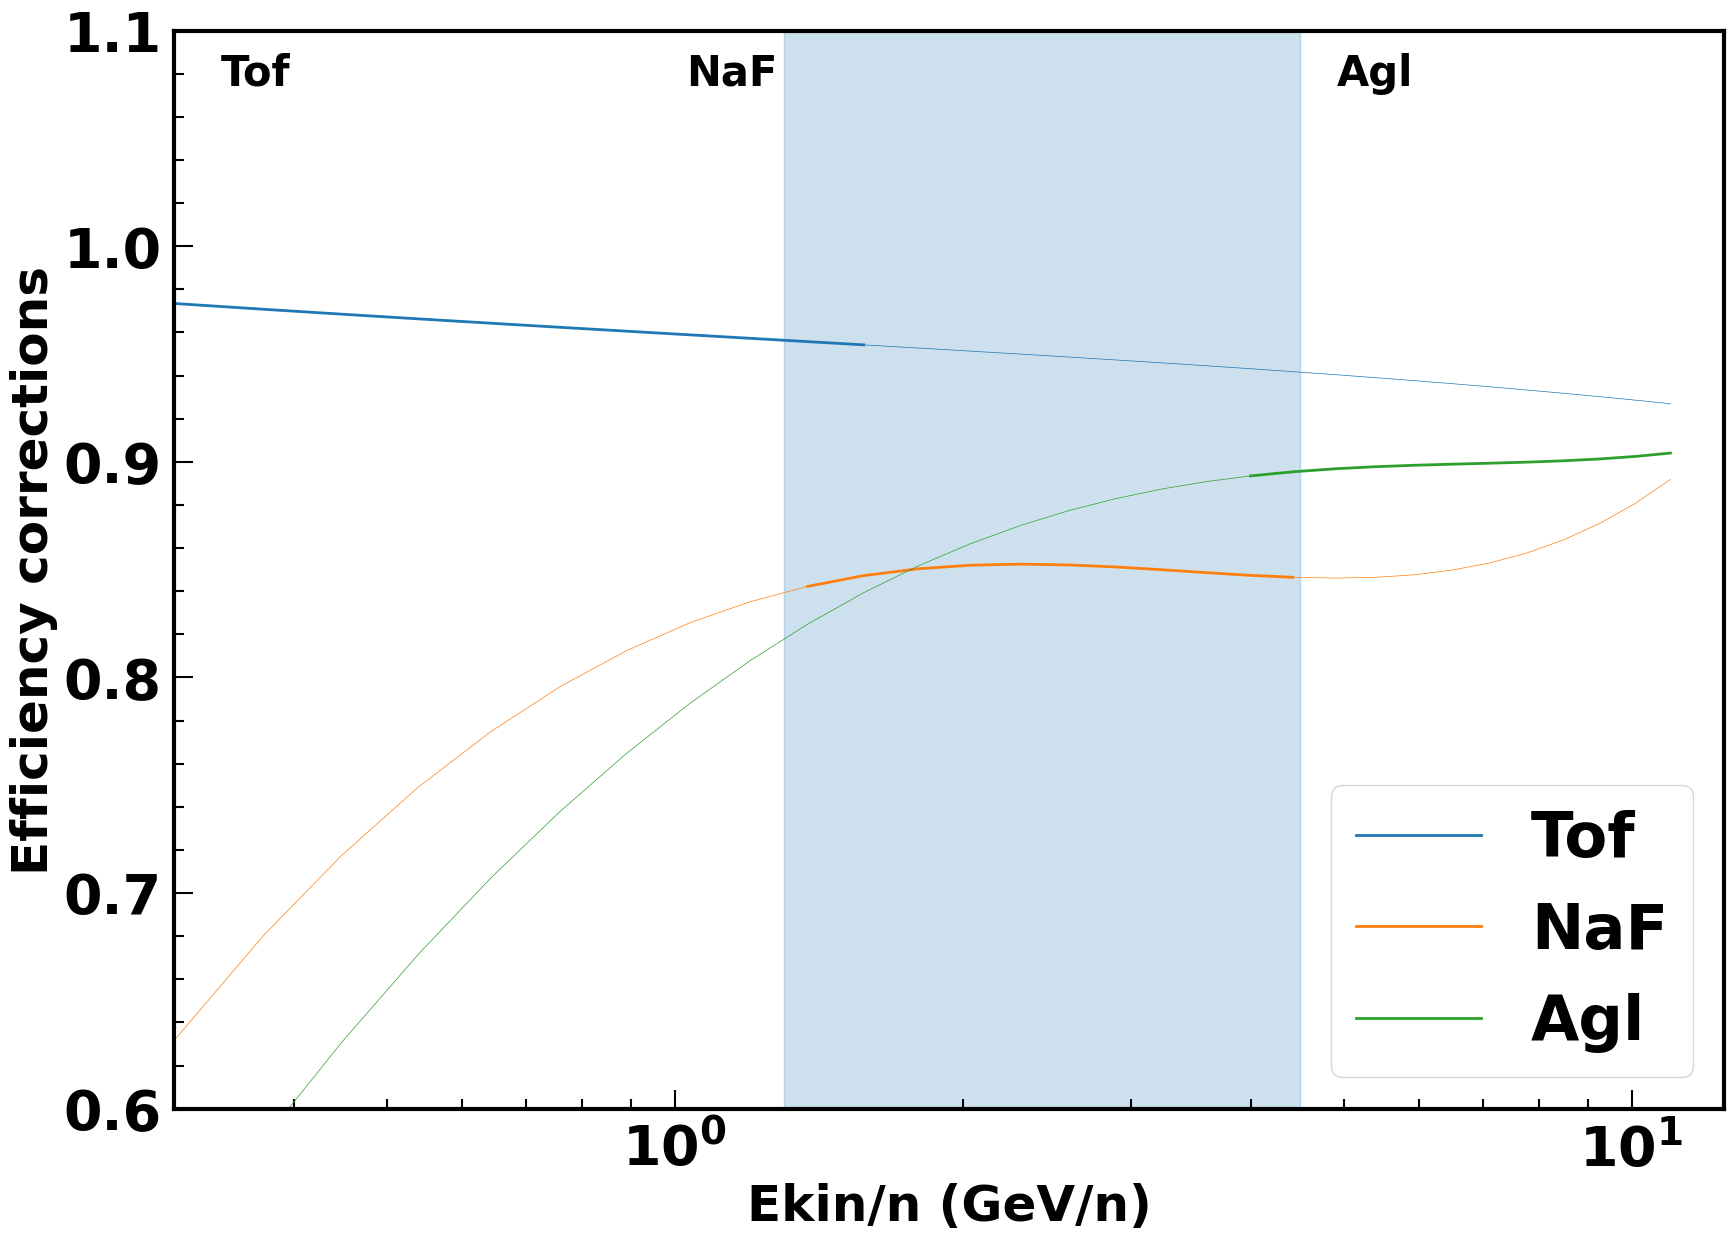

In [11]:
MISO = 'Li6'
subgraph_effcorLi6 = dict()
ekin_range = {'Tof':[0.2, 1.2], 'NaF':[1.13, 5], 'Agl': [3.0, 12]}
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}

figure, ax1 = plt.subplots(1, 1, figsize=(20, 14))   
subgraph_effcorLi6 = dict()
ekin_range = {'Tof':[0.2, 1.5], 'NaF':[1.3, 4.5], 'Agl': [4.0, 12]}
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
for dec in detectors:    
    subgraph_effcorLi6[dec] = slice_graph_by_value(graph_total_effcor_ekin[dec][MISO], ekin_range[dec])
    ax1.plot(graph_total_effcor_ekin[dec][MISO].xvalues, graph_total_effcor_ekin[dec][MISO].yvalues, '-', color=DETECTOR_COLOR[dec], linewidth=0.5)
    ax1.plot(subgraph_effcorLi6[dec].xvalues, subgraph_effcorLi6[dec].yvalues, '-', color=DETECTOR_COLOR[dec], label=f'{dec}', linewidth=2.0)
    #ax1.set_xlim([1, 30])
    set_plot_style(ax1)
    #SetAx1Axis(ax1, '1/m (1/GeV)', 'Events', 45, xlimrange=[3.0, 12.0], ylimrange=[0.5, 1.6], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False)
    ax1.legend(loc='lower right')
    ax1.set_ylim([0.6, 1.1])
    ax1.set_xscale('log')
    ax1.set_xlabel('Ekin/n (GeV/n)')
    ax1.set_ylabel('Efficiency corrections')
    ax1.set_xlim([0.3, 12.5])
    
    ax1.fill_betweenx(np.linspace(0.4, 1.1, 100), ekin_range['NaF'][0], ekin_range['NaF'][1], alpha=0.08, color="tab:blue") 
    ax1.text(xaxistext[dec], 0.98, f"{dec}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      



################################################################################################ <br>
####compute the raw flux with counts from the fit <font color="red">all paremeters free</font>  
#################################################################################################

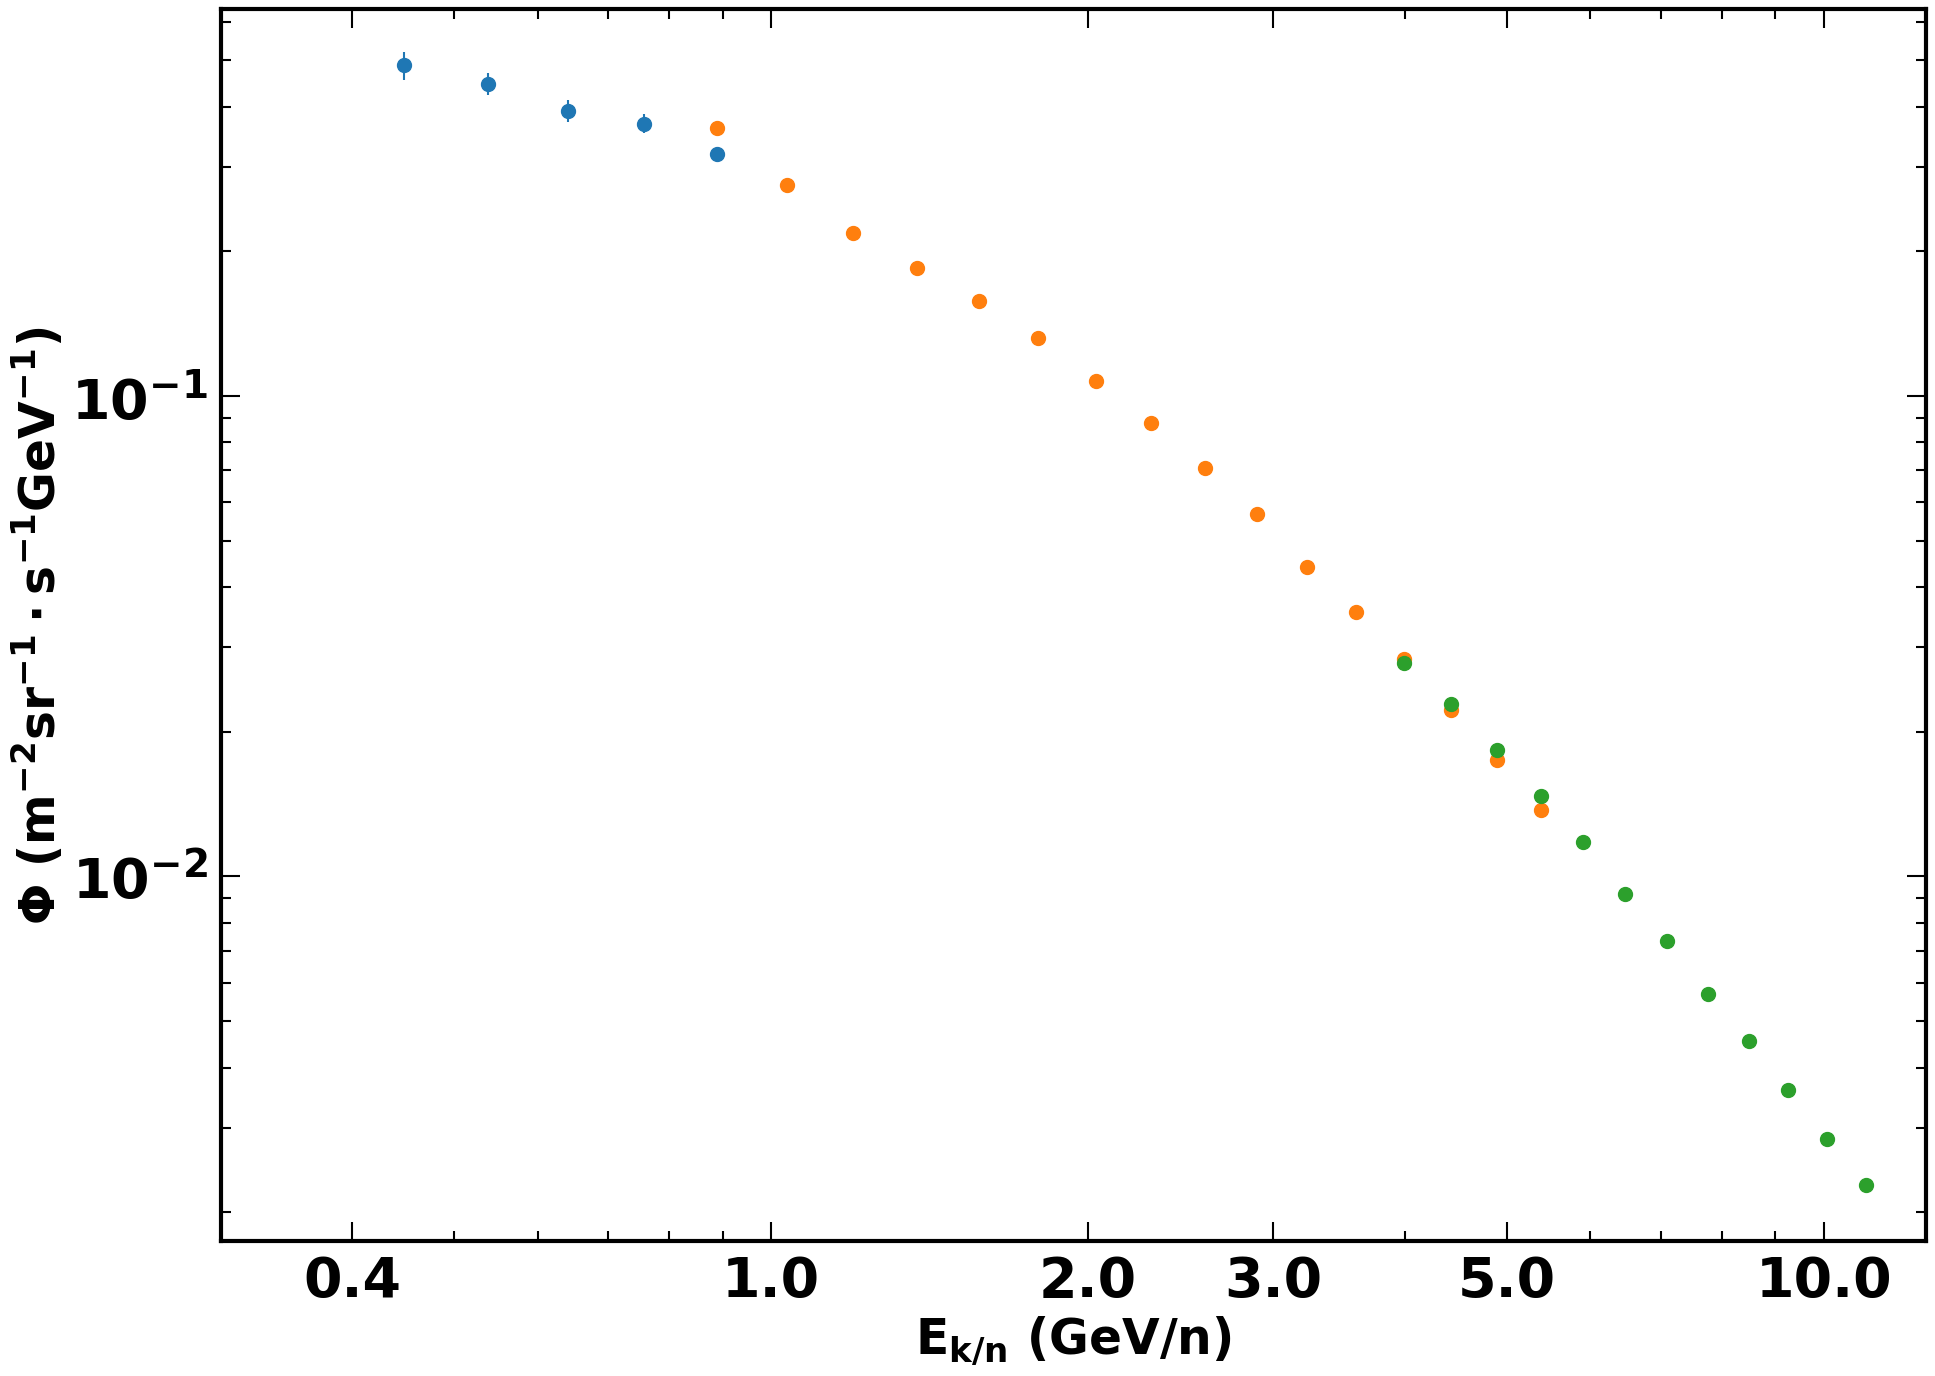

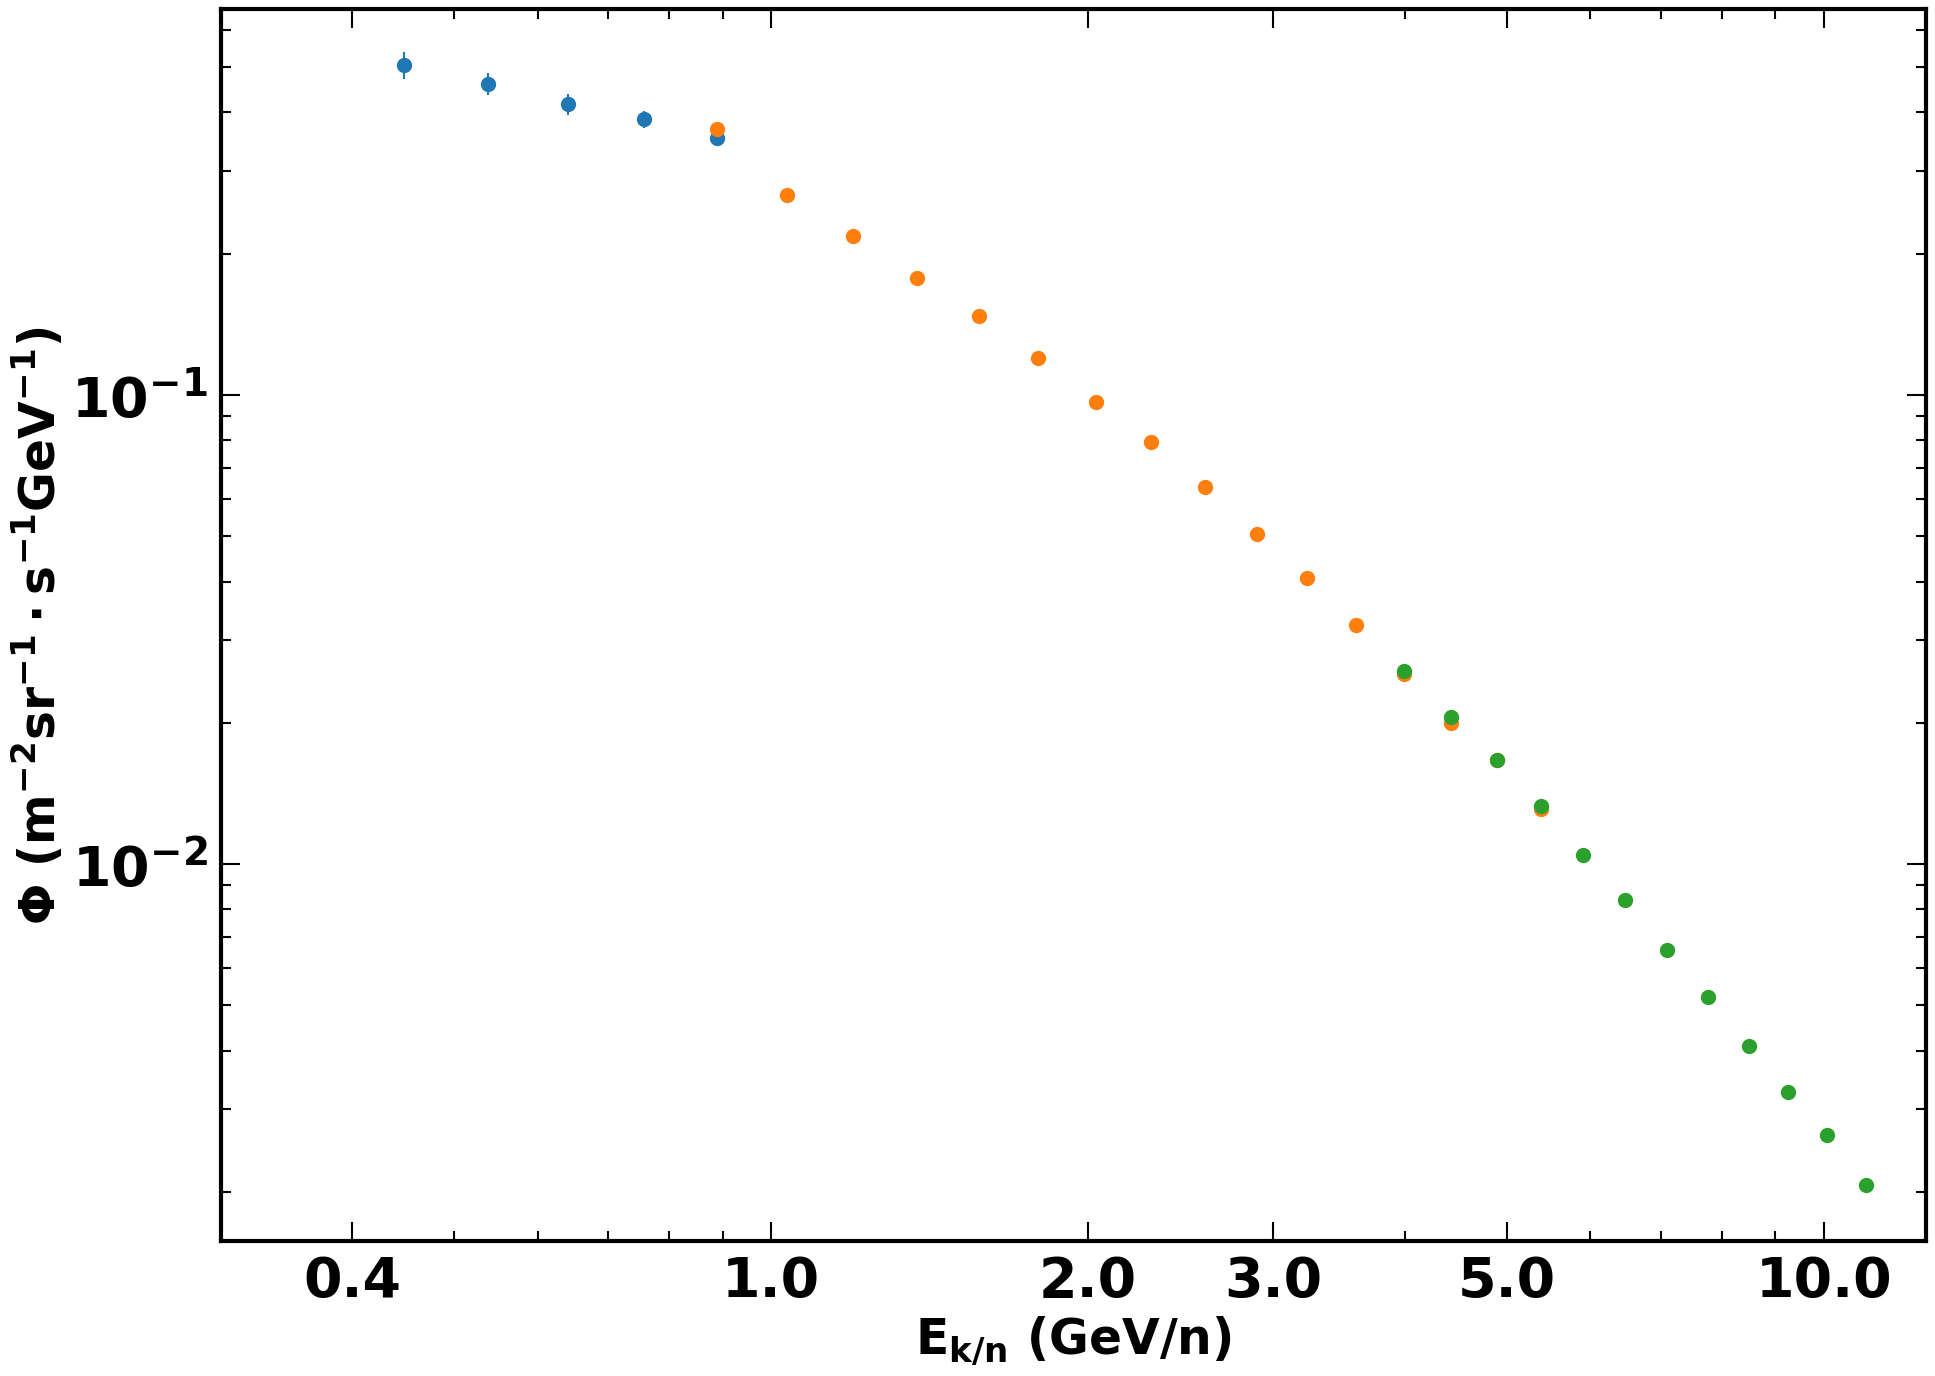

In [12]:
graph_flux_raw = {dec: dict() for dec in detectors} 
graph_unfoldflux = {dec: dict() for dec in detectors}
#xbinning = {"Rigidity": Binning(fbinning_energy()), "Ekin":Binning(fbinning_energy())}   
df_rawflux = dict() 
df_unfoldflux = dict()
subgraph_unfoldfactor = {}
data_dict ={dec:  dict() for dec in detectors}
for dec in detectors:     
    
    for iso in ISOTOPES[nuclei]:
        graph_counts =graph_counts_fromfit[dec][iso]
        xenergy = graph_counts.xvalues       
       
        #graph_accraw = slice_graph_by_value(graph_acc[dec][iso], [xenergy[0], xenergy[-1]])  
        graph_accraw = MGraph(xenergy, spline_subgraph_acc[dec][iso](np.log(xenergy)), 0.01*spline_subgraph_acc[dec][iso](np.log(xenergy)))
        #print(graph_measuretime[iso])
        if isrebin:
            graph_time = slice_graph_by_value(graph_measuretime_rebin[iso], [xenergy[0], xenergy[-1]]) 
        else:
            graph_time = slice_graph_by_value(graph_measuretime[iso], [xenergy[0], xenergy[-1]]) 

      
        
        graph_effcor = slice_graph_by_value(graph_total_effcor_ekin[dec][iso], [xenergy[0], xenergy[-1]]) 
        #graph_unfold = MGraph(xenergy, spline_unfoldfactor[iso](np.log(xenergy)), np.zeros_like(xenergy))

        counts = graph_counts.yvalues                                                                                                                                                                
        counts_err = graph_counts.yerrs                                                                                                                                                              
        effcor = graph_effcor.yvalues
        #acc = spline_subgraph_acc[dec][iso](np.log(xenergy))  
        acc = graph_accraw.yvalues
        acc_err = graph_accraw.yerrs
        
        
        indices = xbinning.get_indices([xenergy[0], xenergy[-1]])                                                                                                                                    
        #bin_widths = xbinning.bin_widths[indices[0]: indices[1]+1]                                                                                                                                  
        bin_edges = xbinning.edges[indices[0]: indices[1]+2]   

        bin_widths = bin_edges[1:] - bin_edges[:-1]  
        
        assert (np.all((xenergy - graph_effcor.xvalues) < 0.1))  
        assert (np.all((xenergy - graph_time.xvalues) < 0.1))   
        assert (np.all((xenergy - get_bin_center(bin_edges)) < 0.1)) 
        assert (np.all((xenergy - graph_accraw.xvalues) < 0.1)) 
    
        
        flux_raw = counts / (effcor * acc *graph_time.yvalues * bin_widths)                                                                                                                               
        flux_raw_err = flux_raw * np.sqrt((counts_err/counts)**2 + (acc_err/acc)**2)                                                                                                                         
        graph_flux_raw[dec][iso] = MGraph(xenergy, flux_raw, flux_raw_err)                                                                                                                                                 
        graph_flux_raw[dec][iso].add_to_file(df_rawflux, f'graph_rawflux_{dec}{iso}')
        
        #unfold_factor = graph_unfold.yvalues
        #assert (np.all(xenergy == graph_unfold.xvalues))
        #unfoldflux = flux_raw * graph_unfold.yvalues
        #unfoldfluxerr = flux_raw_err * graph_unfold.yvalues
        #graph_unfoldflux[dec][iso] = MGraph(xenergy, unfoldflux, unfoldfluxerr)
        
        #data_dict[dec][iso] = np.column_stack((bin_edges[0:-1], bin_edges[1:], counts, counts_err, graph_time.yvalues, acc, effcor, unfold_factor))



for iso in ISOTOPES[nuclei]:
    fig, ax1 = plt.subplots(figsize=(22, 16))
    for dec in detectors:
        plot_graph(fig, ax1, graph_flux_raw[dec][iso], color=DETECTOR_COLOR[dec], style="EP", xlog=True, ylog=True, markersize=20, label=f"{ISO_LABELS[iso]}")
        #graph_unfoldflux[dec][iso].add_to_file(df_unfoldflux, f'graph_unfoldflux_{dec}{iso}')
        
    ax1.set_ylabel(r"$\mathrm{\Phi \ (m^{-2} sr^{-1} \cdot s^{-1} GeV^{-1})} $", fontsize=35) 
    ax1.set_xlabel(r"$\mathrm{E_{k/n}}$ (GeV/n)", fontsize=35)     
    ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())  
    set_plot_style(ax1) 
    ax1.set_xlim([0.3, 12.5])
    #ax1.legend()
    savefig_tofile(fig, plotdir, f'Li{iso}_rawflux', 1)
#np.savez(os.path.join(datadirP8, 'df_unfoldflux_vsEkin.npz'), **df_unfoldflux)


[0.44778   0.538415  0.64103   0.757867  0.8890595]
[0.44778   0.538415  0.64103   0.757867  0.8890595]
[0.8890595 1.0347455 1.197125  1.37623   1.574355  1.793835  2.03468
 2.296845  2.58267   2.894525  3.23237   3.598585  3.995585  4.423325
 4.891635  5.38565  ]
[0.8890595 1.0347455 1.197125  1.37623   1.574355  1.793835  2.03468
 2.296845  2.58267   2.894525  3.23237   3.598585  3.995585  4.423325
 4.891635  5.38565  ]
[ 3.995585  4.423325  4.891635  5.38565   5.90532   6.47534   7.095735
  7.766505  8.48763   9.259095 10.080855 10.97785 ]
[ 3.995585  4.423325  4.891635  5.38565   5.90532   6.47534   7.095735
  7.766505  8.48763   9.259095 10.080855 10.97785 ]
Tof Li6 [0.03266092 0.02365403 0.02089597 0.01655759 0.01029035]
Tof Li6 [0.04863821 0.03753227 0.03250227 0.02594323 0.01586357]
NaF Li6 [0.01009753 0.00609514 0.00418733 0.00331835 0.00273006 0.00226613
 0.00186726 0.00155529 0.0012829  0.00105716 0.00086195 0.00072363
 0.00061998 0.00052957 0.00046211 0.00041288]
NaF Li6 [0

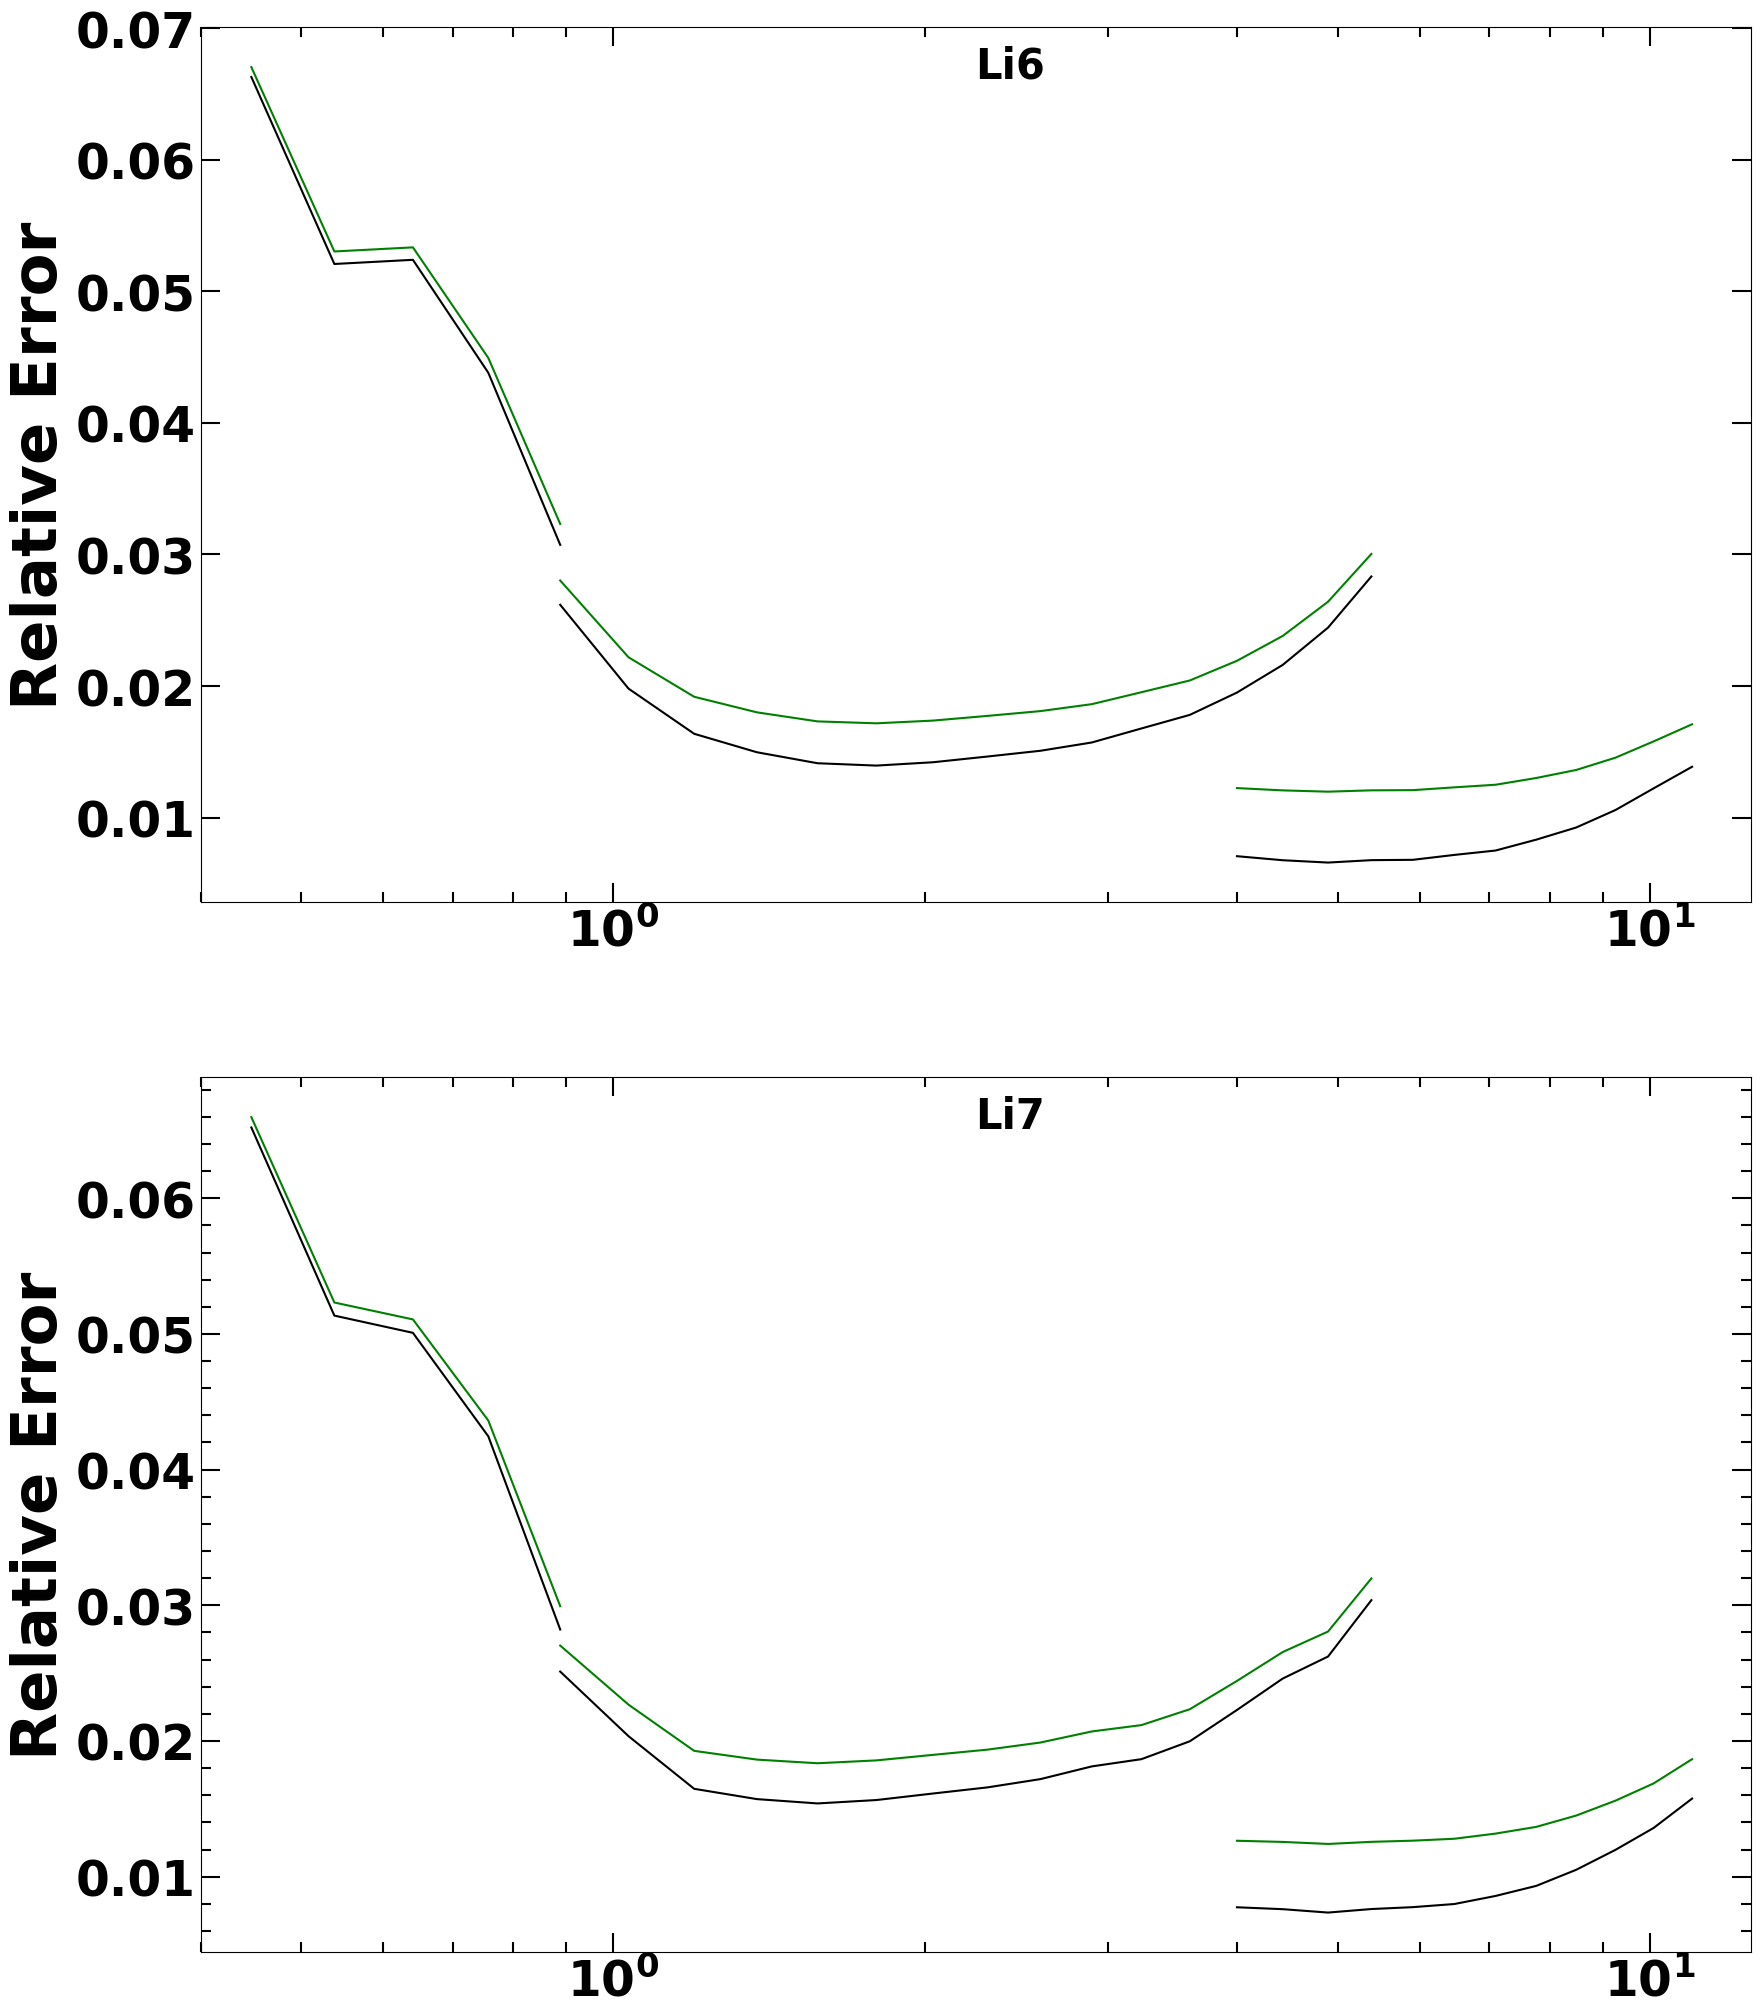

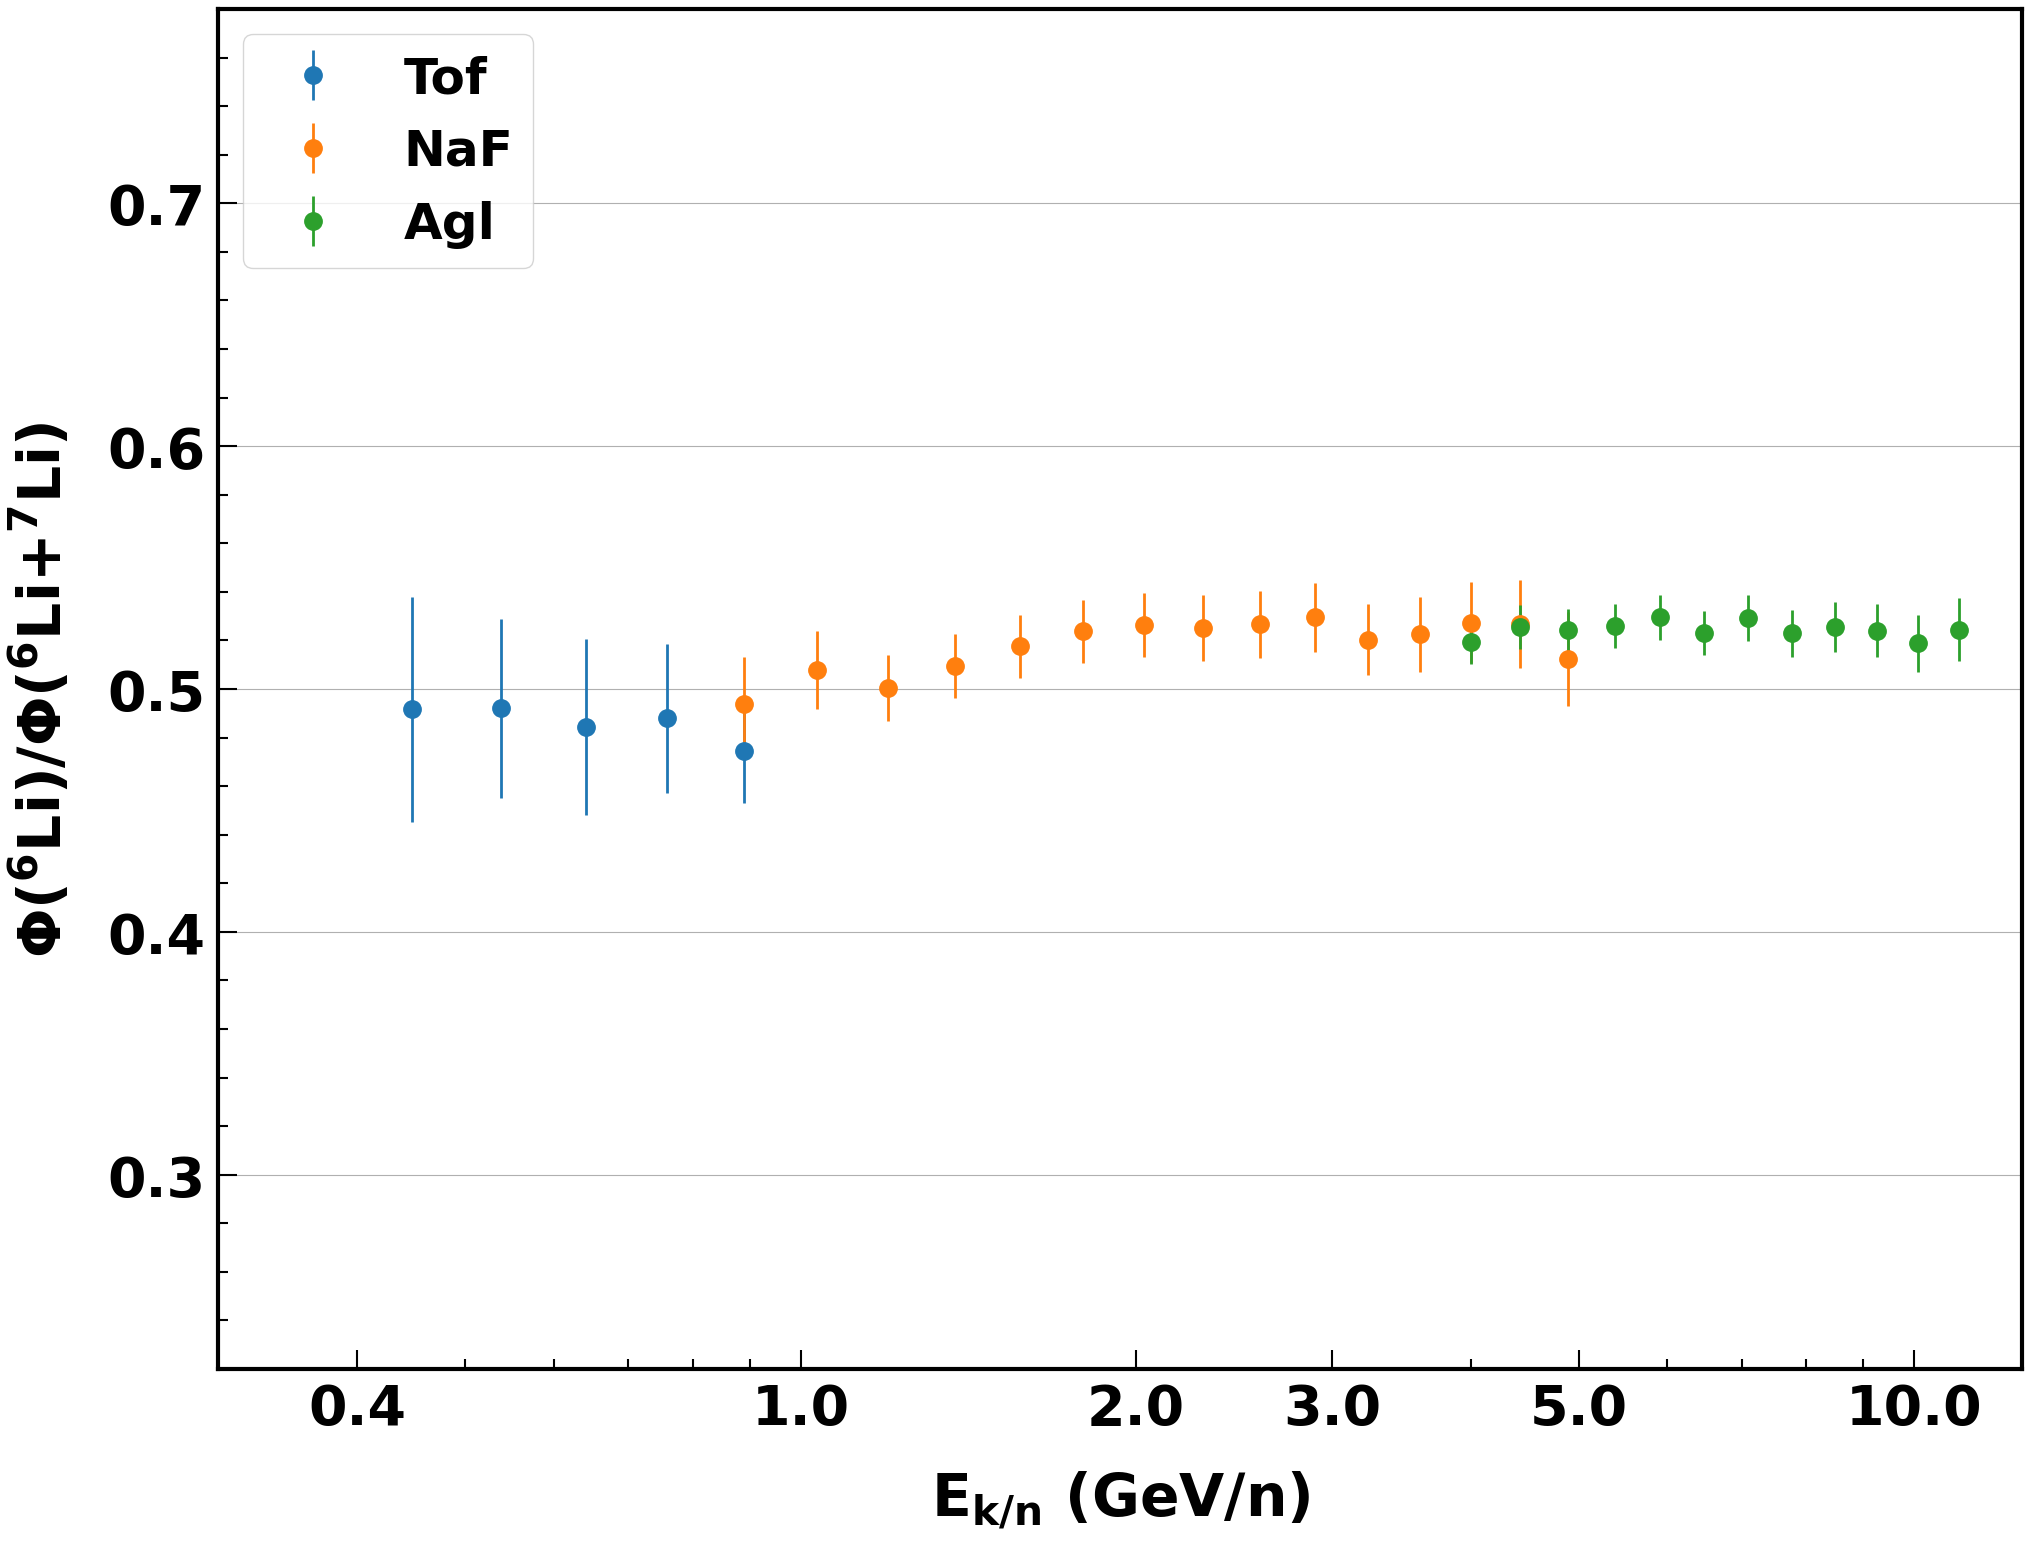

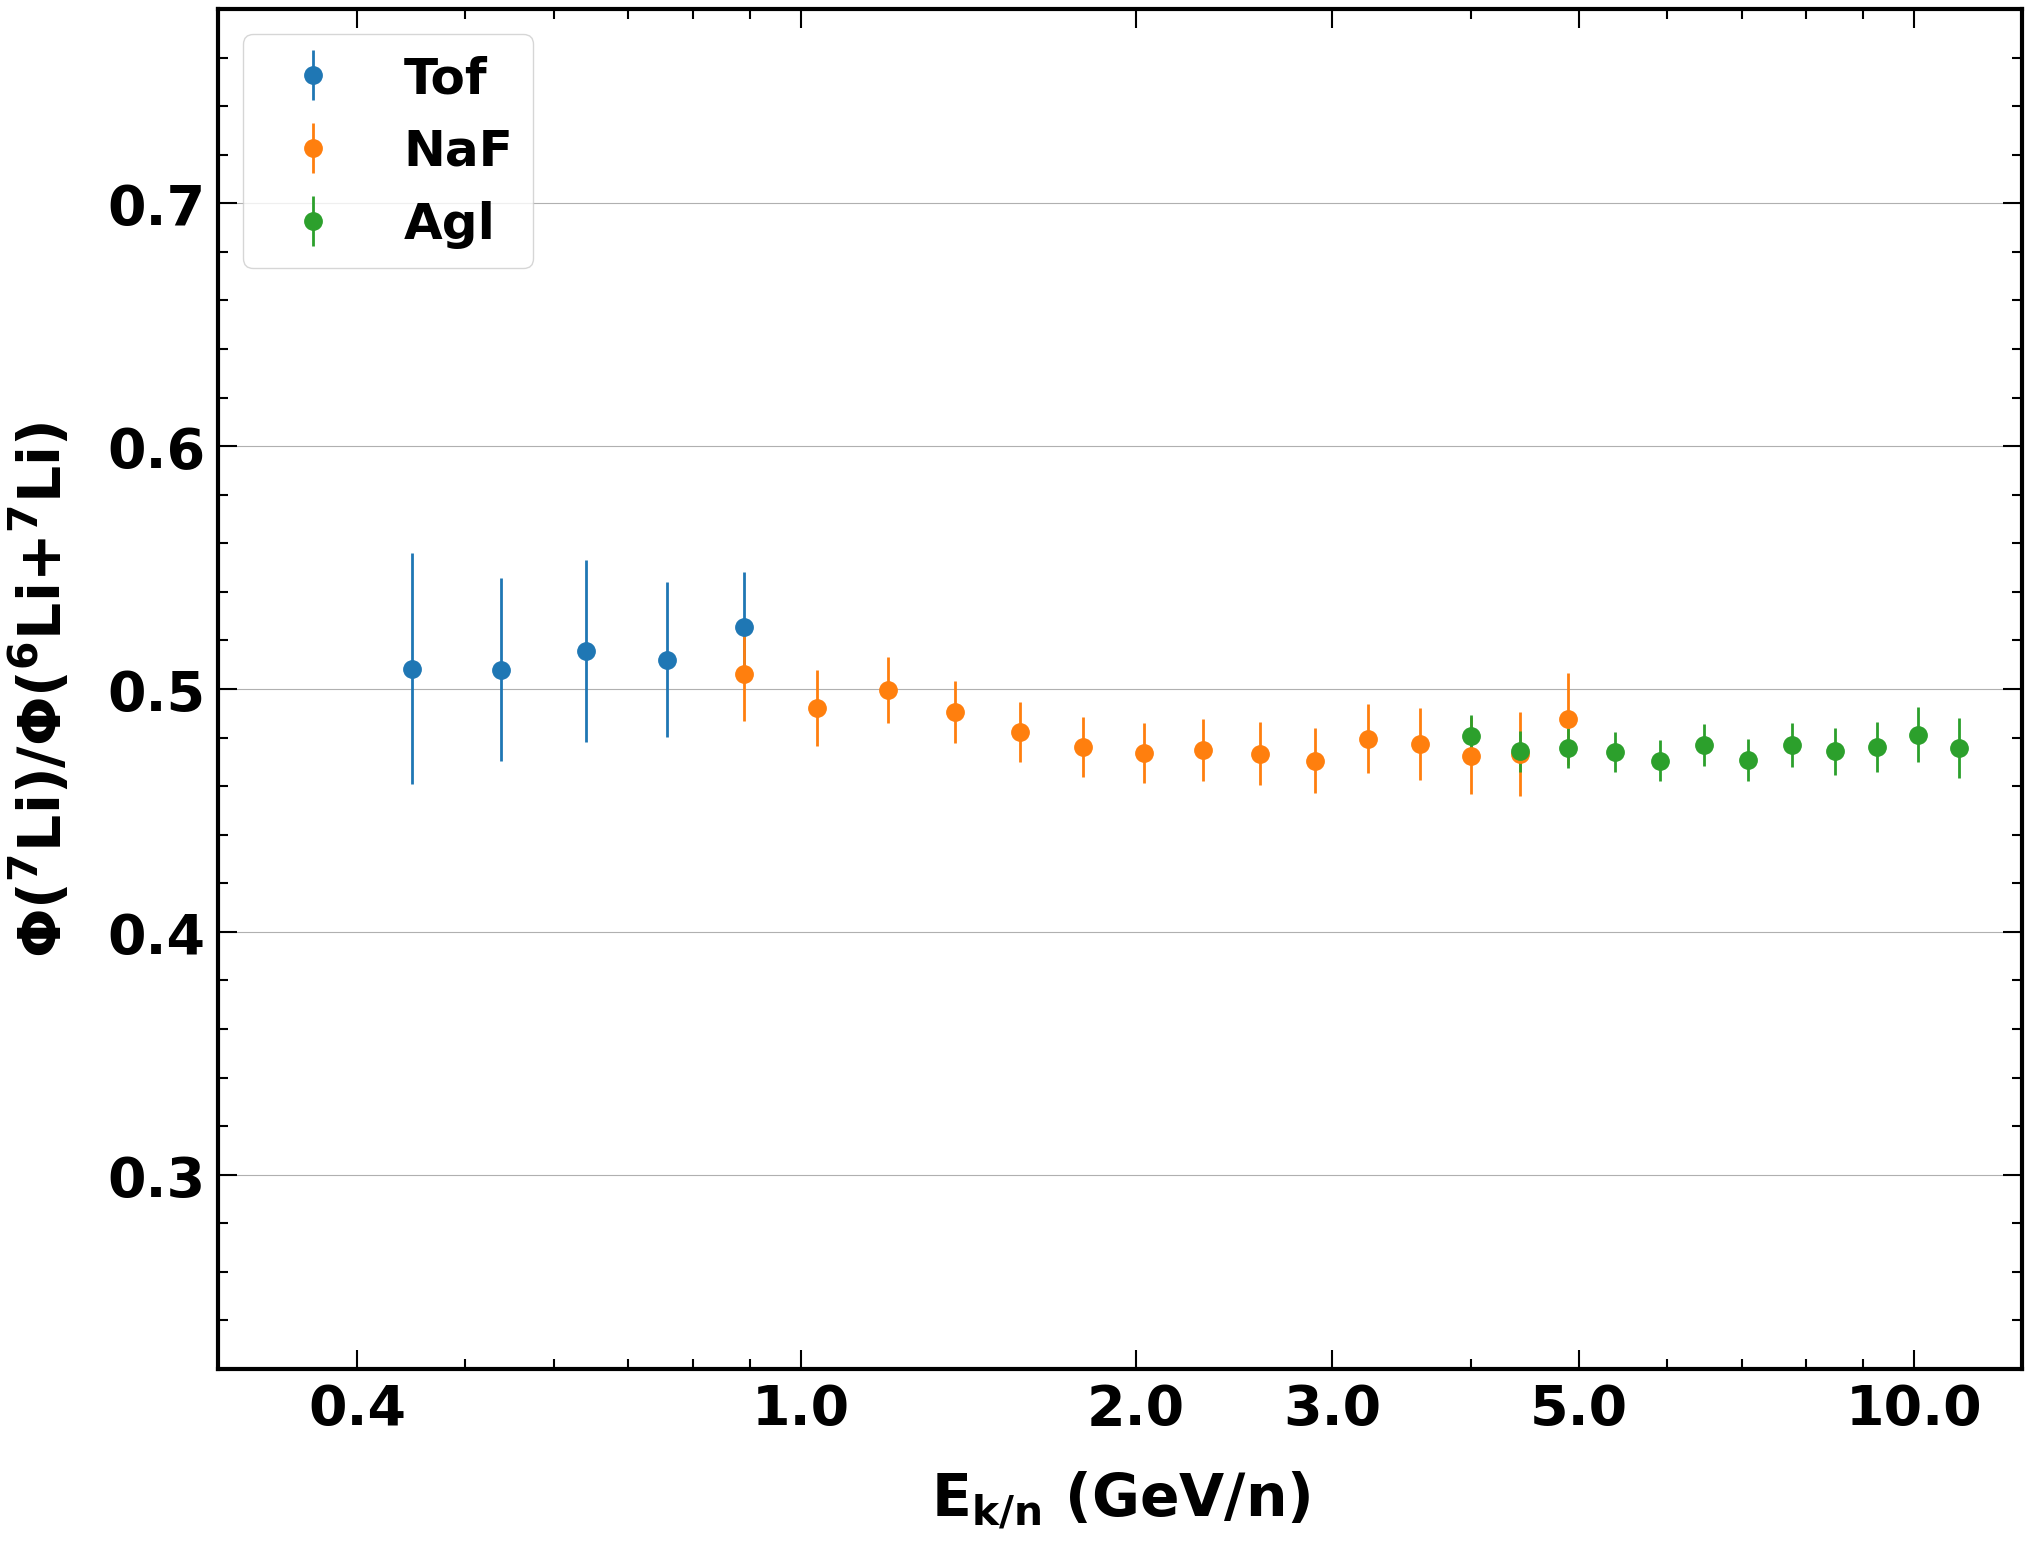

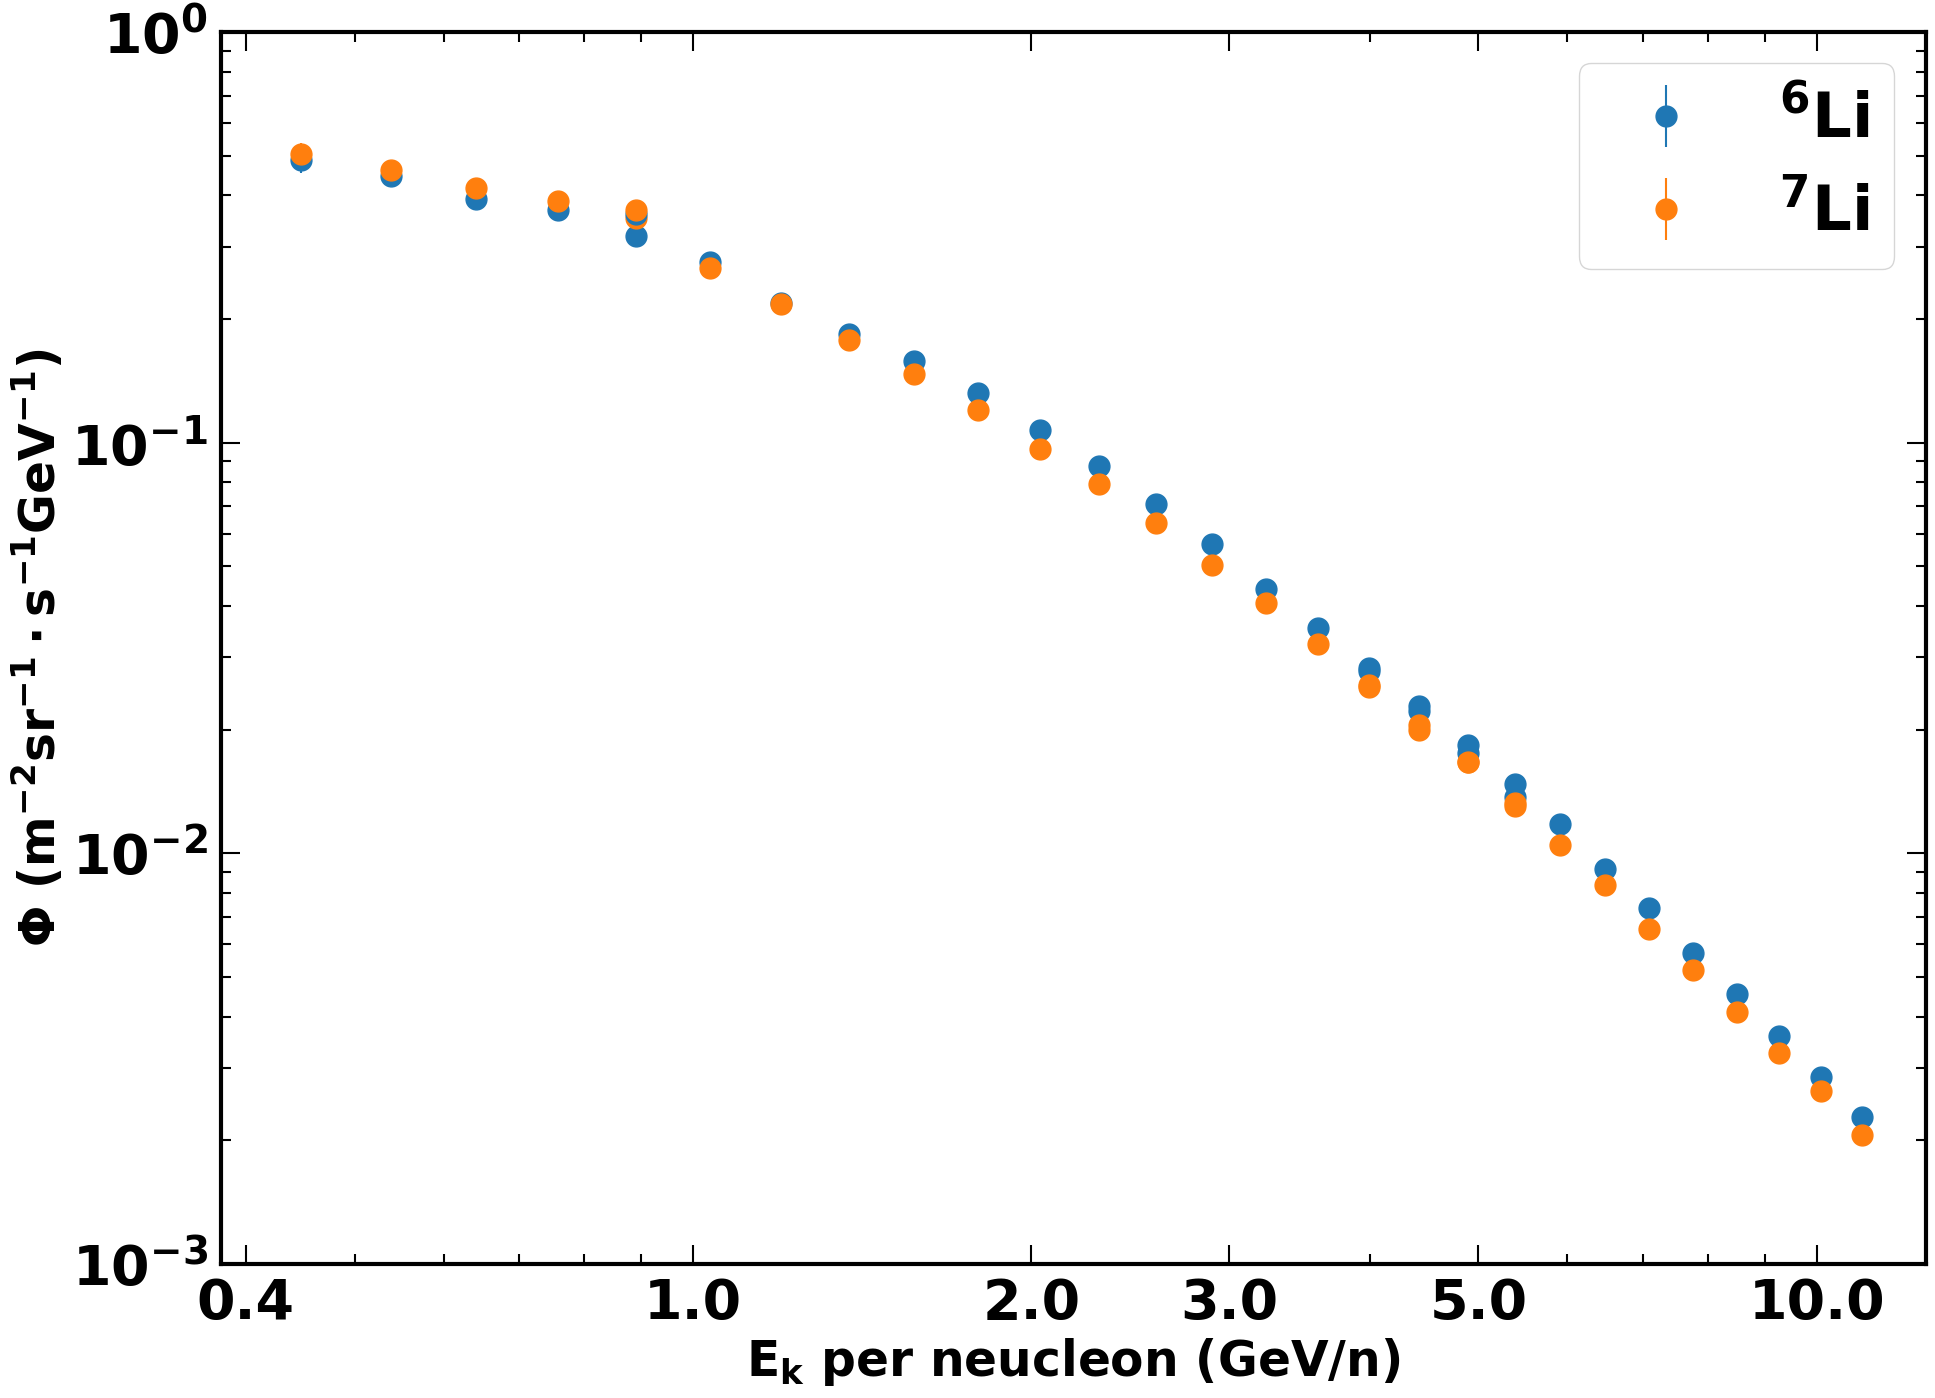

In [13]:
graph_rawflux = {dec: dict() for dec in detectors} 
graph_unfoldflux = {dec: dict() for dec in detectors}
graph_flux_fraction = {dec: dict() for dec in detectors}
graph_flux_fraction_err = {dec: dict() for dec in detectors}
graph_totalflux = {}
#xbinning = {"Rigidity": Binning(fbinning_energy()), "Ekin":Binning(fbinning_energy())}   
df_rawflux = dict() 
df_unfoldflux = dict()
subgraph_unfoldfactor = {}
graph_countserr = {dec: dict() for dec in detectors}
graph_statserr = {dec: {} for dec in detectors}
data_dict ={dec:  dict() for dec in detectors}
for dec in detectors:     
    
    for iso in ISOTOPES[nuclei]:
        graph_counts =graph_counts_fromfit[dec][iso]
        
        xenergy = graph_counts.xvalues  
        print(xenergy)
        #graph_accraw = slice_graph_by_value(graph_acc[dec][iso], [xenergy[0], xenergy[-1]])  
        graph_accraw = MGraph(xenergy, spline_subgraph_acc[dec][iso](np.log(xenergy)), 0.01*spline_subgraph_acc[dec][iso](np.log(xenergy)))
        
        if isrebin:
            graph_time = slice_graph_by_value(graph_measuretime_rebin[iso], [xenergy[0], xenergy[-1]]) 
        else:
            graph_time = slice_graph_by_value(graph_measuretime[iso], [xenergy[0], xenergy[-1]]) 
        
        
        graph_effcor = slice_graph_by_value(graph_total_effcor_ekin[dec][iso], [xenergy[0], xenergy[-1]]) 
           
        counts = graph_counts.yvalues                                                                                                                                                                
        counts_err = graph_counts.yerrs   
        
        effcor = graph_effcor.yvalues
        acc = graph_accraw.yvalues
        acc_err = graph_accraw.yerrs
          
        indices = xbinning.get_indices([xenergy[0], xenergy[-1]])                                                                                                                                    
        #bin_widths = xbinning.bin_widths[indices[0]: indices[1]+1]                                                                                                                                  
        bin_edges = xbinning.edges[indices[0]: indices[1]+2]   
        
        bin_widths = bin_edges[1:] - bin_edges[:-1]  
        
        assert (np.all((xenergy - graph_effcor.xvalues) < 0.1))  
        
        assert (np.all((xenergy - graph_time.xvalues) < 0.1))   
        assert (np.all((xenergy - get_bin_center(bin_edges)) < 0.1)) 
        assert (np.all((xenergy - graph_accraw.xvalues) < 0.1))
       
        flux_raw = counts / (effcor * acc *graph_time.yvalues * bin_widths)                                                                                                                               
        flux_raw_err = flux_raw * np.sqrt((counts_err/counts)**2 + (acc_err/acc)**2)                                                                                                                         
        graph_rawflux[dec][iso] = MGraph(xenergy, flux_raw, flux_raw_err)                                                                                                                                                 
        graph_rawflux[dec][iso].add_to_file(df_rawflux, f'graph_rawflux_{dec}{iso}')
        
        graph_countserr[dec][iso] =  MGraph(xenergy, np.sqrt((counts_err/counts)**2) , np.zeros_like(xenergy))
        graph_statserr[dec][iso] = MGraph(xenergy, np.sqrt((flux_raw_err/flux_raw)**2),  np.zeros_like(xenergy))
        #graph_unfold = MGraph(xenergy, spline_unfoldfactor[iso](np.log(xenergy)), np.zeros_like(xenergy))
        #unfold_factor = graph_unfold.yvalues
        #assert (np.all(xenergy == graph_unfold.xvalues))
        #unfoldflux = flux_raw * graph_unfold.yvalues
        #unfoldfluxerr = flux_raw_err * graph_unfold.yvalues
        #graph_unfoldflux[dec][iso] = MGraph(xenergy, unfoldflux, unfoldfluxerr)
        
        header = "Ekn_low\tEkn_up\tflux\tfluxerr\tcounts\tcountserr\ttime\tacc\teffcor\tunfoldfactor\tunfolderr"
        fmt = ('%.5f, %.5f, %.5f, %.5f, %.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f')
        #data_dict[dec][iso] = np.column_stack((bin_edges[0:-1], bin_edges[1:], unfoldflux, unfoldfluxerr, counts, counts_err, graph_time.yvalues, acc, effcor, unfold_factor, unfoldfluxerr))
        #np.savetxt(os.path.join(datadirP8, f'results/Ingredients/{dec}{iso}flux{figname}.txt'), data_dict[dec][iso], fmt=fmt, delimiter='\t', header=header)  

datadir_syserr = '/home/manbing/Documents/Data/data_LiP8/syserr_may'
npz_syserr = np.load(os.path.join(datadir_syserr, f'graph_syserr.npz'))
slicevalue_err = {'Tof': [0.4, 0.95], 'NaF':[0.9, 4.0], 'Agl':[3.8, 12.0]}
graph_totalerr = {}
graph_rawflux_toterr = {dec: {} for dec in detectors}
spline_totalrelative_err = {dec: {} for dec in detectors}
for iso in isotopes:
    graph_totalerr[iso] = MGraph.from_file(npz_syserr, f'graph_totalerr_{iso}')
    for dec in detectors:
        #subgraphtotalerr = slice_graph_by_value(graph_totalerr[iso], [slicevalue_err[dec][0], slicevalue_err[dec][1]])
        #spline_totalrelative_err[dec][iso] = UnivariateSpline(np.log(subgraphtotalerr.xvalues),subgraphtotalerr.yvalues, k=3, s=5)      
        graph_rawflux_toterr[dec][iso] = MGraph(graph_rawflux[dec][iso].xvalues, graph_rawflux[dec][iso].yvalues, graph_rawflux[dec][iso].yerrs)
        #flux_total_err = spline_totalrelative_err[dec][iso](np.log(graph_rawflux[dec][iso].xvalues))/100 * graph_rawflux[dec][iso].yvalues
        subgraphtotalerr = slice_graph_by_value(graph_totalerr[iso], [graph_rawflux[dec][iso].xvalues[0], graph_rawflux[dec][iso].xvalues[-1]])
        flux_total_err = subgraphtotalerr.yvalues/100 * graph_rawflux[dec][iso].yvalues
        graph_rawflux_toterr[dec][iso].yerrs = flux_total_err
        print(dec, iso, graph_rawflux[dec][iso].yerrs)
        print(dec, iso, graph_rawflux_toterr[dec][iso].yerrs)
        
        
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=(20, 25))
ax = [ax1, ax2]
dict_graph_countserr = {}
for i, iso in enumerate(ISOTOPES['Li']):
    ax[i].text(0.5, 0.98, f"{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax[i].transAxes, color="black", fontweight="bold")
    ax[i].set_ylabel("Relative Error")   
    for dec in detectors:
        plot_graph(fig, ax[i], graph_statserr[dec][iso], color='green', style="hist", xlog=True, ylog=False, markersize=20, label=f'{dec}')
        plot_graph(fig, ax[i], graph_countserr[dec][iso], color='black', style="hist", xlog=True, ylog=False, markersize=20, label=f'{dec}')
        graph_countserr[dec][iso].add_to_file(dict_graph_countserr, f'graph_countserr_{dec}{iso}')
        graph_statserr[dec][iso].add_to_file(dict_graph_countserr, f'graph_statserr_{dec}{iso}')

    #ax[i].set_ylim(isoylim[iso])   
    ax[i].set_xlim([0.4, 12.5])
        
np.savez(os.path.join('/home/manbing/Documents/Data/data_LiP8/syserr_may', f'graph_countserr_fromfit.npz'), **dict_graph_countserr)

for dec in detectors:
    yterrs =  graph_rawflux[dec][ISOTOPES[nuclei][0]].yerrs + graph_rawflux[dec][ISOTOPES[nuclei][1]].yerrs
    ytvalues =  graph_rawflux[dec][ISOTOPES[nuclei][0]].yvalues + graph_rawflux[dec][ISOTOPES[nuclei][1]].yvalues
    graph_totalflux[dec] = MGraph(graph_rawflux[dec][ISOTOPES[nuclei][0]].xvalues, ytvalues, yterrs)
    for iso in ISOTOPES[nuclei]:
        frac, frac_yerr =  calc_ratio_and_err(graph_rawflux[dec][iso].yvalues, graph_totalflux[dec].yvalues, graph_rawflux[dec][iso].yerrs, graph_totalflux[dec].yerrs, correlation=0)
        graph_flux_fraction[dec][iso] = MGraph(graph_rawflux[dec][iso].xvalues, frac, frac_yerr)
        graph_flux_fraction_err[dec][iso] = graph_rawflux[dec][iso]/graph_totalflux[dec]
        #print(graph_flux_fraction[dec][iso].yerrs/graph_flux_fraction[dec][iso].yvalues * 100)
        
#for iso in ISOTOPES[nuclei]:
#    graph_flux_raw['NaF'][iso] = slice_graph_by_value(graph_flux_raw['NaF'][iso], [1.1, 4.2])
isoylim={'Li6': [0.22, 0.78], 'Li7':[0.22, 0.78]}
slicevalues_thesis = {'Tof':[0.4, 1.2], 'NaF':[0.9, 4.8], 'Agl':[3.7, 12.0]}

for i, iso in enumerate(ISOTOPES[nuclei]):
    fig, ax1 = plt.subplots(figsize=(22, 16))
    fig.subplots_adjust(left=0.13, right=0.95, bottom=0.1, top=0.95)
    #ax1.text(0.5, 0.98, f"{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax[i].transAxes, color="black", fontweight="bold")
    for dec in detectors:
        #plot_graph(fig, ax1, graph_flux_fraction[dec][iso], color=DETECTOR_COLOR[dec], style="EP", xlog=True, ylog=False, markersize=25, label=f'{dec}', linewidth=2)
        plot_graph(fig, ax1, slice_graph_by_value(graph_flux_fraction[dec][iso], slicevalues_thesis[dec]), color=DETECTOR_COLOR[dec], style="EP", xlog=True, ylog=False, markersize=25, label=f'{dec}', linewidth=2)
        print(graph_flux_fraction[dec][iso])
    SetAx1Axis(ax1, r"$\mathrm{E_{k/n} \ (GeV/n)}$", rf"$\Phi$({ISO_LABELS[iso]})/$\Phi$({ISO_LABELS[ISOTOPES[nuclei][0]]}+{ISO_LABELS[ISOTOPES[nuclei][1]]})", TEXTSIZE+2, xlimrange=None, ylimrange=isoylim[iso], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False)  
    ax1.legend(loc='upper left')
    ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                                                                                                                                   
    #set_plot_defaultstyle(ax1)     
    set_plot_style(ax1)
    ax1.set_xlim([0.3, 12.5])
    ax1.set_ylim(isoylim[iso])
    print(plotdir)
    ax1.grid(axis='y')
    savefig_tofile(fig, plotdir, f'Li_isoflux_fraction_{iso}_1308_22May', 1)
    
slice_value = {'Tof': [0.4, 1.2], 'NaF':[1.3, 3.7], 'Agl':[4.0, 12.0]}

fig, ax1 = plt.subplots(figsize=(22, 16))
for dec in detectors:
    for iso in ISOTOPES[nuclei]:
        #plot_graph(fig, ax1, slice_graph_by_value(graph_flux_raw[dec][iso], slice_value[dec]), color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=True, markersize=30, label=f"{ISO_LABELS[iso]}" if dec == 'Tof' else None)
        plot_graph(fig, ax1, graph_flux_raw[dec][iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=True, markersize=30, label=f"{ISO_LABELS[iso]}" if dec == 'Tof' else None)
            #graph_unfoldflux[dec][iso].add_to_file(df_unfoldflux, f'graph_unfoldflux_{dec}{iso}')

ax1.set_ylabel(r"$\mathrm{\Phi \ (m^{-2} sr^{-1} \cdot s^{-1} GeV^{-1})} $", fontsize=35) 
ax1.set_xlabel(r"$\mathrm{E_{k}}$ per neucleon (GeV/n)", fontsize=35)     
ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())  
set_plot_style(ax1) 
ax1.set_xlim([0.38, 12.5])
ax1.set_ylim([0.001, 1.0])
ax1.legend()
savefig_tofile(fig, plotdir, f'Li_rawflux', 1)
#np.savez(os.path.join(datadirP8, 'df_unfoldflux_vsEkin.npz'), **df_unfoldflux




xvalues			yvalues			yerrs
0.44778			1.0342304788760526			0.14095330651119628
0.538415			1.0324298548678237			0.11998891645556832
0.64103			1.0646782617641573			0.11968018585545942
0.7578670000000001			1.0496097630841816			0.10230977061074337
0.8890595			1.1073990150260866			0.07512879138186558


xvalues			yvalues			yerrs
0.8890595			1.0252304346056882			0.06955426399581519
1.0347455			0.9691660794968154			0.048799032048382096
1.197125			0.9982130873495243			0.039490587090256046
1.37623			0.9626565922820957			0.036270481331795446
1.574355			0.9321773666074368			0.03187951024260729
1.793835			0.9089331710676303			0.031733234302380245
2.03468			0.9001648583073402			0.03326832246862637
2.2968450000000002			0.9040307000150118			0.03435702087336707
2.5826700000000002			0.8989643969384957			0.03673147551699772
2.894525			0.8885427703900369			0.034687302542941244
3.23237			0.9217106681403122			0.03685907678906169
3.598585			0.9134078921613309			0.039124777791603955
3.995585			0.89614417782788

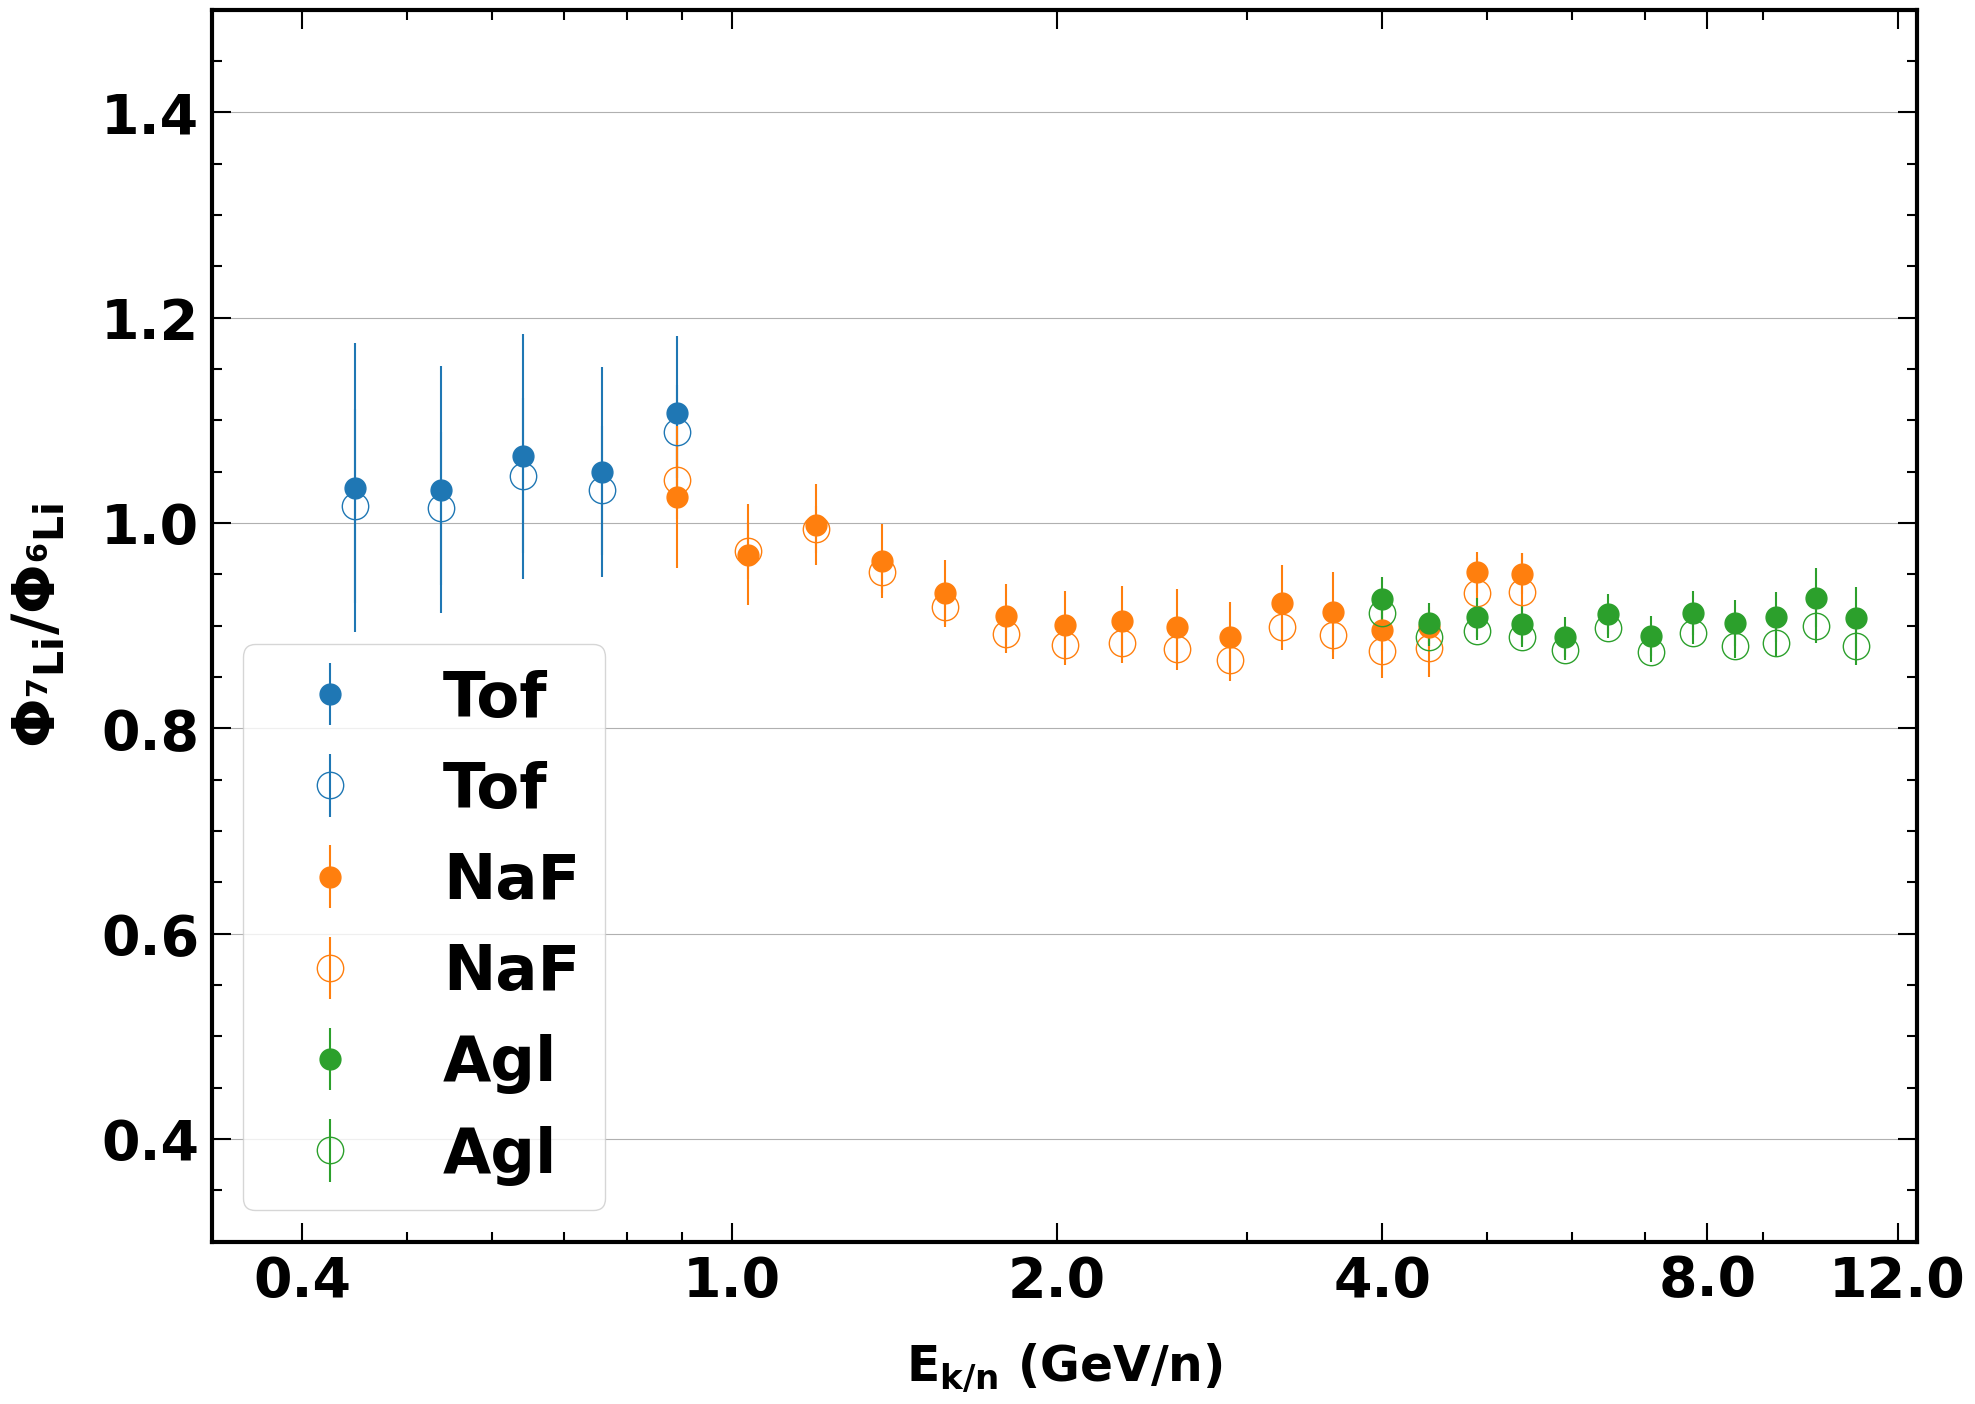

In [14]:
graph_rawflux_ratio = {}
xlimvalue = {'Tof':[0.5, 0.9], 'NaF':[0.8, 4.1], 'Agl':[4.3, 12.3]}
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
isoylim={'Li6': [0.32, 0.68], 'Li7':[0.32, 0.68]}
for dec in detectors:
    frac, frac_yerr =  calc_ratio_and_err(graph_rawflux_toterr[dec]['Li7'].yvalues, graph_rawflux_toterr[dec]['Li6'].yvalues, graph_rawflux_toterr[dec]['Li7'].yerrs, graph_rawflux_toterr[dec]['Li6'].yerrs, correlation=0)
    graph_rawflux_ratio[dec] = MGraph(graph_rawflux_toterr[dec]['Li6'].xvalues, frac, frac_yerr)
    print(graph_rawflux_ratio[dec])
fig, ax1 = plt.subplots(figsize=(22, 16))
xbinning = Binning(fbinning_energy_Li())
for dec in detectors:
    plot_graph(fig, ax1, graph_rawflux_ratio[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=True, ylog=False, markersize=30, label=f"{dec}")
    #plot_graph(fig, ax1, graph_rawflux_ratio[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=True, ylog=False, markersize=30, label=f"{dec}")
    resultsdir = '/home/manbing/Documents/Data/data_LiP8/Li_results_June19'
    write_points_totxt_with_binedge(graph_rawflux_ratio[dec], xbinning, resultsdir, f'Li7ToLi6Ratio_{dec}_16May')
    plot_graph(fig, ax1, graph_counts_ratio_may[dec], color=DETECTOR_COLOR[dec],  style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label=f'{dec}', markerfacecolor='none')
    #plot_graph(fig, ax1, graph_ratio_derive_acc[dec], color=DETECTOR_COLOR[dec],  style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label=f'{dec}', markerfacecolor='none')  
ax1.set_ylabel(r"$\mathrm{\Phi_{^{7}Li}/\Phi_{^{6}Li}}$", fontsize=35)       


SetAx1Axis(ax1, r"$\mathrm{E_{k/n}}$ (GeV/n)", r"$\mathrm{\Phi_{^{7}Li}/\Phi_{^{6}Li}}$", TEXTSIZE+2, xlimrange=None, ylimrange=isoylim[iso], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False)  
ax1.legend(loc='upper left')
ax1.set_xticks([0.4,  1.0, 2.0, 4.0, 8.0, 12])                                                                                                                                                                      
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                                                                                                                                   
#set_plot_defaultstyle(ax1)     
set_plot_style(ax1)
ax1.set_xlim([0.33, 12.5])
ax1.legend()                                                                                                              
ax1.set_xlabel(r"$\mathrm{E_{k/n}}$ (GeV/n)", fontsize=35)
ax1.set_ylim([0.3, 1.5]) 
 
ax1.grid(axis='y')

savefig_tofile(fig, plotdir, f'Li_fluxratio_B1308_16May', 1)








[0.1362881  0.11621992 0.11240972 0.0974741  0.06784257]
[0.06784257 0.05035157 0.03956128 0.03767749 0.03419897 0.03491262
 0.03695803 0.03800426 0.04085977 0.03903842 0.03998986 0.04283385
 0.02293577 0.02188083 0.02101721 0.02124239]
[0.02293577 0.02188083 0.02101721 0.02124239 0.02171499 0.02150007
 0.02178392 0.0234337  0.02492233 0.02696345 0.03060571 0.0336373 ]
/home/manbing/Documents/Li_Manbing_PhD_Defense/plots


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



xvalues			yvalues			yerrs
0.44778			1.0342304788760526			0.14095330651119628
0.538415			1.0324298548678237			0.11998891645556832
0.64103			1.0646782617641573			0.11968018585545942
0.7578670000000001			1.0496097630841816			0.10230977061074337
0.8890595			1.0252304346056882			0.06955426399581519
1.0347455			0.9691660794968154			0.048799032048382096
1.197125			0.9982130873495243			0.039490587090256046
1.37623			0.9626565922820957			0.036270481331795446
1.574355			0.9321773666074368			0.03187951024260729
1.793835			0.9089331710676303			0.031733234302380245
2.03468			0.9001648583073402			0.03326832246862637
2.2968450000000002			0.9040307000150118			0.03435702087336707
2.5826700000000002			0.8989643969384957			0.03673147551699772
2.894525			0.8885427703900369			0.034687302542941244
3.23237			0.9217106681403122			0.03685907678906169
3.598585			0.9134078921613309			0.039124777791603955
3.995585			0.9260521568513377			0.02123971725111482
4.423325			0.902218363352508			0.01974128971898034
4.891

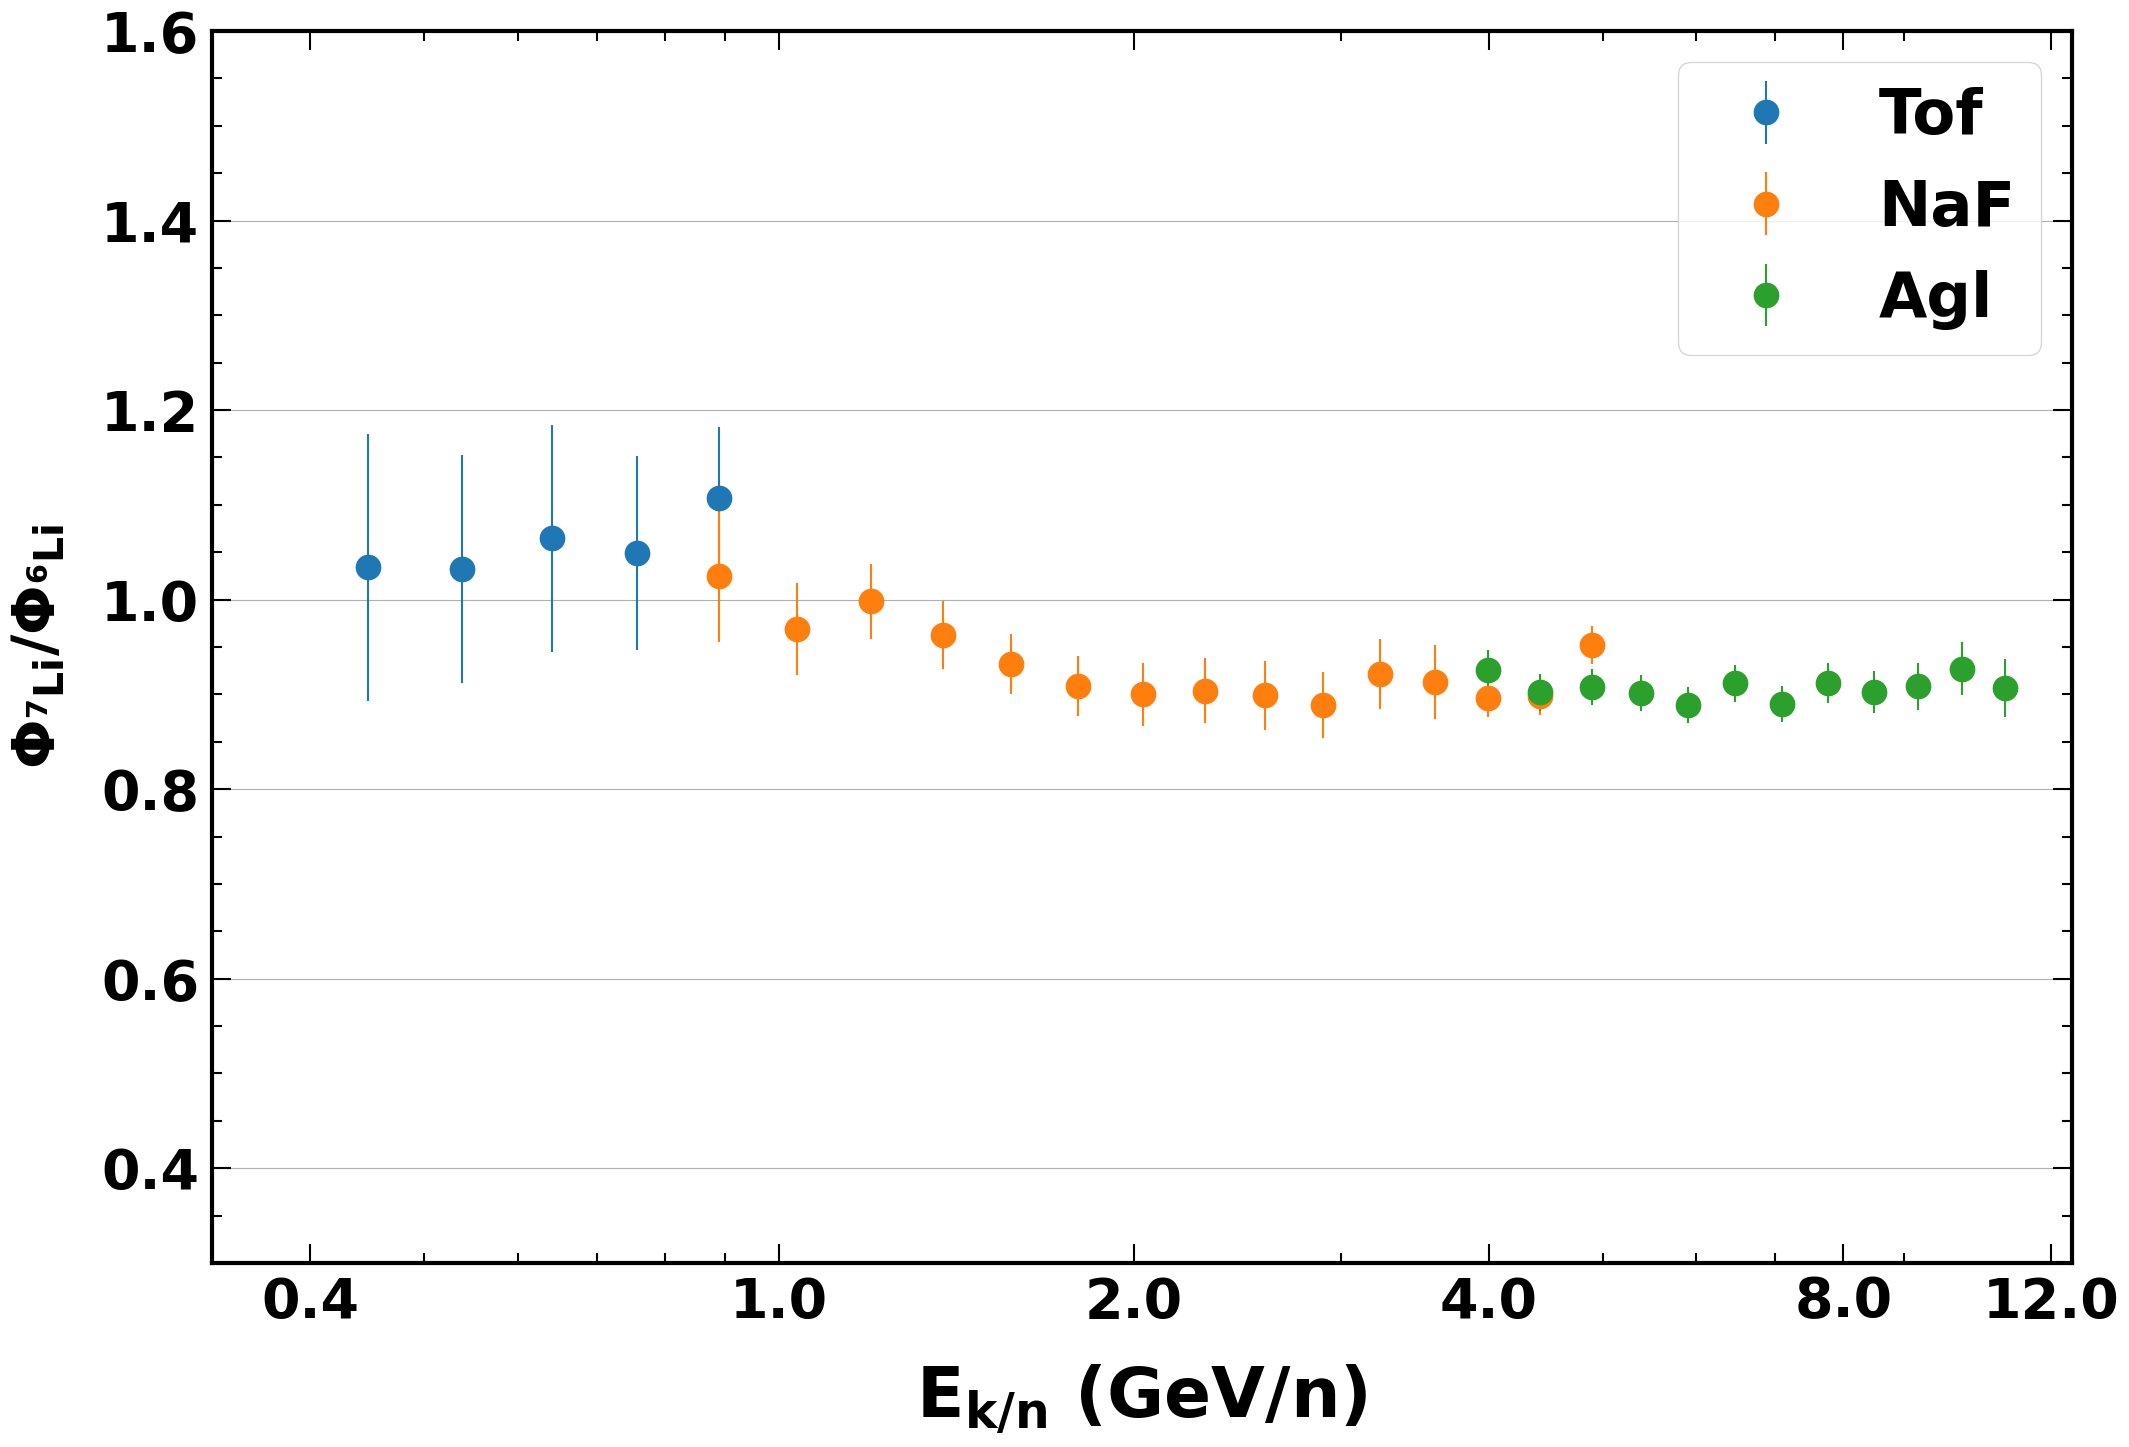

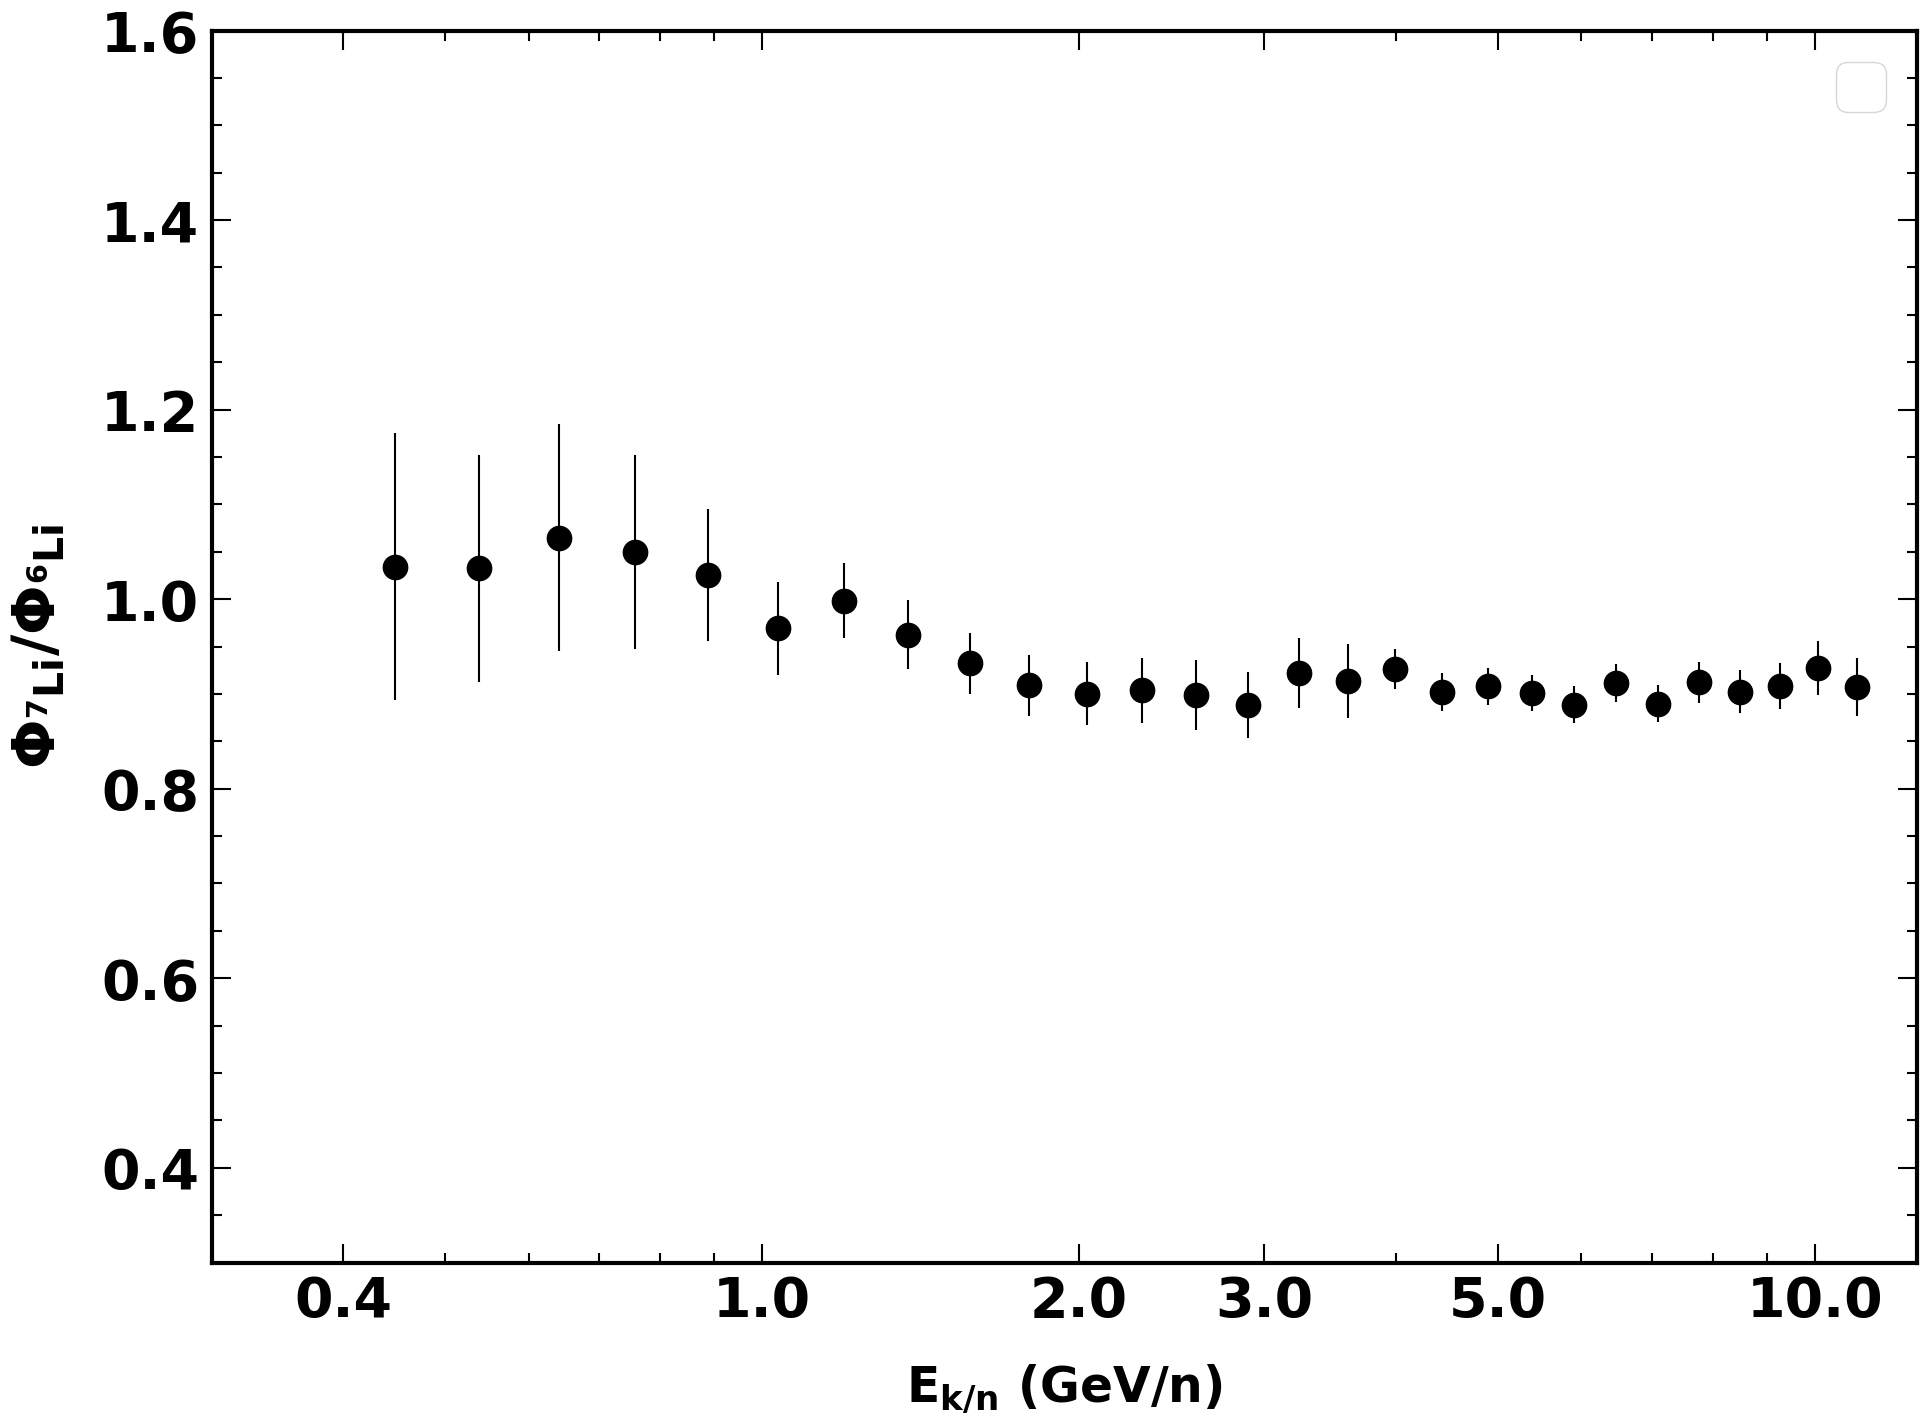

In [21]:
graph_rawflux_ratio = {}
xlimvalue = {'Tof':[0.5, 0.9], 'NaF':[0.9, 4.1], 'Agl':[4.3, 12.3]}
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
isoylim={'Li6': [0.32, 0.68], 'Li7':[0.32, 0.68]}
for dec in detectors:
    frac, frac_yerr =  calc_ratio_and_err(graph_rawflux_toterr[dec]['Li7'].yvalues, graph_rawflux_toterr[dec]['Li6'].yvalues, graph_rawflux_toterr[dec]['Li7'].yerrs, graph_rawflux_toterr[dec]['Li6'].yerrs, correlation=0)
    graph_rawflux_ratio[dec] = MGraph(graph_rawflux_toterr[dec]['Li6'].xvalues, frac, frac_yerr)
    #graph_rawflux_ratio[dec] = graph_flux_raw[dec][ISOTOPES[nuclei][1]]/graph_flux_raw[dec][ISOTOPES[nuclei][0]]
    print(graph_rawflux_ratio[dec].yerrs/graph_rawflux_ratio[dec].yvalues)
fig, ax1 = plt.subplots(figsize=(24, 16))
xbinning = Binning(fbinning_energy_Li())
#graph_rawflux_ratio['Tof'].yvalues[-1] *= 0.98
for dec in detectors:
   
    plot_graph(fig, ax1, slice_graph_by_value(graph_rawflux_ratio[dec], slicevalues_thesis[dec]), color=DETECTOR_COLOR[dec], style="EP", xlog=True, ylog=False, markersize=35, label=f"{dec}")
    resultsdir = '/home/manbing/Documents/Data/data_LiP8/Li_results'
    #write_points_totxt_with_binedge(graph_rawflux_ratio[dec], xbinning, resultsdir, f'Li7ToLi6Ratio_{dec}')
    #plot_graph(fig, ax1, graph_counts_ratio[dec], color=DETECTOR_COLOR[dec],  style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label=f'{dec} counts ratio')   
ax1.set_ylabel(r"$\mathrm{\Phi_{^{7}Li}/\Phi_{^{6}Li}}$", fontsize=50)       

SetAx1Axis(ax1, r"$\mathrm{E_{k/n}}$ (GeV/n)", r"$\mathrm{\Phi_{^{7}Li}/\Phi_{^{6}Li}}$", TEXTSIZE+2, xlimrange=None, ylimrange=isoylim[iso], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False)  
ax1.legend(loc='upper left')
ax1.set_xticks([0.4,  1.0, 2.0, 4.0, 8.0, 12])                                                                                                                                                                      
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                                                                                                                                   
#set_plot_defaultstyle(ax1)     
set_plot_style(ax1)
ax1.set_xlim([0.33, 12.5])
ax1.legend()                                                                                                              
ax1.set_xlabel(r"$\mathrm{E_{k/n}}$ (GeV/n)", fontsize=50)
ax1.set_ylim([0.3, 1.6]) 
 
ax1.grid(axis='y')
print(plotdir)
savefig_tofile(fig, plotdir, f'Li_fluxratio_B1308_16May', 1)


slicevalue = {'Tof':[0.4, 0.8], 'NaF':[0.9, 3.7], 'Agl':[4.0, 12.3]}
subgraph_ratio = {}

for dec in detectors:
    subgraph_ratio[dec] = slice_graph_by_value(graph_rawflux_ratio[dec], slicevalue[dec])
    

graph_fluxratio_combined = subgraph_ratio['Tof']
graph_fluxratio_combined = concatenate_graphs(graph_fluxratio_combined, subgraph_ratio['NaF'])
graph_fluxratio_combined = concatenate_graphs(graph_fluxratio_combined, subgraph_ratio['Agl'])
print(graph_fluxratio_combined)

write_points_totxt_with_binedge(graph_fluxratio_combined, xbinning, resultsdir, f'LiIsoRatio_16May')

fig, ax1 = plt.subplots(figsize=(22, 16))
plot_graph(fig, ax1,graph_fluxratio_combined , color='black', style="EP", xlog=True, ylog=False, markersize=35)
ax1.set_ylabel(r"$\mathrm{\Phi_{^{7}Li}/\Phi_{^{6}Li}}$", fontsize=35)       
SetAx1Axis(ax1, r"$\mathrm{E_{k/n}}$ (GeV/n)", r"$\mathrm{\Phi_{^{7}Li}/\Phi_{^{6}Li}}$", TEXTSIZE+2, xlimrange=None, ylimrange=isoylim[iso], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False)  
ax1.legend(loc='upper left')
ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                                                                                                                                   
#set_plot_defaultstyle(ax1)     
set_plot_style(ax1)
ax1.set_xlim([0.3, 12.5])
ax1.legend()                                                                                                              
ax1.set_xlabel(r"$\mathrm{E_{k/n}}$ (GeV/n)", fontsize=35)
ax1.set_ylim([0.3, 1.6]) 

savefig_tofile(fig, plotdir, f'Li_fluxratio_B1308_Combined', 1)

/home/manbing/Documents/lithiumanalysis/slides/plots/LiP8/fitDataB1308_finebin_meanfree


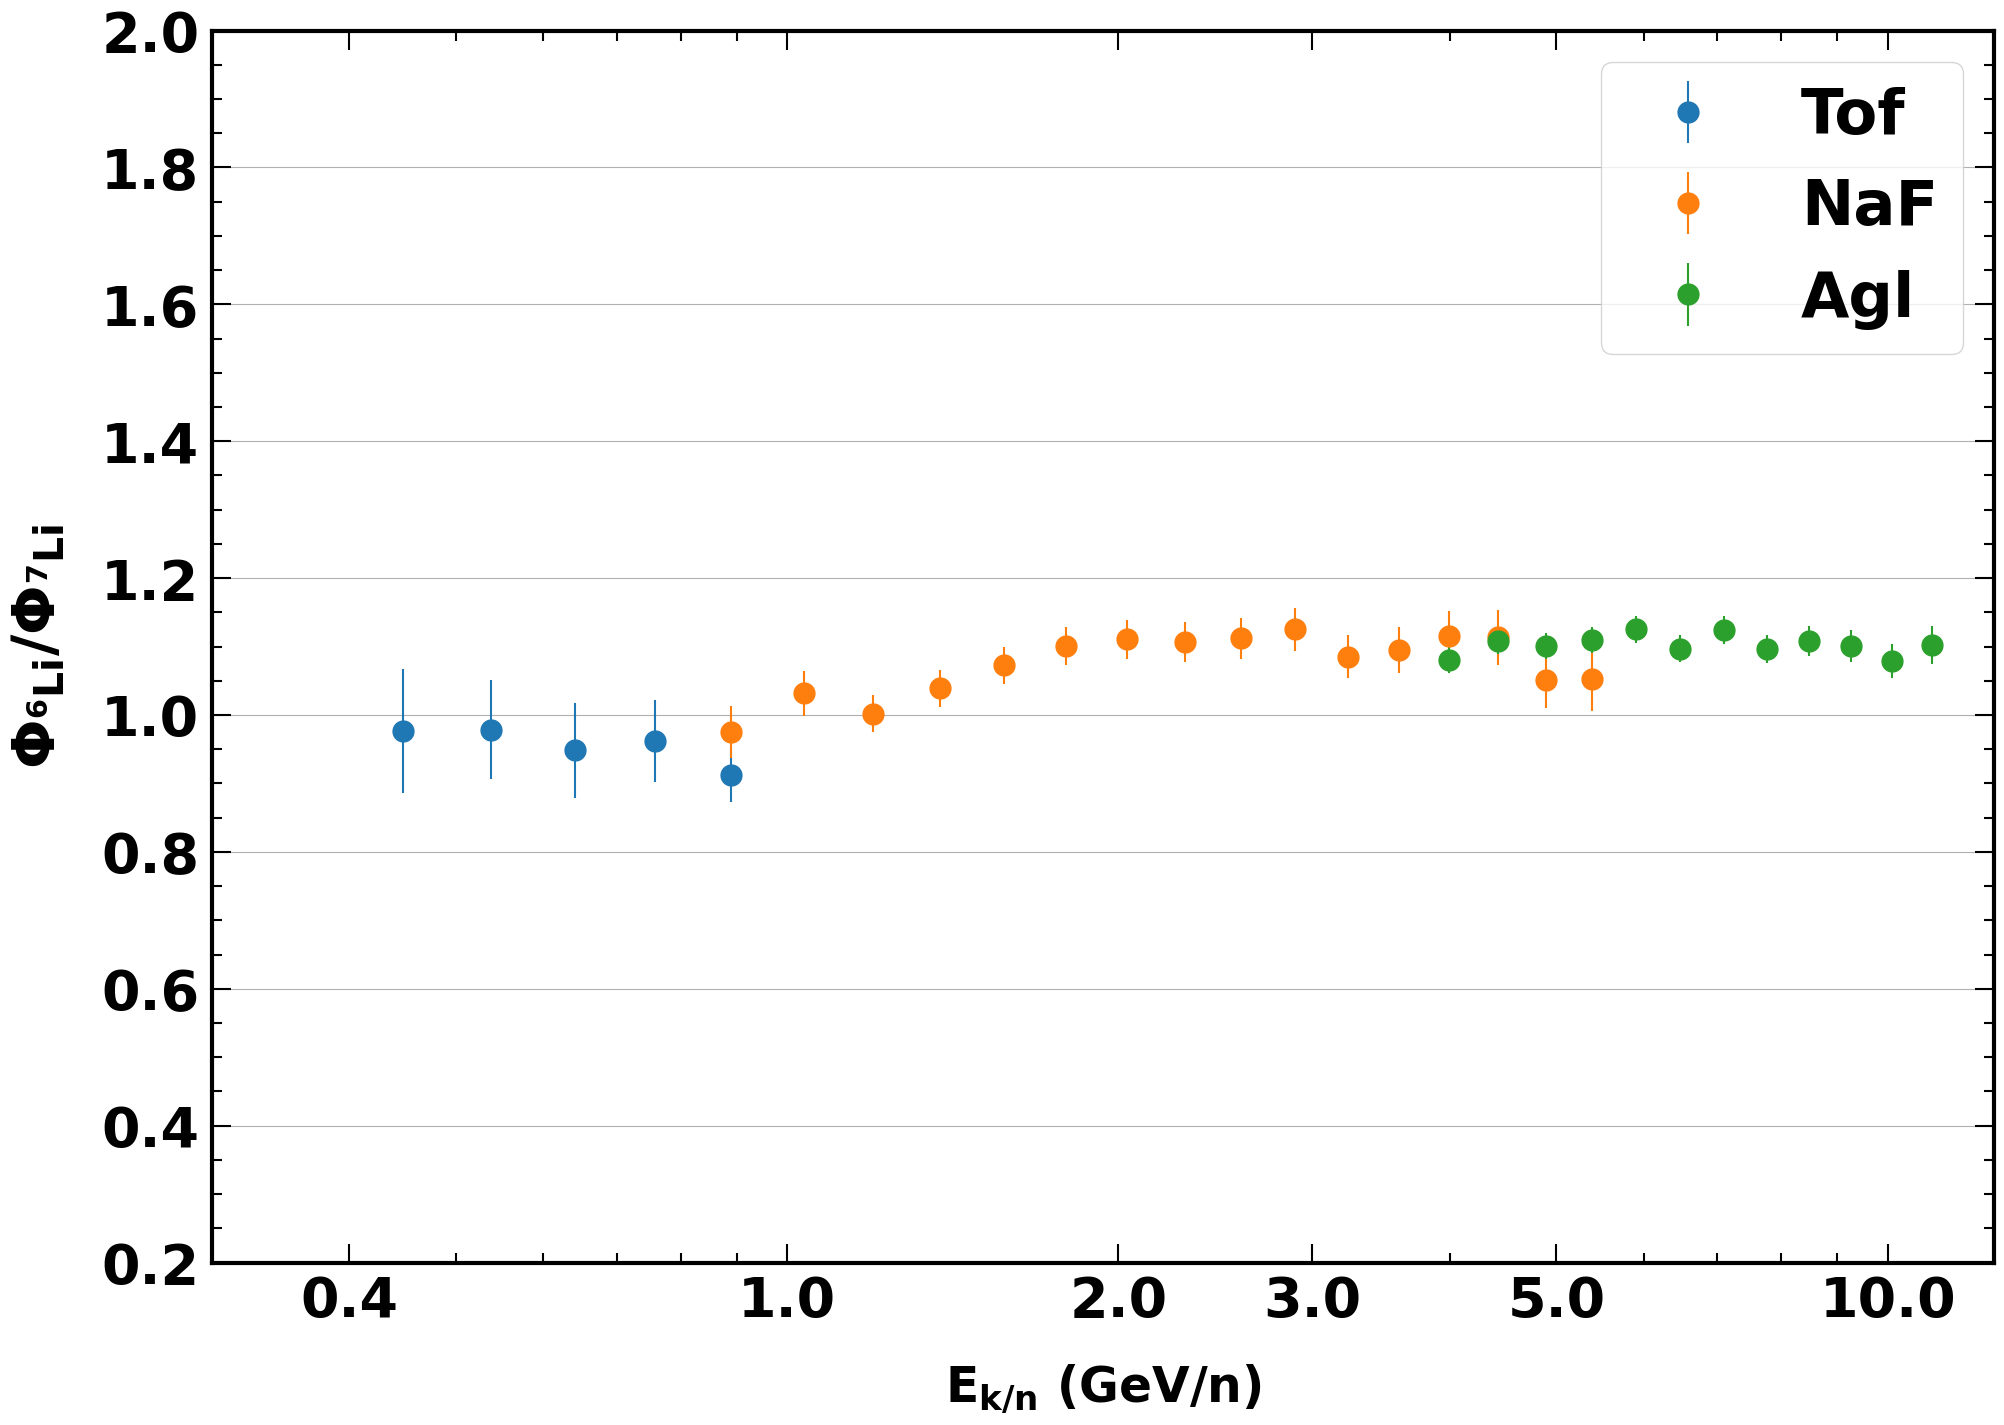

In [16]:
graph_rawflux_ratio = {}
xlimvalue = {'Tof':[0.5, 1.1], 'NaF':[1.2, 4.1], 'Agl':[4.3, 12.3]}
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
for dec in detectors:
    graph_rawflux_ratio[dec] = graph_flux_raw[dec][ISOTOPES[nuclei][0]]/graph_flux_raw[dec][ISOTOPES[nuclei][1]]
    

fig, ax1 = plt.subplots(figsize=(23, 16))
graph_rawflux_ratio['Tof'].yvalues = graph_rawflux_ratio['Tof'].yvalues * 1.01
for dec in detectors:
    plot_graph(fig, ax1, graph_rawflux_ratio[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=True, ylog=False, markersize=30, label=f"{dec}")
    #plot_graph(fig, ax1, graph_counts_ratio[dec], color=DETECTOR_COLOR[dec],  style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label=f'{dec} counts ratio')   
ax1.set_ylabel(r"$\mathrm{\Phi_{^{7}Li}/\Phi_{^{6}Li}}$", fontsize=35)       

SetAx1Axis(ax1, r"$\mathrm{E_{k/n}}$ (GeV/n)", r"$\mathrm{\Phi_{^{6}Li}/\Phi_{^{7}Li}}$", TEXTSIZE+2, xlimrange=None, ylimrange=isoylim[iso], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False)  
ax1.legend(loc='upper left')
ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                                                                                                                                   
#set_plot_defaultstyle(ax1)     
set_plot_style(ax1)
ax1.set_xlim([0.3, 12.5])
ax1.legend()                                                                                                              
ax1.set_xlabel(r"$\mathrm{E_{k/n}}$ (GeV/n)", fontsize=35)
ax1.set_ylim([0.2, 2.0]) 

ax1.set_xlim([0.3, 12.5])
ax1.grid(axis='y')
print(plotdir)
savefig_tofile(fig, plotdir, f'Li_fluxratio_{FIGNAME}', 1)

['graph_Li6_unfoldfactor_xvalues', 'graph_Li6_unfoldfactor_yvalues', 'graph_Li6_unfoldfactor_yerrs', 'graph_Li6_unfoldfactor_labels', 'graph_Li7_unfoldfactor_xvalues', 'graph_Li7_unfoldfactor_yvalues', 'graph_Li7_unfoldfactor_yerrs', 'graph_Li7_unfoldfactor_labels']
/home/manbing/Documents/lithiumanalysis/slides/plots/LiP8/fitDataB1308_finebin_meanfree
/home/manbing/Documents/lithiumanalysis/slides/plots/LiP8/fitDataB1308_finebin_meanfree
/home/manbing/Documents/lithiumanalysis/slides/plots/LiP8/fitDataB1308_finebin_meanfree


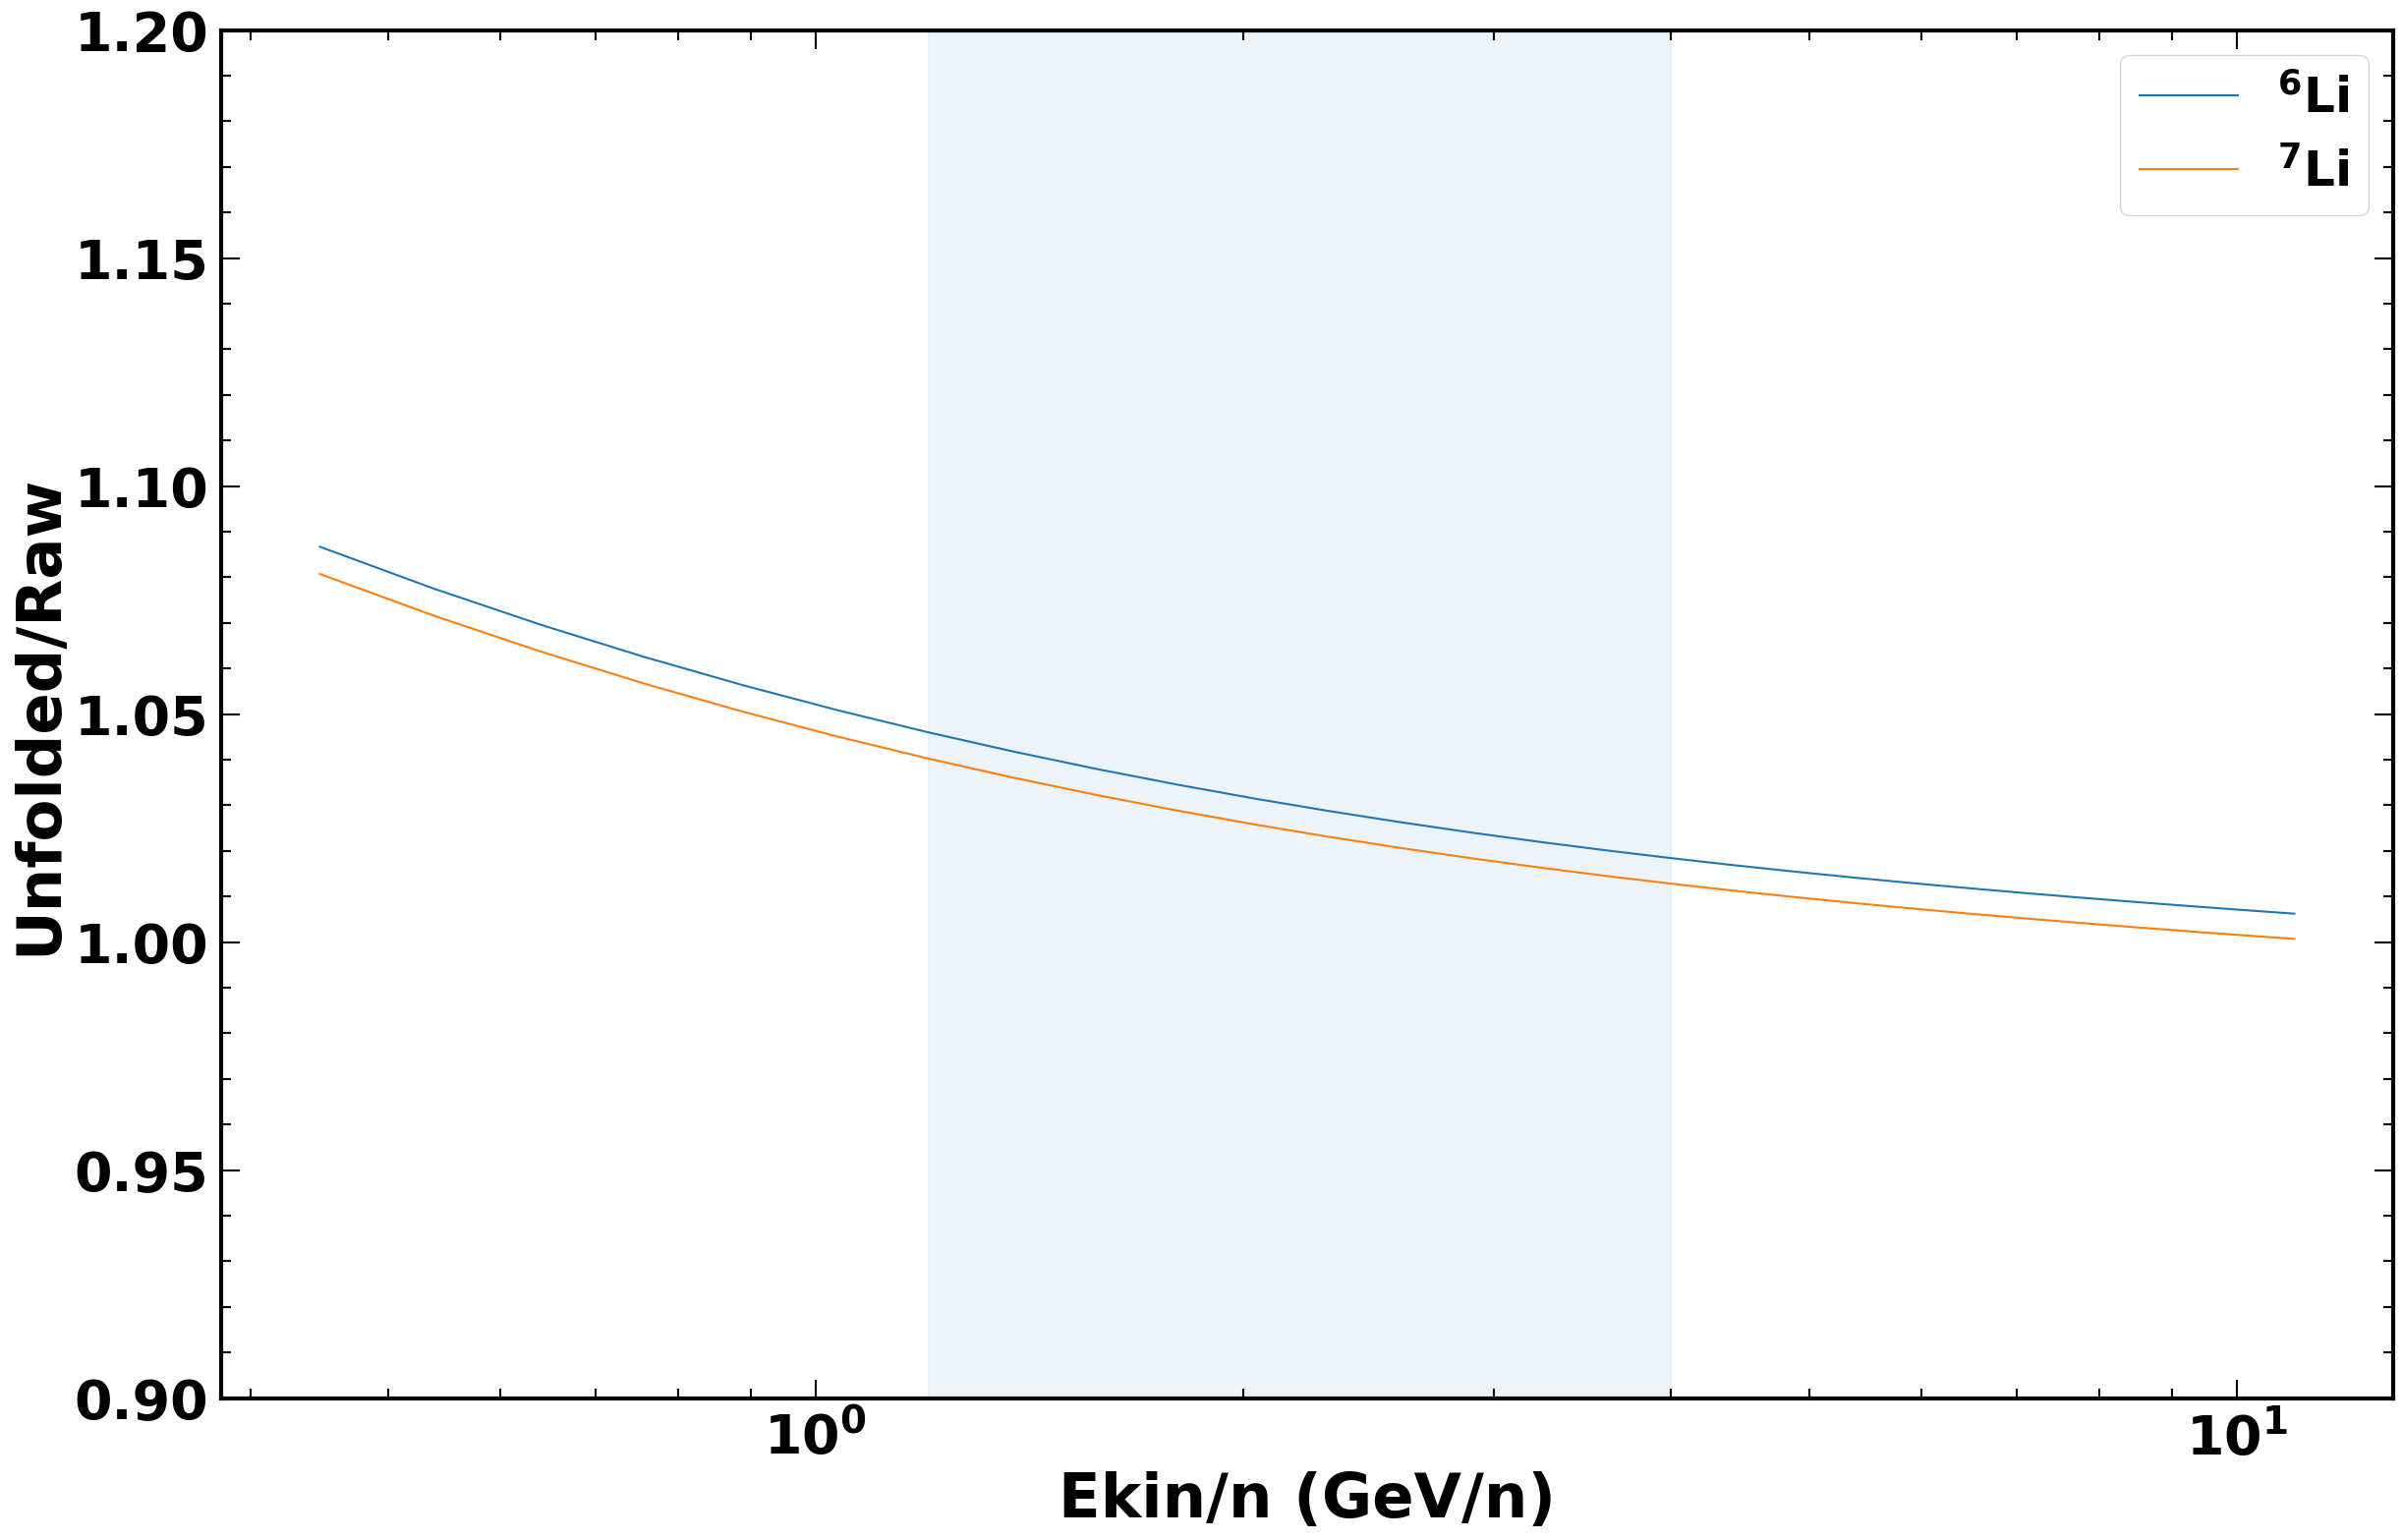

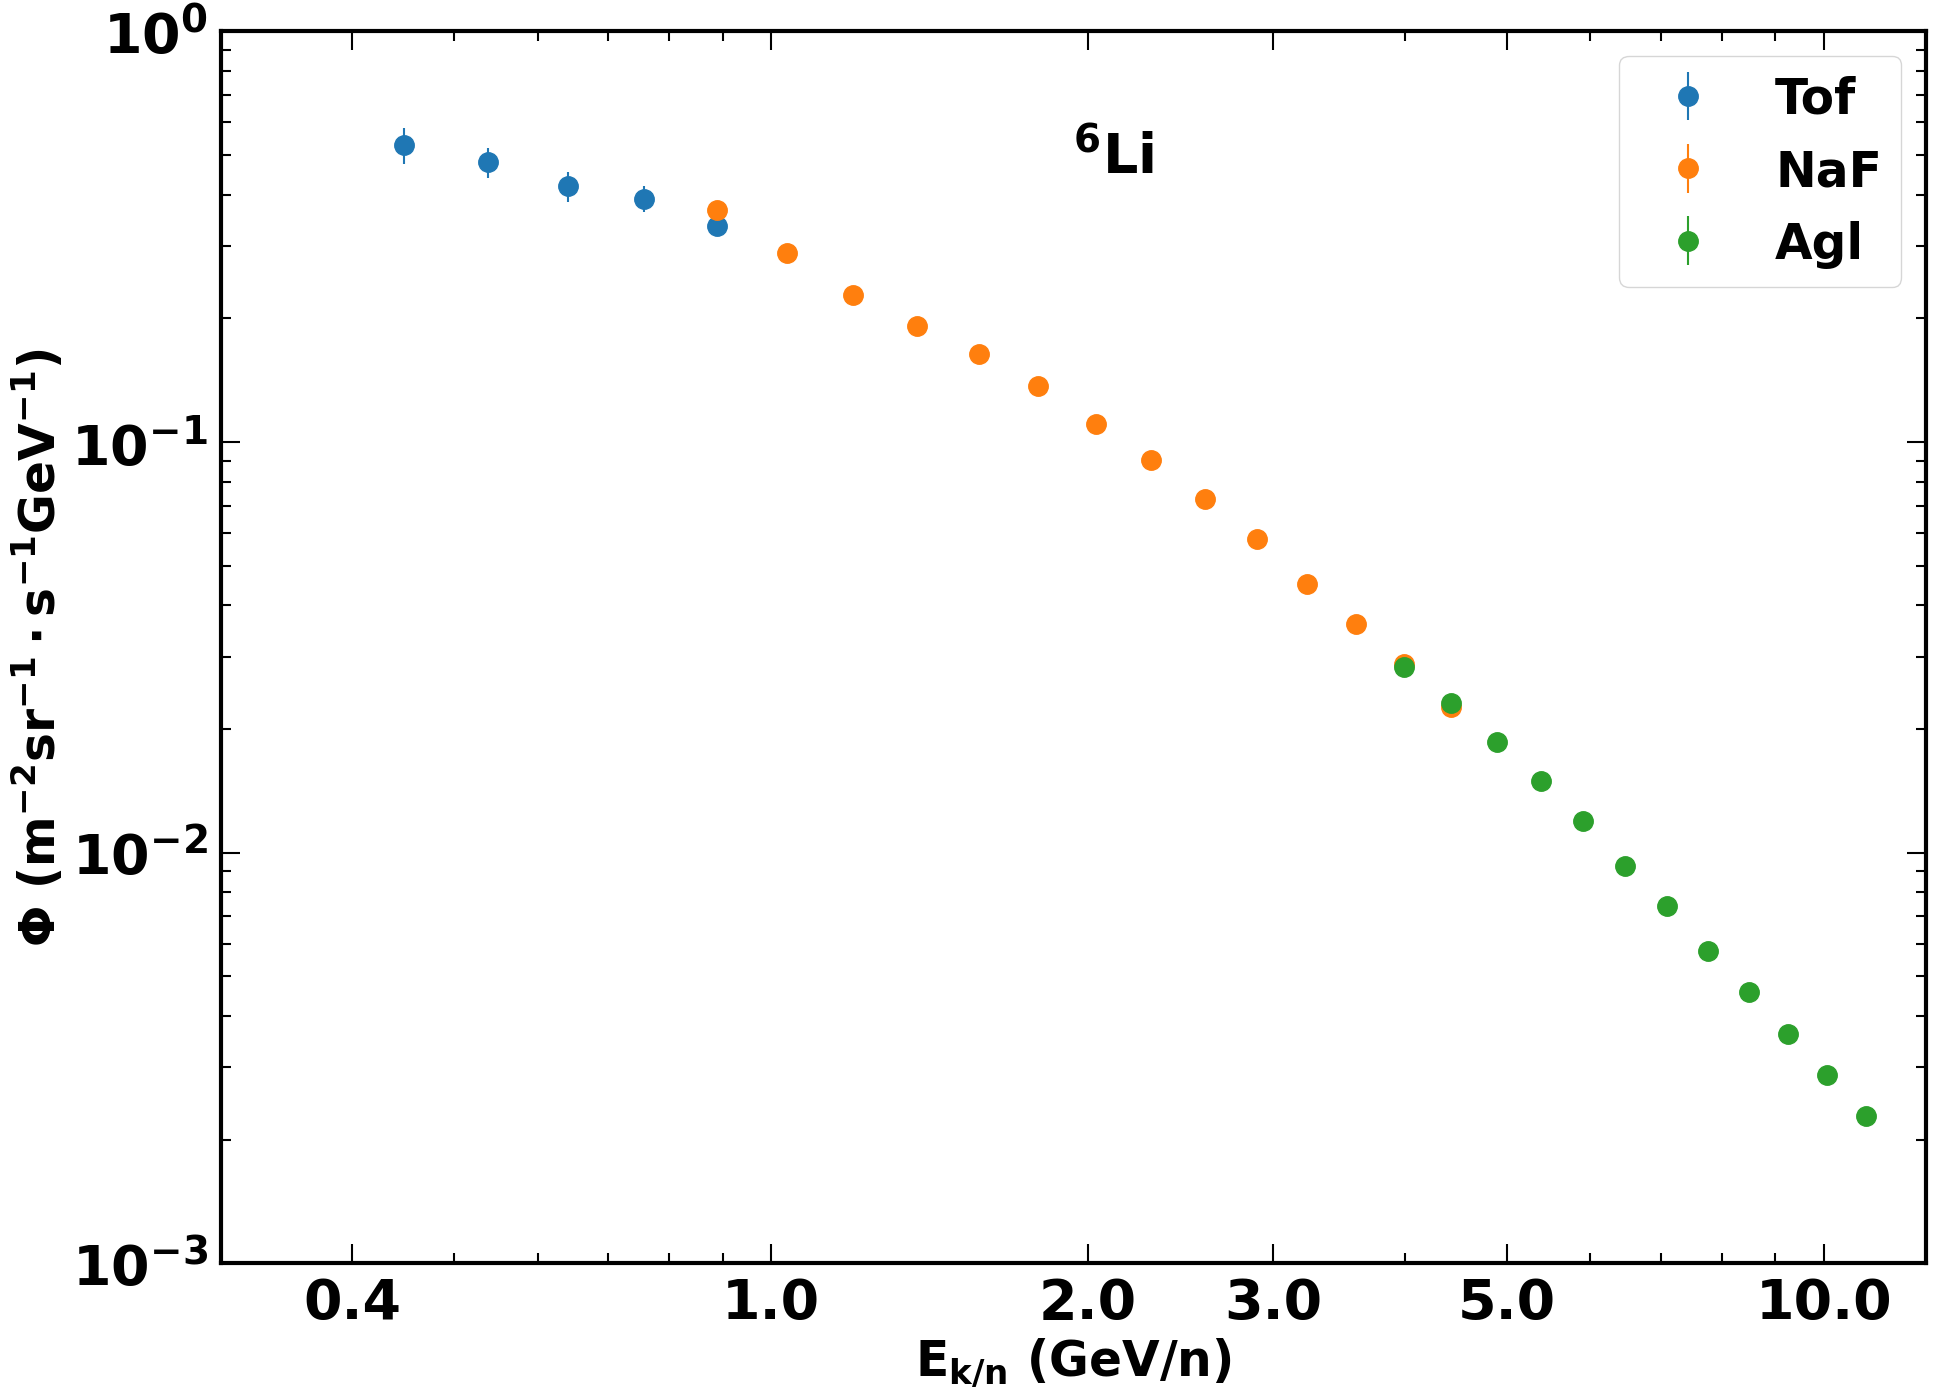

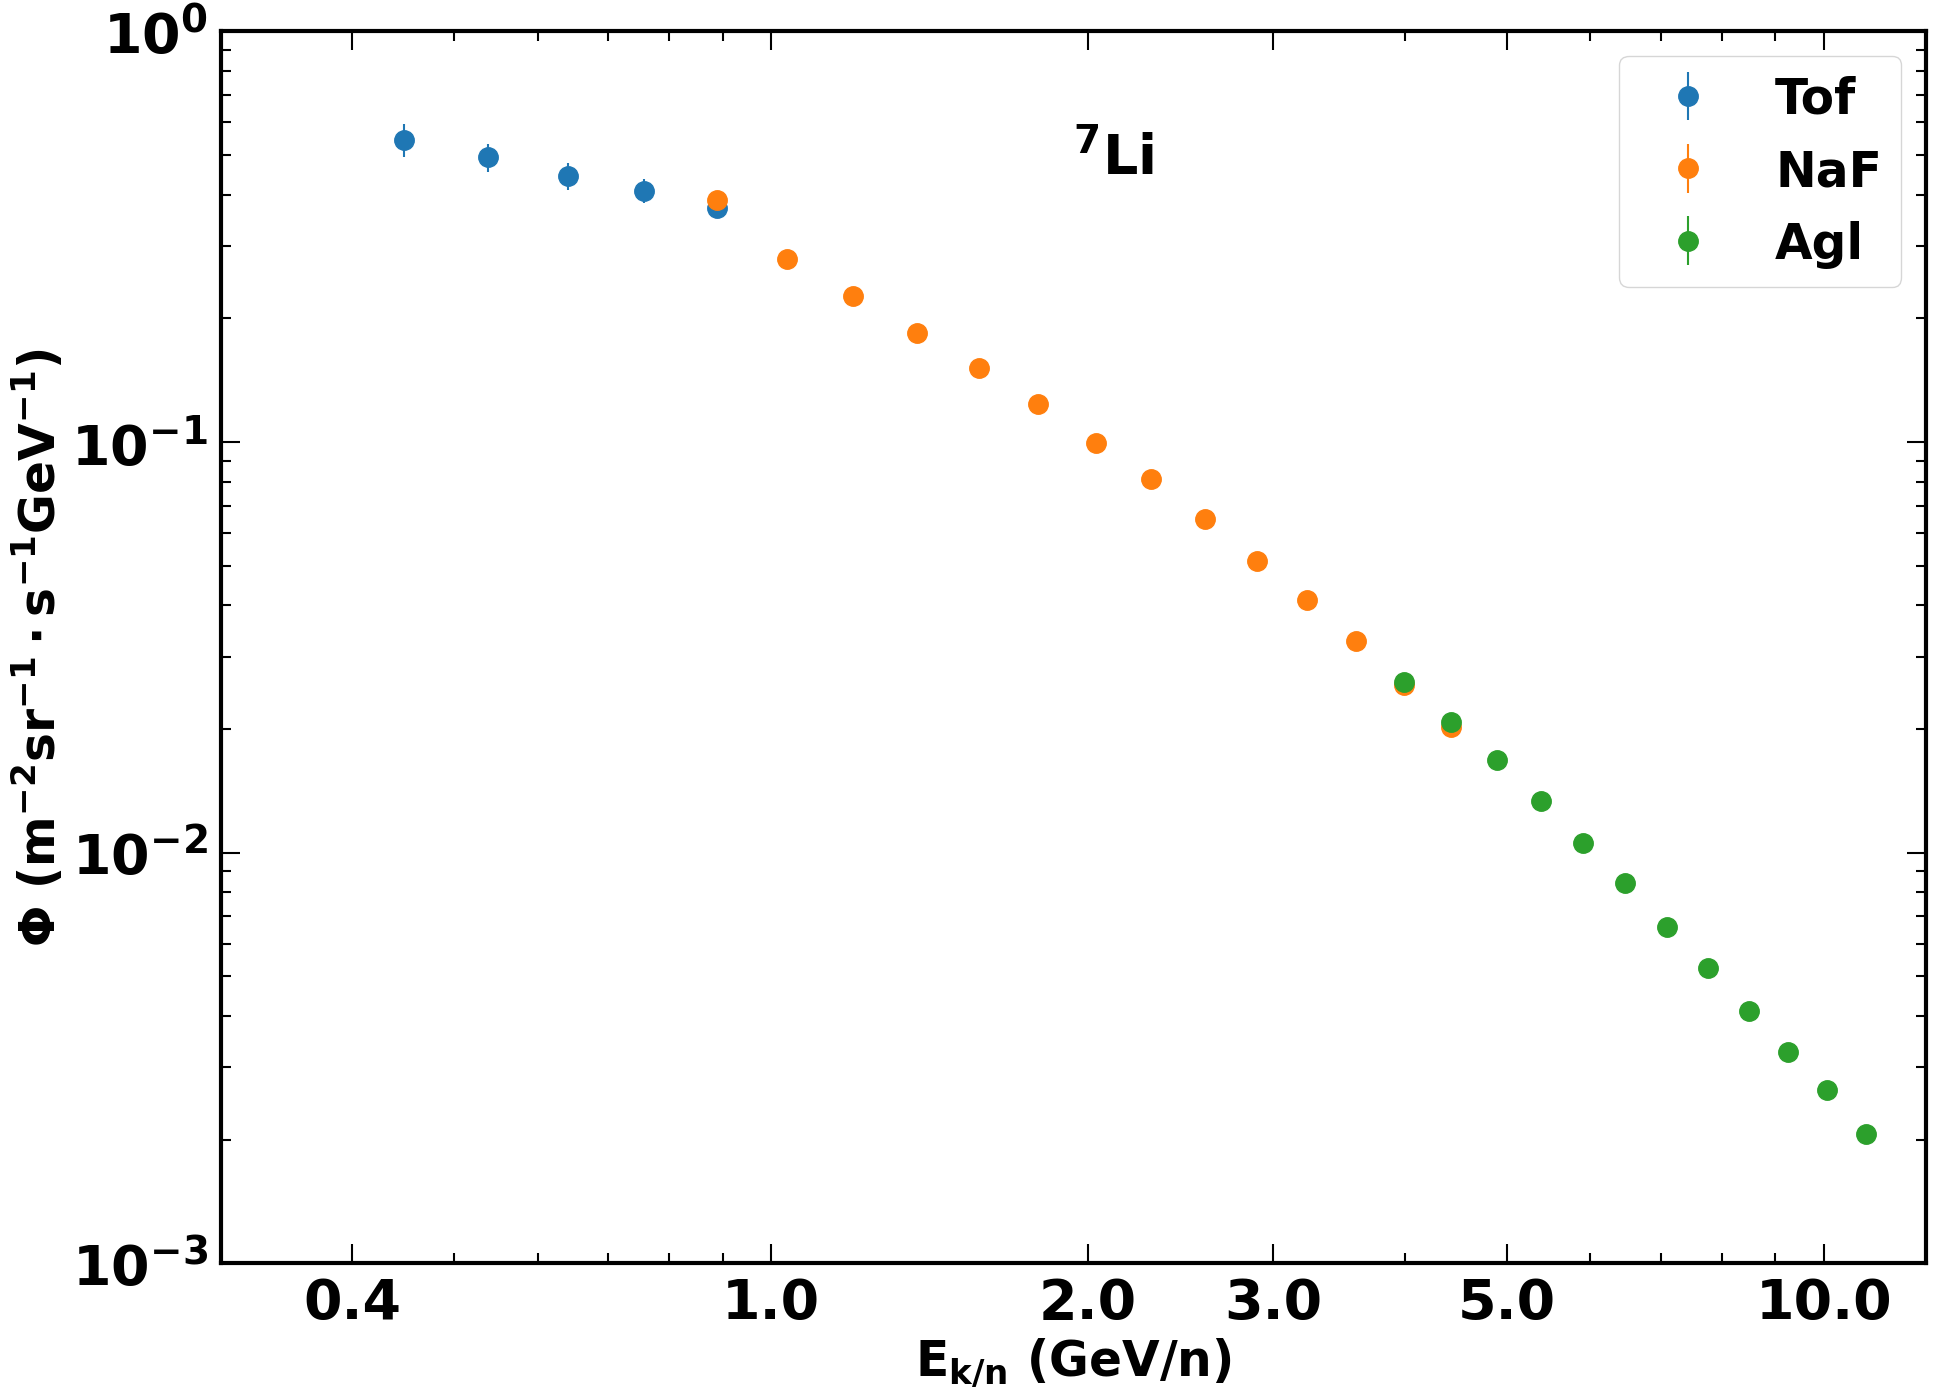

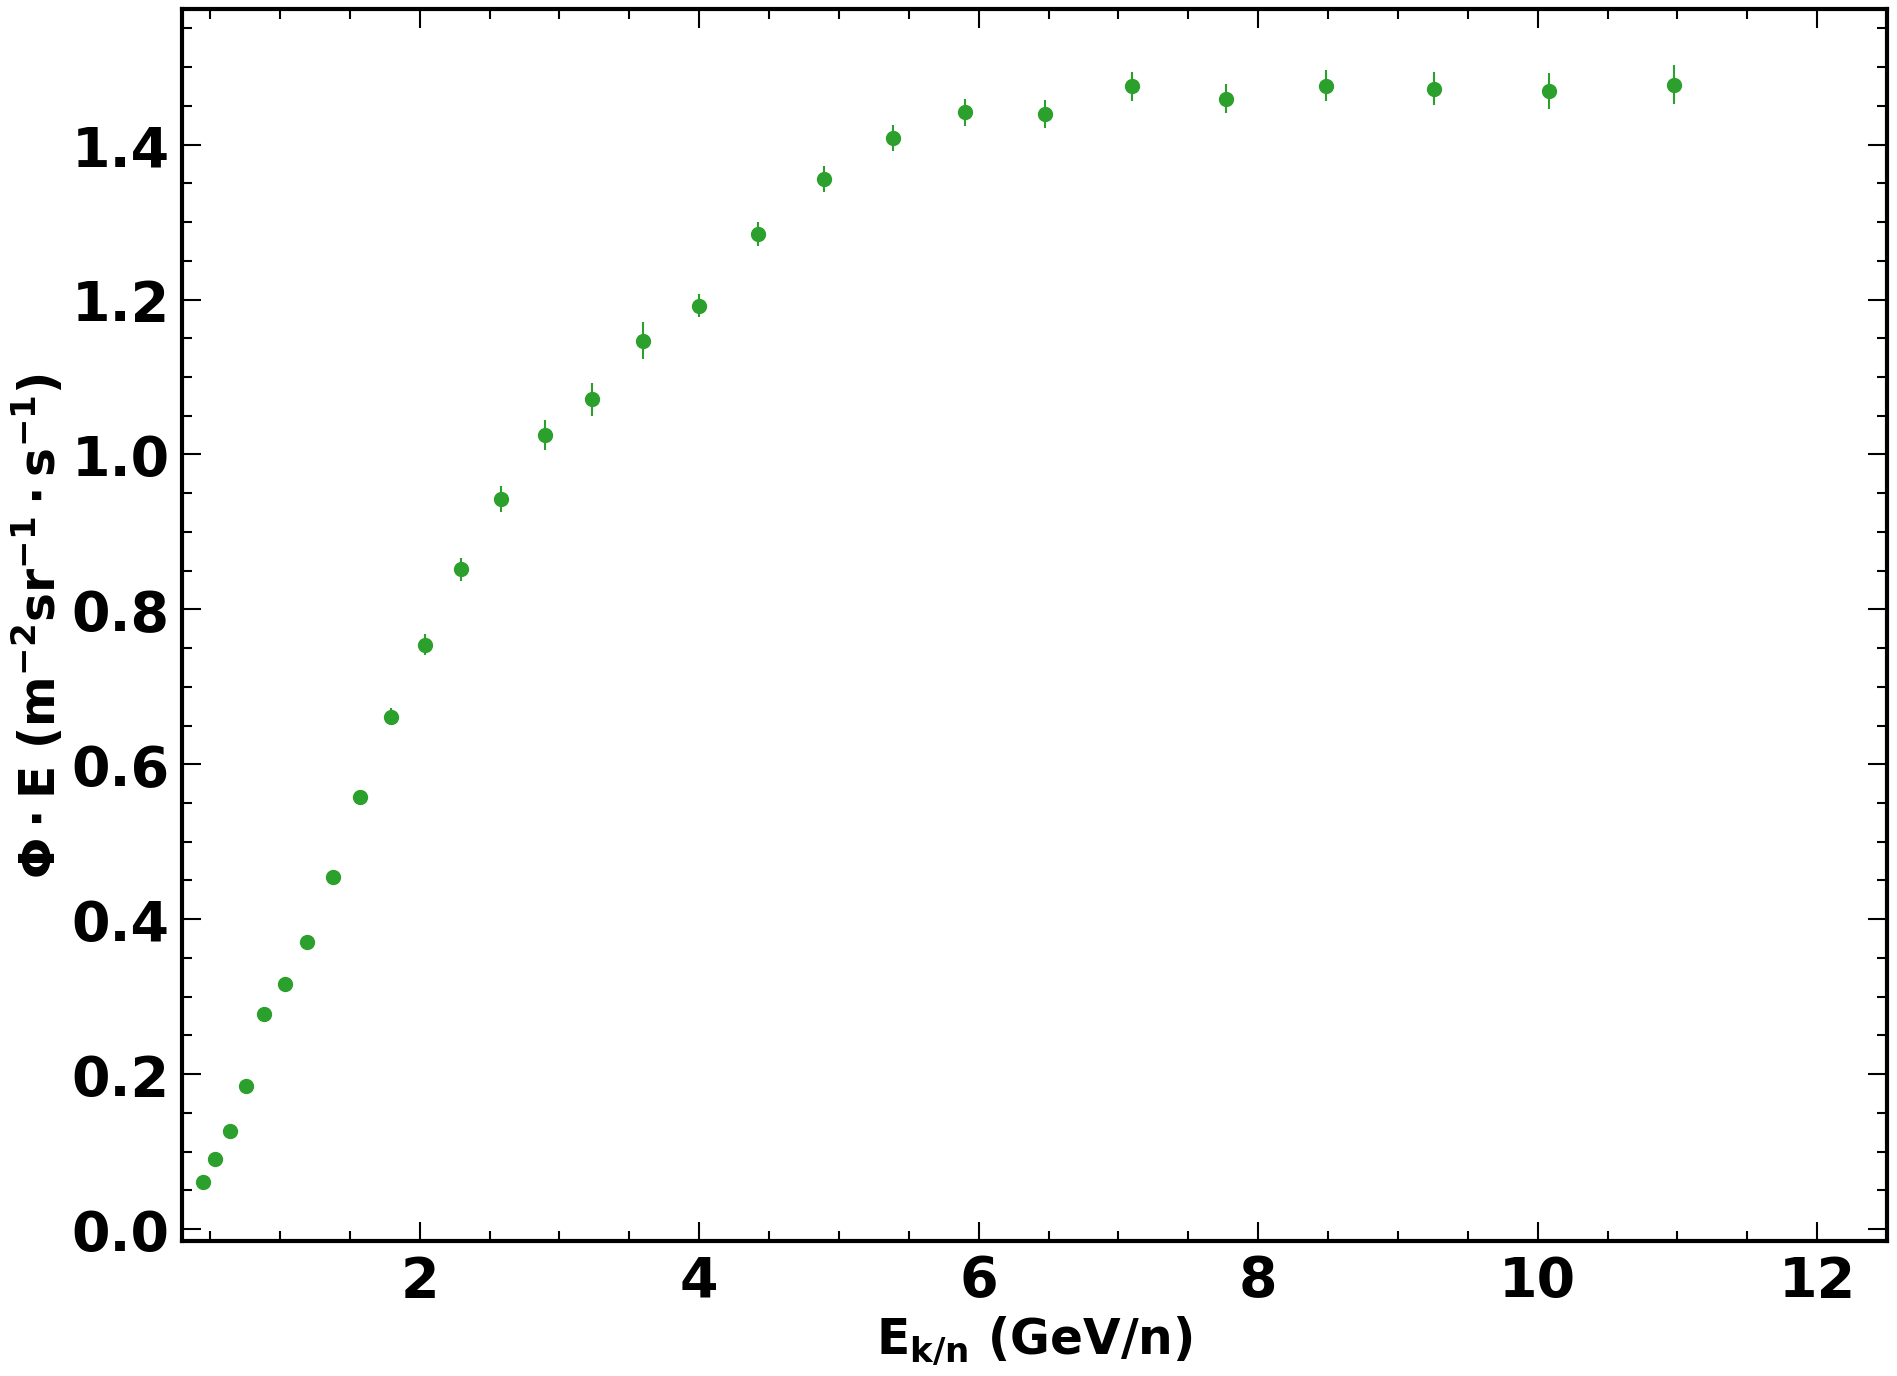

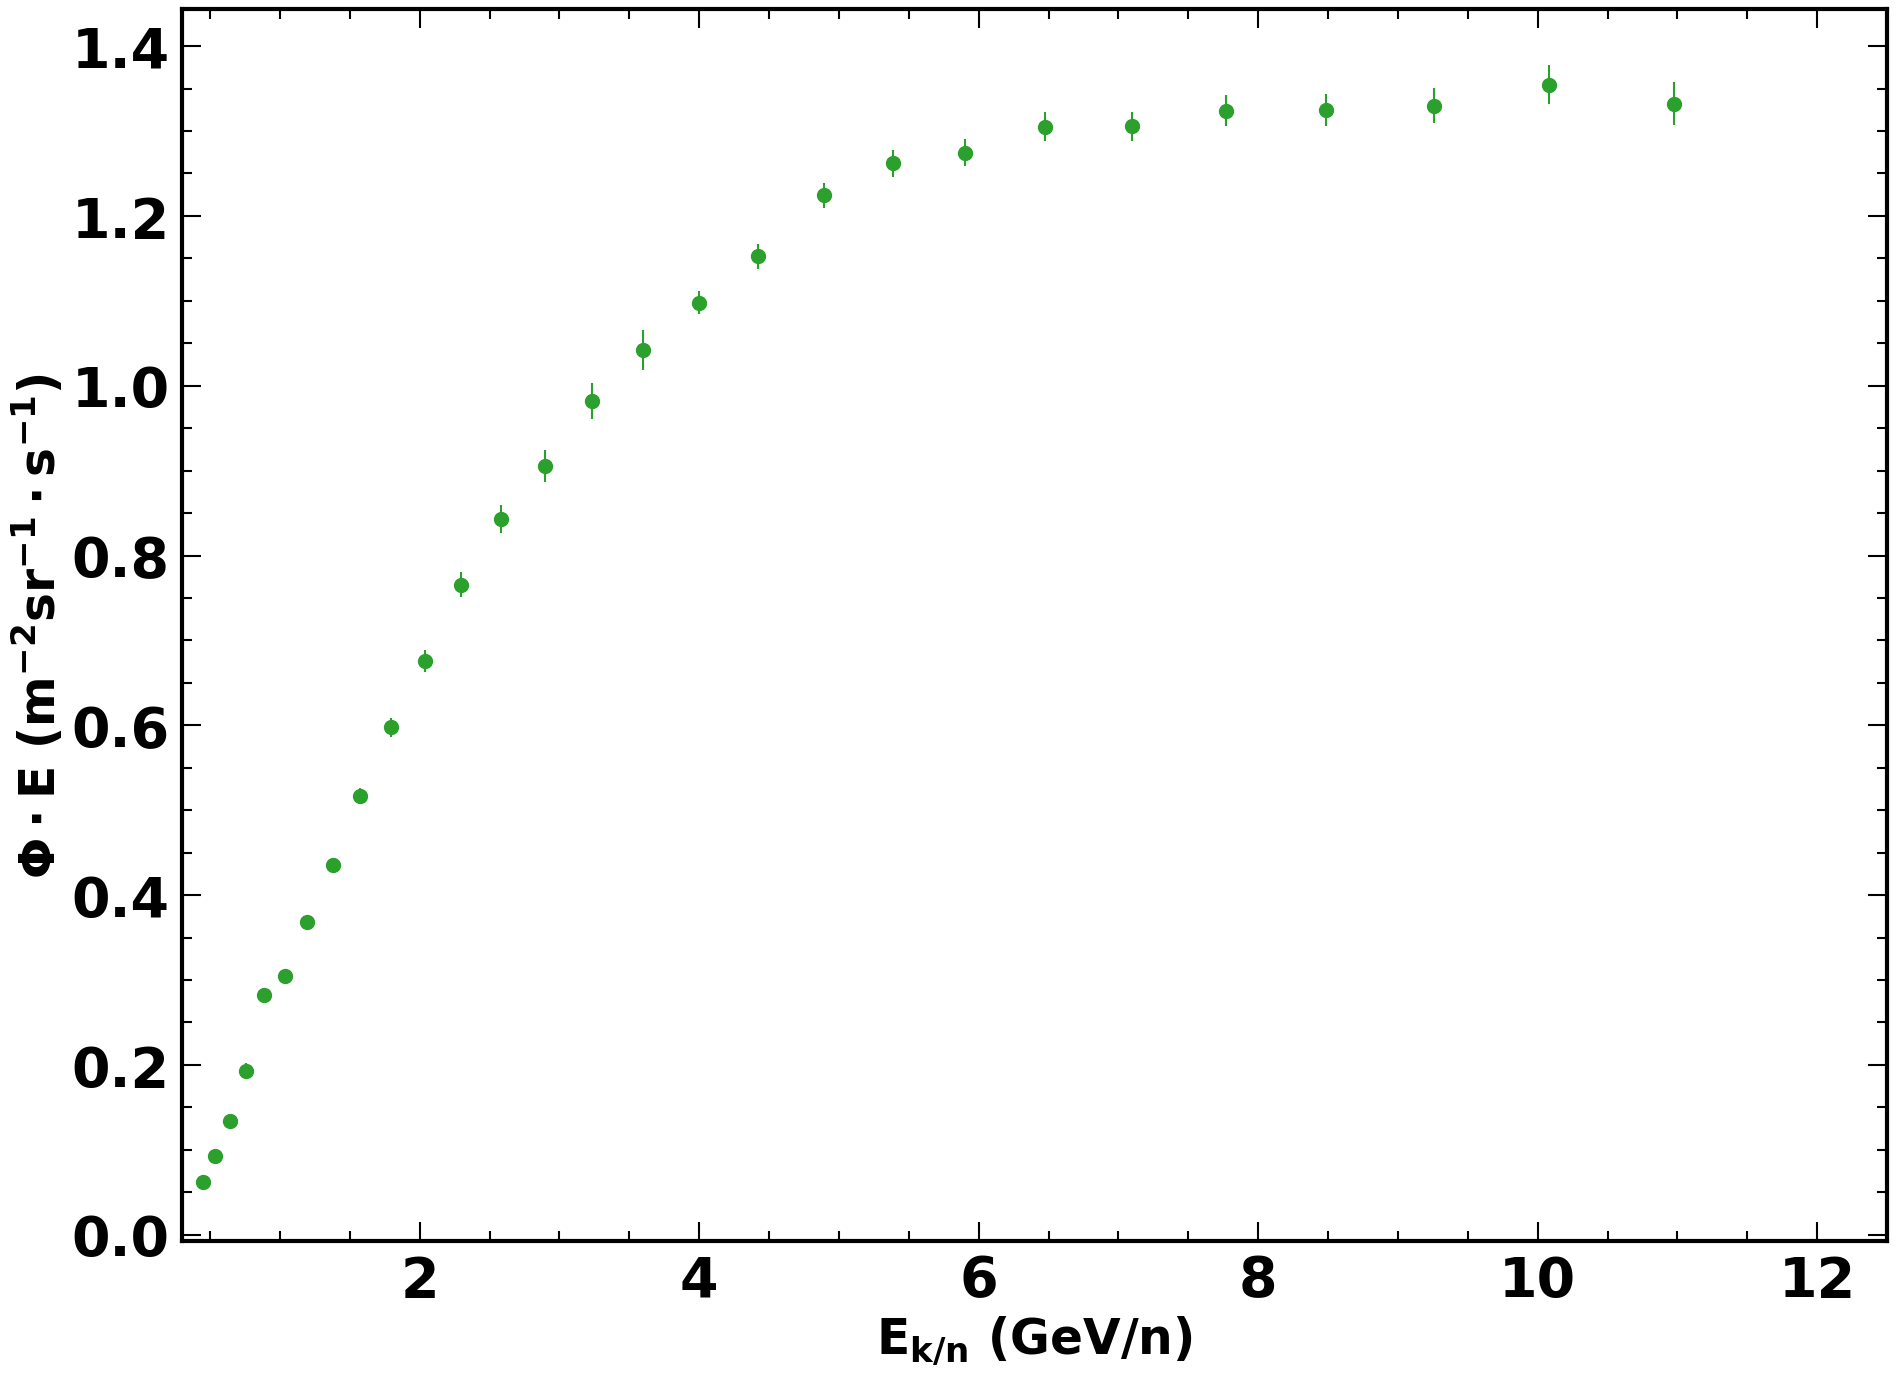

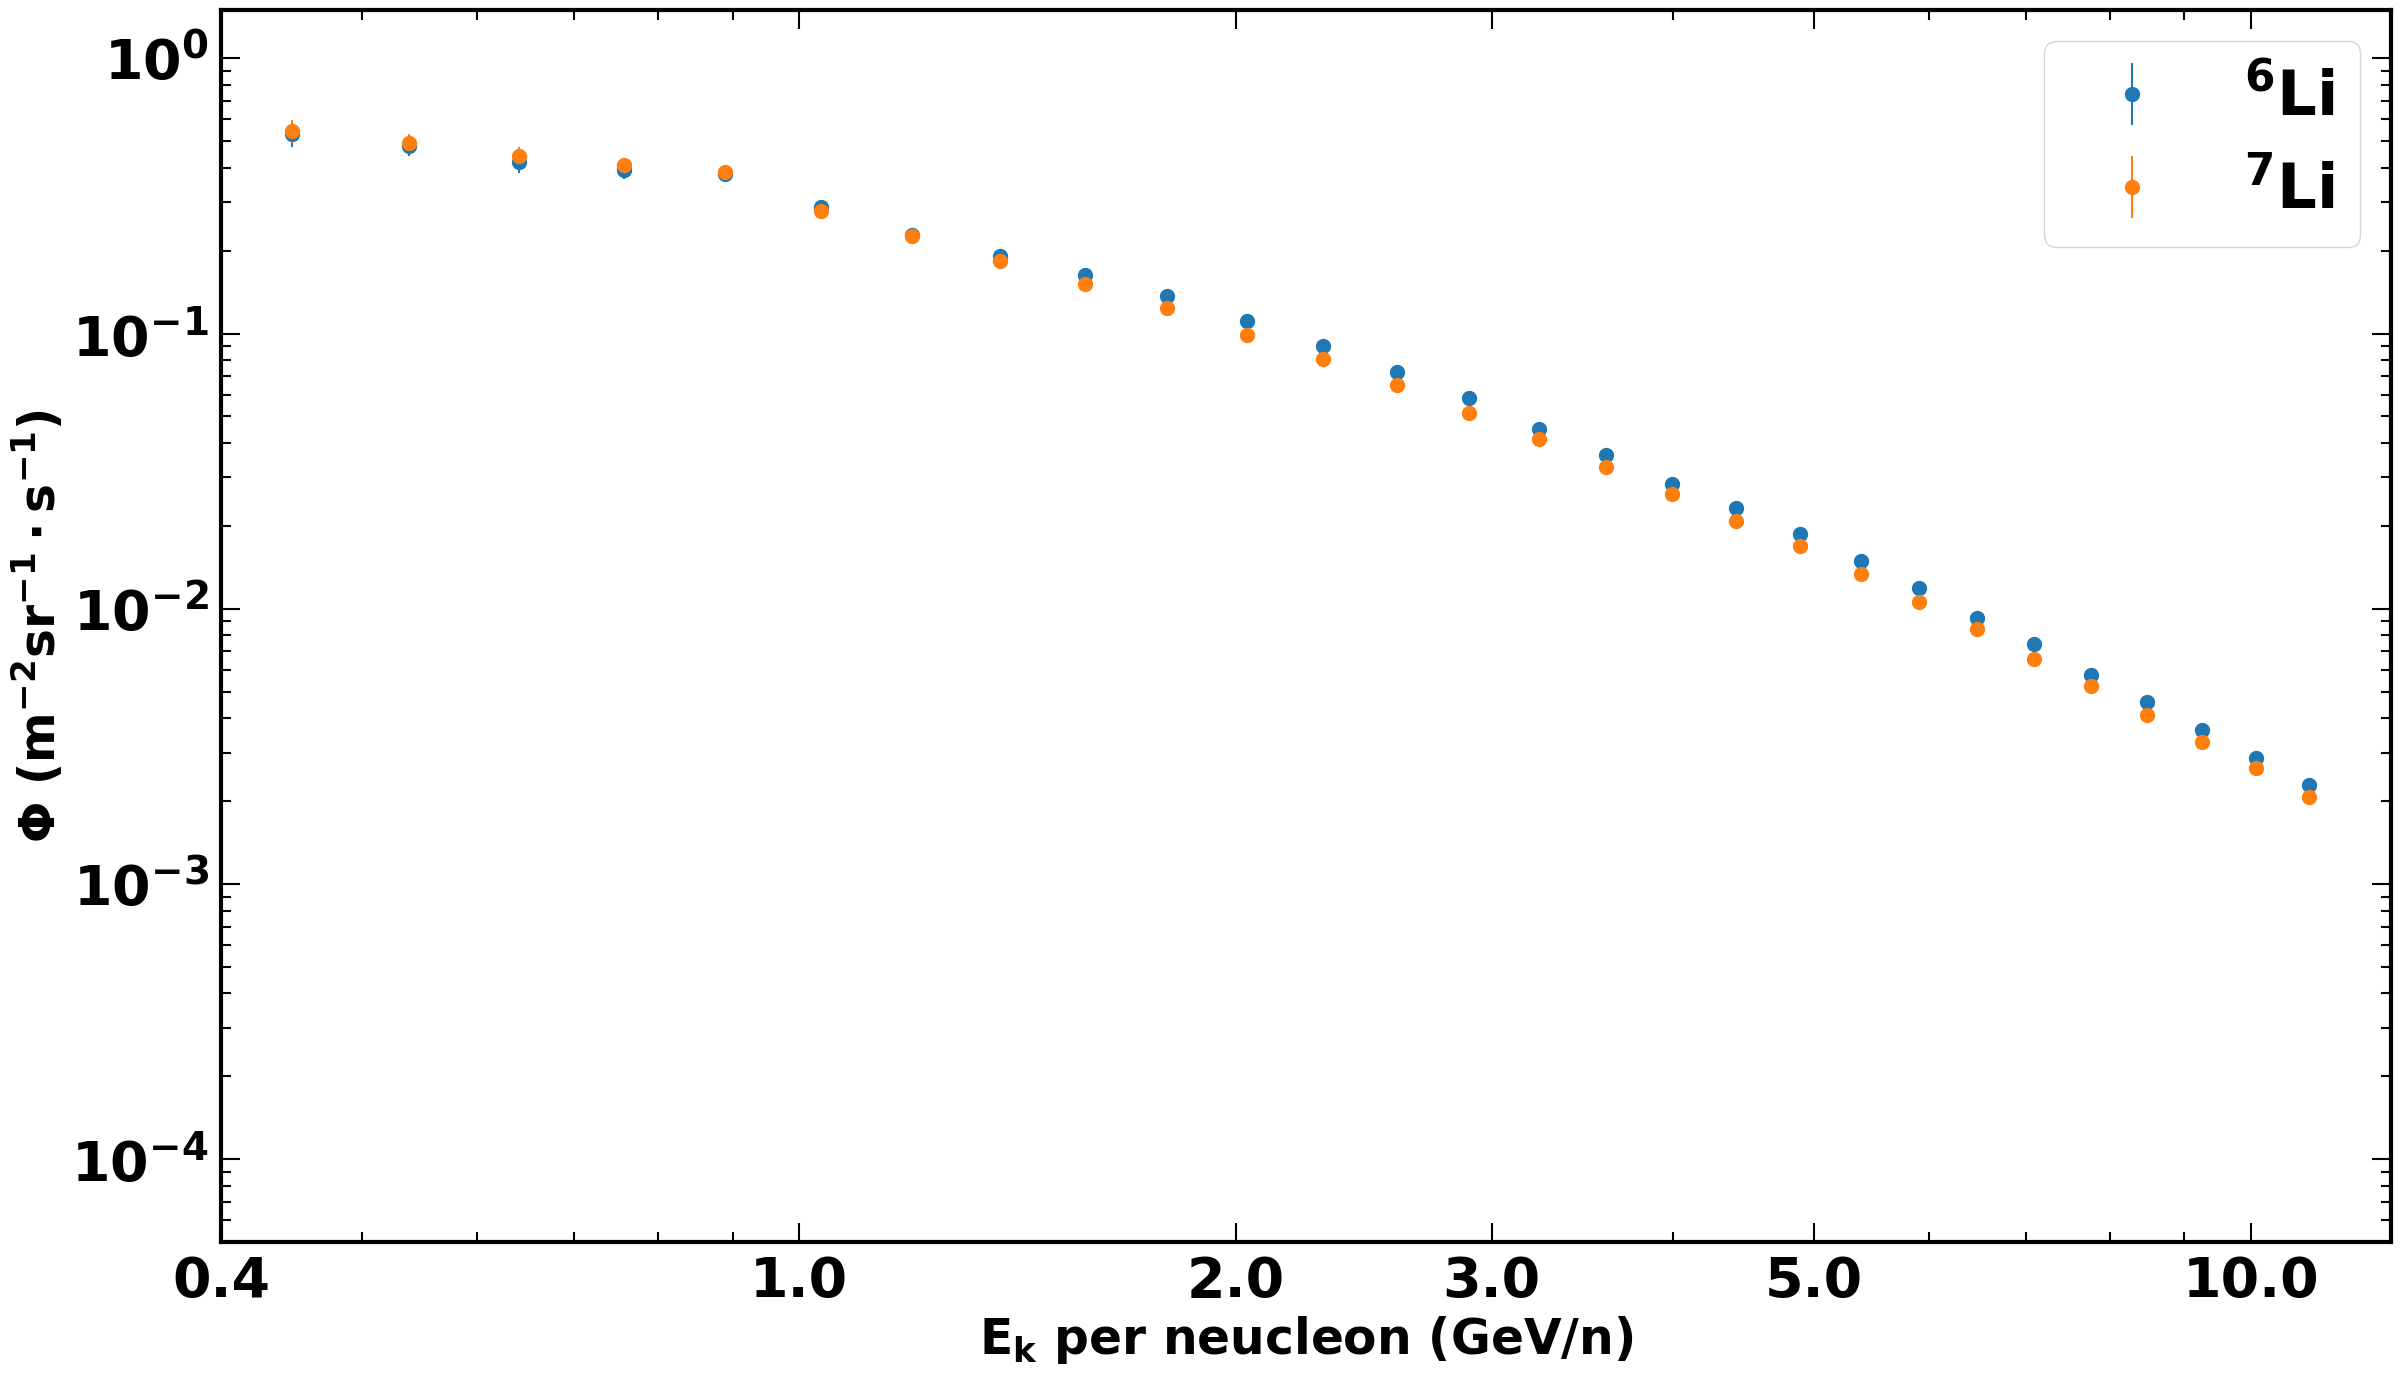

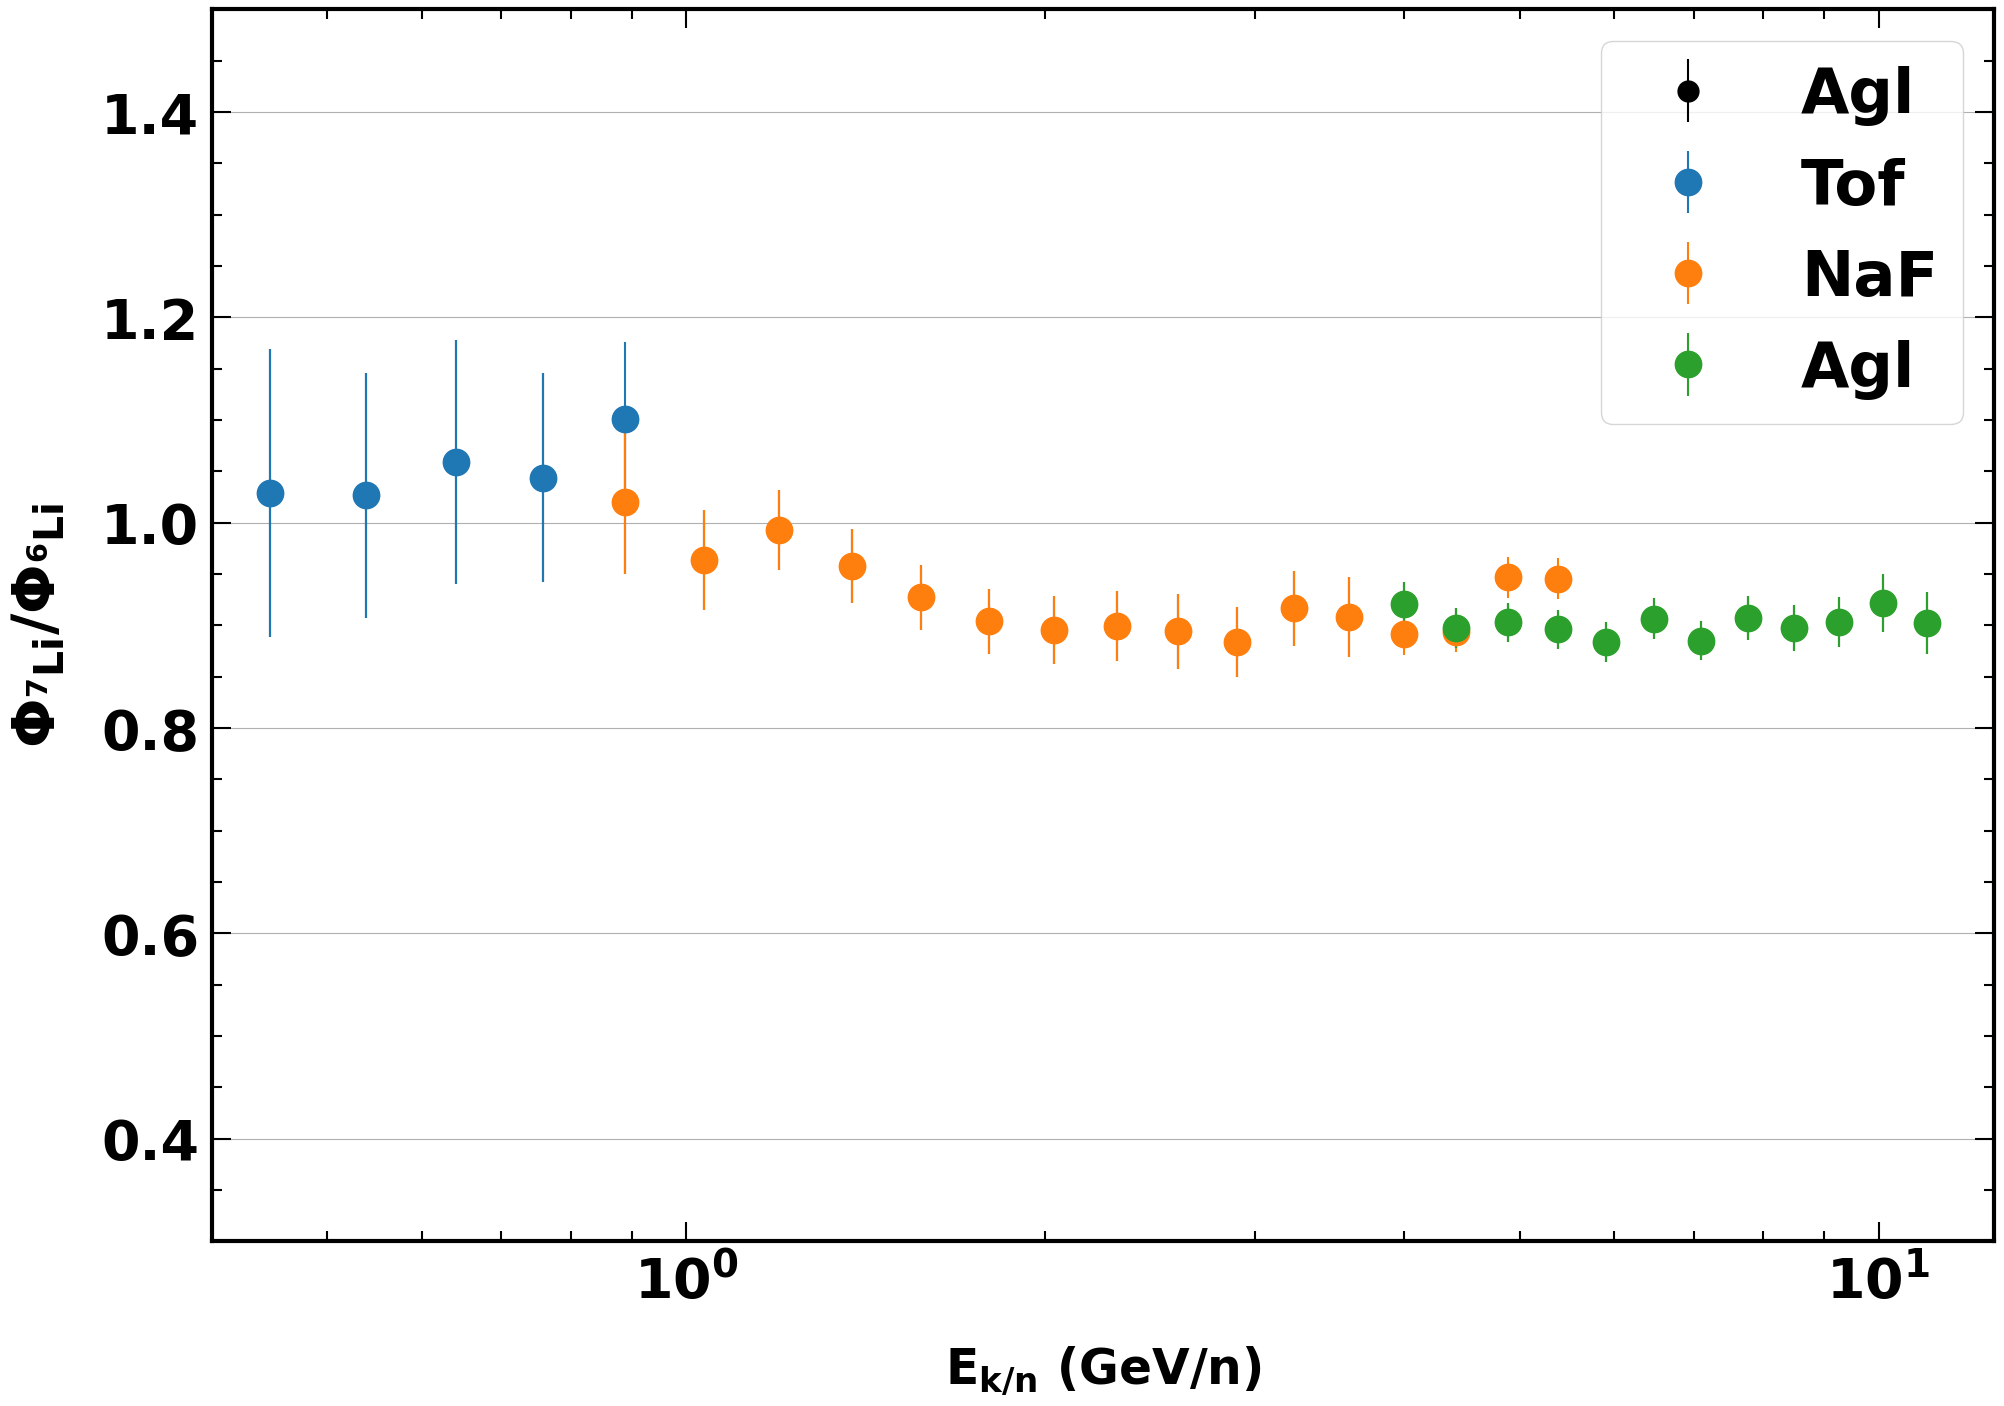

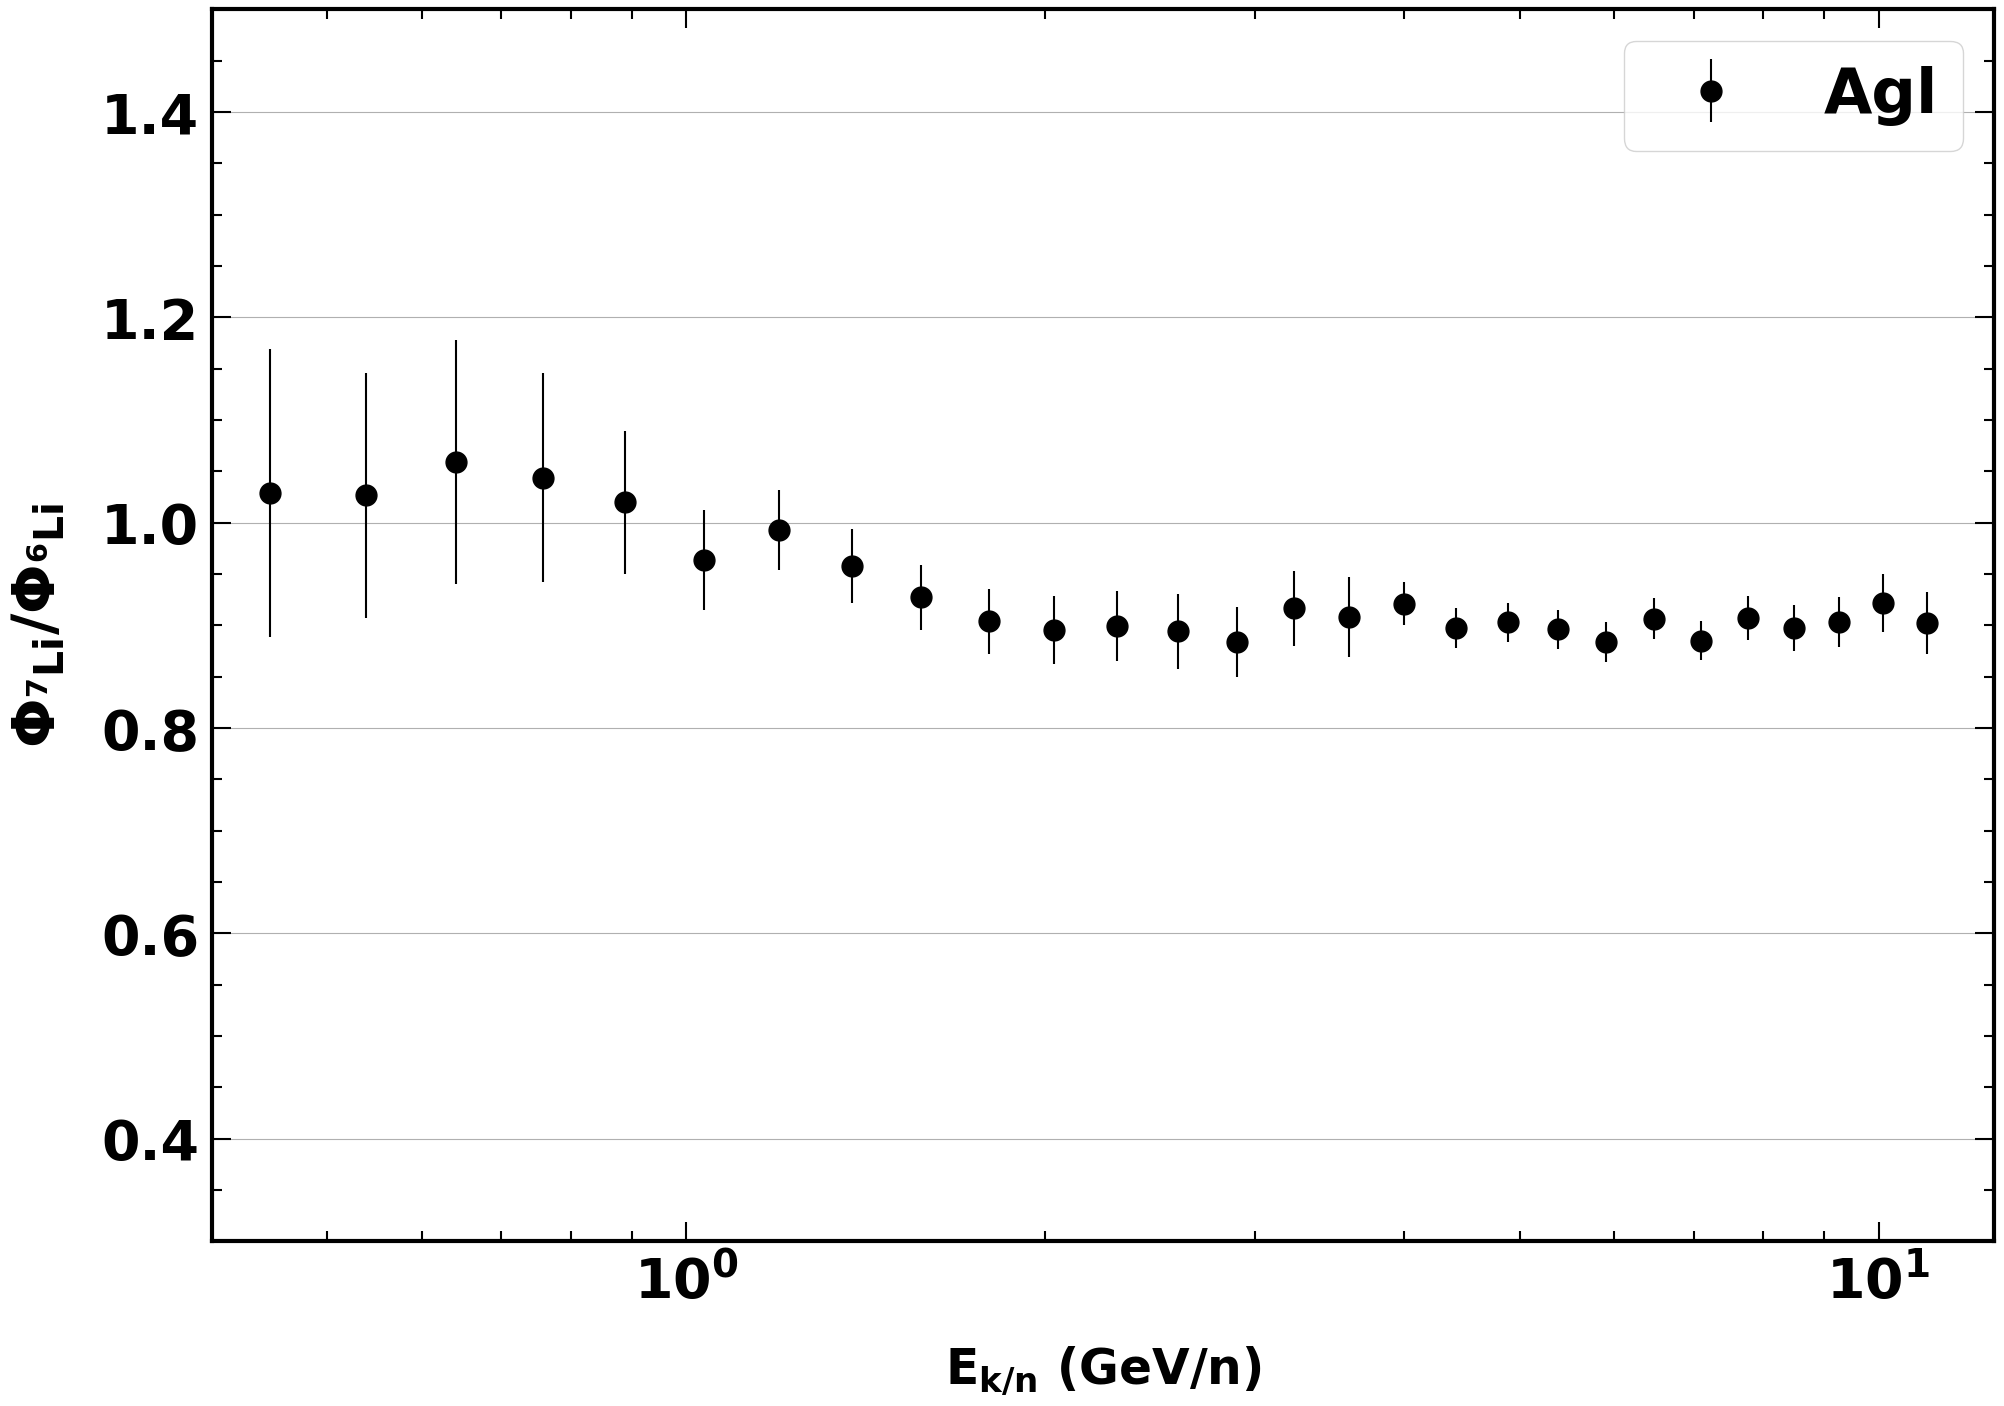

In [17]:
def write_results_anderrs_tofile(graph1, graph_syserr, xbinning, datadir, filename, header=None, fmt=None, writeHeader=True):
    xbin_indices = xbinning.get_indices([graph1.xvalues[0], graph1.xvalues[-1]])
    bin_edges = xbinning.edges[xbin_indices[0]: xbin_indices[1]+2]  
    if header is None:        
        header = "Ekn_low_bin_edge\tEkn_up_bin_edge\tResult\tstatistical_error\tsystematic_error\t"                                                                                                 
    if fmt is None:                                                                                                                                
        fmt = ('%.4f', '%.4f', '%.6f', '%.6f', '%.6f')    
    combined_array = np.column_stack((bin_edges[0:-1], bin_edges[1:], graph1.yvalues, graph1.yerrs, graph_syserr.yerrs))
    delimiter = ', ' 
    np.savetxt(os.path.join(datadir, f'{filename}.txt'), combined_array, fmt=fmt, delimiter=delimiter, header=header, comments='')  


slicevalue = {'Tof':[0.4, 0.8], 'NaF':[0.9, 3.7], 'Agl':[4.0, 12.3]}
subgraph_ratio = {}
subgraph_rawflux = {dec: {} for dec in detectors}

for dec in detectors:
    subgraph_ratio[dec] = slice_graph_by_value(graph_rawflux_ratio[dec], slicevalue[dec])
    for iso in isotopes:
        
        subgraph_rawflux[dec][iso] = slice_graph_by_value(graph_rawflux[dec][iso], slicevalue[dec])
        
graph_fluxratio_combined = subgraph_ratio['Tof']
graph_fluxratio_combined = concatenate_graphs(graph_fluxratio_combined, subgraph_ratio['NaF'])
graph_fluxratio_combined = concatenate_graphs(graph_fluxratio_combined, subgraph_ratio['Agl'])

graph_rawflux_combined = {}
for iso in isotopes:
    graph_rawflux_combined[iso] = subgraph_rawflux['Tof'][iso]
    graph_rawflux_combined[iso] = concatenate_graphs(graph_rawflux_combined[iso], subgraph_rawflux['NaF'][iso])
    graph_rawflux_combined[iso] = concatenate_graphs(graph_rawflux_combined[iso], subgraph_rawflux['Agl'][iso])

subgraph_rawflux_toterr = {dec: {} for dec in detectors}
graph_rawflux_combined_toterr = {}
for dec in detectors:
    for iso in isotopes:
        subgraph_rawflux_toterr[dec][iso] = slice_graph_by_value(graph_rawflux_toterr[dec][iso], slicevalue[dec])
        
for iso in isotopes:
    graph_rawflux_combined_toterr[iso] = subgraph_rawflux_toterr['Tof'][iso]
    graph_rawflux_combined_toterr[iso] = concatenate_graphs(graph_rawflux_combined_toterr[iso], subgraph_rawflux_toterr['NaF'][iso])
    graph_rawflux_combined_toterr[iso] = concatenate_graphs(graph_rawflux_combined_toterr[iso], subgraph_rawflux_toterr['Agl'][iso])
    

Liresultsdir = '/home/manbing/Documents/Data/data_LiP8/Li_results_June19/'
file_unfold = Liresultsdir + 'graph_unfold_factor_Li.npz'
df_unfold = np.load(f'{file_unfold}')
xbinning = Binning(fbinning_energy_Li())
print(list(df_unfold.keys()))

spline_unfold_factor = {}
graph_unfold_factor = {}
graph_unfold_factor_finebin = {}
xvaluerange = {'Tof': [0.6, 1.1], 'NaF':[1.0, 3.6], 'Agl':[4.2, 11]}
graph_unfoldflux_combined_staterr = {}
graph_unfoldflux_combined_toterr = {}
graph_unfoldflux_combined_syserr = {}
graph_unfoldflux_combined_timesE = {}
dir_saveflux = {}

for iso in ISOTOPES[nuclei]:
    graph_unfold_factor[iso] = MGraph.from_file(df_unfold, f'graph_{iso}_unfoldfactor')
    spline_unfold_factor[iso] = UnivariateSpline(np.log(graph_unfold_factor[iso].xvalues), graph_unfold_factor[iso].yvalues, k=3, s=5)           
    xvalues = graph_rawflux_combined[iso].xvalues
    unfoldfactor = spline_unfold_factor[iso](np.log(xvalues))
    graph_unfold_factor_finebin[iso] = MGraph(xvalues, unfoldfactor, np.zeros_like(unfoldfactor))
    
    #unfolded flux with staterr and total err
    graph_unfoldflux_combined_staterr[iso] = MGraph(xvalues, graph_rawflux_combined[iso].yvalues * unfoldfactor, graph_rawflux_combined[iso].yerrs * unfoldfactor)
    graph_unfoldflux_combined_toterr[iso] = MGraph(xvalues, graph_rawflux_combined_toterr[iso].yvalues * unfoldfactor, graph_rawflux_combined_toterr[iso].yerrs * unfoldfactor)
    
    #unfolded flux with syserr
    syserr = np.sqrt(graph_unfoldflux_combined_toterr[iso].yerrs**2 - graph_unfoldflux_combined_staterr[iso].yerrs**2)
    graph_unfoldflux_combined_syserr[iso] = MGraph(xvalues, graph_unfoldflux_combined_staterr[iso].yvalues, syserr)
    write_results_anderrs_tofile(graph_unfoldflux_combined_staterr[iso], graph_unfoldflux_combined_syserr[iso], xbinning, Liresultsdir, f'{iso}Flux_StatSysErr')
    
    #write_points_totxt_with_binedge(graph_unfoldflux_combined_staterr[iso], xbinning, Liresultsdir, f'{iso}Flux_staterr')    
    #write_points_totxt_with_binedge(graph_unfoldflux_combined_toterr[iso], xbinning, Liresultsdir, f'{iso}Flux_toterr')  
    
    graph_unfoldflux_combined_timesE[iso] = MGraph(xvalues, graph_rawflux_combined[iso].yvalues * unfoldfactor * xvalues**2.7, graph_rawflux_combined[iso].yerrs * unfoldfactor*xvalues**2.7)
    graph_unfoldflux_combined_toterr[iso].add_to_file(dir_saveflux, f'graph_{iso}_unfoldflux_toterr')
    graph_unfoldflux_combined_staterr[iso].add_to_file(dir_saveflux, f'graph_{iso}_unfoldflux_staterr')

np.savez(os.path.join(Liresultsdir, 'graph_Li_unfoldflux.npz'), **dir_saveflux)   

#ratio stat err and tot err 
graph_ratio_Li7ToLi6_combined_stat = graph_unfoldflux_combined_staterr['Li7']/graph_unfoldflux_combined_staterr['Li6']
graph_ratio_Li7ToLi6_combined_tot = graph_unfoldflux_combined_toterr['Li7']/graph_unfoldflux_combined_toterr['Li6']

#ratio with syserr and write to output txt
syserr_ratio7to6 = np.sqrt(graph_ratio_Li7ToLi6_combined_tot.yerrs**2 - graph_ratio_Li7ToLi6_combined_stat.yerrs**2)
graph_ratio_Li7ToLi6_combined_sys = MGraph(graph_ratio_Li7ToLi6_combined_stat.xvalues, graph_ratio_Li7ToLi6_combined_stat.yvalues, syserr_ratio7to6)
write_results_anderrs_tofile(graph_ratio_Li7ToLi6_combined_stat, graph_ratio_Li7ToLi6_combined_sys, xbinning, Liresultsdir, f'Li7ToLi6Ratio_StatSysErr')

graph_Li7ToLi6Ratio = graph_unfoldflux_combined_toterr['Li7']/graph_unfoldflux_combined_toterr['Li6']
write_points_totxt_with_binedge(graph_Li7ToLi6Ratio, xbinning, Liresultsdir, f'Li7ToLi6Ratio_22May')    
###############################################
#read jiahui'ratio and draw compare













#combined total flux and flux fraction 


##########################################################################
#ratio of three detectors
##########################################################################
graph_unfoldflux_staterr = {dec: {} for dec in detectors}   
graph_unfoldflux_toterr = {dec: {} for dec in detectors}

for dec in detectors:
    for iso in isotopes:
        xvalues = graph_rawflux[dec][iso].xvalues
        unfoldfactor = spline_unfold_factor[iso](np.log(xvalues))
        graph_unfoldflux_staterr[dec][iso] = MGraph(graph_rawflux[dec][iso].xvalues, graph_rawflux[dec][iso].yvalues * unfoldfactor, graph_rawflux[dec][iso].yerrs * unfoldfactor)
        graph_unfoldflux_toterr[dec][iso] = MGraph(graph_rawflux_toterr[dec][iso].xvalues, graph_rawflux_toterr[dec][iso].yvalues * unfoldfactor, graph_rawflux_toterr[dec][iso].yerrs * unfoldfactor)

graph_ratio_li7toli6_staterr = {}
graph_ratio_li7toli6_toterr = {}
for dec in detectors:
    graph_ratio_li7toli6_staterr[dec] = graph_unfoldflux_staterr[dec]['Li7']/graph_unfoldflux_staterr[dec]['Li6']
    graph_ratio_li7toli6_toterr[dec] = graph_unfoldflux_toterr[dec]['Li7']/graph_unfoldflux_toterr[dec]['Li6']
    
        
        
fig, ax1 = plt.subplots(figsize=(26, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95)
for iso in ISOTOPES[nuclei]:
    plot_graph(fig, ax1, graph_unfold_factor_finebin[iso], color=ISOTOPES_COLOR[iso], style="hist", xlog=True, ylog=False, markersize=20, label=f"{ISO_LABELS[iso]}")
ax1.set_ylim([0.9, 1.2])
ax1.fill_betweenx(np.linspace(0.9, 1.2, 100), 1.2, 4.0, alpha=0.08, color="tab:blue") 
ax1.legend()
ax1.set_xlabel('Ekin/n (GeV/n)')
ax1.set_ylabel('Unfolded/Raw')
set_plot_style(ax1) 

graph_unfoldflux_toterr['NaF']['Li6'].yvalues[0] = 0.368
for iso in ISOTOPES[nuclei]:
    graph_unfoldflux_toterr['NaF'][iso] = slice_graph_by_value(graph_unfoldflux_toterr['NaF'][iso], [0.9, 4.5])
for iso in ISOTOPES[nuclei]:
    fig, ax1 = plt.subplots(figsize=(22, 16))
    for dec in detectors:
        plot_graph(fig, ax1, graph_unfoldflux_toterr[dec][iso], color=DETECTOR_COLOR[dec], style="EP", xlog=True, ylog=True, markersize=28, label=f"{dec}")
        #plot_graph(fig, ax1, graph_rawflux[dec][iso], color=DETECTOR_COLOR[dec], style="EP", xlog=True, ylog=True, markersize=20, label=f"{ISO_LABELS[iso]}")
        #graph_unfoldflux[dec][iso].add_to_file(df_unfoldflux, f'graph_unfoldflux_{dec}{iso}')
        
    ax1.set_ylabel(r"$\mathrm{\Phi \ (m^{-2} sr^{-1} \cdot s^{-1} GeV^{-1})} $", fontsize=35) 
    ax1.set_xlabel(r"$\mathrm{E_{k/n}}$ (GeV/n)", fontsize=35)     
    ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())  
    set_plot_style(ax1) 
    ax1.legend(fontsize=35)
    ax1.set_xlim([0.3, 12.5])
    ax1.set_ylim([0.001, 1.0])
    #ax1.legend()
    print(plotdir)
    ax1.text(0.5, 0.92, f"{ISO_LABELS[iso]}", fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      
    
    

    
for iso in ISOTOPES[nuclei]:
    fig, ax1 = plt.subplots(figsize=(22, 16))
    plot_graph(fig, ax1, graph_unfoldflux_combined_timesE[iso], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, markersize=20, label=f"{ISO_LABELS[iso]}")
        #graph_unfoldflux[dec][iso].add_to_file(df_unfoldflux, f'graph_unfoldflux_{dec}{iso}')
        
    ax1.set_ylabel(r"$\mathrm{\Phi\cdot E \ (m^{-2} sr^{-1} \cdot s^{-1})} $", fontsize=35) 
    ax1.set_xlabel(r"$\mathrm{E_{k/n}}$ (GeV/n)", fontsize=35)     
    #ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
    #ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())  
    set_plot_style(ax1) 
    ax1.set_xlim([0.3, 12.5])
    #ax1.set_ylim([0.08, 1.0])
    #ax1.legend()

    
    
############################################################################################
#combine the three detector flux and print out, both the stat err and sys err and total err
#############################################################################################


fig, ax1 = plt.subplots(figsize=(28, 16))
for iso in ISOTOPES[nuclei]:
    plot_graph(fig, ax1, graph_unfoldflux_combined_toterr[iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=True, markersize=20, label=f"{ISO_LABELS[iso]}")
        
ax1.set_ylabel(r"$\mathrm{\Phi \ (m^{-2} sr^{-1} \cdot s^{-1})}$", fontsize=35) 
ax1.set_xlabel(r"$\mathrm{E_{k}}$ per neucleon (GeV/n)", fontsize=35)     
ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())  
set_plot_style(ax1)   
ax1.legend()
ax1.set_ylim([0.00005, 1.5])
ax1.set_xlim([0.4, 12.5])



#################################################################################################


fig, ax1 = plt.subplots(figsize=(23, 16))
plot_graph(fig, ax1, graph_Li7ToLi6Ratio, color='black', style="EP", xlog=True, ylog=False, markersize=30, label=f"{dec}")
for dec in detectors:
    #plot_graph(fig, ax1, graph_rawflux_ratio[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=True, ylog=False, markersize=30, label=f"{dec}")
    plot_graph(fig, ax1, graph_ratio_li7toli6_toterr[dec], color=DETECTOR_COLOR[dec],  style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label=f'{dec}')   
ax1.set_ylabel(r"$\mathrm{\Phi_{^{7}Li}/\Phi_{^{6}Li}}$", fontsize=35)       

SetAx1Axis(ax1, r"$\mathrm{E_{k/n}}$ (GeV/n)", r"$\mathrm{\Phi_{^{7}Li}/\Phi_{^{6}Li}}$", TEXTSIZE+2, xlimrange=None, ylimrange=isoylim[iso], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False)  
ax1.legend(loc='upper left')
ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                                                                                                                                   
#set_plot_defaultstyle(ax1)     
set_plot_style(ax1)
ax1.set_xlim([0.3, 12.5])
ax1.legend()                                                                                                              
ax1.set_xlabel(r"$\mathrm{E_{k/n}}$ (GeV/n)", fontsize=35)
ax1.set_ylim([0.3, 1.5]) 
ax1.set_xscale('log')
ax1.set_xlim([0.4, 12.5])
ax1.grid(axis='y')
print(plotdir)
plotdir = '/home/manbing/Documents/Li_Manbing_PhD_Defense/plots'
savefig_tofile(fig, plotdir, f'Li7Li6FluxRatio', 1)


fig, ax1 = plt.subplots(figsize=(23, 16))
plot_graph(fig, ax1, graph_Li7ToLi6Ratio, color='black', style="EP", xlog=True, ylog=False, markersize=30, label=f"{dec}")
#for dec in detectors:
    #plot_graph(fig, ax1, graph_rawflux_ratio[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=True, ylog=False, markersize=30, label=f"{dec}")
    #plot_graph(fig, ax1, graph_ratio_li7toli6_toterr[dec], color=DETECTOR_COLOR[dec],  style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label=f'{dec}')   
ax1.set_ylabel(r"$\mathrm{\Phi_{^{7}Li}/\Phi_{^{6}Li}}$", fontsize=35)       

SetAx1Axis(ax1, r"$\mathrm{E_{k/n}}$ (GeV/n)", r"$\mathrm{\Phi_{^{7}Li}/\Phi_{^{6}Li}}$", TEXTSIZE+2, xlimrange=None, ylimrange=isoylim[iso], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False)  
ax1.legend(loc='upper left')
ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                                                                                                                                   
#set_plot_defaultstyle(ax1)     
set_plot_style(ax1)
ax1.set_xlim([0.3, 12.5])
ax1.legend()                                                                                                              
ax1.set_xlabel(r"$\mathrm{E_{k/n}}$ (GeV/n)", fontsize=35)
ax1.set_ylim([0.3, 1.5]) 
ax1.set_xscale('log')
ax1.set_xlim([0.4, 12.5])
ax1.grid(axis='y')
plotdir = '/home/manbing/Documents/Li_Manbing_PhD_Defense/plots'
savefig_tofile(fig, plotdir, f'Li7Li6FluxRatio', 1)

skip #
skip #
skip #
skip #

xvalues			yvalues			yerrs
0.44778			1.0096011828565157			0.0016014777351871217
0.538415			1.0091207544314469			0.0013687099655753634
0.64103			1.0203031301707646			0.001336639849070222
0.7578670000000001			1.013191365846519			0.0011680733192155352
0.8890595			1.018061710265927			0.0008342261191752834
1.0347455			0.9862276322066239			0.0006078173145587852
1.197125			1.0183868684658626			0.000506950378978165
1.37623			1.020115024903287			0.000485605224347529
1.574355			1.0162218596104928			0.00044344378759875
1.793835			1.0193791010167215			0.00045341444210671286
2.03468			1.0025007965999733			0.0004672209035104391
2.2968450000000002			1.0152930107003884			0.0004860845215211144
2.5826700000000002			1.0218849001755486			0.0005253666024336632
2.894525			0.9905750887810926			0.0004503550357582451
3.23237			1.0071686390012233			0.00047258952842604786
3.598585			1.0132212218063799			0.0005099305010479698
3.995585			1.006443763368417			0.00028147957307551657
4.4233

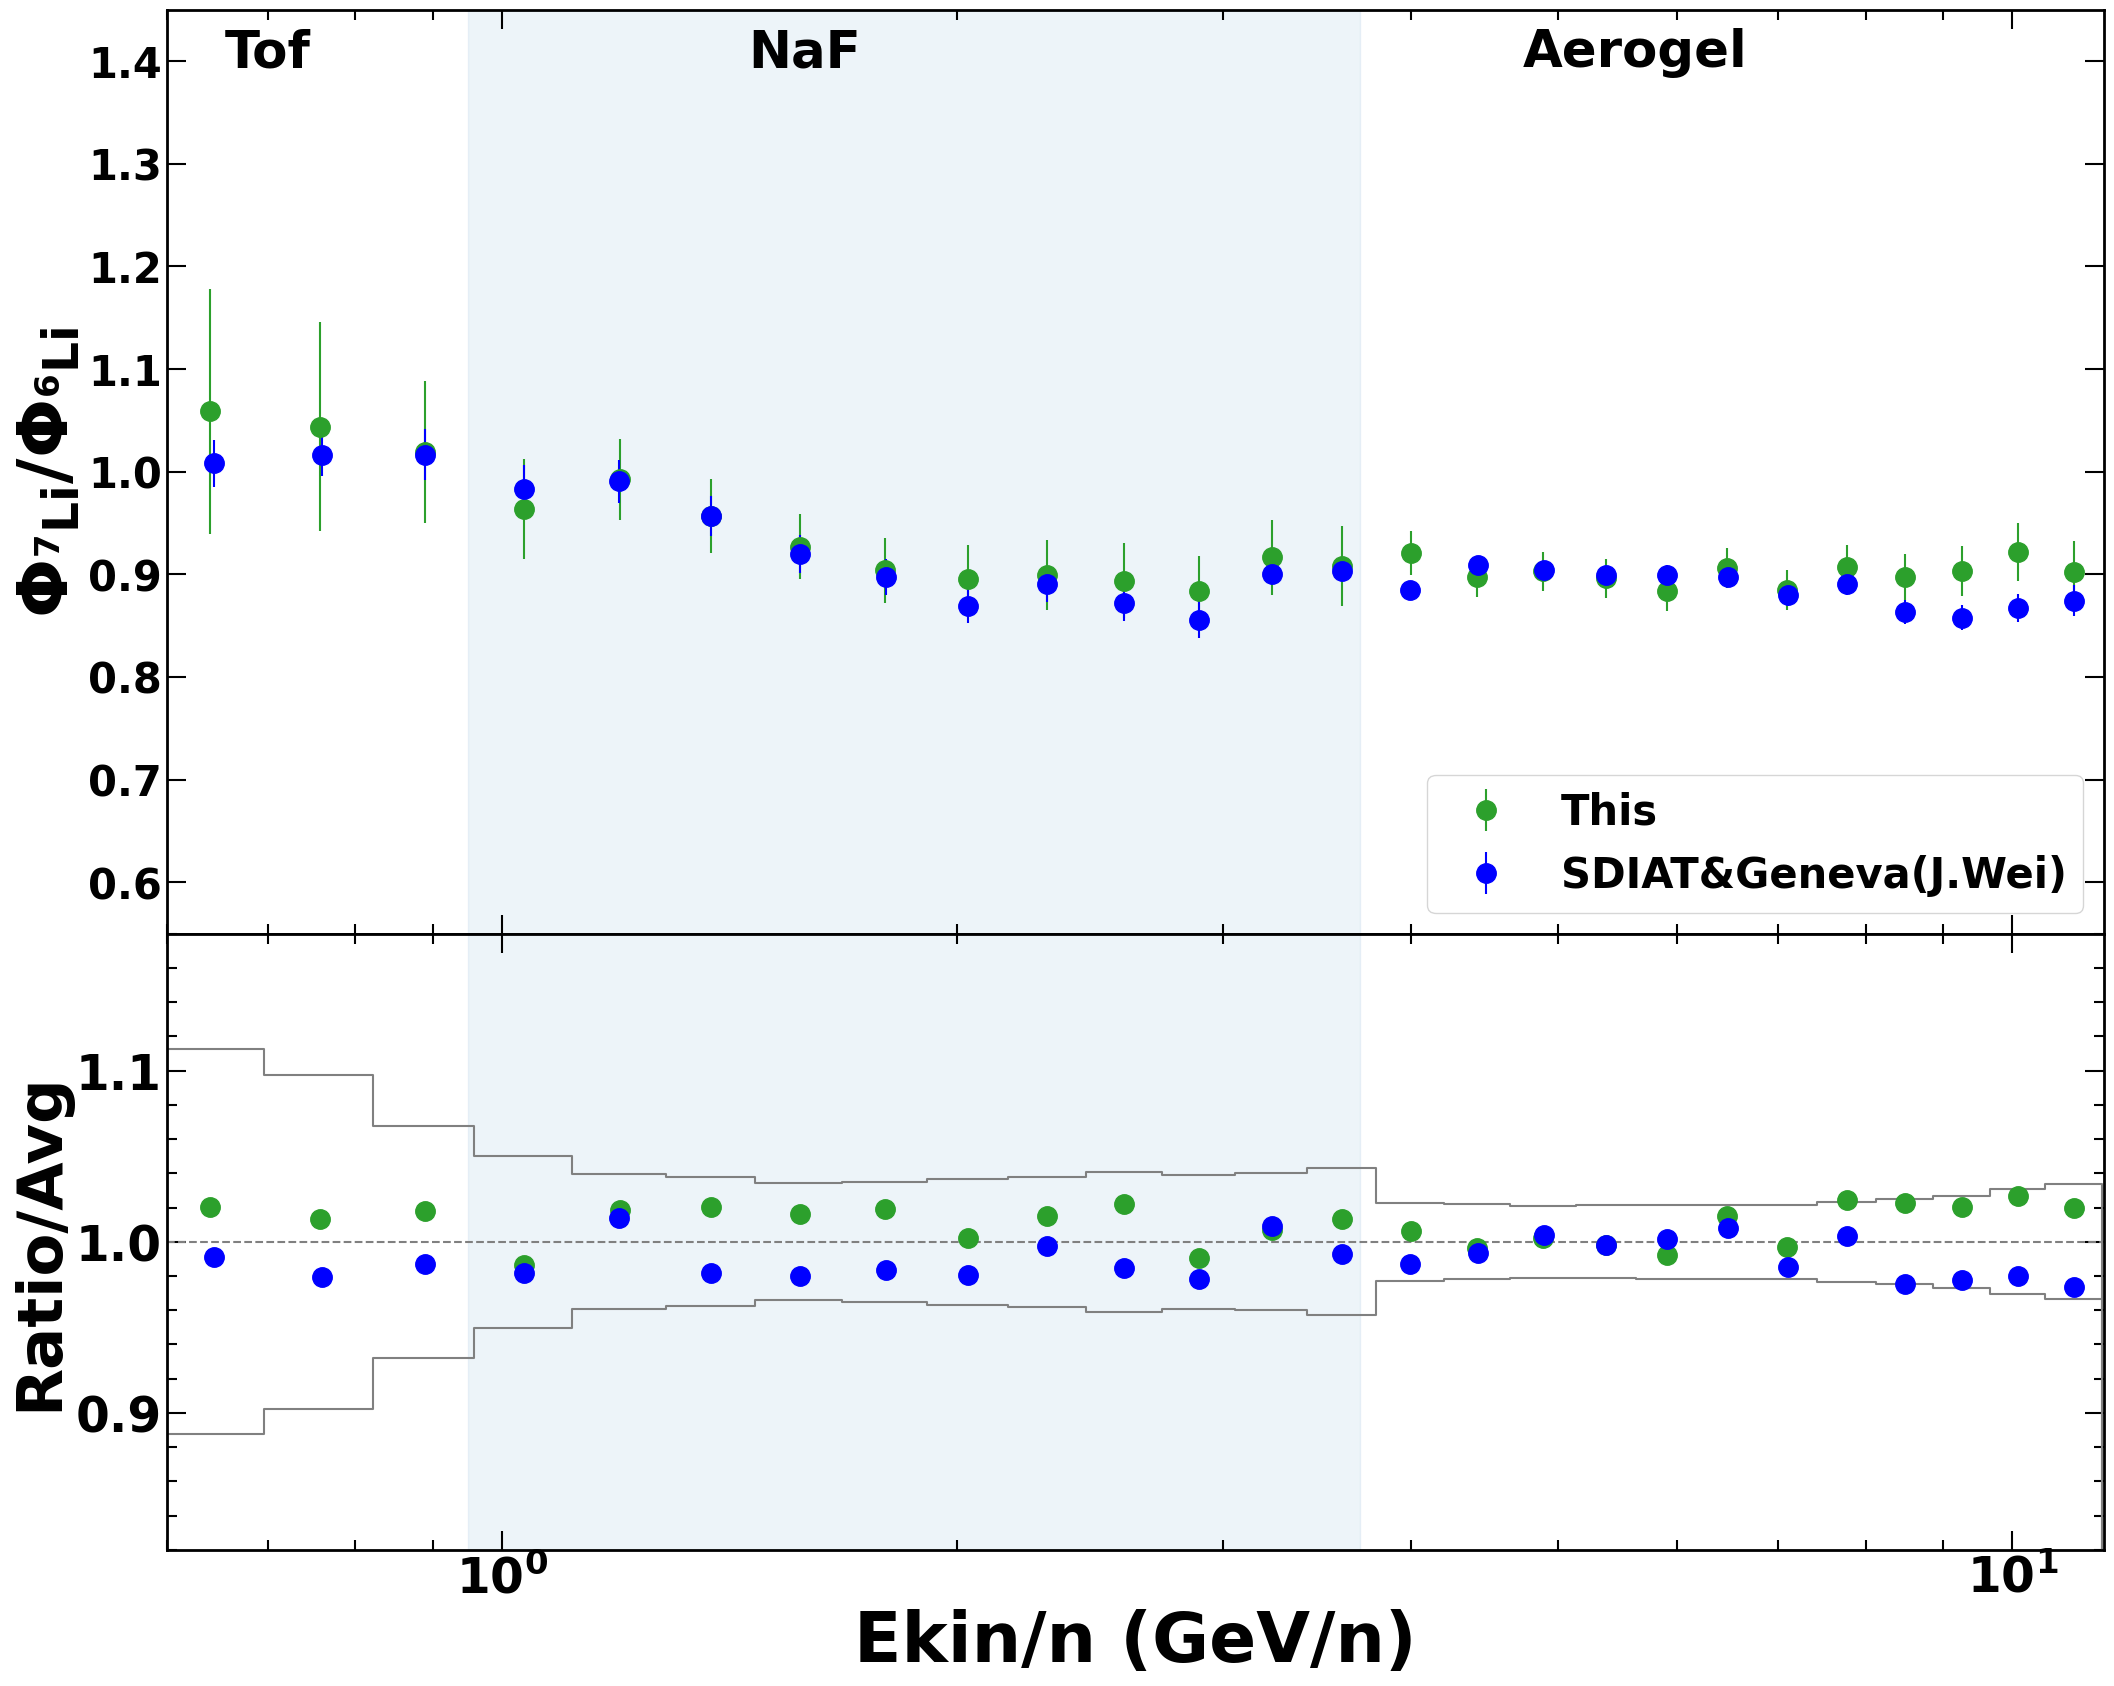

In [18]:
def getgraph_fromtxtfile(filename):
    
    Ek_low = []
    Ek_high = []
    Flux = []
    Stat_err = []
    with open(f'{filename}', 'r') as file:
        for line in file:
            # Check if the line starts with #
            if not line.startswith('#'):
                # Split the line into columns using ',' as the delimiter
                columns = line.strip().split(',')
            
                # Convert each column to a floating-point number and append to respective lists
                Ek_low.append(float(columns[0]))
                Ek_high.append(float(columns[1]))
                Flux.append(float(columns[2]))
                Stat_err.append(float(columns[3]))
             
            else:
                print('skip #')
        # Convert lists to numpy arrays
        Ek_low = np.array(Ek_low)
        Ek_high = np.array(Ek_high)
        Flux = np.array(Flux)
        Stat_err = np.array(Stat_err)
        graph_flux_jiahui = MGraph(0.5*(Ek_low+Ek_high), Flux, Stat_err)
    return graph_flux_jiahui


graph_flux_ratio = graph_unfoldflux_combined_toterr['Li7']/graph_unfoldflux_combined_toterr['Li6']   
###############################################
#read jiahui'ratio and draw compare
fileJH = '/home/manbing/Documents/Data/data_LiP8/JWeiLi/'
graph_flux_Jiahui = {}
for iso in isotopes:
    graph_flux_Jiahui[iso] = getgraph_fromtxtfile(fileJH+f'flux_{iso}.txt')
    

graph_jiahui_ratio = graph_flux_Jiahui['Li7']/graph_flux_Jiahui['Li6']
figsize = (25, 20)
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=figsize) 
ax1.set_ylabel(r"$\mathrm{\Phi_{^{7}Li}/\Phi_{^{6}Li}}$", fontsize=50) 
plot_graph(fig, ax1, graph_flux_ratio, color='tab:green', style="EP", xlog=False, ylog=False, markersize=28, label='This')
plot_graph(fig, ax1, graph_jiahui_ratio, color='blue', style="EP", xlog=False, ylog=False, markersize=28, label='SDIAT&Geneva(J.Wei)') 

ax1.set_xlabel(r"$\mathrm{E_{k}}$ per neucleon (GeV/n)", fontsize=35)
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
#ax1.get_yticklabels()[0].set_visible(False)
set_plot_defaultstyle(ax1)    
set_plot_defaultstyle(ax2) 


ax1.set_ylim([0.55, 1.45])
ax1.legend(loc='lower right')
ax1.set_xscale('log')
ax2.set_xscale('log')                                                                                                                       
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
ax1.get_yticklabels()[0].set_visible(False)
set_plot_defaultstyle(ax1)    
set_plot_defaultstyle(ax2) 
ax2.set_xlabel('Ekin/n (GeV/n)', fontsize=50)

#graph_average_be10ratio = scale_graph(graph_jiahui_ratiobe10 + graph_flux_ratio_10to9, 1/2)
#graph_average_be10ratio.yerrs = (abs(graph_jiahui_ratiobe10.yerrs) + abs(graph_flux_ratio_10to9.yerrs))/2


graph_average_ratio = MGraph(graph_jiahui_ratio.xvalues, (graph_jiahui_ratio.yvalues+graph_flux_ratio.yvalues)*0.5, (graph_jiahui_ratio.yerrs+graph_flux_ratio.yerrs)*0.5)
graph_difference_to_avg = graph_flux_ratio/graph_average_ratio
graph_difference_to_avg_jiahui = graph_jiahui_ratio/graph_average_ratio

errorband =   graph_flux_ratio.yerrs/graph_flux_ratio.yvalues
graph_lower_errorband = MGraph(graph_flux_ratio.xvalues, 1.0 + errorband, np.zeros_like(errorband))
graph_upper_errorband = MGraph(graph_flux_ratio.xvalues, 1.0 - errorband, np.zeros_like(errorband))

graph_difference_to_avg.yerrs *= 0.01
graph_difference_to_avg_jiahui.yerrs *= 0.01


print(graph_difference_to_avg)
#difference_to_avg.yvalues = abs(difference_to_avg.yvalues)
plot_graph(fig, ax2, graph_difference_to_avg, color='tab:green', style="EP", xlog=False, ylog=False, markersize=28)                                                                                                                              
plot_graph(fig, ax2, graph_difference_to_avg_jiahui, color='blue', style="EP", xlog=False, ylog=False, markersize=28)                                                                                                                              


plot_graph(fig, ax2, graph_lower_errorband, color='grey', style="step", xlog=False, ylog=False, markersize=28, xbinning=xbinning)                                                                                                                              
plot_graph(fig, ax2, graph_upper_errorband, color='grey', style="step", xlog=False, ylog=False, markersize=28, xbinning=xbinning)                                                                                                                              

ax1.set_xlim([0.6, 11.5])
ax2.set_xlim([0.6, 11.5])
xaxistext = {"Tof": 0.03, "NaF": 0.3, "Agl": 0.7}
for dec in detectors:
    ax1.text(xaxistext[dec], 0.98, f'{DETECTOR_LABEL[dec]}', fontsize=37, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      



#ax2.set_ylim([-0.35, 0.35])    
ax2.set_ylabel('Ratio/Avg')
ax2.axhline(y=1.3, color='grey', linestyle='--')
ax2.axhline(y=1.0, color='grey', linestyle='--')
ax2.axhline(y=0.7, color='grey', linestyle='--')
ax1.fill_betweenx(np.linspace(0.1, 2.0, 100), 0.95, 3.7, alpha=0.08, color="tab:blue") 
ax2.fill_betweenx(np.linspace(0.3, 1.8, 100), 0.95, 3.7, alpha=0.08, color="tab:blue") 
ax2.set_ylim([0.82, 1.18])
#plotfile = '/home/manbing/Documents/lithiumanalysis/slides/plots/BeIsoFluxP8_GBL'

savefig_tofile(fig, plotdir, f'Li_fluxratio_CompareJ', 1)